In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn.neural_network import MLPClassifier

from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [5]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [6]:
p = Pipeline.objects.all()[64]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: dummy frog ugs opt
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog
Classifier: Random Forest
Task status: Status.SUCCESS


In [7]:
len(p.data_source.articles)

3099

In [9]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [10]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fb822274250>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fb8225c0dd0>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fb8225c0e10>), ('Sentiment', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuot...742d0>), ('Frog', <newsgac.nlp_tools.models.frog.FrogFeatureExtractor object at 0x7fb8225c0ed0>)]))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [11]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [12]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [13]:
X_train = X
y_train = labels
y_test = labels_test

In [14]:
y_test.shape

(344,)

In [15]:
# hidden_layer_sizes_list =[(200, 100), (100, 200), (150, 300), (300, 100), (100, 200, 100), (200,100,200)]
hidden_layer_sizes_list =[(20, 30), (30, 10), (10, 20), (5,10)]
activation_list = ['identity', 'logistic', 'tanh', 'relu']
solver_list = ['lbfgs','sgd', 'adam']
learning_rate_list = ['constant','adaptive', 'invscaling']
batch_size_list = np.arange(20, 200, dtype=int)
max_iter_list = np.arange(20, 500, dtype=int)

In [16]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'hidden_layer_sizes': hp.choice('hidden_layer_sizes', hidden_layer_sizes_list),
        'activation': hp.choice('activation', activation_list),
        'solver': hp.choice('solver', solver_list),
        'alpha': hp.lognormal('alpha', 0, 1), # [0.0001, 0.05],
#         'alpha': hp.loguniform('alpha', np.log(0.1), np.log(10)),
        'learning_rate': hp.choice('learning_rate', learning_rate_list),
        'batch_size': hp.choice('batch_size', batch_size_list),
        'max_iter': hp.choice('max_iter', max_iter_list),
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [17]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
     
    model = MLPClassifier(
            hidden_layer_sizes = params['hidden_layer_sizes'],
            activation = params['activation'],
            solver = params['solver'],
            alpha = params['alpha'],
            learning_rate = params['learning_rate'],
            batch_size = params['batch_size'],
            max_iter = params['max_iter'],
            shuffle = True,
            random_state = 42,
            warm_start = False,
            early_stopping = True,
            validation_fraction = 0.1,
    )

    model.fit(X_train, y_train)   

    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [18]:
import time
from tqdm import tqdm

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['hidden_layer_sizes'] = hidden_layer_sizes_list[best_param['hidden_layer_sizes']]
best_param['activation'] = activation_list[best_param['activation']]
best_param['solver'] = solver_list[best_param['solver']]
best_param['learning_rate'] = learning_rate_list[best_param['learning_rate']]
best_param['batch_size'] = batch_size_list[best_param['batch_size']]
best_param['max_iter'] = max_iter_list[best_param['max_iter']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.584704743466 and loss 1.34136708343 :

  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.563953488372 and loss 1.37469976461 :

  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 0.641111703472671, 'activation': 'tanh', 'max_iter': 312, 'learning_rate': 'constant', 'batch_size': 196}

  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:01<24:09,  1.45s/it]


  0%|          | 1/1000 [00:00<16:24,  1.02it/s, best loss: -0.563953488372]
Parameters with this training accuracy 0.59503065505 and loss 1.26690180553 :

  0%|          | 1/1000 [00:01<16:24,  1.02it/s, best loss: -0.563953488372]
Parameters with this testing accuracy 0.563953488372 and loss 1.33401003554 :

  0%|          | 1/1000 [00:01<16:24,  1.02it/s, best loss: -0.563953488372]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.518227855011347, 'activation': 'logistic', 'max_iter': 75, 'learning_rate': 'invscaling', 'batch_size': 95}

  0%|          | 1/1000 [00:01<16:24,  1.02it/s, best loss: -0.563953488372]

Hyperopt:   0%|          | 2/1000 [00:02<21:05,  1.27s/it]


  0%|          | 2/1000 [00:01<15:40,  1.06it/s, best loss: -0.563953488372]
Parameters with this training accuracy 0.430461439174 and loss 2.32189975788 :

  0%|          | 2/1000 [00:02<15:40,  1.06it/s, best loss: -0.563953488372]
Parameters with this testing accuracy 0.468023255814 and loss 2.29332239163 :

  0%|          | 2/1000 [00:02<15:40,  1.06it/s, best loss: -0.563953488372]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 0.3798677956068435, 'activation': 'identity', 'max_iter': 212, 'learning_rate': 'invscaling', 'batch_size': 172}

  0%|          | 2/1000 [00:02<15:40,  1.06it/s, best loss: -0.563953488372]

Hyperopt:   0%|          | 3/1000 [00:02<16:03,  1.03it/s]


  0%|          | 3/1000 [00:02<12:16,  1.35it/s, best loss: -0.563953488372]
Parameters with this training accuracy 0.49241690868 and loss 1.81033186802 :

  0%|          | 3/1000 [00:02<12:16,  1.35it/s, best loss: -0.563953488372]
Parameters with this testing accuracy 0.502906976744 and loss 1.81956083839 :

  0%|          | 3/1000 [00:02<12:16,  1.35it/s, best loss: -0.563953488372]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 2.237290898820041, 'activation': 'identity', 'max_iter': 137, 'learning_rate': 'constant', 'batch_size': 23}

  0%|          | 3/1000 [00:02<12:16,  1.35it/s, best loss: -0.563953488372]

Hyperopt:   0%|          | 4/1000 [00:03<14:28,  1.15it/s]


  0%|          | 4/1000 [00:02<11:49,  1.40it/s, best loss: -0.563953488372]
Parameters with this training accuracy 0.556631171346 and loss 1.51027251567 :

  0%|          | 4/1000 [00:04<11:49,  1.40it/s, best loss: -0.563953488372]
Parameters with this testing accuracy 0.543604651163 and loss 1.51185885521 :

  0%|          | 4/1000 [00:04<11:49,  1.40it/s, best loss: -0.563953488372]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6964834613969373, 'activation': 'tanh', 'max_iter': 367, 'learning_rate': 'constant', 'batch_size': 20}

  0%|          | 4/1000 [00:04<11:49,  1.40it/s, best loss: -0.563953488372]

Hyperopt:   0%|          | 5/1000 [00:04<18:38,  1.12s/it]


  0%|          | 5/1000 [00:04<16:47,  1.01s/it, best loss: -0.563953488372]
Parameters with this training accuracy 0.431106808648 and loss 2.20072610435 :

  0%|          | 5/1000 [00:04<16:47,  1.01s/it, best loss: -0.563953488372]
Parameters with this testing accuracy 0.468023255814 and loss 2.18265659808 :

  0%|          | 5/1000 [00:04<16:47,  1.01s/it, best loss: -0.563953488372]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 3.020624492776142, 'activation': 'logistic', 'max_iter': 403, 'learning_rate': 'constant', 'batch_size': 195}

  0%|          | 5/1000 [00:04<16:47,  1.01s/it, best loss: -0.563953488372]

Hyperopt:   1%|          | 6/1000 [00:05<14:34,  1.14it/s]


  1%|          | 6/1000 [00:04<13:16,  1.25it/s, best loss: -0.563953488372]
Parameters with this training accuracy 0.557599225557 and loss 1.47937308251 :

  1%|          | 6/1000 [00:06<13:16,  1.25it/s, best loss: -0.563953488372]
Parameters with this testing accuracy 0.526162790698 and loss 1.52187345005 :

  1%|          | 6/1000 [00:06<13:16,  1.25it/s, best loss: -0.563953488372]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7327302506190563, 'activation': 'identity', 'max_iter': 312, 'learning_rate': 'adaptive', 'batch_size': 102}

  1%|          | 6/1000 [00:06<13:16,  1.25it/s, best loss: -0.563953488372]

Hyperopt:   1%|          | 7/1000 [00:06<17:13,  1.04s/it]


  1%|          | 7/1000 [00:06<16:19,  1.01it/s, best loss: -0.563953488372]
Parameters with this training accuracy 0.633107454017 and loss 1.14766867991 :

  1%|          | 7/1000 [00:07<16:19,  1.01it/s, best loss: -0.563953488372]
Parameters with this testing accuracy 0.578488372093 and loss 1.27736169964 :

  1%|          | 7/1000 [00:07<16:19,  1.01it/s, best loss: -0.563953488372]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.453188159637824, 'activation': 'relu', 'max_iter': 346, 'learning_rate': 'adaptive', 'batch_size': 116}

  1%|          | 7/1000 [00:07<16:19,  1.01it/s, best loss: -0.563953488372]

Hyperopt:   1%|          | 8/1000 [00:08<19:58,  1.21s/it]


  1%|          | 8/1000 [00:07<19:20,  1.17s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.555663117135 and loss 1.49970754979 :

  1%|          | 8/1000 [00:08<19:20,  1.17s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.529069767442 and loss 1.54409251244 :

  1%|          | 8/1000 [00:08<19:20,  1.17s/it, best loss: -0.578488372093]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 4.053980441778581, 'activation': 'identity', 'max_iter': 55, 'learning_rate': 'invscaling', 'batch_size': 162}

  1%|          | 8/1000 [00:08<19:20,  1.17s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 9/1000 [00:08<16:14,  1.02it/s]


  1%|          | 9/1000 [00:08<15:48,  1.04it/s, best loss: -0.578488372093]
Parameters with this training accuracy 0.658276863504 and loss 1.07158713286 :

  1%|          | 9/1000 [00:10<15:48,  1.04it/s, best loss: -0.578488372093]
Parameters with this testing accuracy 0.572674418605 and loss 1.23095387403 :

  1%|          | 9/1000 [00:10<15:48,  1.04it/s, best loss: -0.578488372093]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.945740330268299, 'activation': 'logistic', 'max_iter': 324, 'learning_rate': 'invscaling', 'batch_size': 100}

  1%|          | 9/1000 [00:10<15:48,  1.04it/s, best loss: -0.578488372093]

Hyperopt:   1%|          | 10/1000 [00:10<22:11,  1.34s/it]


  1%|          | 10/1000 [00:10<21:52,  1.33s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.431106808648 and loss 2.54222158308 :

  1%|          | 10/1000 [00:11<21:52,  1.33s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.46511627907 and loss 2.49832695835 :

  1%|          | 10/1000 [00:11<21:52,  1.33s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 0.8354624234970496, 'activation': 'relu', 'max_iter': 385, 'learning_rate': 'adaptive', 'batch_size': 65}

  1%|          | 10/1000 [00:11<21:52,  1.33s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 11/1000 [00:12<21:06,  1.28s/it]


  1%|          | 11/1000 [00:11<20:53,  1.27s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.484995159729 and loss 1.83435497651 :

  1%|          | 11/1000 [00:12<20:53,  1.27s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.491279069767 and loss 1.83309819826 :

  1%|          | 11/1000 [00:12<20:53,  1.27s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2049715874808158, 'activation': 'identity', 'max_iter': 124, 'learning_rate': 'invscaling', 'batch_size': 42}

  1%|          | 11/1000 [00:12<20:53,  1.27s/it, best loss: -0.578488372093]

Hyperopt:   1%|          | 12/1000 [00:12<19:00,  1.15s/it]


  1%|          | 12/1000 [00:12<18:51,  1.15s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.561471442401 and loss 1.46458022256 :

  1%|          | 12/1000 [00:13<18:51,  1.15s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.540697674419 and loss 1.47951177503 :

  1%|          | 12/1000 [00:13<18:51,  1.15s/it, best loss: -0.578488372093]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.27843578008220654, 'activation': 'tanh', 'max_iter': 366, 'learning_rate': 'invscaling', 'batch_size': 164}

  1%|          | 12/1000 [00:13<18:51,  1.15s/it, best loss: -0.578488372093]

Hyperopt:   1%|▏         | 13/1000 [00:13<17:28,  1.06s/it]


  1%|▏         | 13/1000 [00:13<17:21,  1.06s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.431106808648 and loss 2.29546371867 :

  1%|▏         | 13/1000 [00:13<17:21,  1.06s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.468023255814 and loss 2.25548052456 :

  1%|▏         | 13/1000 [00:13<17:21,  1.06s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1189770139212383, 'activation': 'logistic', 'max_iter': 248, 'learning_rate': 'constant', 'batch_size': 50}

  1%|▏         | 13/1000 [00:13<17:21,  1.06s/it, best loss: -0.578488372093]

Hyperopt:   1%|▏         | 14/1000 [00:14<14:12,  1.16it/s]


  1%|▏         | 14/1000 [00:13<14:08,  1.16it/s, best loss: -0.578488372093]
Parameters with this training accuracy 0.621490803485 and loss 1.19032548804 :

  1%|▏         | 14/1000 [00:14<14:08,  1.16it/s, best loss: -0.578488372093]
Parameters with this testing accuracy 0.563953488372 and loss 1.27413688414 :

  1%|▏         | 14/1000 [00:14<14:08,  1.16it/s, best loss: -0.578488372093]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3042813162363451, 'activation': 'logistic', 'max_iter': 126, 'learning_rate': 'adaptive', 'batch_size': 197}

  1%|▏         | 14/1000 [00:14<14:08,  1.16it/s, best loss: -0.578488372093]

Hyperopt:   2%|▏         | 15/1000 [00:15<14:29,  1.13it/s]


  2%|▏         | 15/1000 [00:14<14:25,  1.14it/s, best loss: -0.578488372093]
Parameters with this training accuracy 0.497257179735 and loss 1.78787436616 :

  2%|▏         | 15/1000 [00:15<14:25,  1.14it/s, best loss: -0.578488372093]
Parameters with this testing accuracy 0.497093023256 and loss 1.80547169668 :

  2%|▏         | 15/1000 [00:15<14:25,  1.14it/s, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2488571422097143, 'activation': 'identity', 'max_iter': 28, 'learning_rate': 'invscaling', 'batch_size': 36}

  2%|▏         | 15/1000 [00:15<14:25,  1.14it/s, best loss: -0.578488372093]

Hyperopt:   2%|▏         | 16/1000 [00:15<12:36,  1.30it/s]


  2%|▏         | 16/1000 [00:15<12:34,  1.30it/s, best loss: -0.578488372093]
Parameters with this training accuracy 0.588254275573 and loss 1.32568393404 :

  2%|▏         | 16/1000 [00:19<12:34,  1.30it/s, best loss: -0.578488372093]
Parameters with this testing accuracy 0.561046511628 and loss 1.37430359125 :

  2%|▏         | 16/1000 [00:19<12:34,  1.30it/s, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.3166526160308349, 'activation': 'relu', 'max_iter': 238, 'learning_rate': 'adaptive', 'batch_size': 25}

  2%|▏         | 16/1000 [00:19<12:34,  1.30it/s, best loss: -0.578488372093]

Hyperopt:   2%|▏         | 17/1000 [00:19<30:01,  1.83s/it]


  2%|▏         | 17/1000 [00:19<30:00,  1.83s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.438528557599 and loss 2.61525696222 :

  2%|▏         | 17/1000 [00:19<30:00,  1.83s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.46511627907 and loss 2.60050283289 :

  2%|▏         | 17/1000 [00:19<30:00,  1.83s/it, best loss: -0.578488372093]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.2800180450170752, 'activation': 'logistic', 'max_iter': 296, 'learning_rate': 'invscaling', 'batch_size': 86}

  2%|▏         | 17/1000 [00:19<30:00,  1.83s/it, best loss: -0.578488372093]

Hyperopt:   2%|▏         | 18/1000 [00:20<23:01,  1.41s/it]


  2%|▏         | 18/1000 [00:19<23:00,  1.41s/it, best loss: -0.578488372093]
Parameters with this training accuracy 0.620845434011 and loss 1.21467086917 :

  2%|▏         | 18/1000 [00:22<23:00,  1.41s/it, best loss: -0.578488372093]
Parameters with this testing accuracy 0.584302325581 and loss 1.33832314145 :

  2%|▏         | 18/1000 [00:22<23:00,  1.41s/it, best loss: -0.578488372093]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3409212063197206, 'activation': 'identity', 'max_iter': 458, 'learning_rate': 'invscaling', 'batch_size': 56}

  2%|▏         | 18/1000 [00:22<23:00,  1.41s/it, best loss: -0.578488372093]

Hyperopt:   2%|▏         | 19/1000 [00:23<29:59,  1.83s/it]


  2%|▏         | 19/1000 [00:22<29:58,  1.83s/it, best loss: -0.584302325581]
Parameters with this training accuracy 0.604388512423 and loss 1.25921412588 :

  2%|▏         | 19/1000 [00:24<29:58,  1.83s/it, best loss: -0.584302325581]
Parameters with this testing accuracy 0.566860465116 and loss 1.35156980007 :

  2%|▏         | 19/1000 [00:24<29:58,  1.83s/it, best loss: -0.584302325581]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.9376009774365817, 'activation': 'identity', 'max_iter': 328, 'learning_rate': 'invscaling', 'batch_size': 93}

  2%|▏         | 19/1000 [00:24<29:58,  1.83s/it, best loss: -0.584302325581]

Hyperopt:   2%|▏         | 20/1000 [00:24<27:47,  1.70s/it]


  2%|▏         | 20/1000 [00:24<27:47,  1.70s/it, best loss: -0.584302325581]
Parameters with this training accuracy 0.61665053243 and loss 1.20803540366 :

  2%|▏         | 20/1000 [00:25<27:47,  1.70s/it, best loss: -0.584302325581]
Parameters with this testing accuracy 0.575581395349 and loss 1.27392842721 :

  2%|▏         | 20/1000 [00:25<27:47,  1.70s/it, best loss: -0.584302325581]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 8.83399819370725, 'activation': 'relu', 'max_iter': 316, 'learning_rate': 'adaptive', 'batch_size': 151}

  2%|▏         | 20/1000 [00:25<27:47,  1.70s/it, best loss: -0.584302325581]

Hyperopt:   2%|▏         | 21/1000 [00:25<26:31,  1.63s/it]


  2%|▏         | 21/1000 [00:25<26:31,  1.63s/it, best loss: -0.584302325581]
Parameters with this training accuracy 0.570506615037 and loss 1.47701776332 :

  2%|▏         | 21/1000 [00:26<26:31,  1.63s/it, best loss: -0.584302325581]
Parameters with this testing accuracy 0.540697674419 and loss 1.50163505099 :

  2%|▏         | 21/1000 [00:26<26:31,  1.63s/it, best loss: -0.584302325581]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.03299183094214918, 'activation': 'relu', 'max_iter': 113, 'learning_rate': 'adaptive', 'batch_size': 53}

  2%|▏         | 21/1000 [00:26<26:31,  1.63s/it, best loss: -0.584302325581]

Hyperopt:   2%|▏         | 22/1000 [00:26<22:19,  1.37s/it]


  2%|▏         | 22/1000 [00:26<22:19,  1.37s/it, best loss: -0.584302325581]
Parameters with this training accuracy 0.616327847693 and loss 1.21179120867 :

  2%|▏         | 22/1000 [00:27<22:19,  1.37s/it, best loss: -0.584302325581]
Parameters with this testing accuracy 0.552325581395 and loss 1.33432067275 :

  2%|▏         | 22/1000 [00:27<22:19,  1.37s/it, best loss: -0.584302325581]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.15937537698494764, 'activation': 'relu', 'max_iter': 318, 'learning_rate': 'adaptive', 'batch_size': 63}

  2%|▏         | 22/1000 [00:27<22:19,  1.37s/it, best loss: -0.584302325581]

Hyperopt:   2%|▏         | 23/1000 [00:28<23:05,  1.42s/it]


  2%|▏         | 23/1000 [00:27<23:05,  1.42s/it, best loss: -0.584302325581]
Parameters with this training accuracy 0.676669893514 and loss 0.981389968905 :

  2%|▏         | 23/1000 [00:30<23:05,  1.42s/it, best loss: -0.584302325581]
Parameters with this testing accuracy 0.601744186047 and loss 1.23015817491 :

  2%|▏         | 23/1000 [00:30<23:05,  1.42s/it, best loss: -0.584302325581]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 6.124567411493286, 'activation': 'relu', 'max_iter': 492, 'learning_rate': 'adaptive', 'batch_size': 96}

  2%|▏         | 23/1000 [00:30<23:05,  1.42s/it, best loss: -0.584302325581]

Hyperopt:   2%|▏         | 24/1000 [00:31<31:11,  1.92s/it]


  2%|▏         | 24/1000 [00:30<31:11,  1.92s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.635043562439 and loss 1.12353033753 :

  2%|▏         | 24/1000 [00:32<31:11,  1.92s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.25749786369 :

  2%|▏         | 24/1000 [00:32<31:11,  1.92s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 11.98389281142808, 'activation': 'relu', 'max_iter': 173, 'learning_rate': 'adaptive', 'batch_size': 56}

  2%|▏         | 24/1000 [00:32<31:11,  1.92s/it, best loss: -0.601744186047]

Hyperopt:   2%|▎         | 25/1000 [00:32<27:30,  1.69s/it]


  2%|▎         | 25/1000 [00:32<27:30,  1.69s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.711842529848 and loss 0.922914651559 :

  2%|▎         | 25/1000 [00:36<27:30,  1.69s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.24456840815 :

  2%|▎         | 25/1000 [00:36<27:30,  1.69s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.686358316834347, 'activation': 'tanh', 'max_iter': 458, 'learning_rate': 'invscaling', 'batch_size': 96}

  2%|▎         | 25/1000 [00:36<27:30,  1.69s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 26/1000 [00:36<39:23,  2.43s/it]


  3%|▎         | 26/1000 [00:36<39:23,  2.43s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.596321393998 and loss 1.28192225554 :

  3%|▎         | 26/1000 [00:36<39:23,  2.43s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.572674418605 and loss 1.38181005725 :

  3%|▎         | 26/1000 [00:36<39:23,  2.43s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 21.167161271219364, 'activation': 'identity', 'max_iter': 89, 'learning_rate': 'adaptive', 'batch_size': 41}

  3%|▎         | 26/1000 [00:36<39:23,  2.43s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 27/1000 [00:37<31:12,  1.92s/it]


  3%|▎         | 27/1000 [00:36<31:12,  1.92s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.572765408196 and loss 1.40038341062 :

  3%|▎         | 27/1000 [00:39<31:12,  1.92s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.540697674419 and loss 1.41640824822 :

  3%|▎         | 27/1000 [00:39<31:12,  1.92s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 106.00595993279667, 'activation': 'relu', 'max_iter': 408, 'learning_rate': 'adaptive', 'batch_size': 52}

  3%|▎         | 27/1000 [00:39<31:12,  1.92s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 28/1000 [00:39<33:48,  2.09s/it]


  3%|▎         | 28/1000 [00:39<33:48,  2.09s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.63827040981 and loss 1.10750805359 :

  3%|▎         | 28/1000 [00:40<33:48,  2.09s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.587209302326 and loss 1.2446903724 :

  3%|▎         | 28/1000 [00:40<33:48,  2.09s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.5419834050873675, 'activation': 'tanh', 'max_iter': 62, 'learning_rate': 'constant', 'batch_size': 153}

  3%|▎         | 28/1000 [00:40<33:48,  2.09s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 29/1000 [00:40<26:56,  1.66s/it]


  3%|▎         | 29/1000 [00:40<26:56,  1.66s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.728622136173 and loss 0.833756728897 :

  3%|▎         | 29/1000 [00:44<26:56,  1.66s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.575581395349 and loss 1.34797029839 :

  3%|▎         | 29/1000 [00:44<26:56,  1.66s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.505494854874592, 'activation': 'tanh', 'max_iter': 490, 'learning_rate': 'constant', 'batch_size': 153}

  3%|▎         | 29/1000 [00:44<26:56,  1.66s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 30/1000 [00:44<40:11,  2.49s/it]


  3%|▎         | 30/1000 [00:44<40:11,  2.49s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.714746692481 and loss 0.883341054638 :

  3%|▎         | 30/1000 [00:47<40:11,  2.49s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.598837209302 and loss 1.25787929342 :

  3%|▎         | 30/1000 [00:47<40:11,  2.49s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.9325962258514437, 'activation': 'tanh', 'max_iter': 339, 'learning_rate': 'constant', 'batch_size': 89}

  3%|▎         | 30/1000 [00:47<40:11,  2.49s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 31/1000 [00:48<43:04,  2.67s/it]


  3%|▎         | 31/1000 [00:47<43:05,  2.67s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.60148434979 and loss 1.3094832106 :

  3%|▎         | 31/1000 [00:48<43:05,  2.67s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.34000675849 :

  3%|▎         | 31/1000 [00:48<43:05,  2.67s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5336225080854908, 'activation': 'tanh', 'max_iter': 161, 'learning_rate': 'constant', 'batch_size': 140}

  3%|▎         | 31/1000 [00:48<43:05,  2.67s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 32/1000 [00:49<36:47,  2.28s/it]


  3%|▎         | 32/1000 [00:48<36:47,  2.28s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.717973539852 and loss 0.880841369587 :

  3%|▎         | 32/1000 [00:52<36:47,  2.28s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.593023255814 and loss 1.30866627879 :

  3%|▎         | 32/1000 [00:52<36:47,  2.28s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.230870776633606, 'activation': 'tanh', 'max_iter': 401, 'learning_rate': 'constant', 'batch_size': 89}

  3%|▎         | 32/1000 [00:52<36:47,  2.28s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 33/1000 [00:53<43:17,  2.69s/it]


  3%|▎         | 33/1000 [00:52<43:17,  2.69s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.702807357212 and loss 0.930106380517 :

  3%|▎         | 33/1000 [00:55<43:17,  2.69s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.587209302326 and loss 1.21665324464 :

  3%|▎         | 33/1000 [00:55<43:17,  2.69s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.387639797342701, 'activation': 'tanh', 'max_iter': 356, 'learning_rate': 'constant', 'batch_size': 193}

  3%|▎         | 33/1000 [00:55<43:17,  2.69s/it, best loss: -0.601744186047]

Hyperopt:   3%|▎         | 34/1000 [00:56<45:55,  2.85s/it]


  3%|▎         | 34/1000 [00:55<45:55,  2.85s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.554695062924 and loss 1.4755382278 :

  3%|▎         | 34/1000 [00:56<45:55,  2.85s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.53488372093 and loss 1.48452543314 :

  3%|▎         | 34/1000 [00:56<45:55,  2.85s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.8930014238059172, 'activation': 'tanh', 'max_iter': 331, 'learning_rate': 'constant', 'batch_size': 189}

  3%|▎         | 34/1000 [00:56<45:55,  2.85s/it, best loss: -0.601744186047]

Hyperopt:   4%|▎         | 35/1000 [00:56<35:09,  2.19s/it]


  4%|▎         | 35/1000 [00:56<35:09,  2.19s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.645692158761 and loss 1.08484142294 :

  4%|▎         | 35/1000 [00:58<35:09,  2.19s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.24140218411 :

  4%|▎         | 35/1000 [00:58<35:09,  2.19s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 15.430718231829756, 'activation': 'relu', 'max_iter': 245, 'learning_rate': 'constant', 'batch_size': 79}

  4%|▎         | 35/1000 [00:58<35:09,  2.19s/it, best loss: -0.601744186047]

Hyperopt:   4%|▎         | 36/1000 [00:58<33:15,  2.07s/it]


  4%|▎         | 36/1000 [00:58<33:15,  2.07s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.707970313004 and loss 0.918118228117 :

  4%|▎         | 36/1000 [01:02<33:15,  2.07s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.587209302326 and loss 1.2255349555 :

  4%|▎         | 36/1000 [01:02<33:15,  2.07s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.31458346452566, 'activation': 'tanh', 'max_iter': 450, 'learning_rate': 'constant', 'batch_size': 183}

  4%|▎         | 36/1000 [01:02<33:15,  2.07s/it, best loss: -0.601744186047]

Hyperopt:   4%|▎         | 37/1000 [01:02<42:51,  2.67s/it]


  4%|▎         | 37/1000 [01:02<42:50,  2.67s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.609874152953 and loss 1.25020282801 :

  4%|▎         | 37/1000 [01:03<42:50,  2.67s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.575581395349 and loss 1.32565392757 :

  4%|▎         | 37/1000 [01:03<42:50,  2.67s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 0.48429805660996256, 'activation': 'relu', 'max_iter': 339, 'learning_rate': 'constant', 'batch_size': 135}

  4%|▎         | 37/1000 [01:03<42:50,  2.67s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 38/1000 [01:03<35:03,  2.19s/it]


  4%|▍         | 38/1000 [01:03<35:03,  2.19s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.654727331397 and loss 1.07934679156 :

  4%|▍         | 38/1000 [01:05<35:03,  2.19s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.20213959433 :

  4%|▍         | 38/1000 [01:05<35:03,  2.19s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 7.382976858711225, 'activation': 'tanh', 'max_iter': 237, 'learning_rate': 'adaptive', 'batch_size': 160}

  4%|▍         | 38/1000 [01:05<35:03,  2.19s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 39/1000 [01:05<33:27,  2.09s/it]


  4%|▍         | 39/1000 [01:05<33:27,  2.09s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.496289125524 and loss 1.712204987 :

  4%|▍         | 39/1000 [01:05<33:27,  2.09s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.494186046512 and loss 1.7153347896 :

  4%|▍         | 39/1000 [01:05<33:27,  2.09s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 4.0208606229175725, 'activation': 'relu', 'max_iter': 486, 'learning_rate': 'adaptive', 'batch_size': 43}

  4%|▍         | 39/1000 [01:05<33:27,  2.09s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 40/1000 [01:06<26:34,  1.66s/it]


  4%|▍         | 40/1000 [01:05<26:34,  1.66s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.620845434011 and loss 1.20317565301 :

  4%|▍         | 40/1000 [01:06<26:34,  1.66s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.29703424886 :

  4%|▍         | 40/1000 [01:06<26:34,  1.66s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.9390726213560094, 'activation': 'logistic', 'max_iter': 92, 'learning_rate': 'constant', 'batch_size': 60}

  4%|▍         | 40/1000 [01:06<26:34,  1.66s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 41/1000 [01:07<23:14,  1.45s/it]


  4%|▍         | 41/1000 [01:06<23:15,  1.45s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.70409809616 and loss 0.918348483684 :

  4%|▍         | 41/1000 [01:09<23:15,  1.45s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.587209302326 and loss 1.28526105816 :

  4%|▍         | 41/1000 [01:09<23:15,  1.45s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.6120933077668718, 'activation': 'tanh', 'max_iter': 291, 'learning_rate': 'adaptive', 'batch_size': 80}

  4%|▍         | 41/1000 [01:09<23:15,  1.45s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 42/1000 [01:10<29:04,  1.82s/it]


  4%|▍         | 42/1000 [01:09<29:04,  1.82s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.473701193934 and loss 1.91731451633 :

  4%|▍         | 42/1000 [01:09<29:04,  1.82s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.485465116279 and loss 1.90059945644 :

  4%|▍         | 42/1000 [01:09<29:04,  1.82s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 25.904971362257818, 'activation': 'relu', 'max_iter': 131, 'learning_rate': 'constant', 'batch_size': 90}

  4%|▍         | 42/1000 [01:09<29:04,  1.82s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 43/1000 [01:10<22:15,  1.40s/it]


  4%|▍         | 43/1000 [01:09<22:15,  1.40s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.632139399806 and loss 1.1681348487 :

  4%|▍         | 43/1000 [01:12<22:15,  1.40s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.26952675929 :

  4%|▍         | 43/1000 [01:12<22:15,  1.40s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.964564196097752, 'activation': 'logistic', 'max_iter': 329, 'learning_rate': 'adaptive', 'batch_size': 82}

  4%|▍         | 43/1000 [01:12<22:15,  1.40s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 44/1000 [01:13<27:53,  1.75s/it]


  4%|▍         | 44/1000 [01:12<27:53,  1.75s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.514682155534 and loss 1.70708203174 :

  4%|▍         | 44/1000 [01:13<27:53,  1.75s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.505813953488 and loss 1.69571755475 :

  4%|▍         | 44/1000 [01:13<27:53,  1.75s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8825606339512139, 'activation': 'tanh', 'max_iter': 199, 'learning_rate': 'constant', 'batch_size': 122}

  4%|▍         | 44/1000 [01:13<27:53,  1.75s/it, best loss: -0.601744186047]

Hyperopt:   4%|▍         | 45/1000 [01:13<22:08,  1.39s/it]


  4%|▍         | 45/1000 [01:13<22:08,  1.39s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.668925459826 and loss 1.04521483817 :

  4%|▍         | 45/1000 [01:14<22:08,  1.39s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.294052024 :

  4%|▍         | 45/1000 [01:14<22:08,  1.39s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6225450313020084, 'activation': 'relu', 'max_iter': 218, 'learning_rate': 'adaptive', 'batch_size': 97}

  4%|▍         | 45/1000 [01:14<22:08,  1.39s/it, best loss: -0.601744186047]

Hyperopt:   5%|▍         | 46/1000 [01:15<22:58,  1.45s/it]


  5%|▍         | 46/1000 [01:14<22:58,  1.44s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.431106808648 and loss 2.54255679272 :

  5%|▍         | 46/1000 [01:14<22:58,  1.44s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.468023255814 and loss 2.51077300407 :

  5%|▍         | 46/1000 [01:14<22:58,  1.44s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 4.313245774093685, 'activation': 'logistic', 'max_iter': 381, 'learning_rate': 'constant', 'batch_size': 175}

  5%|▍         | 46/1000 [01:14<22:58,  1.44s/it, best loss: -0.601744186047]

Hyperopt:   5%|▍         | 47/1000 [01:15<17:19,  1.09s/it]


  5%|▍         | 47/1000 [01:14<17:19,  1.09s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.614069054534 and loss 1.2109759878 :

  5%|▍         | 47/1000 [01:17<17:19,  1.09s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.566860465116 and loss 1.28728543256 :

  5%|▍         | 47/1000 [01:17<17:19,  1.09s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0355937677906688, 'activation': 'relu', 'max_iter': 492, 'learning_rate': 'adaptive', 'batch_size': 30}

  5%|▍         | 47/1000 [01:17<17:19,  1.09s/it, best loss: -0.601744186047]

Hyperopt:   5%|▍         | 48/1000 [01:17<22:33,  1.42s/it]


  5%|▍         | 48/1000 [01:17<22:33,  1.42s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.566634398193 and loss 1.44257879317 :

  5%|▍         | 48/1000 [01:17<22:33,  1.42s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.53488372093 and loss 1.49159188824 :

  5%|▍         | 48/1000 [01:17<22:33,  1.42s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 3.450433302813829, 'activation': 'identity', 'max_iter': 278, 'learning_rate': 'constant', 'batch_size': 143}

  5%|▍         | 48/1000 [01:17<22:33,  1.42s/it, best loss: -0.601744186047]

Hyperopt:   5%|▍         | 49/1000 [01:18<18:32,  1.17s/it]


  5%|▍         | 49/1000 [01:17<18:32,  1.17s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.0380767989674 and loss 2.92509718088 :

  5%|▍         | 49/1000 [01:18<18:32,  1.17s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.0290697674419 and loss 2.89259851745 :

  5%|▍         | 49/1000 [01:18<18:32,  1.17s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.19899717868262012, 'activation': 'tanh', 'max_iter': 453, 'learning_rate': 'invscaling', 'batch_size': 191}

  5%|▍         | 49/1000 [01:18<18:32,  1.17s/it, best loss: -0.601744186047]

Hyperopt:   5%|▌         | 50/1000 [01:18<15:01,  1.05it/s]


  5%|▌         | 50/1000 [01:18<15:01,  1.05it/s, best loss: -0.601744186047]
Parameters with this training accuracy 0.653113907712 and loss 1.06564764789 :

  5%|▌         | 50/1000 [01:18<15:01,  1.05it/s, best loss: -0.601744186047]
Parameters with this testing accuracy 0.587209302326 and loss 1.26040988462 :

  5%|▌         | 50/1000 [01:18<15:01,  1.05it/s, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7824811940002638, 'activation': 'relu', 'max_iter': 93, 'learning_rate': 'adaptive', 'batch_size': 29}

  5%|▌         | 50/1000 [01:18<15:01,  1.05it/s, best loss: -0.601744186047]

Hyperopt:   5%|▌         | 51/1000 [01:19<14:19,  1.10it/s]


  5%|▌         | 51/1000 [01:18<14:19,  1.10it/s, best loss: -0.601744186047]
Parameters with this training accuracy 0.574701516618 and loss 1.37901828809 :

  5%|▌         | 51/1000 [01:20<14:19,  1.10it/s, best loss: -0.601744186047]
Parameters with this testing accuracy 0.543604651163 and loss 1.41209520737 :

  5%|▌         | 51/1000 [01:20<14:19,  1.10it/s, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.652254110589003, 'activation': 'logistic', 'max_iter': 322, 'learning_rate': 'invscaling', 'batch_size': 130}

  5%|▌         | 51/1000 [01:20<14:19,  1.10it/s, best loss: -0.601744186047]

Hyperopt:   5%|▌         | 52/1000 [01:21<17:54,  1.13s/it]


  5%|▌         | 52/1000 [01:20<17:53,  1.13s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.552758954501 and loss 1.48204294463 :

  5%|▌         | 52/1000 [01:21<17:53,  1.13s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.543604651163 and loss 1.50115937675 :

  5%|▌         | 52/1000 [01:21<17:53,  1.13s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 1.5434915446213608, 'activation': 'identity', 'max_iter': 152, 'learning_rate': 'adaptive', 'batch_size': 139}

  5%|▌         | 52/1000 [01:21<17:53,  1.13s/it, best loss: -0.601744186047]

Hyperopt:   5%|▌         | 53/1000 [01:22<18:40,  1.18s/it]


  5%|▌         | 53/1000 [01:21<18:41,  1.18s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.700225879316 and loss 0.921901395179 :

  5%|▌         | 53/1000 [01:24<18:41,  1.18s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.31416663663 :

  5%|▌         | 53/1000 [01:24<18:41,  1.18s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.3955204746150873, 'activation': 'tanh', 'max_iter': 228, 'learning_rate': 'constant', 'batch_size': 110}

  5%|▌         | 53/1000 [01:24<18:41,  1.18s/it, best loss: -0.601744186047]

Hyperopt:   5%|▌         | 54/1000 [01:24<23:10,  1.47s/it]


  5%|▌         | 54/1000 [01:24<23:10,  1.47s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.432720232333 and loss 2.21993232668 :

  5%|▌         | 54/1000 [01:24<23:10,  1.47s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.473837209302 and loss 2.16222153304 :

  5%|▌         | 54/1000 [01:24<23:10,  1.47s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 11.4962592662008, 'activation': 'relu', 'max_iter': 32, 'learning_rate': 'adaptive', 'batch_size': 28}

  5%|▌         | 54/1000 [01:24<23:10,  1.47s/it, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 55/1000 [01:25<19:38,  1.25s/it]


  6%|▌         | 55/1000 [01:24<19:37,  1.25s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.596644078735 and loss 1.30363155447 :

  6%|▌         | 55/1000 [01:25<19:37,  1.25s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.42372573952 :

  6%|▌         | 55/1000 [01:25<19:37,  1.25s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.6674955861332428, 'activation': 'identity', 'max_iter': 69, 'learning_rate': 'invscaling', 'batch_size': 187}

  6%|▌         | 55/1000 [01:25<19:37,  1.25s/it, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 56/1000 [01:25<15:34,  1.01it/s]


  6%|▌         | 56/1000 [01:25<15:34,  1.01it/s, best loss: -0.601744186047]
Parameters with this training accuracy 0.704743465634 and loss 0.86065124129 :

  6%|▌         | 56/1000 [01:28<15:34,  1.01it/s, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.3050603205 :

  6%|▌         | 56/1000 [01:28<15:34,  1.01it/s, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.421503611266909, 'activation': 'relu', 'max_iter': 414, 'learning_rate': 'adaptive', 'batch_size': 76}

  6%|▌         | 56/1000 [01:28<15:34,  1.01it/s, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 57/1000 [01:28<25:38,  1.63s/it]


  6%|▌         | 57/1000 [01:28<25:38,  1.63s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.435624394966 and loss 2.60926296534 :

  6%|▌         | 57/1000 [01:28<25:38,  1.63s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.468023255814 and loss 2.59410321413 :

  6%|▌         | 57/1000 [01:28<25:38,  1.63s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 4.753586870082165, 'activation': 'logistic', 'max_iter': 301, 'learning_rate': 'constant', 'batch_size': 194}

  6%|▌         | 57/1000 [01:28<25:38,  1.63s/it, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 58/1000 [01:29<19:19,  1.23s/it]


  6%|▌         | 58/1000 [01:28<19:19,  1.23s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.624394966118 and loss 1.16835751989 :

  6%|▌         | 58/1000 [01:29<19:19,  1.23s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.24825074008 :

  6%|▌         | 58/1000 [01:29<19:19,  1.23s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.316703017861941, 'activation': 'tanh', 'max_iter': 79, 'learning_rate': 'invscaling', 'batch_size': 96}

  6%|▌         | 58/1000 [01:29<19:19,  1.23s/it, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 59/1000 [01:29<16:48,  1.07s/it]


  6%|▌         | 59/1000 [01:29<16:48,  1.07s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.667312036141 and loss 1.02814624264 :

  6%|▌         | 59/1000 [01:31<16:48,  1.07s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.566860465116 and loss 1.30038793213 :

  6%|▌         | 59/1000 [01:31<16:48,  1.07s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.4078447591869109, 'activation': 'relu', 'max_iter': 272, 'learning_rate': 'adaptive', 'batch_size': 31}

  6%|▌         | 59/1000 [01:31<16:48,  1.07s/it, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 60/1000 [01:31<20:37,  1.32s/it]


  6%|▌         | 60/1000 [01:31<20:37,  1.32s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.527266860278 and loss 1.66020422619 :

  6%|▌         | 60/1000 [01:31<20:37,  1.32s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.511627906977 and loss 1.64220221016 :

  6%|▌         | 60/1000 [01:31<20:37,  1.32s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 3.6244095863833383, 'activation': 'tanh', 'max_iter': 37, 'learning_rate': 'constant', 'batch_size': 103}

  6%|▌         | 60/1000 [01:31<20:37,  1.32s/it, best loss: -0.601744186047]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   6%|▌         | 61/1000 [01:32<17:24,  1.11s/it]


  6%|▌         | 61/1000 [01:31<17:24,  1.11s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.606647305582 and loss 1.26073744631 :

  6%|▌         | 61/1000 [01:32<17:24,  1.11s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.563953488372 and loss 1.41039221327 :

  6%|▌         | 61/1000 [01:32<17:24,  1.11s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6664896521810972, 'activation': 'identity', 'max_iter': 67, 'learning_rate': 'adaptive', 'batch_size': 150}

  6%|▌         | 61/1000 [01:32<17:24,  1.11s/it, best loss: -0.601744186047]

Hyperopt:   6%|▌         | 62/1000 [01:32<14:20,  1.09it/s]


  6%|▌         | 62/1000 [01:32<14:20,  1.09it/s, best loss: -0.601744186047]
Parameters with this training accuracy 0.531784446596 and loss 1.63883387071 :

  6%|▌         | 62/1000 [01:32<14:20,  1.09it/s, best loss: -0.601744186047]
Parameters with this testing accuracy 0.511627906977 and loss 1.65562999254 :

  6%|▌         | 62/1000 [01:32<14:20,  1.09it/s, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 2.9154381044148288, 'activation': 'relu', 'max_iter': 468, 'learning_rate': 'constant', 'batch_size': 145}

  6%|▌         | 62/1000 [01:32<14:20,  1.09it/s, best loss: -0.601744186047]

Hyperopt:   6%|▋         | 63/1000 [01:33<12:42,  1.23it/s]


  6%|▋         | 63/1000 [01:32<12:42,  1.23it/s, best loss: -0.601744186047]
Parameters with this training accuracy 0.718296224589 and loss 0.849131724125 :

  6%|▋         | 63/1000 [01:36<12:42,  1.23it/s, best loss: -0.601744186047]
Parameters with this testing accuracy 0.546511627907 and loss 1.42637234754 :

  6%|▋         | 63/1000 [01:36<12:42,  1.23it/s, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1387889073457762, 'activation': 'tanh', 'max_iter': 392, 'learning_rate': 'invscaling', 'batch_size': 190}

  6%|▋         | 63/1000 [01:36<12:42,  1.23it/s, best loss: -0.601744186047]

Hyperopt:   6%|▋         | 64/1000 [01:36<25:34,  1.64s/it]


  6%|▋         | 64/1000 [01:36<25:34,  1.64s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.567279767667 and loss 1.40016655713 :

  6%|▋         | 64/1000 [01:38<25:34,  1.64s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.546511627907 and loss 1.40946075832 :

  6%|▋         | 64/1000 [01:38<25:34,  1.64s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 10.697114748517015, 'activation': 'logistic', 'max_iter': 251, 'learning_rate': 'adaptive', 'batch_size': 26}

  6%|▋         | 64/1000 [01:38<25:34,  1.64s/it, best loss: -0.601744186047]

Hyperopt:   6%|▋         | 65/1000 [01:39<27:55,  1.79s/it]


  6%|▋         | 65/1000 [01:38<27:55,  1.79s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.691836076154 and loss 0.936206774309 :

  6%|▋         | 65/1000 [01:41<27:55,  1.79s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.584302325581 and loss 1.25470410881 :

  6%|▋         | 65/1000 [01:41<27:55,  1.79s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.9426639284282963, 'activation': 'tanh', 'max_iter': 202, 'learning_rate': 'constant', 'batch_size': 87}

  6%|▋         | 65/1000 [01:41<27:55,  1.79s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 66/1000 [01:41<31:53,  2.05s/it]


  7%|▋         | 66/1000 [01:41<31:52,  2.05s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.717005485641 and loss 0.85288688038 :

  7%|▋         | 66/1000 [01:47<31:52,  2.05s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.563953488372 and loss 1.37159973538 :

  7%|▋         | 66/1000 [01:47<31:52,  2.05s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.165558022380138, 'activation': 'tanh', 'max_iter': 495, 'learning_rate': 'constant', 'batch_size': 44}

  7%|▋         | 66/1000 [01:47<31:52,  2.05s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 67/1000 [01:47<50:51,  3.27s/it]


  7%|▋         | 67/1000 [01:47<50:51,  3.27s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.708292997741 and loss 0.911864765664 :

  7%|▋         | 67/1000 [01:50<50:51,  3.27s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.572674418605 and loss 1.3031085355 :

  7%|▋         | 67/1000 [01:50<50:51,  3.27s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.8067174383541673, 'activation': 'tanh', 'max_iter': 257, 'learning_rate': 'constant', 'batch_size': 89}

  7%|▋         | 67/1000 [01:50<50:51,  3.27s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 68/1000 [01:50<48:21,  3.11s/it]


  7%|▋         | 68/1000 [01:50<48:21,  3.11s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.72571797354 and loss 0.849142452587 :

  7%|▋         | 68/1000 [01:55<48:21,  3.11s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.546511627907 and loss 1.39758819225 :

  7%|▋         | 68/1000 [01:55<48:21,  3.11s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.1819158323521006, 'activation': 'tanh', 'max_iter': 478, 'learning_rate': 'constant', 'batch_size': 89}

  7%|▋         | 68/1000 [01:55<48:21,  3.11s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 69/1000 [01:56<59:31,  3.84s/it]


  7%|▋         | 69/1000 [01:55<59:31,  3.84s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.657954178767 and loss 1.06523894021 :

  7%|▋         | 69/1000 [01:56<59:31,  3.84s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.575581395349 and loss 1.22584026106 :

  7%|▋         | 69/1000 [01:56<59:31,  3.84s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.1322057545889312, 'activation': 'tanh', 'max_iter': 84, 'learning_rate': 'constant', 'batch_size': 47}

  7%|▋         | 69/1000 [01:56<59:31,  3.84s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 70/1000 [01:57<46:57,  3.03s/it]


  7%|▋         | 70/1000 [01:56<46:57,  3.03s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.597934817683 and loss 1.27184818646 :

  7%|▋         | 70/1000 [02:00<46:57,  3.03s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.563953488372 and loss 1.32724708489 :

  7%|▋         | 70/1000 [02:00<46:57,  3.03s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 37.473101537829976, 'activation': 'tanh', 'max_iter': 308, 'learning_rate': 'constant', 'batch_size': 107}

  7%|▋         | 70/1000 [02:00<46:57,  3.03s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 71/1000 [02:01<51:05,  3.30s/it]


  7%|▋         | 71/1000 [02:00<51:05,  3.30s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.677315262988 and loss 1.00356318201 :

  7%|▋         | 71/1000 [02:02<51:05,  3.30s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.584302325581 and loss 1.21384152696 :

  7%|▋         | 71/1000 [02:02<51:05,  3.30s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.7152762335986402, 'activation': 'tanh', 'max_iter': 127, 'learning_rate': 'constant', 'batch_size': 171}

  7%|▋         | 71/1000 [02:02<51:05,  3.30s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 72/1000 [02:02<44:02,  2.85s/it]


  7%|▋         | 72/1000 [02:02<44:02,  2.85s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.716360116167 and loss 0.867069479186 :

  7%|▋         | 72/1000 [02:07<44:02,  2.85s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.563953488372 and loss 1.40572947563 :

  7%|▋         | 72/1000 [02:07<44:02,  2.85s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.0092746057800623, 'activation': 'tanh', 'max_iter': 339, 'learning_rate': 'constant', 'batch_size': 89}

  7%|▋         | 72/1000 [02:07<44:02,  2.85s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 73/1000 [02:07<52:39,  3.41s/it]


  7%|▋         | 73/1000 [02:07<52:39,  3.41s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.718296224589 and loss 0.866004816085 :

  7%|▋         | 73/1000 [02:14<52:39,  3.41s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.593023255814 and loss 1.35375762336 :

  7%|▋         | 73/1000 [02:14<52:39,  3.41s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.2927625260579811, 'activation': 'tanh', 'max_iter': 423, 'learning_rate': 'constant', 'batch_size': 45}

  7%|▋         | 73/1000 [02:14<52:39,  3.41s/it, best loss: -0.601744186047]

Hyperopt:   7%|▋         | 74/1000 [02:15<1:10:52,  4.59s/it]


  7%|▋         | 74/1000 [02:14<1:10:52,  4.59s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.658922232978 and loss 1.02224427261 :

  7%|▋         | 74/1000 [02:18<1:10:52,  4.59s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.593023255814 and loss 1.28432067961 :

  7%|▋         | 74/1000 [02:18<1:10:52,  4.59s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3466840172094567, 'activation': 'relu', 'max_iter': 423, 'learning_rate': 'constant', 'batch_size': 165}

  7%|▋         | 74/1000 [02:18<1:10:52,  4.59s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 75/1000 [02:19<1:09:43,  4.52s/it]


  8%|▊         | 75/1000 [02:18<1:09:43,  4.52s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.573088092933 and loss 1.44677598126 :

  8%|▊         | 75/1000 [02:20<1:09:43,  4.52s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.552325581395 and loss 1.47192964135 :

  8%|▊         | 75/1000 [02:20<1:09:43,  4.52s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 2.4261551281420717, 'activation': 'identity', 'max_iter': 286, 'learning_rate': 'constant', 'batch_size': 120}

  8%|▊         | 75/1000 [02:20<1:09:43,  4.52s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 76/1000 [02:21<56:56,  3.70s/it]  


  8%|▊         | 76/1000 [02:20<56:56,  3.70s/it, best loss: -0.601744186047]  
Parameters with this training accuracy 0.707970313004 and loss 0.911762245032 :

  8%|▊         | 76/1000 [02:25<56:56,  3.70s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.24143179504 :

  8%|▊         | 76/1000 [02:25<56:56,  3.70s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 4.769013713707304, 'activation': 'tanh', 'max_iter': 485, 'learning_rate': 'adaptive', 'batch_size': 115}

  8%|▊         | 76/1000 [02:25<56:56,  3.70s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 77/1000 [02:26<1:03:13,  4.11s/it]


  8%|▊         | 77/1000 [02:25<1:03:13,  4.11s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.674733785092 and loss 0.987713920043 :

  8%|▊         | 77/1000 [02:28<1:03:13,  4.11s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.566860465116 and loss 1.29066402439 :

  8%|▊         | 77/1000 [02:28<1:03:13,  4.11s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1828731413991485, 'activation': 'relu', 'max_iter': 401, 'learning_rate': 'constant', 'batch_size': 174}

  8%|▊         | 77/1000 [02:28<1:03:13,  4.11s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 78/1000 [02:28<55:46,  3.63s/it]  


  8%|▊         | 78/1000 [02:28<55:46,  3.63s/it, best loss: -0.601744186047]  
Parameters with this training accuracy 0.268796385931 and loss 2.60310041172 :

  8%|▊         | 78/1000 [02:30<55:46,  3.63s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.273255813953 and loss 2.51752517679 :

  8%|▊         | 78/1000 [02:30<55:46,  3.63s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 1.4277388938927738, 'activation': 'relu', 'max_iter': 310, 'learning_rate': 'invscaling', 'batch_size': 165}

  8%|▊         | 78/1000 [02:30<55:46,  3.63s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 79/1000 [02:30<47:53,  3.12s/it]


  8%|▊         | 79/1000 [02:30<47:53,  3.12s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.75056469829 and loss 0.727824374628 :

  8%|▊         | 79/1000 [02:34<47:53,  3.12s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.581395348837 and loss 1.62047873332 :

  8%|▊         | 79/1000 [02:34<47:53,  3.12s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5929105549236451, 'activation': 'tanh', 'max_iter': 382, 'learning_rate': 'adaptive', 'batch_size': 85}

  8%|▊         | 79/1000 [02:34<47:53,  3.12s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 80/1000 [02:34<52:31,  3.43s/it]


  8%|▊         | 80/1000 [02:34<52:31,  3.43s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.57341077767 and loss 1.37495959604 :

  8%|▊         | 80/1000 [02:35<52:31,  3.43s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.563953488372 and loss 1.42137204041 :

  8%|▊         | 80/1000 [02:35<52:31,  3.43s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0895322996943473, 'activation': 'relu', 'max_iter': 201, 'learning_rate': 'constant', 'batch_size': 133}

  8%|▊         | 80/1000 [02:35<52:31,  3.43s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 81/1000 [02:35<39:58,  2.61s/it]


  8%|▊         | 81/1000 [02:35<39:58,  2.61s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.617618586641 and loss 1.22587414366 :

  8%|▊         | 81/1000 [02:35<39:58,  2.61s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.566860465116 and loss 1.29730820607 :

  8%|▊         | 81/1000 [02:35<39:58,  2.61s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9227675754479531, 'activation': 'relu', 'max_iter': 70, 'learning_rate': 'constant', 'batch_size': 152}

  8%|▊         | 81/1000 [02:35<39:58,  2.61s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 82/1000 [02:36<30:47,  2.01s/it]


  8%|▊         | 82/1000 [02:35<30:47,  2.01s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.652468538238 and loss 1.05333776023 :

  8%|▊         | 82/1000 [02:39<30:47,  2.01s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.572674418605 and loss 1.29208884203 :

  8%|▊         | 82/1000 [02:39<30:47,  2.01s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.8116579220690423, 'activation': 'relu', 'max_iter': 362, 'learning_rate': 'adaptive', 'batch_size': 21}

  8%|▊         | 82/1000 [02:39<30:47,  2.01s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 83/1000 [02:39<38:36,  2.53s/it]


  8%|▊         | 83/1000 [02:39<38:35,  2.53s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.488544691836 and loss 1.75063164282 :

  8%|▊         | 83/1000 [02:40<38:35,  2.53s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.491279069767 and loss 1.730055497 :

  8%|▊         | 83/1000 [02:40<38:35,  2.53s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7392083467524806, 'activation': 'relu', 'max_iter': 190, 'learning_rate': 'constant', 'batch_size': 192}

  8%|▊         | 83/1000 [02:40<38:35,  2.53s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 84/1000 [02:40<30:44,  2.01s/it]


  8%|▊         | 84/1000 [02:40<30:44,  2.01s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.551145530816 and loss 1.51570873941 :

  8%|▊         | 84/1000 [02:43<30:44,  2.01s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.537790697674 and loss 1.50526831283 :

  8%|▊         | 84/1000 [02:43<30:44,  2.01s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 15.381972063520385, 'activation': 'logistic', 'max_iter': 431, 'learning_rate': 'invscaling', 'batch_size': 37}

  8%|▊         | 84/1000 [02:43<30:44,  2.01s/it, best loss: -0.601744186047]

Hyperopt:   8%|▊         | 85/1000 [02:43<35:36,  2.34s/it]


  8%|▊         | 85/1000 [02:43<35:36,  2.34s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.526621490803 and loss 1.67511897923 :

  8%|▊         | 85/1000 [02:44<35:36,  2.34s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.517441860465 and loss 1.66343231863 :

  8%|▊         | 85/1000 [02:44<35:36,  2.34s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 6.767118939542838, 'activation': 'tanh', 'max_iter': 86, 'learning_rate': 'adaptive', 'batch_size': 114}

  8%|▊         | 85/1000 [02:44<35:36,  2.34s/it, best loss: -0.601744186047]

Hyperopt:   9%|▊         | 86/1000 [02:45<31:29,  2.07s/it]


  9%|▊         | 86/1000 [02:44<31:29,  2.07s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.615682478219 and loss 1.23538252987 :

  9%|▊         | 86/1000 [02:48<31:29,  2.07s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.572674418605 and loss 1.34083782139 :

  9%|▊         | 86/1000 [02:48<31:29,  2.07s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 9.367979334777717, 'activation': 'identity', 'max_iter': 387, 'learning_rate': 'constant', 'batch_size': 149}

  9%|▊         | 86/1000 [02:48<31:29,  2.07s/it, best loss: -0.601744186047]

Hyperopt:   9%|▊         | 87/1000 [02:48<37:44,  2.48s/it]


  9%|▊         | 87/1000 [02:48<37:44,  2.48s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.686673120361 and loss 0.95670272335 :

  9%|▊         | 87/1000 [02:52<37:44,  2.48s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.587209302326 and loss 1.20319035592 :

  9%|▊         | 87/1000 [02:52<37:44,  2.48s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.24368521164982, 'activation': 'tanh', 'max_iter': 221, 'learning_rate': 'adaptive', 'batch_size': 146}

  9%|▊         | 87/1000 [02:52<37:44,  2.48s/it, best loss: -0.601744186047]

Hyperopt:   9%|▉         | 88/1000 [02:52<45:42,  3.01s/it]


  9%|▉         | 88/1000 [02:52<45:42,  3.01s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.431106808648 and loss 2.15520376642 :

  9%|▉         | 88/1000 [02:53<45:42,  3.01s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.468023255814 and loss 2.10285187402 :

  9%|▉         | 88/1000 [02:53<45:42,  3.01s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 14.909970873809064, 'activation': 'logistic', 'max_iter': 349, 'learning_rate': 'constant', 'batch_size': 24}

  9%|▉         | 88/1000 [02:53<45:42,  3.01s/it, best loss: -0.601744186047]

Hyperopt:   9%|▉         | 89/1000 [02:53<36:22,  2.40s/it]


  9%|▉         | 89/1000 [02:53<36:22,  2.40s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.608906098742 and loss 1.24807811482 :

  9%|▉         | 89/1000 [02:54<36:22,  2.40s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.581395348837 and loss 1.31941899153 :

  9%|▉         | 89/1000 [02:54<36:22,  2.40s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.6842340210420998, 'activation': 'relu', 'max_iter': 56, 'learning_rate': 'invscaling', 'batch_size': 167}

  9%|▉         | 89/1000 [02:54<36:22,  2.40s/it, best loss: -0.601744186047]

Hyperopt:   9%|▉         | 90/1000 [02:54<28:52,  1.90s/it]


  9%|▉         | 90/1000 [02:54<28:52,  1.90s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.680864795095 and loss 0.987459271562 :

  9%|▉         | 90/1000 [02:57<28:52,  1.90s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.593023255814 and loss 1.21250705755 :

  9%|▉         | 90/1000 [02:57<28:52,  1.90s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.7489914784598732, 'activation': 'tanh', 'max_iter': 175, 'learning_rate': 'adaptive', 'batch_size': 22}

  9%|▉         | 90/1000 [02:57<28:52,  1.90s/it, best loss: -0.601744186047]

Hyperopt:   9%|▉         | 91/1000 [02:57<34:19,  2.27s/it]


  9%|▉         | 91/1000 [02:57<34:19,  2.27s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.499838657631 and loss 1.73192561047 :

  9%|▉         | 91/1000 [02:58<34:19,  2.27s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.5 and loss 1.71906525725 :

  9%|▉         | 91/1000 [02:58<34:19,  2.27s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 6.074026507385255, 'activation': 'tanh', 'max_iter': 38, 'learning_rate': 'adaptive', 'batch_size': 61}

  9%|▉         | 91/1000 [02:58<34:19,  2.27s/it, best loss: -0.601744186047]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:   9%|▉         | 92/1000 [02:59<31:39,  2.09s/it]


  9%|▉         | 92/1000 [02:58<31:39,  2.09s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.605356566634 and loss 1.25761934224 :

  9%|▉         | 92/1000 [03:01<31:39,  2.09s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.35035006433 :

  9%|▉         | 92/1000 [03:01<31:39,  2.09s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.3073146353707799, 'activation': 'identity', 'max_iter': 327, 'learning_rate': 'constant', 'batch_size': 55}

  9%|▉         | 92/1000 [03:01<31:39,  2.09s/it, best loss: -0.601744186047]

Hyperopt:   9%|▉         | 93/1000 [03:02<34:56,  2.31s/it]


  9%|▉         | 93/1000 [03:01<34:56,  2.31s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.699903194579 and loss 0.914584068433 :

  9%|▉         | 93/1000 [03:07<34:56,  2.31s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.59011627907 and loss 1.26789309196 :

  9%|▉         | 93/1000 [03:07<34:56,  2.31s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 3.7915187494894282, 'activation': 'tanh', 'max_iter': 341, 'learning_rate': 'adaptive', 'batch_size': 22}

  9%|▉         | 93/1000 [03:07<34:56,  2.31s/it, best loss: -0.601744186047]

Hyperopt:   9%|▉         | 94/1000 [03:08<50:55,  3.37s/it]


  9%|▉         | 94/1000 [03:07<50:55,  3.37s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.431106808648 and loss 2.34085366274 :

  9%|▉         | 94/1000 [03:09<50:55,  3.37s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.468023255814 and loss 2.30430945315 :

  9%|▉         | 94/1000 [03:09<50:55,  3.37s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 4.736728888247428, 'activation': 'logistic', 'max_iter': 233, 'learning_rate': 'adaptive', 'batch_size': 112}

  9%|▉         | 94/1000 [03:09<50:55,  3.37s/it, best loss: -0.601744186047]

Hyperopt:  10%|▉         | 95/1000 [03:10<44:56,  2.98s/it]


 10%|▉         | 95/1000 [03:09<44:56,  2.98s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.705388835108 and loss 0.900718807262 :

 10%|▉         | 95/1000 [03:16<44:56,  2.98s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.575581395349 and loss 1.28129121062 :

 10%|▉         | 95/1000 [03:16<44:56,  2.98s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 4.305142337834074, 'activation': 'tanh', 'max_iter': 421, 'learning_rate': 'adaptive', 'batch_size': 106}

 10%|▉         | 95/1000 [03:16<44:56,  2.98s/it, best loss: -0.601744186047]

Hyperopt:  10%|▉         | 96/1000 [03:17<1:04:16,  4.27s/it]


 10%|▉         | 96/1000 [03:16<1:04:16,  4.27s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.620522749274 and loss 1.22503843479 :

 10%|▉         | 96/1000 [03:18<1:04:16,  4.27s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.578488372093 and loss 1.33831367426 :

 10%|▉         | 96/1000 [03:18<1:04:16,  4.27s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.782671940500351, 'activation': 'identity', 'max_iter': 186, 'learning_rate': 'constant', 'batch_size': 66}

 10%|▉         | 96/1000 [03:18<1:04:16,  4.27s/it, best loss: -0.601744186047]

Hyperopt:  10%|▉         | 97/1000 [03:19<54:01,  3.59s/it]  


 10%|▉         | 97/1000 [03:18<54:01,  3.59s/it, best loss: -0.601744186047]  
Parameters with this training accuracy 0.565020974508 and loss 1.42783231233 :

 10%|▉         | 97/1000 [03:20<54:01,  3.59s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.546511627907 and loss 1.46095447777 :

 10%|▉         | 97/1000 [03:20<54:01,  3.59s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 2.0853513140375153, 'activation': 'relu', 'max_iter': 197, 'learning_rate': 'constant', 'batch_size': 118}

 10%|▉         | 97/1000 [03:20<54:01,  3.59s/it, best loss: -0.601744186047]

Hyperopt:  10%|▉         | 98/1000 [03:20<44:24,  2.95s/it]


 10%|▉         | 98/1000 [03:20<44:24,  2.95s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.692481445628 and loss 0.948743494086 :

 10%|▉         | 98/1000 [03:23<44:24,  2.95s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.566860465116 and loss 1.33286186599 :

 10%|▉         | 98/1000 [03:23<44:24,  2.95s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.49571755506811593, 'activation': 'tanh', 'max_iter': 192, 'learning_rate': 'invscaling', 'batch_size': 72}

 10%|▉         | 98/1000 [03:23<44:24,  2.95s/it, best loss: -0.601744186047]

Hyperopt:  10%|▉         | 99/1000 [03:24<46:22,  3.09s/it]


 10%|▉         | 99/1000 [03:23<46:22,  3.09s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.621490803485 and loss 1.18491751527 :

 10%|▉         | 99/1000 [03:26<46:22,  3.09s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.32527192061 :

 10%|▉         | 99/1000 [03:26<46:22,  3.09s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.254609108015299, 'activation': 'tanh', 'max_iter': 250, 'learning_rate': 'constant', 'batch_size': 45}

 10%|▉         | 99/1000 [03:26<46:22,  3.09s/it, best loss: -0.601744186047]

Hyperopt:  10%|█         | 100/1000 [03:26<44:25,  2.96s/it]


 10%|█         | 100/1000 [03:26<44:25,  2.96s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.431106808648 and loss 2.47864645364 :

 10%|█         | 100/1000 [03:27<44:25,  2.96s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.468023255814 and loss 2.45418687427 :

 10%|█         | 100/1000 [03:27<44:25,  2.96s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 0.24008871090138717, 'activation': 'logistic', 'max_iter': 71, 'learning_rate': 'constant', 'batch_size': 78}

 10%|█         | 100/1000 [03:27<44:25,  2.96s/it, best loss: -0.601744186047]

Hyperopt:  10%|█         | 101/1000 [03:27<33:39,  2.25s/it]


 10%|█         | 101/1000 [03:27<33:39,  2.25s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.69119070668 and loss 0.949006408405 :

 10%|█         | 101/1000 [03:37<33:39,  2.25s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.595930232558 and loss 1.22508756624 :

 10%|█         | 101/1000 [03:37<33:39,  2.25s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.273556246177018, 'activation': 'tanh', 'max_iter': 492, 'learning_rate': 'invscaling', 'batch_size': 57}

 10%|█         | 101/1000 [03:37<33:39,  2.25s/it, best loss: -0.601744186047]

Hyperopt:  10%|█         | 102/1000 [03:37<1:08:55,  4.61s/it]


 10%|█         | 102/1000 [03:37<1:08:55,  4.61s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.676347208777 and loss 0.991860419396 :

 10%|█         | 102/1000 [03:42<1:08:55,  4.61s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.593023255814 and loss 1.21890238785 :

 10%|█         | 102/1000 [03:42<1:08:55,  4.61s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.27076907642507, 'activation': 'tanh', 'max_iter': 252, 'learning_rate': 'invscaling', 'batch_size': 155}

 10%|█         | 102/1000 [03:42<1:08:55,  4.61s/it, best loss: -0.601744186047]

Hyperopt:  10%|█         | 103/1000 [03:43<1:13:05,  4.89s/it]


 10%|█         | 103/1000 [03:42<1:13:05,  4.89s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.496611810261 and loss 1.80536285765 :

 10%|█         | 103/1000 [03:43<1:13:05,  4.89s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.494186046512 and loss 1.82909804116 :

 10%|█         | 103/1000 [03:43<1:13:05,  4.89s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.576428892766458, 'activation': 'identity', 'max_iter': 22, 'learning_rate': 'invscaling', 'batch_size': 69}

 10%|█         | 103/1000 [03:43<1:13:05,  4.89s/it, best loss: -0.601744186047]

Hyperopt:  10%|█         | 104/1000 [03:43<53:44,  3.60s/it]  


 10%|█         | 104/1000 [03:43<53:44,  3.60s/it, best loss: -0.601744186047]  
Parameters with this training accuracy 0.643110680865 and loss 1.10973787886 :

 10%|█         | 104/1000 [03:44<53:44,  3.60s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.59011627907 and loss 1.23231836469 :

 10%|█         | 104/1000 [03:44<53:44,  3.60s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.151043643424606, 'activation': 'relu', 'max_iter': 83, 'learning_rate': 'invscaling', 'batch_size': 88}

 10%|█         | 104/1000 [03:44<53:44,  3.60s/it, best loss: -0.601744186047]

Hyperopt:  10%|█         | 105/1000 [03:45<43:29,  2.92s/it]


 10%|█         | 105/1000 [03:44<43:29,  2.92s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.691836076154 and loss 0.942501778594 :

 10%|█         | 105/1000 [03:52<43:29,  2.92s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.593023255814 and loss 1.22963165373 :

 10%|█         | 105/1000 [03:52<43:29,  2.92s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.9509709105401685, 'activation': 'tanh', 'max_iter': 372, 'learning_rate': 'invscaling', 'batch_size': 33}

 10%|█         | 105/1000 [03:52<43:29,  2.92s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 106/1000 [03:52<1:05:40,  4.41s/it]


 11%|█         | 106/1000 [03:52<1:05:40,  4.41s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.581477896096 and loss 1.33500305839 :

 11%|█         | 106/1000 [03:54<1:05:40,  4.41s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.552325581395 and loss 1.35812654824 :

 11%|█         | 106/1000 [03:54<1:05:40,  4.41s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.729076583489414, 'activation': 'logistic', 'max_iter': 142, 'learning_rate': 'invscaling', 'batch_size': 159}

 11%|█         | 106/1000 [03:54<1:05:40,  4.41s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 107/1000 [03:54<53:15,  3.58s/it]  


 11%|█         | 107/1000 [03:54<53:15,  3.58s/it, best loss: -0.601744186047]  
Parameters with this training accuracy 0.450145208132 and loss 2.03820468435 :

 11%|█         | 107/1000 [03:54<53:15,  3.58s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.479651162791 and loss 1.99910395949 :

 11%|█         | 107/1000 [03:54<53:15,  3.58s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 14.254112120570502, 'activation': 'relu', 'max_iter': 122, 'learning_rate': 'invscaling', 'batch_size': 57}

 11%|█         | 107/1000 [03:54<53:15,  3.58s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 108/1000 [03:55<39:59,  2.69s/it]


 11%|█         | 108/1000 [03:54<39:59,  2.69s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.676992578251 and loss 1.00142633102 :

 11%|█         | 108/1000 [03:57<39:59,  2.69s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.601744186047 and loss 1.22763926493 :

 11%|█         | 108/1000 [03:57<39:59,  2.69s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.37845280491622, 'activation': 'tanh', 'max_iter': 210, 'learning_rate': 'invscaling', 'batch_size': 148}

 11%|█         | 108/1000 [03:57<39:59,  2.69s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 109/1000 [03:57<38:20,  2.58s/it]


 11%|█         | 109/1000 [03:57<38:20,  2.58s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.658922232978 and loss 1.05401575686 :

 11%|█         | 109/1000 [03:59<38:20,  2.58s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.595930232558 and loss 1.22424791914 :

 11%|█         | 109/1000 [03:59<38:20,  2.58s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.887621759323103, 'activation': 'tanh', 'max_iter': 246, 'learning_rate': 'invscaling', 'batch_size': 111}

 11%|█         | 109/1000 [03:59<38:20,  2.58s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 110/1000 [04:00<38:50,  2.62s/it]


 11%|█         | 110/1000 [03:59<38:50,  2.62s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.487576637625 and loss 1.79485826197 :

 11%|█         | 110/1000 [04:00<38:50,  2.62s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.502906976744 and loss 1.80216020949 :

 11%|█         | 110/1000 [04:00<38:50,  2.62s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 17.227424409293445, 'activation': 'relu', 'max_iter': 82, 'learning_rate': 'invscaling', 'batch_size': 119}

 11%|█         | 110/1000 [04:00<38:50,  2.62s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 111/1000 [04:00<29:33,  1.99s/it]


 11%|█         | 111/1000 [04:00<29:33,  1.99s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.614069054534 and loss 1.23622117101 :

 11%|█         | 111/1000 [04:01<29:33,  1.99s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.575581395349 and loss 1.3435883447 :

 11%|█         | 111/1000 [04:01<29:33,  1.99s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.548587509243847, 'activation': 'identity', 'max_iter': 210, 'learning_rate': 'invscaling', 'batch_size': 134}

 11%|█         | 111/1000 [04:01<29:33,  1.99s/it, best loss: -0.601744186047]

Hyperopt:  11%|█         | 112/1000 [04:02<27:43,  1.87s/it]


 11%|█         | 112/1000 [04:01<27:43,  1.87s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.609874152953 and loss 1.25315988205 :

 11%|█         | 112/1000 [04:02<27:43,  1.87s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.56976744186 and loss 1.30185319686 :

 11%|█         | 112/1000 [04:02<27:43,  1.87s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.99026461739659, 'activation': 'tanh', 'max_iter': 143, 'learning_rate': 'invscaling', 'batch_size': 96}

 11%|█         | 112/1000 [04:02<27:43,  1.87s/it, best loss: -0.601744186047]

Hyperopt:  11%|█▏        | 113/1000 [04:03<23:24,  1.58s/it]


 11%|█▏        | 113/1000 [04:02<23:24,  1.58s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.527912229752 and loss 1.66460716989 :

 11%|█▏        | 113/1000 [04:04<23:24,  1.58s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.505813953488 and loss 1.68118573345 :

 11%|█▏        | 113/1000 [04:04<23:24,  1.58s/it, best loss: -0.601744186047]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 5.666669293965211, 'activation': 'relu', 'max_iter': 219, 'learning_rate': 'adaptive', 'batch_size': 94}

 11%|█▏        | 113/1000 [04:04<23:24,  1.58s/it, best loss: -0.601744186047]

Hyperopt:  11%|█▏        | 114/1000 [04:04<22:41,  1.54s/it]


 11%|█▏        | 114/1000 [04:04<22:41,  1.54s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.626976444014 and loss 1.1496799532 :

 11%|█▏        | 114/1000 [04:05<22:41,  1.54s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.581395348837 and loss 1.28064293295 :

 11%|█▏        | 114/1000 [04:05<22:41,  1.54s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.4032040216885992, 'activation': 'logistic', 'max_iter': 80, 'learning_rate': 'invscaling', 'batch_size': 64}

 11%|█▏        | 114/1000 [04:05<22:41,  1.54s/it, best loss: -0.601744186047]

Hyperopt:  12%|█▏        | 115/1000 [04:05<19:32,  1.32s/it]


 12%|█▏        | 115/1000 [04:05<19:32,  1.32s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.583414004518 and loss 1.31628475633 :

 12%|█▏        | 115/1000 [04:07<19:32,  1.32s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.552325581395 and loss 1.3528406511 :

 12%|█▏        | 115/1000 [04:07<19:32,  1.32s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 31.46119682876751, 'activation': 'tanh', 'max_iter': 375, 'learning_rate': 'adaptive', 'batch_size': 148}

 12%|█▏        | 115/1000 [04:07<19:32,  1.32s/it, best loss: -0.601744186047]

Hyperopt:  12%|█▏        | 116/1000 [04:07<22:50,  1.55s/it]


 12%|█▏        | 116/1000 [04:07<22:50,  1.55s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.555985801872 and loss 1.53023727354 :

 12%|█▏        | 116/1000 [04:08<22:50,  1.55s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.540697674419 and loss 1.53055816793 :

 12%|█▏        | 116/1000 [04:08<22:50,  1.55s/it, best loss: -0.601744186047]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 6.498635536327504, 'activation': 'tanh', 'max_iter': 304, 'learning_rate': 'invscaling', 'batch_size': 170}

 12%|█▏        | 116/1000 [04:08<22:50,  1.55s/it, best loss: -0.601744186047]

Hyperopt:  12%|█▏        | 117/1000 [04:08<20:55,  1.42s/it]


 12%|█▏        | 117/1000 [04:08<20:56,  1.42s/it, best loss: -0.601744186047]
Parameters with this training accuracy 0.659890287189 and loss 1.03641046338 :

 12%|█▏        | 117/1000 [04:09<20:56,  1.42s/it, best loss: -0.601744186047]
Parameters with this testing accuracy 0.607558139535 and loss 1.21421456 :

 12%|█▏        | 117/1000 [04:09<20:56,  1.42s/it, best loss: -0.601744186047]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.511978889310953, 'activation': 'relu', 'max_iter': 162, 'learning_rate': 'adaptive', 'batch_size': 168}

 12%|█▏        | 117/1000 [04:09<20:56,  1.42s/it, best loss: -0.601744186047]

Hyperopt:  12%|█▏        | 118/1000 [04:10<20:22,  1.39s/it]


 12%|█▏        | 118/1000 [04:09<20:22,  1.39s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.693772184576 and loss 0.928267969296 :

 12%|█▏        | 118/1000 [04:14<20:22,  1.39s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.601744186047 and loss 1.20263783686 :

 12%|█▏        | 118/1000 [04:14<20:22,  1.39s/it, best loss: -0.607558139535]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.956928327567122, 'activation': 'relu', 'max_iter': 407, 'learning_rate': 'adaptive', 'batch_size': 168}

 12%|█▏        | 118/1000 [04:14<20:22,  1.39s/it, best loss: -0.607558139535]

Hyperopt:  12%|█▏        | 119/1000 [04:15<37:42,  2.57s/it]


 12%|█▏        | 119/1000 [04:14<37:42,  2.57s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.687963859309 and loss 0.929635383348 :

 12%|█▏        | 119/1000 [04:19<37:42,  2.57s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.578488372093 and loss 1.22497897334 :

 12%|█▏        | 119/1000 [04:19<37:42,  2.57s/it, best loss: -0.607558139535]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.285157102255786, 'activation': 'relu', 'max_iter': 407, 'learning_rate': 'adaptive', 'batch_size': 49}

 12%|█▏        | 119/1000 [04:19<37:42,  2.57s/it, best loss: -0.607558139535]

Hyperopt:  12%|█▏        | 120/1000 [04:20<48:13,  3.29s/it]


 12%|█▏        | 120/1000 [04:19<48:13,  3.29s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.532752500807 and loss 1.63809085624 :

 12%|█▏        | 120/1000 [04:21<48:13,  3.29s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.511627906977 and loss 1.65472021878 :

 12%|█▏        | 120/1000 [04:21<48:13,  3.29s/it, best loss: -0.607558139535]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 7.804619620584574, 'activation': 'relu', 'max_iter': 363, 'learning_rate': 'adaptive', 'batch_size': 188}

 12%|█▏        | 120/1000 [04:21<48:13,  3.29s/it, best loss: -0.607558139535]

Hyperopt:  12%|█▏        | 121/1000 [04:21<39:26,  2.69s/it]


 12%|█▏        | 121/1000 [04:21<39:26,  2.69s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.690868021943 and loss 0.944859262805 :

 12%|█▏        | 121/1000 [04:25<39:26,  2.69s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.610465116279 and loss 1.24538295188 :

 12%|█▏        | 121/1000 [04:25<39:26,  2.69s/it, best loss: -0.607558139535]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.55307946836104, 'activation': 'relu', 'max_iter': 394, 'learning_rate': 'adaptive', 'batch_size': 168}

 12%|█▏        | 121/1000 [04:25<39:26,  2.69s/it, best loss: -0.607558139535]

Hyperopt:  12%|█▏        | 122/1000 [04:25<45:10,  3.09s/it]


 12%|█▏        | 122/1000 [04:25<45:10,  3.09s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.639883833495 and loss 1.11188759976 :

 12%|█▏        | 122/1000 [04:26<45:10,  3.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.23689419191 :

 12%|█▏        | 122/1000 [04:26<45:10,  3.09s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.727771786037737, 'activation': 'relu', 'max_iter': 85, 'learning_rate': 'adaptive', 'batch_size': 168}

 12%|█▏        | 122/1000 [04:26<45:10,  3.09s/it, best loss: -0.610465116279]

Hyperopt:  12%|█▏        | 123/1000 [04:26<35:49,  2.45s/it]


 12%|█▏        | 123/1000 [04:26<35:49,  2.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.491126169732 and loss 1.77062539546 :

 12%|█▏        | 123/1000 [04:27<35:49,  2.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.7770662017 :

 12%|█▏        | 123/1000 [04:27<35:49,  2.45s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 8.625989612885562, 'activation': 'relu', 'max_iter': 439, 'learning_rate': 'adaptive', 'batch_size': 71}

 12%|█▏        | 123/1000 [04:27<35:49,  2.45s/it, best loss: -0.610465116279]

Hyperopt:  12%|█▏        | 124/1000 [04:27<29:04,  1.99s/it]


 12%|█▏        | 124/1000 [04:27<29:04,  1.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.687641174572 and loss 0.972325456193 :

 12%|█▏        | 124/1000 [04:31<29:04,  1.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.21629856533 :

 12%|█▏        | 124/1000 [04:31<29:04,  1.99s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.976803151259562, 'activation': 'relu', 'max_iter': 479, 'learning_rate': 'adaptive', 'batch_size': 39}

 12%|█▏        | 124/1000 [04:31<29:04,  1.99s/it, best loss: -0.610465116279]

Hyperopt:  12%|█▎        | 125/1000 [04:31<39:28,  2.71s/it]


 12%|█▎        | 125/1000 [04:31<39:28,  2.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.675379154566 and loss 0.963987983671 :

 12%|█▎        | 125/1000 [04:34<39:28,  2.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.20003957991 :

 12%|█▎        | 125/1000 [04:34<39:28,  2.71s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.44254229292654, 'activation': 'relu', 'max_iter': 311, 'learning_rate': 'adaptive', 'batch_size': 51}

 12%|█▎        | 125/1000 [04:34<39:28,  2.71s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 126/1000 [04:34<39:05,  2.68s/it]


 13%|█▎        | 126/1000 [04:34<39:05,  2.68s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.522749273959 and loss 1.65059250272 :

 13%|█▎        | 126/1000 [04:35<39:05,  2.68s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.66401866849 :

 13%|█▎        | 126/1000 [04:35<39:05,  2.68s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.994400252719776, 'activation': 'relu', 'max_iter': 394, 'learning_rate': 'adaptive', 'batch_size': 184}

 13%|█▎        | 126/1000 [04:35<39:05,  2.68s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 127/1000 [04:36<33:55,  2.33s/it]


 13%|█▎        | 127/1000 [04:35<33:55,  2.33s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.656018070345 and loss 1.05438425878 :

 13%|█▎        | 127/1000 [04:36<33:55,  2.33s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.22712660435 :

 13%|█▎        | 127/1000 [04:36<33:55,  2.33s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.041512796980266, 'activation': 'relu', 'max_iter': 138, 'learning_rate': 'adaptive', 'batch_size': 168}

 13%|█▎        | 127/1000 [04:36<33:55,  2.33s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 128/1000 [04:37<28:36,  1.97s/it]


 13%|█▎        | 128/1000 [04:36<28:36,  1.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.612132946112 and loss 1.19115151009 :

 13%|█▎        | 128/1000 [04:38<28:36,  1.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.30087436925 :

 13%|█▎        | 128/1000 [04:38<28:36,  1.97s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 10.983888582016181, 'activation': 'relu', 'max_iter': 489, 'learning_rate': 'adaptive', 'batch_size': 129}

 13%|█▎        | 128/1000 [04:38<28:36,  1.97s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 129/1000 [04:39<29:31,  2.03s/it]


 13%|█▎        | 129/1000 [04:38<29:31,  2.03s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.653436592449 and loss 1.05075854829 :

 13%|█▎        | 129/1000 [04:39<29:31,  2.03s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.23122481117 :

 13%|█▎        | 129/1000 [04:39<29:31,  2.03s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.057990193323444, 'activation': 'relu', 'max_iter': 132, 'learning_rate': 'adaptive', 'batch_size': 125}

 13%|█▎        | 129/1000 [04:40<29:31,  2.03s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 130/1000 [04:40<25:22,  1.75s/it]


 13%|█▎        | 130/1000 [04:40<25:22,  1.75s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.602775088738 and loss 1.24774061238 :

 13%|█▎        | 130/1000 [04:40<25:22,  1.75s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.32037571262 :

 13%|█▎        | 130/1000 [04:40<25:22,  1.75s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.11374477682151424, 'activation': 'relu', 'max_iter': 289, 'learning_rate': 'adaptive', 'batch_size': 198}

 13%|█▎        | 130/1000 [04:40<25:22,  1.75s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 131/1000 [04:41<22:01,  1.52s/it]


 13%|█▎        | 131/1000 [04:40<22:01,  1.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.66311713456 and loss 1.0436516649 :

 13%|█▎        | 131/1000 [04:42<22:01,  1.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.598837209302 and loss 1.22012173183 :

 13%|█▎        | 131/1000 [04:42<22:01,  1.52s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.986666467676878, 'activation': 'relu', 'max_iter': 162, 'learning_rate': 'adaptive', 'batch_size': 168}

 13%|█▎        | 131/1000 [04:42<22:01,  1.52s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 132/1000 [04:42<21:03,  1.46s/it]


 13%|█▎        | 132/1000 [04:42<21:03,  1.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.428848015489 and loss 2.58412896836 :

 13%|█▎        | 132/1000 [04:42<21:03,  1.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.462209302326 and loss 2.54358810431 :

 13%|█▎        | 132/1000 [04:42<21:03,  1.46s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 9.695435392358512, 'activation': 'relu', 'max_iter': 279, 'learning_rate': 'adaptive', 'batch_size': 182}

 13%|█▎        | 132/1000 [04:42<21:03,  1.46s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 133/1000 [04:43<17:43,  1.23s/it]


 13%|█▎        | 133/1000 [04:42<17:43,  1.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.698289770894 and loss 0.915943374002 :

 13%|█▎        | 133/1000 [04:46<17:43,  1.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.23928302395 :

 13%|█▎        | 133/1000 [04:46<17:43,  1.23s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.930371931096502, 'activation': 'relu', 'max_iter': 474, 'learning_rate': 'adaptive', 'batch_size': 113}

 13%|█▎        | 133/1000 [04:46<17:43,  1.23s/it, best loss: -0.610465116279]

Hyperopt:  13%|█▎        | 134/1000 [04:47<28:05,  1.95s/it]


 13%|█▎        | 134/1000 [04:46<28:05,  1.95s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.662471765086 and loss 1.01383816194 :

 13%|█▎        | 134/1000 [04:49<28:05,  1.95s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.610465116279 and loss 1.21634620438 :

 13%|█▎        | 134/1000 [04:49<28:05,  1.95s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.204378553658501, 'activation': 'relu', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 177}

 13%|█▎        | 134/1000 [04:49<28:05,  1.95s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▎        | 135/1000 [04:49<30:16,  2.10s/it]


 14%|█▎        | 135/1000 [04:49<30:16,  2.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.632462084543 and loss 1.16633156502 :

 14%|█▎        | 135/1000 [04:49<30:16,  2.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.26964329667 :

 14%|█▎        | 135/1000 [04:49<30:16,  2.10s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.837927625046576, 'activation': 'relu', 'max_iter': 97, 'learning_rate': 'adaptive', 'batch_size': 91}

 14%|█▎        | 135/1000 [04:49<30:16,  2.10s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▎        | 136/1000 [04:50<23:59,  1.67s/it]


 14%|█▎        | 136/1000 [04:49<23:59,  1.67s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.485317844466 and loss 1.80791590527 :

 14%|█▎        | 136/1000 [04:50<23:59,  1.67s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.80183409361 :

 14%|█▎        | 136/1000 [04:50<23:59,  1.67s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 8.48324616749366, 'activation': 'relu', 'max_iter': 469, 'learning_rate': 'adaptive', 'batch_size': 74}

 14%|█▎        | 136/1000 [04:50<23:59,  1.67s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▎        | 137/1000 [04:50<18:31,  1.29s/it]


 14%|█▎        | 137/1000 [04:50<18:31,  1.29s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.642142626654 and loss 1.09406125841 :

 14%|█▎        | 137/1000 [04:52<18:31,  1.29s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.23296339416 :

 14%|█▎        | 137/1000 [04:52<18:31,  1.29s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 18.453254211642328, 'activation': 'relu', 'max_iter': 443, 'learning_rate': 'adaptive', 'batch_size': 98}

 14%|█▎        | 137/1000 [04:52<18:31,  1.29s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 138/1000 [04:53<23:35,  1.64s/it]


 14%|█▍        | 138/1000 [04:52<23:35,  1.64s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.646337528235 and loss 1.10000940567 :

 14%|█▍        | 138/1000 [04:53<23:35,  1.64s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.24207336246 :

 14%|█▍        | 138/1000 [04:53<23:35,  1.64s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.121015894635025, 'activation': 'relu', 'max_iter': 144, 'learning_rate': 'adaptive', 'batch_size': 105}

 14%|█▍        | 138/1000 [04:53<23:35,  1.64s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 139/1000 [04:53<20:20,  1.42s/it]


 14%|█▍        | 139/1000 [04:53<20:21,  1.42s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.487576637625 and loss 1.75727982882 :

 14%|█▍        | 139/1000 [04:54<20:21,  1.42s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.497093023256 and loss 1.75430119609 :

 14%|█▍        | 139/1000 [04:54<20:21,  1.42s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 13.207749791958086, 'activation': 'identity', 'max_iter': 393, 'learning_rate': 'adaptive', 'batch_size': 101}

 14%|█▍        | 139/1000 [04:54<20:21,  1.42s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 140/1000 [04:55<19:13,  1.34s/it]


 14%|█▍        | 140/1000 [04:54<19:13,  1.34s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.638593094547 and loss 1.10898200946 :

 14%|█▍        | 140/1000 [04:55<19:13,  1.34s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.24582041744 :

 14%|█▍        | 140/1000 [04:55<19:13,  1.34s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.082018673308145, 'activation': 'relu', 'max_iter': 168, 'learning_rate': 'adaptive', 'batch_size': 181}

 14%|█▍        | 140/1000 [04:55<19:13,  1.34s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 141/1000 [04:56<17:50,  1.25s/it]


 14%|█▍        | 141/1000 [04:55<17:50,  1.25s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.646014843498 and loss 1.07276072379 :

 14%|█▍        | 141/1000 [04:57<17:50,  1.25s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.598837209302 and loss 1.23078059236 :

 14%|█▍        | 141/1000 [04:57<17:50,  1.25s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 10.297723330476531, 'activation': 'relu', 'max_iter': 259, 'learning_rate': 'adaptive', 'batch_size': 173}

 14%|█▍        | 141/1000 [04:57<17:50,  1.25s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 142/1000 [04:57<18:56,  1.32s/it]


 14%|█▍        | 142/1000 [04:57<18:56,  1.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.431106808648 and loss 2.43147235433 :

 14%|█▍        | 142/1000 [04:57<18:56,  1.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.468023255814 and loss 2.4140831587 :

 14%|█▍        | 142/1000 [04:57<18:56,  1.32s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 11.154782228069474, 'activation': 'logistic', 'max_iter': 242, 'learning_rate': 'adaptive', 'batch_size': 68}

 14%|█▍        | 142/1000 [04:57<18:56,  1.32s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 143/1000 [04:58<14:52,  1.04s/it]


 14%|█▍        | 143/1000 [04:57<14:52,  1.04s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.646982897709 and loss 1.06345616954 :

 14%|█▍        | 143/1000 [04:59<14:52,  1.04s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.23291487765 :

 14%|█▍        | 143/1000 [04:59<14:52,  1.04s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.95168934544246, 'activation': 'relu', 'max_iter': 275, 'learning_rate': 'adaptive', 'batch_size': 177}

 14%|█▍        | 143/1000 [04:59<14:52,  1.04s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 144/1000 [04:59<17:13,  1.21s/it]


 14%|█▍        | 144/1000 [04:59<17:13,  1.21s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.616973217167 and loss 1.23184465624 :

 14%|█▍        | 144/1000 [05:00<17:13,  1.21s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.34028510426 :

 14%|█▍        | 144/1000 [05:00<17:13,  1.21s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.5535906812738665, 'activation': 'identity', 'max_iter': 217, 'learning_rate': 'adaptive', 'batch_size': 62}

 14%|█▍        | 144/1000 [05:00<17:13,  1.21s/it, best loss: -0.610465116279]

Hyperopt:  14%|█▍        | 145/1000 [05:00<17:30,  1.23s/it]


 14%|█▍        | 145/1000 [05:00<17:30,  1.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.681832849306 and loss 0.974861113734 :

 14%|█▍        | 145/1000 [05:02<17:30,  1.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.20819904222 :

 14%|█▍        | 145/1000 [05:02<17:30,  1.23s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.294590923059165, 'activation': 'relu', 'max_iter': 326, 'learning_rate': 'invscaling', 'batch_size': 199}

 14%|█▍        | 145/1000 [05:02<17:30,  1.23s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▍        | 146/1000 [05:03<22:57,  1.61s/it]


 15%|█▍        | 146/1000 [05:02<22:57,  1.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.68570506615 and loss 0.948663946206 :

 15%|█▍        | 146/1000 [05:05<22:57,  1.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.607558139535 and loss 1.22698781565 :

 15%|█▍        | 146/1000 [05:05<22:57,  1.61s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.414339406292653, 'activation': 'relu', 'max_iter': 313, 'learning_rate': 'adaptive', 'batch_size': 154}

 15%|█▍        | 146/1000 [05:05<22:57,  1.61s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▍        | 147/1000 [05:05<26:36,  1.87s/it]


 15%|█▍        | 147/1000 [05:05<26:36,  1.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.689899967732 and loss 0.928438423695 :

 15%|█▍        | 147/1000 [05:08<26:36,  1.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.22106147915 :

 15%|█▍        | 147/1000 [05:08<26:36,  1.87s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.493868364383681, 'activation': 'relu', 'max_iter': 418, 'learning_rate': 'adaptive', 'batch_size': 38}

 15%|█▍        | 147/1000 [05:08<26:36,  1.87s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▍        | 148/1000 [05:09<32:10,  2.27s/it]


 15%|█▍        | 148/1000 [05:08<32:10,  2.27s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.699903194579 and loss 0.908391510353 :

 15%|█▍        | 148/1000 [05:12<32:10,  2.27s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.22144758241 :

 15%|█▍        | 148/1000 [05:12<32:10,  2.27s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.852788947744209, 'activation': 'relu', 'max_iter': 475, 'learning_rate': 'adaptive', 'batch_size': 124}

 15%|█▍        | 148/1000 [05:12<32:10,  2.27s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▍        | 149/1000 [05:12<38:34,  2.72s/it]


 15%|█▍        | 149/1000 [05:12<38:34,  2.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.678606001936 and loss 0.972930033176 :

 15%|█▍        | 149/1000 [05:14<38:34,  2.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.20299575838 :

 15%|█▍        | 149/1000 [05:14<38:34,  2.72s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.137796033685576, 'activation': 'relu', 'max_iter': 270, 'learning_rate': 'adaptive', 'batch_size': 154}

 15%|█▍        | 149/1000 [05:14<38:34,  2.72s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▌        | 150/1000 [05:14<35:50,  2.53s/it]


 15%|█▌        | 150/1000 [05:14<35:50,  2.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.643756050339 and loss 1.10780463489 :

 15%|█▌        | 150/1000 [05:15<35:50,  2.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.23137163956 :

 15%|█▌        | 150/1000 [05:15<35:50,  2.53s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.120845051799488, 'activation': 'relu', 'max_iter': 88, 'learning_rate': 'adaptive', 'batch_size': 70}

 15%|█▌        | 150/1000 [05:15<35:50,  2.53s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▌        | 151/1000 [05:15<28:18,  2.00s/it]


 15%|█▌        | 151/1000 [05:15<28:18,  2.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.678283317199 and loss 0.956328357467 :

 15%|█▌        | 151/1000 [05:17<28:18,  2.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.201526502 :

 15%|█▌        | 151/1000 [05:17<28:18,  2.00s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.687085566506006, 'activation': 'relu', 'max_iter': 332, 'learning_rate': 'adaptive', 'batch_size': 138}

 15%|█▌        | 151/1000 [05:17<28:18,  2.00s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▌        | 152/1000 [05:18<30:30,  2.16s/it]


 15%|█▌        | 152/1000 [05:17<30:30,  2.16s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.686350435624 and loss 0.944448547684 :

 15%|█▌        | 152/1000 [05:20<30:30,  2.16s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.2414937179 :

 15%|█▌        | 152/1000 [05:20<30:30,  2.16s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.267405174888327, 'activation': 'relu', 'max_iter': 313, 'learning_rate': 'adaptive', 'batch_size': 154}

 15%|█▌        | 152/1000 [05:20<30:30,  2.16s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▌        | 153/1000 [05:20<31:33,  2.24s/it]


 15%|█▌        | 153/1000 [05:20<31:33,  2.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.645369474024 and loss 1.1045838555 :

 15%|█▌        | 153/1000 [05:21<31:33,  2.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24147643872 :

 15%|█▌        | 153/1000 [05:21<31:33,  2.24s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.64845322850724, 'activation': 'relu', 'max_iter': 159, 'learning_rate': 'adaptive', 'batch_size': 178}

 15%|█▌        | 153/1000 [05:21<31:33,  2.24s/it, best loss: -0.610465116279]

Hyperopt:  15%|█▌        | 154/1000 [05:21<26:54,  1.91s/it]


 15%|█▌        | 154/1000 [05:21<26:54,  1.91s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.680219425621 and loss 0.957563683357 :

 15%|█▌        | 154/1000 [05:23<26:54,  1.91s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.24271024316 :

 15%|█▌        | 154/1000 [05:23<26:54,  1.91s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.50774660374439, 'activation': 'relu', 'max_iter': 284, 'learning_rate': 'adaptive', 'batch_size': 179}

 15%|█▌        | 154/1000 [05:23<26:54,  1.91s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 155/1000 [05:23<28:01,  1.99s/it]


 16%|█▌        | 155/1000 [05:23<28:01,  1.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.683446272991 and loss 0.955223901443 :

 16%|█▌        | 155/1000 [05:26<28:01,  1.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.22648485785 :

 16%|█▌        | 155/1000 [05:26<28:01,  1.99s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.643398564074385, 'activation': 'relu', 'max_iter': 340, 'learning_rate': 'adaptive', 'batch_size': 128}

 16%|█▌        | 155/1000 [05:26<28:01,  1.99s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 156/1000 [05:26<30:31,  2.17s/it]


 16%|█▌        | 156/1000 [05:26<30:31,  2.17s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.68893191352 and loss 0.918633084887 :

 16%|█▌        | 156/1000 [05:29<30:31,  2.17s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.20662781006 :

 16%|█▌        | 156/1000 [05:29<30:31,  2.17s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.281183813360562, 'activation': 'relu', 'max_iter': 394, 'learning_rate': 'adaptive', 'batch_size': 161}

 16%|█▌        | 156/1000 [05:29<30:31,  2.17s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 157/1000 [05:29<33:55,  2.41s/it]


 16%|█▌        | 157/1000 [05:29<33:55,  2.41s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.579219102936 and loss 1.34845294999 :

 16%|█▌        | 157/1000 [05:30<33:55,  2.41s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.37433683783 :

 16%|█▌        | 157/1000 [05:30<33:55,  2.41s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.44039011413838, 'activation': 'logistic', 'max_iter': 198, 'learning_rate': 'adaptive', 'batch_size': 99}

 16%|█▌        | 157/1000 [05:30<33:55,  2.41s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 158/1000 [05:31<30:14,  2.16s/it]


 16%|█▌        | 158/1000 [05:30<30:14,  2.16s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.692481445628 and loss 0.958690345538 :

 16%|█▌        | 158/1000 [05:33<30:14,  2.16s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.21757713849 :

 16%|█▌        | 158/1000 [05:33<30:14,  2.16s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.358858275512764, 'activation': 'relu', 'max_iter': 378, 'learning_rate': 'adaptive', 'batch_size': 169}

 16%|█▌        | 158/1000 [05:33<30:14,  2.16s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 159/1000 [05:33<33:14,  2.37s/it]


 16%|█▌        | 159/1000 [05:33<33:14,  2.37s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.431106808648 and loss 2.45270483966 :

 16%|█▌        | 159/1000 [05:35<33:14,  2.37s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.468023255814 and loss 2.41150721799 :

 16%|█▌        | 159/1000 [05:35<33:14,  2.37s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 9.609362791339269, 'activation': 'relu', 'max_iter': 484, 'learning_rate': 'adaptive', 'batch_size': 40}

 16%|█▌        | 159/1000 [05:35<33:14,  2.37s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 160/1000 [05:35<29:49,  2.13s/it]


 16%|█▌        | 160/1000 [05:35<29:49,  2.13s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.614714424008 and loss 1.23301339332 :

 16%|█▌        | 160/1000 [05:37<29:49,  2.13s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.34140204651 :

 16%|█▌        | 160/1000 [05:37<29:49,  2.13s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.980836813121305, 'activation': 'identity', 'max_iter': 419, 'learning_rate': 'adaptive', 'batch_size': 59}

 16%|█▌        | 160/1000 [05:37<29:49,  2.13s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 161/1000 [05:37<29:55,  2.14s/it]


 16%|█▌        | 161/1000 [05:37<29:55,  2.14s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.659244917715 and loss 1.04004689368 :

 16%|█▌        | 161/1000 [05:39<29:55,  2.14s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.22432053382 :

 16%|█▌        | 161/1000 [05:39<29:55,  2.14s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.149404851216982, 'activation': 'relu', 'max_iter': 365, 'learning_rate': 'adaptive', 'batch_size': 92}

 16%|█▌        | 161/1000 [05:39<29:55,  2.14s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▌        | 162/1000 [05:39<29:36,  2.12s/it]


 16%|█▌        | 162/1000 [05:39<29:36,  2.12s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.695708292998 and loss 0.932440656512 :

 16%|█▌        | 162/1000 [05:42<29:36,  2.12s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.20871279875 :

 16%|█▌        | 162/1000 [05:42<29:36,  2.12s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.854976542866303, 'activation': 'relu', 'max_iter': 455, 'learning_rate': 'adaptive', 'batch_size': 180}

 16%|█▌        | 162/1000 [05:42<29:36,  2.12s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▋        | 163/1000 [05:43<35:43,  2.56s/it]


 16%|█▋        | 163/1000 [05:42<35:43,  2.56s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.546627944498 and loss 1.55938644404 :

 16%|█▋        | 163/1000 [05:43<35:43,  2.56s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.529069767442 and loss 1.57454628181 :

 16%|█▋        | 163/1000 [05:43<35:43,  2.56s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 8.856448007704168, 'activation': 'relu', 'max_iter': 314, 'learning_rate': 'adaptive', 'batch_size': 166}

 16%|█▋        | 163/1000 [05:43<35:43,  2.56s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▋        | 164/1000 [05:43<27:31,  1.98s/it]


 16%|█▋        | 164/1000 [05:43<27:31,  1.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.569215876089 and loss 1.38342382584 :

 16%|█▋        | 164/1000 [05:46<27:31,  1.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.40340733065 :

 16%|█▋        | 164/1000 [05:46<27:31,  1.98s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 10.228209039182207, 'activation': 'logistic', 'max_iter': 472, 'learning_rate': 'adaptive', 'batch_size': 58}

 16%|█▋        | 164/1000 [05:46<27:31,  1.98s/it, best loss: -0.610465116279]

Hyperopt:  16%|█▋        | 165/1000 [05:47<32:14,  2.32s/it]


 16%|█▋        | 165/1000 [05:46<32:14,  2.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.599225556631 and loss 1.23543028825 :

 16%|█▋        | 165/1000 [05:47<32:14,  2.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.30860647322 :

 16%|█▋        | 165/1000 [05:47<32:14,  2.32s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 5.971599427590563, 'activation': 'relu', 'max_iter': 271, 'learning_rate': 'adaptive', 'batch_size': 35}

 16%|█▋        | 165/1000 [05:47<32:14,  2.32s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 166/1000 [05:48<27:49,  2.00s/it]


 17%|█▋        | 166/1000 [05:47<27:49,  2.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.523394643433 and loss 1.64910302188 :

 17%|█▋        | 166/1000 [05:49<27:49,  2.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.66184752793 :

 17%|█▋        | 166/1000 [05:49<27:49,  2.00s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 7.61915173110672, 'activation': 'relu', 'max_iter': 107, 'learning_rate': 'adaptive', 'batch_size': 108}

 17%|█▋        | 166/1000 [05:49<27:49,  2.00s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 167/1000 [05:49<25:49,  1.86s/it]


 17%|█▋        | 167/1000 [05:49<25:49,  1.86s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.596644078735 and loss 1.26889778825 :

 17%|█▋        | 167/1000 [05:49<25:49,  1.86s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.39233861132 :

 17%|█▋        | 167/1000 [05:49<25:49,  1.86s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.802953396869258, 'activation': 'identity', 'max_iter': 46, 'learning_rate': 'adaptive', 'batch_size': 46}

 17%|█▋        | 167/1000 [05:49<25:49,  1.86s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 168/1000 [05:50<20:23,  1.47s/it]


 17%|█▋        | 168/1000 [05:49<20:23,  1.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.652468538238 and loss 1.0468961317 :

 17%|█▋        | 168/1000 [05:51<20:23,  1.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.22792116967 :

 17%|█▋        | 168/1000 [05:51<20:23,  1.47s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.363251212171106, 'activation': 'relu', 'max_iter': 249, 'learning_rate': 'adaptive', 'batch_size': 77}

 17%|█▋        | 168/1000 [05:51<20:23,  1.47s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 169/1000 [05:51<20:18,  1.47s/it]


 17%|█▋        | 169/1000 [05:51<20:18,  1.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.554695062924 and loss 1.51520241996 :

 17%|█▋        | 169/1000 [05:52<20:18,  1.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.52951825697 :

 17%|█▋        | 169/1000 [05:52<20:18,  1.47s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 7.0500474681543315, 'activation': 'relu', 'max_iter': 440, 'learning_rate': 'adaptive', 'batch_size': 156}

 17%|█▋        | 169/1000 [05:52<20:18,  1.47s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 170/1000 [05:52<17:04,  1.23s/it]


 17%|█▋        | 170/1000 [05:52<17:04,  1.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.591158438206 and loss 1.2968430391 :

 17%|█▋        | 170/1000 [05:55<17:04,  1.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.33836806455 :

 17%|█▋        | 170/1000 [05:55<17:04,  1.23s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.320436663811417, 'activation': 'logistic', 'max_iter': 409, 'learning_rate': 'adaptive', 'batch_size': 127}

 17%|█▋        | 170/1000 [05:55<17:04,  1.23s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 171/1000 [05:56<27:40,  2.00s/it]


 17%|█▋        | 171/1000 [05:55<27:40,  2.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.602775088738 and loss 1.24656033483 :

 17%|█▋        | 171/1000 [05:57<27:40,  2.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.35270211116 :

 17%|█▋        | 171/1000 [05:57<27:40,  2.00s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.3602734120643505, 'activation': 'relu', 'max_iter': 226, 'learning_rate': 'adaptive', 'batch_size': 176}

 17%|█▋        | 171/1000 [05:57<27:40,  2.00s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 172/1000 [05:57<23:53,  1.73s/it]


 17%|█▋        | 172/1000 [05:57<23:53,  1.73s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.488867376573 and loss 1.75528931301 :

 17%|█▋        | 172/1000 [05:58<23:53,  1.73s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.75184509369 :

 17%|█▋        | 172/1000 [05:58<23:53,  1.73s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 9.229848108726683, 'activation': 'relu', 'max_iter': 309, 'learning_rate': 'adaptive', 'batch_size': 84}

 17%|█▋        | 172/1000 [05:58<23:53,  1.73s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 173/1000 [05:58<22:26,  1.63s/it]


 17%|█▋        | 173/1000 [05:58<22:26,  1.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.690222652469 and loss 0.941718450846 :

 17%|█▋        | 173/1000 [06:01<22:26,  1.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.598837209302 and loss 1.22433397146 :

 17%|█▋        | 173/1000 [06:01<22:26,  1.63s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.631512981107361, 'activation': 'relu', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 123}

 17%|█▋        | 173/1000 [06:01<22:26,  1.63s/it, best loss: -0.610465116279]

Hyperopt:  17%|█▋        | 174/1000 [06:01<28:28,  2.07s/it]


 17%|█▋        | 174/1000 [06:01<28:28,  2.07s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.614391739271 and loss 1.23857507392 :

 17%|█▋        | 174/1000 [06:02<28:28,  2.07s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.34969437417 :

 17%|█▋        | 174/1000 [06:02<28:28,  2.07s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.642171023250893, 'activation': 'identity', 'max_iter': 94, 'learning_rate': 'adaptive', 'batch_size': 158}

 17%|█▋        | 174/1000 [06:02<28:28,  2.07s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 175/1000 [06:02<22:53,  1.66s/it]


 18%|█▊        | 175/1000 [06:02<22:53,  1.66s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.662471765086 and loss 1.02430659255 :

 18%|█▊        | 175/1000 [06:04<22:53,  1.66s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.598837209302 and loss 1.22506790756 :

 18%|█▊        | 175/1000 [06:04<22:53,  1.66s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.256332494257874, 'activation': 'relu', 'max_iter': 417, 'learning_rate': 'adaptive', 'batch_size': 109}

 18%|█▊        | 175/1000 [06:04<22:53,  1.66s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 176/1000 [06:05<26:04,  1.90s/it]


 18%|█▊        | 176/1000 [06:04<26:04,  1.90s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.527912229752 and loss 1.6558719652 :

 18%|█▊        | 176/1000 [06:05<26:04,  1.90s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.67207627424 :

 18%|█▊        | 176/1000 [06:05<26:04,  1.90s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.624527390703998, 'activation': 'relu', 'max_iter': 162, 'learning_rate': 'adaptive', 'batch_size': 144}

 18%|█▊        | 176/1000 [06:05<26:04,  1.90s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 177/1000 [06:05<20:26,  1.49s/it]


 18%|█▊        | 177/1000 [06:05<20:25,  1.49s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.542433042917 and loss 1.55512192847 :

 18%|█▊        | 177/1000 [06:07<20:25,  1.49s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.54639884494 :

 18%|█▊        | 177/1000 [06:07<20:25,  1.49s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.407384739188085, 'activation': 'logistic', 'max_iter': 352, 'learning_rate': 'adaptive', 'batch_size': 177}

 18%|█▊        | 177/1000 [06:07<20:25,  1.49s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 178/1000 [06:08<25:03,  1.83s/it]


 18%|█▊        | 178/1000 [06:07<25:03,  1.83s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.598580187157 and loss 1.28196368047 :

 18%|█▊        | 178/1000 [06:08<25:03,  1.83s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.34419582135 :

 18%|█▊        | 178/1000 [06:08<25:03,  1.83s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.974618443405534, 'activation': 'relu', 'max_iter': 134, 'learning_rate': 'adaptive', 'batch_size': 186}

 18%|█▊        | 178/1000 [06:08<25:03,  1.83s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 179/1000 [06:09<20:36,  1.51s/it]


 18%|█▊        | 179/1000 [06:08<20:36,  1.51s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.482413681833 and loss 1.81728864264 :

 18%|█▊        | 179/1000 [06:09<20:36,  1.51s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.78872530272 :

 18%|█▊        | 179/1000 [06:09<20:36,  1.51s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 5.310221795836733, 'activation': 'relu', 'max_iter': 420, 'learning_rate': 'adaptive', 'batch_size': 132}

 18%|█▊        | 179/1000 [06:09<20:36,  1.51s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 180/1000 [06:09<18:15,  1.34s/it]


 18%|█▊        | 180/1000 [06:09<18:15,  1.34s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.70087124879 and loss 0.892538832635 :

 18%|█▊        | 180/1000 [06:12<18:15,  1.34s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.3186236113 :

 18%|█▊        | 180/1000 [06:12<18:15,  1.34s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.3789679668266692, 'activation': 'relu', 'max_iter': 313, 'learning_rate': 'adaptive', 'batch_size': 104}

 18%|█▊        | 180/1000 [06:12<18:15,  1.34s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 181/1000 [06:12<23:41,  1.74s/it]


 18%|█▊        | 181/1000 [06:12<23:41,  1.74s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.616005162956 and loss 1.23143671655 :

 18%|█▊        | 181/1000 [06:14<23:41,  1.74s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.34022966246 :

 18%|█▊        | 181/1000 [06:14<23:41,  1.74s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.489672067831416, 'activation': 'identity', 'max_iter': 342, 'learning_rate': 'adaptive', 'batch_size': 27}

 18%|█▊        | 181/1000 [06:14<23:41,  1.74s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 182/1000 [06:15<26:09,  1.92s/it]


 18%|█▊        | 182/1000 [06:14<26:09,  1.92s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.635043562439 and loss 1.13579251249 :

 18%|█▊        | 182/1000 [06:15<26:09,  1.92s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.26766949923 :

 18%|█▊        | 182/1000 [06:15<26:09,  1.92s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.849919405756367, 'activation': 'relu', 'max_iter': 136, 'learning_rate': 'adaptive', 'batch_size': 147}

 18%|█▊        | 182/1000 [06:15<26:09,  1.92s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 183/1000 [06:15<21:48,  1.60s/it]


 18%|█▊        | 183/1000 [06:15<21:48,  1.60s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.620522749274 and loss 1.18532710922 :

 18%|█▊        | 183/1000 [06:16<21:48,  1.60s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.3094648885 :

 18%|█▊        | 183/1000 [06:16<21:48,  1.60s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5566515736637042, 'activation': 'relu', 'max_iter': 410, 'learning_rate': 'adaptive', 'batch_size': 142}

 18%|█▊        | 183/1000 [06:16<21:48,  1.60s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 184/1000 [06:17<20:49,  1.53s/it]


 18%|█▊        | 184/1000 [06:16<20:49,  1.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.431106808648 and loss 1.99148036023 :

 18%|█▊        | 184/1000 [06:17<20:49,  1.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.468023255814 and loss 1.94807749357 :

 18%|█▊        | 184/1000 [06:17<20:49,  1.53s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 64.24671659177096, 'activation': 'logistic', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 185}

 18%|█▊        | 184/1000 [06:17<20:49,  1.53s/it, best loss: -0.610465116279]

Hyperopt:  18%|█▊        | 185/1000 [06:17<17:23,  1.28s/it]


 18%|█▊        | 185/1000 [06:17<17:23,  1.28s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.609874152953 and loss 1.23683033043 :

 18%|█▊        | 185/1000 [06:19<17:23,  1.28s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.30708098732 :

 18%|█▊        | 185/1000 [06:19<17:23,  1.28s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.514210877686649, 'activation': 'relu', 'max_iter': 413, 'learning_rate': 'adaptive', 'batch_size': 48}

 18%|█▊        | 185/1000 [06:19<17:23,  1.28s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▊        | 186/1000 [06:19<19:56,  1.47s/it]


 19%|█▊        | 186/1000 [06:19<19:56,  1.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.482090997096 and loss 1.83061310372 :

 19%|█▊        | 186/1000 [06:20<19:56,  1.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.80484352893 :

 19%|█▊        | 186/1000 [06:20<19:56,  1.47s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 7.133579739437675, 'activation': 'relu', 'max_iter': 471, 'learning_rate': 'adaptive', 'batch_size': 81}

 19%|█▊        | 186/1000 [06:20<19:56,  1.47s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▊        | 187/1000 [06:21<19:18,  1.43s/it]


 19%|█▊        | 187/1000 [06:20<19:18,  1.43s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.711197160374 and loss 0.833743277992 :

 19%|█▊        | 187/1000 [06:24<19:18,  1.43s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.35183579067 :

 19%|█▊        | 187/1000 [06:24<19:18,  1.43s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6094647438943863, 'activation': 'relu', 'max_iter': 470, 'learning_rate': 'adaptive', 'batch_size': 117}

 19%|█▊        | 187/1000 [06:24<19:18,  1.43s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 188/1000 [06:24<28:32,  2.11s/it]


 19%|█▉        | 188/1000 [06:24<28:32,  2.11s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.621168118748 and loss 1.21701677566 :

 19%|█▉        | 188/1000 [06:26<28:32,  2.11s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.33156297892 :

 19%|█▉        | 188/1000 [06:26<28:32,  2.11s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8644283709263443, 'activation': 'identity', 'max_iter': 298, 'learning_rate': 'adaptive', 'batch_size': 67}

 19%|█▉        | 188/1000 [06:26<28:32,  2.11s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 189/1000 [06:26<27:51,  2.06s/it]


 19%|█▉        | 189/1000 [06:26<27:51,  2.06s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.639883833495 and loss 1.11107523563 :

 19%|█▉        | 189/1000 [06:27<27:51,  2.06s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.23437609386 :

 19%|█▉        | 189/1000 [06:27<27:51,  2.06s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.785408873537781, 'activation': 'relu', 'max_iter': 139, 'learning_rate': 'adaptive', 'batch_size': 32}

 19%|█▉        | 189/1000 [06:27<27:51,  2.06s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 190/1000 [06:27<23:13,  1.72s/it]


 19%|█▉        | 190/1000 [06:27<23:13,  1.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.530816392385 and loss 1.64406996652 :

 19%|█▉        | 190/1000 [06:27<23:13,  1.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.66125561543 :

 19%|█▉        | 190/1000 [06:27<23:13,  1.72s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 9.079349428905124, 'activation': 'relu', 'max_iter': 428, 'learning_rate': 'adaptive', 'batch_size': 131}

 19%|█▉        | 190/1000 [06:27<23:13,  1.72s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 191/1000 [06:28<18:34,  1.38s/it]


 19%|█▉        | 191/1000 [06:27<18:34,  1.38s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.684737011939 and loss 0.971419148665 :

 19%|█▉        | 191/1000 [06:30<18:34,  1.38s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.23268563893 :

 19%|█▉        | 191/1000 [06:30<18:34,  1.38s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.4532554739273843, 'activation': 'logistic', 'max_iter': 231, 'learning_rate': 'adaptive', 'batch_size': 141}

 19%|█▉        | 191/1000 [06:30<18:34,  1.38s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 192/1000 [06:30<22:10,  1.65s/it]


 19%|█▉        | 192/1000 [06:30<22:10,  1.65s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.567602452404 and loss 1.45689514819 :

 19%|█▉        | 192/1000 [06:30<22:10,  1.65s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.540697674419 and loss 1.46002090712 :

 19%|█▉        | 192/1000 [06:30<22:10,  1.65s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 5.579502336011475, 'activation': 'relu', 'max_iter': 57, 'learning_rate': 'adaptive', 'batch_size': 137}

 19%|█▉        | 192/1000 [06:30<22:10,  1.65s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 193/1000 [06:31<17:36,  1.31s/it]


 19%|█▉        | 193/1000 [06:30<17:36,  1.31s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.547273313972 and loss 1.49132584211 :

 19%|█▉        | 193/1000 [06:32<17:36,  1.31s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.50526929147 :

 19%|█▉        | 193/1000 [06:32<17:36,  1.31s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 0.7396474288763707, 'activation': 'relu', 'max_iter': 285, 'learning_rate': 'adaptive', 'batch_size': 34}

 19%|█▉        | 193/1000 [06:32<17:36,  1.31s/it, best loss: -0.610465116279]

Hyperopt:  19%|█▉        | 194/1000 [06:33<21:29,  1.60s/it]


 19%|█▉        | 194/1000 [06:32<21:28,  1.60s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.680219425621 and loss 0.975612477203 :

 19%|█▉        | 194/1000 [06:35<21:28,  1.60s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.21838283266 :

 19%|█▉        | 194/1000 [06:35<21:28,  1.60s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.991269567701368, 'activation': 'relu', 'max_iter': 380, 'learning_rate': 'adaptive', 'batch_size': 23}

 19%|█▉        | 194/1000 [06:35<21:28,  1.60s/it, best loss: -0.610465116279]

Hyperopt:  20%|█▉        | 195/1000 [06:36<27:18,  2.04s/it]


 20%|█▉        | 195/1000 [06:35<27:19,  2.04s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.620522749274 and loss 1.22375432717 :

 20%|█▉        | 195/1000 [06:36<27:19,  2.04s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.34201078086 :

 20%|█▉        | 195/1000 [06:36<27:19,  2.04s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.28304108046302145, 'activation': 'identity', 'max_iter': 130, 'learning_rate': 'invscaling', 'batch_size': 163}

 20%|█▉        | 195/1000 [06:36<27:19,  2.04s/it, best loss: -0.610465116279]

Hyperopt:  20%|█▉        | 196/1000 [06:37<22:47,  1.70s/it]


 20%|█▉        | 196/1000 [06:36<22:47,  1.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.618586640852 and loss 1.22340411342 :

 20%|█▉        | 196/1000 [06:37<22:47,  1.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.31261812105 :

 20%|█▉        | 196/1000 [06:37<22:47,  1.70s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 11.40572463730949, 'activation': 'relu', 'max_iter': 65, 'learning_rate': 'adaptive', 'batch_size': 75}

 20%|█▉        | 196/1000 [06:37<22:47,  1.70s/it, best loss: -0.610465116279]

Hyperopt:  20%|█▉        | 197/1000 [06:38<18:39,  1.39s/it]


 20%|█▉        | 197/1000 [06:37<18:39,  1.39s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.523394643433 and loss 1.65413041851 :

 20%|█▉        | 197/1000 [06:38<18:39,  1.39s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.6679295302 :

 20%|█▉        | 197/1000 [06:38<18:39,  1.39s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 7.738885643855209, 'activation': 'relu', 'max_iter': 111, 'learning_rate': 'adaptive', 'batch_size': 95}

 20%|█▉        | 197/1000 [06:38<18:39,  1.39s/it, best loss: -0.610465116279]

Hyperopt:  20%|█▉        | 198/1000 [06:38<15:49,  1.18s/it]


 20%|█▉        | 198/1000 [06:38<15:49,  1.18s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.641174572443 and loss 1.11274474741 :

 20%|█▉        | 198/1000 [06:42<15:49,  1.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.24364159043 :

 20%|█▉        | 198/1000 [06:42<15:49,  1.18s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.3646758645215122, 'activation': 'logistic', 'max_iter': 404, 'learning_rate': 'adaptive', 'batch_size': 157}

 20%|█▉        | 198/1000 [06:42<15:49,  1.18s/it, best loss: -0.610465116279]

Hyperopt:  20%|█▉        | 199/1000 [06:42<27:12,  2.04s/it]


 20%|█▉        | 199/1000 [06:42<27:12,  2.04s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.624072281381 and loss 1.18822691142 :

 20%|█▉        | 199/1000 [06:43<27:12,  2.04s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.552325581395 and loss 1.2687687367 :

 20%|█▉        | 199/1000 [06:43<27:12,  2.04s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.94567161839323, 'activation': 'relu', 'max_iter': 317, 'learning_rate': 'adaptive', 'batch_size': 83}

 20%|█▉        | 199/1000 [06:43<27:12,  2.04s/it, best loss: -0.610465116279]

Hyperopt:  20%|██        | 200/1000 [06:44<25:02,  1.88s/it]


 20%|██        | 200/1000 [06:43<25:02,  1.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.629880606647 and loss 1.16241289946 :

 20%|██        | 200/1000 [06:44<25:02,  1.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.25297392919 :

 20%|██        | 200/1000 [06:44<25:02,  1.88s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 12.255792588390987, 'activation': 'relu', 'max_iter': 110, 'learning_rate': 'constant', 'batch_size': 121}

 20%|██        | 200/1000 [06:44<25:02,  1.88s/it, best loss: -0.610465116279]

Hyperopt:  20%|██        | 201/1000 [06:44<20:23,  1.53s/it]


 20%|██        | 201/1000 [06:44<20:23,  1.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.431752178122 and loss 2.24540348747 :

 20%|██        | 201/1000 [06:45<20:23,  1.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 2.20285359107 :

 20%|██        | 201/1000 [06:45<20:23,  1.53s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 10.317843712731877, 'activation': 'relu', 'max_iter': 294, 'learning_rate': 'invscaling', 'batch_size': 126}

 20%|██        | 201/1000 [06:45<20:23,  1.53s/it, best loss: -0.610465116279]

Hyperopt:  20%|██        | 202/1000 [06:46<19:17,  1.45s/it]


 20%|██        | 202/1000 [06:45<19:17,  1.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.622136172959 and loss 1.21474680855 :

 20%|██        | 202/1000 [06:48<19:17,  1.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.33971384462 :

 20%|██        | 202/1000 [06:48<19:17,  1.45s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.16587157232454455, 'activation': 'identity', 'max_iter': 434, 'learning_rate': 'adaptive', 'batch_size': 73}

 20%|██        | 202/1000 [06:48<19:17,  1.45s/it, best loss: -0.610465116279]

Hyperopt:  20%|██        | 203/1000 [06:49<25:02,  1.89s/it]


 20%|██        | 203/1000 [06:48<25:02,  1.89s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.658276863504 and loss 1.02975047874 :

 20%|██        | 203/1000 [06:50<25:02,  1.89s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.27316722672 :

 20%|██        | 203/1000 [06:50<25:02,  1.89s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.663341724307305, 'activation': 'relu', 'max_iter': 354, 'learning_rate': 'adaptive', 'batch_size': 54}

 20%|██        | 203/1000 [06:50<25:02,  1.89s/it, best loss: -0.610465116279]

Hyperopt:  20%|██        | 204/1000 [06:51<25:38,  1.93s/it]


 20%|██        | 204/1000 [06:50<25:38,  1.93s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.527589545015 and loss 1.63099586063 :

 20%|██        | 204/1000 [06:51<25:38,  1.93s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.64430593493 :

 20%|██        | 204/1000 [06:51<25:38,  1.93s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 6.394832971144623, 'activation': 'relu', 'max_iter': 68, 'learning_rate': 'adaptive', 'batch_size': 86}

 20%|██        | 204/1000 [06:51<25:38,  1.93s/it, best loss: -0.610465116279]

Hyperopt:  20%|██        | 205/1000 [06:51<20:46,  1.57s/it]


 20%|██        | 205/1000 [06:51<20:46,  1.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.669248144563 and loss 1.00902363403 :

 20%|██        | 205/1000 [06:55<20:46,  1.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.22938753847 :

 20%|██        | 205/1000 [06:55<20:46,  1.57s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.788781129168024, 'activation': 'logistic', 'max_iter': 466, 'learning_rate': 'adaptive', 'batch_size': 102}

 20%|██        | 205/1000 [06:55<20:46,  1.57s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 206/1000 [06:56<32:30,  2.46s/it]


 21%|██        | 206/1000 [06:55<32:29,  2.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.628912552436 and loss 1.15887920332 :

 21%|██        | 206/1000 [06:58<32:29,  2.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.26223460074 :

 21%|██        | 206/1000 [06:58<32:29,  2.46s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 6.056740272006973, 'activation': 'relu', 'max_iter': 390, 'learning_rate': 'constant', 'batch_size': 41}

 21%|██        | 206/1000 [06:58<32:29,  2.46s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 207/1000 [06:58<31:57,  2.42s/it]


 21%|██        | 207/1000 [06:58<31:58,  2.42s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.649887060342 and loss 1.04925075994 :

 21%|██        | 207/1000 [06:59<31:58,  2.42s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.23745068478 :

 21%|██        | 207/1000 [06:59<31:58,  2.42s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.859968774146828, 'activation': 'relu', 'max_iter': 261, 'learning_rate': 'adaptive', 'batch_size': 196}

 21%|██        | 207/1000 [06:59<31:58,  2.42s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 208/1000 [07:00<28:48,  2.18s/it]


 21%|██        | 208/1000 [06:59<28:48,  2.18s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.415295256534 and loss 2.31940678512 :

 21%|██        | 208/1000 [07:00<28:48,  2.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.44476744186 and loss 2.27615179977 :

 21%|██        | 208/1000 [07:00<28:48,  2.18s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 6.234404845545108, 'activation': 'relu', 'max_iter': 25, 'learning_rate': 'invscaling', 'batch_size': 136}

 21%|██        | 208/1000 [07:00<28:48,  2.18s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 209/1000 [07:00<21:27,  1.63s/it]


 21%|██        | 209/1000 [07:00<21:27,  1.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.615359793482 and loss 1.23111292219 :

 21%|██        | 209/1000 [07:01<21:27,  1.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.34032668606 :

 21%|██        | 209/1000 [07:01<21:27,  1.63s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.604911589769614, 'activation': 'identity', 'max_iter': 216, 'learning_rate': 'adaptive', 'batch_size': 162}

 21%|██        | 209/1000 [07:01<21:27,  1.63s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 210/1000 [07:02<21:15,  1.61s/it]


 21%|██        | 210/1000 [07:01<21:15,  1.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.6608583414 and loss 1.01848624341 :

 21%|██        | 210/1000 [07:04<21:15,  1.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.610465116279 and loss 1.21605834616 :

 21%|██        | 210/1000 [07:04<21:15,  1.61s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.5139423182375245, 'activation': 'relu', 'max_iter': 427, 'learning_rate': 'adaptive', 'batch_size': 164}

 21%|██        | 210/1000 [07:04<21:15,  1.61s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 211/1000 [07:04<24:35,  1.87s/it]


 21%|██        | 211/1000 [07:04<24:35,  1.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.478218780252 and loss 1.90136710791 :

 21%|██        | 211/1000 [07:05<24:35,  1.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.89412163241 :

 21%|██        | 211/1000 [07:05<24:35,  1.87s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 5.467994371029063, 'activation': 'relu', 'max_iter': 99, 'learning_rate': 'adaptive', 'batch_size': 20}

 21%|██        | 211/1000 [07:05<24:35,  1.87s/it, best loss: -0.610465116279]

Hyperopt:  21%|██        | 212/1000 [07:05<21:14,  1.62s/it]


 21%|██        | 212/1000 [07:05<21:14,  1.62s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.630525976121 and loss 1.15736459014 :

 21%|██        | 212/1000 [07:06<21:14,  1.62s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.26306583391 :

 21%|██        | 212/1000 [07:06<21:14,  1.62s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.279943954460736, 'activation': 'relu', 'max_iter': 104, 'learning_rate': 'adaptive', 'batch_size': 172}

 21%|██        | 212/1000 [07:06<21:14,  1.62s/it, best loss: -0.610465116279]

Hyperopt:  21%|██▏       | 213/1000 [07:06<17:42,  1.35s/it]


 21%|██▏       | 213/1000 [07:06<17:42,  1.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.603097773475 and loss 1.26066714129 :

 21%|██▏       | 213/1000 [07:08<17:42,  1.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.32375857062 :

 21%|██▏       | 213/1000 [07:08<17:42,  1.35s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.239685499649491, 'activation': 'logistic', 'max_iter': 383, 'learning_rate': 'constant', 'batch_size': 164}

 21%|██▏       | 213/1000 [07:08<17:42,  1.35s/it, best loss: -0.610465116279]

Hyperopt:  21%|██▏       | 214/1000 [07:09<22:53,  1.75s/it]


 21%|██▏       | 214/1000 [07:08<22:53,  1.75s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.636011616651 and loss 1.13853404969 :

 21%|██▏       | 214/1000 [07:09<22:53,  1.75s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.24941032646 :

 21%|██▏       | 214/1000 [07:09<22:53,  1.75s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.992998056405062, 'activation': 'relu', 'max_iter': 108, 'learning_rate': 'adaptive', 'batch_size': 195}

 21%|██▏       | 214/1000 [07:09<22:53,  1.75s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 215/1000 [07:10<20:12,  1.54s/it]


 22%|██▏       | 215/1000 [07:09<20:12,  1.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.297838012262 and loss 2.57056659832 :

 22%|██▏       | 215/1000 [07:11<20:12,  1.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.31976744186 and loss 2.4885200142 :

 22%|██▏       | 215/1000 [07:11<20:12,  1.54s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 5.08787862612733, 'activation': 'relu', 'max_iter': 320, 'learning_rate': 'invscaling', 'batch_size': 140}

 22%|██▏       | 215/1000 [07:11<20:12,  1.54s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 216/1000 [07:11<20:18,  1.55s/it]


 22%|██▏       | 216/1000 [07:11<20:18,  1.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.619232010326 and loss 1.22414662902 :

 22%|██▏       | 216/1000 [07:13<20:18,  1.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.33546634778 :

 22%|██▏       | 216/1000 [07:13<20:18,  1.55s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.946421834651569, 'activation': 'identity', 'max_iter': 337, 'learning_rate': 'adaptive', 'batch_size': 25}

 22%|██▏       | 216/1000 [07:13<20:18,  1.55s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 217/1000 [07:14<23:23,  1.79s/it]


 22%|██▏       | 217/1000 [07:13<23:23,  1.79s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.662794449823 and loss 1.00848162968 :

 22%|██▏       | 217/1000 [07:16<23:23,  1.79s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.23851823914 :

 22%|██▏       | 217/1000 [07:16<23:23,  1.79s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.652082360566668, 'activation': 'relu', 'max_iter': 427, 'learning_rate': 'adaptive', 'batch_size': 65}

 22%|██▏       | 217/1000 [07:16<23:23,  1.79s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 218/1000 [07:16<26:08,  2.01s/it]


 22%|██▏       | 218/1000 [07:16<26:08,  2.01s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.48273636657 and loss 1.81785205085 :

 22%|██▏       | 218/1000 [07:16<26:08,  2.01s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.81025956755 :

 22%|██▏       | 218/1000 [07:16<26:08,  2.01s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 4.685087087935663, 'activation': 'relu', 'max_iter': 437, 'learning_rate': 'adaptive', 'batch_size': 50}

 22%|██▏       | 218/1000 [07:16<26:08,  2.01s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 219/1000 [07:17<20:01,  1.54s/it]


 22%|██▏       | 219/1000 [07:16<20:01,  1.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.577928363988 and loss 1.36574201383 :

 22%|██▏       | 219/1000 [07:16<20:01,  1.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.39105661045 :

 22%|██▏       | 219/1000 [07:16<20:01,  1.54s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.467848797338583, 'activation': 'relu', 'max_iter': 24, 'learning_rate': 'adaptive', 'batch_size': 100}

 22%|██▏       | 219/1000 [07:16<20:01,  1.54s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 220/1000 [07:17<14:59,  1.15s/it]


 22%|██▏       | 220/1000 [07:16<14:59,  1.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.590190383995 and loss 1.30491247968 :

 22%|██▏       | 220/1000 [07:18<14:59,  1.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.34170013613 :

 22%|██▏       | 220/1000 [07:18<14:59,  1.15s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.790398915589713, 'activation': 'logistic', 'max_iter': 160, 'learning_rate': 'constant', 'batch_size': 79}

 22%|██▏       | 220/1000 [07:18<14:59,  1.15s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 221/1000 [07:18<16:08,  1.24s/it]


 22%|██▏       | 221/1000 [07:18<16:08,  1.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.640529202969 and loss 1.09381401609 :

 22%|██▏       | 221/1000 [07:19<16:08,  1.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.28258203249 :

 22%|██▏       | 221/1000 [07:19<16:08,  1.24s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.4728313205304826, 'activation': 'relu', 'max_iter': 207, 'learning_rate': 'adaptive', 'batch_size': 197}

 22%|██▏       | 221/1000 [07:19<16:08,  1.24s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 222/1000 [07:20<16:27,  1.27s/it]


 22%|██▏       | 222/1000 [07:19<16:27,  1.27s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.445950306551 and loss 2.14695846502 :

 22%|██▏       | 222/1000 [07:20<16:27,  1.27s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.470930232558 and loss 2.07646448084 :

 22%|██▏       | 222/1000 [07:20<16:27,  1.27s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 4.110114658517803, 'activation': 'relu', 'max_iter': 297, 'learning_rate': 'invscaling', 'batch_size': 53}

 22%|██▏       | 222/1000 [07:20<16:27,  1.27s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 223/1000 [07:20<14:10,  1.10s/it]


 22%|██▏       | 223/1000 [07:20<14:10,  1.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.618909325589 and loss 1.22873854143 :

 22%|██▏       | 223/1000 [07:21<14:10,  1.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.33852185821 :

 22%|██▏       | 223/1000 [07:21<14:10,  1.10s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.962168552123814, 'activation': 'identity', 'max_iter': 232, 'learning_rate': 'adaptive', 'batch_size': 160}

 22%|██▏       | 223/1000 [07:21<14:10,  1.10s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▏       | 224/1000 [07:22<14:37,  1.13s/it]


 22%|██▏       | 224/1000 [07:21<14:37,  1.13s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.57663762504 and loss 1.38596028706 :

 22%|██▏       | 224/1000 [07:21<14:37,  1.13s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.40503762248 :

 22%|██▏       | 224/1000 [07:21<14:37,  1.13s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.079709763058073, 'activation': 'relu', 'max_iter': 21, 'learning_rate': 'adaptive', 'batch_size': 116}

 22%|██▏       | 224/1000 [07:21<14:37,  1.13s/it, best loss: -0.610465116279]

Hyperopt:  22%|██▎       | 225/1000 [07:22<11:09,  1.16it/s]


 22%|██▎       | 225/1000 [07:21<11:09,  1.16it/s, best loss: -0.610465116279]
Parameters with this training accuracy 0.481768312359 and loss 1.81681312185 :

 22%|██▎       | 225/1000 [07:22<11:09,  1.16it/s, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.80913502967 :

 22%|██▎       | 225/1000 [07:22<11:09,  1.16it/s, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 4.47732322496368, 'activation': 'relu', 'max_iter': 433, 'learning_rate': 'adaptive', 'batch_size': 52}

 22%|██▎       | 225/1000 [07:22<11:09,  1.16it/s, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 226/1000 [07:22<10:06,  1.28it/s]


 23%|██▎       | 226/1000 [07:22<10:06,  1.28it/s, best loss: -0.610465116279]
Parameters with this training accuracy 0.667634720878 and loss 1.01066483292 :

 23%|██▎       | 226/1000 [07:25<10:06,  1.28it/s, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.236666356 :

 23%|██▎       | 226/1000 [07:25<10:06,  1.28it/s, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.103824101267106, 'activation': 'relu', 'max_iter': 377, 'learning_rate': 'adaptive', 'batch_size': 93}

 23%|██▎       | 226/1000 [07:25<10:06,  1.28it/s, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 227/1000 [07:25<18:00,  1.40s/it]


 23%|██▎       | 227/1000 [07:25<18:00,  1.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.557599225557 and loss 1.51801218386 :

 23%|██▎       | 227/1000 [07:26<18:00,  1.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.51992703466 :

 23%|██▎       | 227/1000 [07:26<18:00,  1.40s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 13.675826384378624, 'activation': 'logistic', 'max_iter': 225, 'learning_rate': 'constant', 'batch_size': 151}

 23%|██▎       | 227/1000 [07:26<18:00,  1.40s/it, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 228/1000 [07:27<17:23,  1.35s/it]


 23%|██▎       | 228/1000 [07:26<17:23,  1.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.606001936108 and loss 1.24722379156 :

 23%|██▎       | 228/1000 [07:26<17:23,  1.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.31439472787 :

 23%|██▎       | 228/1000 [07:26<17:23,  1.35s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0638828385756576, 'activation': 'relu', 'max_iter': 53, 'learning_rate': 'adaptive', 'batch_size': 164}

 23%|██▎       | 228/1000 [07:26<17:23,  1.35s/it, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 229/1000 [07:27<13:46,  1.07s/it]


 23%|██▎       | 229/1000 [07:26<13:46,  1.07s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.443368828654 and loss 2.19289151313 :

 23%|██▎       | 229/1000 [07:27<13:46,  1.07s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.470930232558 and loss 2.12438439592 :

 23%|██▎       | 229/1000 [07:27<13:46,  1.07s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 6.510876513851223, 'activation': 'relu', 'max_iter': 497, 'learning_rate': 'invscaling', 'batch_size': 56}

 23%|██▎       | 229/1000 [07:27<13:46,  1.07s/it, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 230/1000 [07:28<11:51,  1.08it/s]


 23%|██▎       | 230/1000 [07:27<11:51,  1.08it/s, best loss: -0.610465116279]
Parameters with this training accuracy 0.622136172959 and loss 1.22256190994 :

 23%|██▎       | 230/1000 [07:28<11:51,  1.08it/s, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.33302618281 :

 23%|██▎       | 230/1000 [07:28<11:51,  1.08it/s, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.5939280091148085, 'activation': 'identity', 'max_iter': 209, 'learning_rate': 'adaptive', 'batch_size': 80}

 23%|██▎       | 230/1000 [07:28<11:51,  1.08it/s, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 231/1000 [07:29<13:05,  1.02s/it]


 23%|██▎       | 231/1000 [07:28<13:05,  1.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.602775088738 and loss 1.25345395339 :

 23%|██▎       | 231/1000 [07:29<13:05,  1.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.31912679417 :

 23%|██▎       | 231/1000 [07:29<13:05,  1.02s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 16.497273227526986, 'activation': 'relu', 'max_iter': 169, 'learning_rate': 'adaptive', 'batch_size': 63}

 23%|██▎       | 231/1000 [07:29<13:05,  1.02s/it, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 232/1000 [07:30<12:23,  1.03it/s]


 23%|██▎       | 232/1000 [07:29<12:23,  1.03it/s, best loss: -0.610465116279]
Parameters with this training accuracy 0.677960632462 and loss 0.975740238186 :

 23%|██▎       | 232/1000 [07:33<12:23,  1.03it/s, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.33305605779 :

 23%|██▎       | 232/1000 [07:33<12:23,  1.03it/s, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.1378244036227079, 'activation': 'relu', 'max_iter': 491, 'learning_rate': 'adaptive', 'batch_size': 42}

 23%|██▎       | 232/1000 [07:33<12:23,  1.03it/s, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 233/1000 [07:34<23:40,  1.85s/it]


 23%|██▎       | 233/1000 [07:33<23:40,  1.85s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.431106808648 and loss 2.20880143064 :

 23%|██▎       | 233/1000 [07:34<23:40,  1.85s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.468023255814 and loss 2.14974307237 :

 23%|██▎       | 233/1000 [07:34<23:40,  1.85s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 10.792367715664886, 'activation': 'tanh', 'max_iter': 283, 'learning_rate': 'adaptive', 'batch_size': 21}

 23%|██▎       | 233/1000 [07:34<23:40,  1.85s/it, best loss: -0.610465116279]

Hyperopt:  23%|██▎       | 234/1000 [07:34<19:26,  1.52s/it]


 23%|██▎       | 234/1000 [07:34<19:26,  1.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.662149080348 and loss 1.02423727765 :

 23%|██▎       | 234/1000 [07:36<19:26,  1.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.23361851577 :

 23%|██▎       | 234/1000 [07:36<19:26,  1.52s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.912978905587046, 'activation': 'relu', 'max_iter': 330, 'learning_rate': 'constant', 'batch_size': 60}

 23%|██▎       | 234/1000 [07:36<19:26,  1.52s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▎       | 235/1000 [07:36<21:42,  1.70s/it]


 24%|██▎       | 235/1000 [07:36<21:42,  1.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.564052920297 and loss 1.46952963208 :

 24%|██▎       | 235/1000 [07:40<21:42,  1.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.540697674419 and loss 1.48211172905 :

 24%|██▎       | 235/1000 [07:40<21:42,  1.70s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 12.11718221010159, 'activation': 'logistic', 'max_iter': 448, 'learning_rate': 'adaptive', 'batch_size': 168}

 24%|██▎       | 235/1000 [07:40<21:42,  1.70s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▎       | 236/1000 [07:40<29:14,  2.30s/it]


 24%|██▎       | 236/1000 [07:40<29:14,  2.30s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.305905130687 and loss 2.56512384733 :

 24%|██▎       | 236/1000 [07:41<29:14,  2.30s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.331395348837 and loss 2.4830033144 :

 24%|██▎       | 236/1000 [07:41<29:14,  2.30s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.9161267454542177, 'activation': 'relu', 'max_iter': 204, 'learning_rate': 'invscaling', 'batch_size': 135}

 24%|██▎       | 236/1000 [07:41<29:14,  2.30s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▎       | 237/1000 [07:42<25:54,  2.04s/it]


 24%|██▎       | 237/1000 [07:41<25:54,  2.04s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.67279767667 and loss 0.994789726655 :

 24%|██▎       | 237/1000 [07:46<25:54,  2.04s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.20697291895 :

 24%|██▎       | 237/1000 [07:46<25:54,  2.04s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.38522451504111, 'activation': 'relu', 'max_iter': 415, 'learning_rate': 'adaptive', 'batch_size': 36}

 24%|██▎       | 237/1000 [07:46<25:54,  2.04s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 238/1000 [07:46<36:39,  2.89s/it]


 24%|██▍       | 238/1000 [07:46<36:38,  2.89s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.662149080348 and loss 1.05005518743 :

 24%|██▍       | 238/1000 [07:51<36:38,  2.89s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.215261662 :

 24%|██▍       | 238/1000 [07:51<36:38,  2.89s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 11.657480111536504, 'activation': 'relu', 'max_iter': 487, 'learning_rate': 'adaptive', 'batch_size': 183}

 24%|██▍       | 238/1000 [07:51<36:38,  2.89s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 239/1000 [07:52<45:26,  3.58s/it]


 24%|██▍       | 239/1000 [07:51<45:26,  3.58s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.599548241368 and loss 1.28938109864 :

 24%|██▍       | 239/1000 [07:52<45:26,  3.58s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.42417203754 :

 24%|██▍       | 239/1000 [07:52<45:26,  3.58s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.6495784254864425, 'activation': 'identity', 'max_iter': 42, 'learning_rate': 'adaptive', 'batch_size': 175}

 24%|██▍       | 239/1000 [07:52<45:26,  3.58s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 240/1000 [07:52<34:02,  2.69s/it]


 24%|██▍       | 240/1000 [07:52<34:02,  2.69s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.431106808648 and loss 2.30618620667 :

 24%|██▍       | 240/1000 [07:52<34:02,  2.69s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.468023255814 and loss 2.25524831045 :

 24%|██▍       | 240/1000 [07:52<34:02,  2.69s/it, best loss: -0.610465116279]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 1.2200010683270595, 'activation': 'relu', 'max_iter': 234, 'learning_rate': 'adaptive', 'batch_size': 90}

 24%|██▍       | 240/1000 [07:52<34:02,  2.69s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 241/1000 [07:53<26:42,  2.11s/it]


 24%|██▍       | 241/1000 [07:52<26:42,  2.11s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.67602452404 and loss 1.00218900509 :

 24%|██▍       | 241/1000 [07:55<26:42,  2.11s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.21640359921 :

 24%|██▍       | 241/1000 [07:55<26:42,  2.11s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.3308018553678798, 'activation': 'tanh', 'max_iter': 135, 'learning_rate': 'constant', 'batch_size': 82}

 24%|██▍       | 241/1000 [07:55<26:42,  2.11s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 242/1000 [07:55<28:06,  2.22s/it]


 24%|██▍       | 242/1000 [07:55<28:06,  2.22s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.654727331397 and loss 1.06657224158 :

 24%|██▍       | 242/1000 [07:57<28:06,  2.22s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.598837209302 and loss 1.23583788792 :

 24%|██▍       | 242/1000 [07:57<28:06,  2.22s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.514701661687322, 'activation': 'relu', 'max_iter': 224, 'learning_rate': 'adaptive', 'batch_size': 29}

 24%|██▍       | 242/1000 [07:57<28:06,  2.22s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 243/1000 [07:58<28:24,  2.25s/it]


 24%|██▍       | 243/1000 [07:57<28:24,  2.25s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.0464666021297 and loss 2.80347838949 :

 24%|██▍       | 243/1000 [07:58<28:24,  2.25s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.046511627907 and loss 2.78802471585 :

 24%|██▍       | 243/1000 [07:58<28:24,  2.25s/it, best loss: -0.610465116279]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 8.308124428204977, 'activation': 'logistic', 'max_iter': 481, 'learning_rate': 'invscaling', 'batch_size': 122}

 24%|██▍       | 243/1000 [07:58<28:24,  2.25s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 244/1000 [07:58<21:32,  1.71s/it]


 24%|██▍       | 244/1000 [07:58<21:32,  1.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.665375927719 and loss 1.01630214296 :

 24%|██▍       | 244/1000 [08:02<21:32,  1.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.598837209302 and loss 1.2198246836 :

 24%|██▍       | 244/1000 [08:02<21:32,  1.71s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 7.225892734783544, 'activation': 'relu', 'max_iter': 447, 'learning_rate': 'adaptive', 'batch_size': 150}

 24%|██▍       | 244/1000 [08:02<21:32,  1.71s/it, best loss: -0.610465116279]

Hyperopt:  24%|██▍       | 245/1000 [08:03<32:31,  2.59s/it]


 24%|██▍       | 245/1000 [08:02<32:31,  2.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.684414327202 and loss 0.946351633123 :

 24%|██▍       | 245/1000 [08:08<32:31,  2.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.616279069767 and loss 1.20287567402 :

 24%|██▍       | 245/1000 [08:08<32:31,  2.59s/it, best loss: -0.610465116279]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.969615027912547, 'activation': 'relu', 'max_iter': 353, 'learning_rate': 'adaptive', 'batch_size': 154}

 24%|██▍       | 245/1000 [08:08<32:31,  2.59s/it, best loss: -0.610465116279]

Hyperopt:  25%|██▍       | 246/1000 [08:08<42:26,  3.38s/it]


 25%|██▍       | 246/1000 [08:08<42:26,  3.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611810261375 and loss 1.23139091409 :

 25%|██▍       | 246/1000 [08:11<42:26,  3.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.29435685574 :

 25%|██▍       | 246/1000 [08:11<42:26,  3.38s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.86984761866046, 'activation': 'relu', 'max_iter': 482, 'learning_rate': 'adaptive', 'batch_size': 189}

 25%|██▍       | 246/1000 [08:11<42:26,  3.38s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 247/1000 [08:12<44:21,  3.53s/it]


 25%|██▍       | 247/1000 [08:11<44:21,  3.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.578896418199 and loss 1.41568838151 :

 25%|██▍       | 247/1000 [08:12<44:21,  3.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.49344016938 :

 25%|██▍       | 247/1000 [08:12<44:21,  3.53s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3186471684707755, 'activation': 'identity', 'max_iter': 427, 'learning_rate': 'adaptive', 'batch_size': 130}

 25%|██▍       | 247/1000 [08:12<44:21,  3.53s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 248/1000 [08:13<34:22,  2.74s/it]


 25%|██▍       | 248/1000 [08:12<34:22,  2.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61665053243 and loss 1.21708419319 :

 25%|██▍       | 248/1000 [08:13<34:22,  2.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.27918759278 :

 25%|██▍       | 248/1000 [08:13<34:22,  2.74s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 5.718548552558243, 'activation': 'relu', 'max_iter': 59, 'learning_rate': 'constant', 'batch_size': 191}

 25%|██▍       | 248/1000 [08:13<34:22,  2.74s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▍       | 249/1000 [08:14<27:27,  2.19s/it]


 25%|██▍       | 249/1000 [08:13<27:27,  2.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652791222975 and loss 1.09699280019 :

 25%|██▍       | 249/1000 [08:17<27:27,  2.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.23610495843 :

 25%|██▍       | 249/1000 [08:17<27:27,  2.19s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 10.216181394530063, 'activation': 'tanh', 'max_iter': 276, 'learning_rate': 'adaptive', 'batch_size': 120}

 25%|██▍       | 249/1000 [08:17<27:27,  2.19s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 250/1000 [08:18<34:28,  2.76s/it]


 25%|██▌       | 250/1000 [08:17<34:28,  2.76s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.664407873508 and loss 1.02634700241 :

 25%|██▌       | 250/1000 [08:19<34:28,  2.76s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.21055951933 :

 25%|██▌       | 250/1000 [08:19<34:28,  2.76s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.460442892868468, 'activation': 'relu', 'max_iter': 177, 'learning_rate': 'adaptive', 'batch_size': 97}

 25%|██▌       | 250/1000 [08:19<34:28,  2.76s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 251/1000 [08:19<29:49,  2.39s/it]


 25%|██▌       | 251/1000 [08:19<29:49,  2.39s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.469506292352 and loss 1.94519737221 :

 25%|██▌       | 251/1000 [08:19<29:49,  2.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.482558139535 and loss 1.91842083238 :

 25%|██▌       | 251/1000 [08:19<29:49,  2.39s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.442099332742012, 'activation': 'relu', 'max_iter': 195, 'learning_rate': 'invscaling', 'batch_size': 31}

 25%|██▌       | 251/1000 [08:19<29:49,  2.39s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 252/1000 [08:20<23:03,  1.85s/it]


 25%|██▌       | 252/1000 [08:20<23:03,  1.85s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.559212649242 and loss 1.4453456523 :

 25%|██▌       | 252/1000 [08:20<23:03,  1.85s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.53488372093 and loss 1.44968187849 :

 25%|██▌       | 252/1000 [08:20<23:03,  1.85s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.172067786716028, 'activation': 'logistic', 'max_iter': 44, 'learning_rate': 'adaptive', 'batch_size': 194}

 25%|██▌       | 252/1000 [08:20<23:03,  1.85s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 253/1000 [08:20<17:45,  1.43s/it]


 25%|██▌       | 253/1000 [08:20<17:45,  1.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.680864795095 and loss 0.958098499848 :

 25%|██▌       | 253/1000 [08:23<17:45,  1.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.22788106624 :

 25%|██▌       | 253/1000 [08:23<17:45,  1.43s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.215942661387997, 'activation': 'relu', 'max_iter': 376, 'learning_rate': 'adaptive', 'batch_size': 193}

 25%|██▌       | 253/1000 [08:23<17:45,  1.43s/it, best loss: -0.616279069767]

Hyperopt:  25%|██▌       | 254/1000 [08:23<23:23,  1.88s/it]


 25%|██▌       | 254/1000 [08:23<23:23,  1.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.491126169732 and loss 1.73481166566 :

 25%|██▌       | 254/1000 [08:24<23:23,  1.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.74771173137 :

 25%|██▌       | 254/1000 [08:24<23:23,  1.88s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 11.256874032162585, 'activation': 'relu', 'max_iter': 98, 'learning_rate': 'adaptive', 'batch_size': 139}

 25%|██▌       | 254/1000 [08:24<23:23,  1.88s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 255/1000 [08:24<19:16,  1.55s/it]


 26%|██▌       | 255/1000 [08:24<19:16,  1.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.591158438206 and loss 1.32072790941 :

 26%|██▌       | 255/1000 [08:24<19:16,  1.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.41973322105 :

 26%|██▌       | 255/1000 [08:24<19:16,  1.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.0032967251600164, 'activation': 'identity', 'max_iter': 33, 'learning_rate': 'adaptive', 'batch_size': 97}

 26%|██▌       | 255/1000 [08:24<19:16,  1.55s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 256/1000 [08:24<14:33,  1.17s/it]


 26%|██▌       | 256/1000 [08:24<14:33,  1.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.657954178767 and loss 1.05563639192 :

 26%|██▌       | 256/1000 [08:26<14:33,  1.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.2429653174 :

 26%|██▌       | 256/1000 [08:26<14:33,  1.17s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 10.431416716890945, 'activation': 'relu', 'max_iter': 243, 'learning_rate': 'constant', 'batch_size': 177}

 26%|██▌       | 256/1000 [08:26<14:33,  1.17s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 257/1000 [08:26<16:21,  1.32s/it]


 26%|██▌       | 257/1000 [08:26<16:21,  1.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.668925459826 and loss 1.00472701879 :

 26%|██▌       | 257/1000 [08:28<16:21,  1.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.19988045928 :

 26%|██▌       | 257/1000 [08:28<16:21,  1.32s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.733892792319445, 'activation': 'relu', 'max_iter': 241, 'learning_rate': 'adaptive', 'batch_size': 97}

 26%|██▌       | 257/1000 [08:28<16:21,  1.32s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 258/1000 [08:28<18:56,  1.53s/it]


 26%|██▌       | 258/1000 [08:28<18:56,  1.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642465311391 and loss 1.10743196972 :

 26%|██▌       | 258/1000 [08:28<18:56,  1.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.2390623568 :

 26%|██▌       | 258/1000 [08:28<18:56,  1.53s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.018235418937948, 'activation': 'relu', 'max_iter': 78, 'learning_rate': 'adaptive', 'batch_size': 76}

 26%|██▌       | 258/1000 [08:28<18:56,  1.53s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 259/1000 [08:29<15:47,  1.28s/it]


 26%|██▌       | 259/1000 [08:28<15:47,  1.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.664407873508 and loss 1.01862437722 :

 26%|██▌       | 259/1000 [08:30<15:47,  1.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.20989957412 :

 26%|██▌       | 259/1000 [08:30<15:47,  1.28s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.71194330511957, 'activation': 'relu', 'max_iter': 177, 'learning_rate': 'adaptive', 'batch_size': 28}

 26%|██▌       | 259/1000 [08:30<15:47,  1.28s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 260/1000 [08:31<17:26,  1.41s/it]


 26%|██▌       | 260/1000 [08:30<17:26,  1.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.0545038785 :

 26%|██▌       | 260/1000 [08:31<17:26,  1.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.20673020124 :

 26%|██▌       | 260/1000 [08:31<17:26,  1.41s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.946688614134914, 'activation': 'relu', 'max_iter': 146, 'learning_rate': 'adaptive', 'batch_size': 133}

 26%|██▌       | 260/1000 [08:31<17:26,  1.41s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 261/1000 [08:32<16:48,  1.37s/it]


 26%|██▌       | 261/1000 [08:31<16:48,  1.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.674088415618 and loss 0.981768075265 :

 26%|██▌       | 261/1000 [08:34<16:48,  1.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.20858259061 :

 26%|██▌       | 261/1000 [08:34<16:48,  1.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.999172273271897, 'activation': 'relu', 'max_iter': 344, 'learning_rate': 'adaptive', 'batch_size': 187}

 26%|██▌       | 261/1000 [08:34<16:48,  1.36s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▌       | 262/1000 [08:35<21:50,  1.78s/it]


 26%|██▌       | 262/1000 [08:34<21:50,  1.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651500484027 and loss 1.07669325591 :

 26%|██▌       | 262/1000 [08:35<21:50,  1.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.22370461059 :

 26%|██▌       | 262/1000 [08:35<21:50,  1.78s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.487835081740362, 'activation': 'relu', 'max_iter': 133, 'learning_rate': 'adaptive', 'batch_size': 190}

 26%|██▌       | 262/1000 [08:35<21:50,  1.78s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▋       | 263/1000 [08:36<19:39,  1.60s/it]


 26%|██▋       | 263/1000 [08:35<19:39,  1.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.687318489835 and loss 0.914736540704 :

 26%|██▋       | 263/1000 [08:38<19:39,  1.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.25207953288 :

 26%|██▋       | 263/1000 [08:38<19:39,  1.60s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.7965901439870446, 'activation': 'relu', 'max_iter': 287, 'learning_rate': 'adaptive', 'batch_size': 110}

 26%|██▋       | 263/1000 [08:38<19:39,  1.60s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▋       | 264/1000 [08:38<22:17,  1.82s/it]


 26%|██▋       | 264/1000 [08:38<22:17,  1.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.683768957728 and loss 0.963246144807 :

 26%|██▋       | 264/1000 [08:41<22:17,  1.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.20441800936 :

 26%|██▋       | 264/1000 [08:41<22:17,  1.82s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.066618778757288, 'activation': 'relu', 'max_iter': 353, 'learning_rate': 'adaptive', 'batch_size': 87}

 26%|██▋       | 264/1000 [08:41<22:17,  1.82s/it, best loss: -0.616279069767]

Hyperopt:  26%|██▋       | 265/1000 [08:41<27:07,  2.21s/it]


 26%|██▋       | 265/1000 [08:41<27:07,  2.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652145853501 and loss 1.06320559933 :

 26%|██▋       | 265/1000 [08:42<27:07,  2.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.21466439142 :

 26%|██▋       | 265/1000 [08:42<27:07,  2.21s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.543719304580069, 'activation': 'relu', 'max_iter': 120, 'learning_rate': 'adaptive', 'batch_size': 103}

 26%|██▋       | 265/1000 [08:42<27:07,  2.21s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 266/1000 [08:42<22:38,  1.85s/it]


 27%|██▋       | 266/1000 [08:42<22:38,  1.85s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.665053242982 and loss 1.03308344156 :

 27%|██▋       | 266/1000 [08:43<22:38,  1.85s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.20554668897 :

 27%|██▋       | 266/1000 [08:43<22:38,  1.85s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.841697327595913, 'activation': 'relu', 'max_iter': 172, 'learning_rate': 'adaptive', 'batch_size': 43}

 27%|██▋       | 266/1000 [08:43<22:38,  1.85s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 267/1000 [08:44<21:11,  1.73s/it]


 27%|██▋       | 267/1000 [08:43<21:11,  1.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.681510164569 and loss 0.945977869462 :

 27%|██▋       | 267/1000 [08:46<21:11,  1.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.22755366899 :

 27%|██▋       | 267/1000 [08:46<21:11,  1.73s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.8784714934213715, 'activation': 'relu', 'max_iter': 355, 'learning_rate': 'adaptive', 'batch_size': 145}

 27%|██▋       | 267/1000 [08:46<21:11,  1.73s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 268/1000 [08:46<25:05,  2.06s/it]


 27%|██▋       | 268/1000 [08:46<25:05,  2.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.591158438206 and loss 1.28781577701 :

 27%|██▋       | 268/1000 [08:46<25:05,  2.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.34202768382 :

 27%|██▋       | 268/1000 [08:46<25:05,  2.06s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.260391630742237, 'activation': 'relu', 'max_iter': 31, 'learning_rate': 'adaptive', 'batch_size': 26}

 27%|██▋       | 268/1000 [08:46<25:05,  2.06s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 269/1000 [08:47<18:50,  1.55s/it]


 27%|██▋       | 269/1000 [08:46<18:50,  1.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.683123588254 and loss 0.956656828613 :

 27%|██▋       | 269/1000 [08:50<18:50,  1.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.20547378117 :

 27%|██▋       | 269/1000 [08:50<18:50,  1.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.550425310577667, 'activation': 'relu', 'max_iter': 391, 'learning_rate': 'adaptive', 'batch_size': 37}

 27%|██▋       | 269/1000 [08:50<18:50,  1.55s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 270/1000 [08:50<25:12,  2.07s/it]


 27%|██▋       | 270/1000 [08:50<25:12,  2.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.672474991933 and loss 0.994915968029 :

 27%|██▋       | 270/1000 [08:52<25:12,  2.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.20579482047 :

 27%|██▋       | 270/1000 [08:52<25:12,  2.07s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.557254222833473, 'activation': 'relu', 'max_iter': 288, 'learning_rate': 'adaptive', 'batch_size': 174}

 27%|██▋       | 270/1000 [08:52<25:12,  2.07s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 271/1000 [08:52<26:21,  2.17s/it]


 27%|██▋       | 271/1000 [08:52<26:21,  2.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.681510164569 and loss 0.967150442391 :

 27%|██▋       | 271/1000 [08:55<26:21,  2.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.1921109114 :

 27%|██▋       | 271/1000 [08:55<26:21,  2.17s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.111084172784842, 'activation': 'relu', 'max_iter': 374, 'learning_rate': 'adaptive', 'batch_size': 37}

 27%|██▋       | 271/1000 [08:55<26:21,  2.17s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 272/1000 [08:56<29:23,  2.42s/it]


 27%|██▋       | 272/1000 [08:55<29:23,  2.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.677960632462 and loss 0.970780551179 :

 27%|██▋       | 272/1000 [08:57<29:23,  2.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.21304540057 :

 27%|██▋       | 272/1000 [08:57<29:23,  2.42s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.160079786807605, 'activation': 'relu', 'max_iter': 260, 'learning_rate': 'adaptive', 'batch_size': 115}

 27%|██▋       | 272/1000 [08:57<29:23,  2.42s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 273/1000 [08:58<28:19,  2.34s/it]


 27%|██▋       | 273/1000 [08:57<28:19,  2.34s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.666989351404 and loss 1.01876183581 :

 27%|██▋       | 273/1000 [08:59<28:19,  2.34s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.23474095425 :

 27%|██▋       | 273/1000 [08:59<28:19,  2.34s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.829685994641082, 'activation': 'relu', 'max_iter': 236, 'learning_rate': 'adaptive', 'batch_size': 107}

 27%|██▋       | 273/1000 [08:59<28:19,  2.34s/it, best loss: -0.616279069767]

Hyperopt:  27%|██▋       | 274/1000 [09:00<26:58,  2.23s/it]


 27%|██▋       | 274/1000 [08:59<26:58,  2.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659567602452 and loss 1.03387716215 :

 27%|██▋       | 274/1000 [09:01<26:58,  2.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.20806346957 :

 27%|██▋       | 274/1000 [09:01<26:58,  2.23s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.559415533869986, 'activation': 'relu', 'max_iter': 177, 'learning_rate': 'adaptive', 'batch_size': 85}

 27%|██▋       | 274/1000 [09:01<26:58,  2.23s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 275/1000 [09:01<24:38,  2.04s/it]


 28%|██▊       | 275/1000 [09:01<24:38,  2.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.628267182962 and loss 1.18317543601 :

 28%|██▊       | 275/1000 [09:03<24:38,  2.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.27388159782 :

 28%|██▊       | 275/1000 [09:03<24:38,  2.04s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.233426445857758, 'activation': 'tanh', 'max_iter': 444, 'learning_rate': 'adaptive', 'batch_size': 44}

 28%|██▊       | 275/1000 [09:03<24:38,  2.04s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 276/1000 [09:04<27:00,  2.24s/it]


 28%|██▊       | 276/1000 [09:03<27:00,  2.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655372700871 and loss 1.04995047682 :

 28%|██▊       | 276/1000 [09:05<27:00,  2.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.2398084365 :

 28%|██▊       | 276/1000 [09:05<27:00,  2.24s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.627135168152822, 'activation': 'relu', 'max_iter': 258, 'learning_rate': 'adaptive', 'batch_size': 106}

 28%|██▊       | 276/1000 [09:05<27:00,  2.24s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 277/1000 [09:05<24:22,  2.02s/it]


 28%|██▊       | 277/1000 [09:05<24:22,  2.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589867699258 and loss 1.30673691608 :

 28%|██▊       | 277/1000 [09:08<24:22,  2.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.34843754885 :

 28%|██▊       | 277/1000 [09:08<24:22,  2.02s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.761577857439552, 'activation': 'logistic', 'max_iter': 480, 'learning_rate': 'adaptive', 'batch_size': 171}

 28%|██▊       | 277/1000 [09:08<24:22,  2.02s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 278/1000 [09:09<29:21,  2.44s/it]


 28%|██▊       | 278/1000 [09:08<29:21,  2.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.415940626008 and loss 2.31804418534 :

 28%|██▊       | 278/1000 [09:09<29:21,  2.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.44476744186 and loss 2.27580987006 :

 28%|██▊       | 278/1000 [09:09<29:21,  2.44s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.401635823351794, 'activation': 'relu', 'max_iter': 235, 'learning_rate': 'invscaling', 'batch_size': 143}

 28%|██▊       | 278/1000 [09:09<29:21,  2.44s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 279/1000 [09:09<22:48,  1.90s/it]


 28%|██▊       | 279/1000 [09:09<22:48,  1.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66311713456 and loss 1.04166349101 :

 28%|██▊       | 279/1000 [09:10<22:48,  1.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.21086399792 :

 28%|██▊       | 279/1000 [09:10<22:48,  1.90s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.0569306830968, 'activation': 'relu', 'max_iter': 183, 'learning_rate': 'adaptive', 'batch_size': 152}

 28%|██▊       | 279/1000 [09:10<22:48,  1.90s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 280/1000 [09:11<21:15,  1.77s/it]


 28%|██▊       | 280/1000 [09:11<21:15,  1.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639883833495 and loss 1.11104537143 :

 28%|██▊       | 280/1000 [09:12<21:15,  1.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.25443584579 :

 28%|██▊       | 280/1000 [09:12<21:15,  1.77s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 11.577784268873355, 'activation': 'relu', 'max_iter': 167, 'learning_rate': 'adaptive', 'batch_size': 37}

 28%|██▊       | 280/1000 [09:12<21:15,  1.77s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 281/1000 [09:12<19:39,  1.64s/it]


 28%|██▊       | 281/1000 [09:12<19:39,  1.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.587286221362 and loss 1.29478585483 :

 28%|██▊       | 281/1000 [09:12<19:39,  1.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.35346462597 :

 28%|██▊       | 281/1000 [09:12<19:39,  1.64s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.875344663553502, 'activation': 'relu', 'max_iter': 29, 'learning_rate': 'adaptive', 'batch_size': 167}

 28%|██▊       | 281/1000 [09:12<19:39,  1.64s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 282/1000 [09:13<15:02,  1.26s/it]


 28%|██▊       | 282/1000 [09:12<15:02,  1.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.493062278154 and loss 1.76651519574 :

 28%|██▊       | 282/1000 [09:13<15:02,  1.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.77402525813 :

 28%|██▊       | 282/1000 [09:13<15:02,  1.26s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 8.432863688271842, 'activation': 'identity', 'max_iter': 359, 'learning_rate': 'adaptive', 'batch_size': 72}

 28%|██▊       | 282/1000 [09:13<15:02,  1.26s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 283/1000 [09:13<12:18,  1.03s/it]


 28%|██▊       | 283/1000 [09:13<12:18,  1.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.72249112617 and loss 0.837812164621 :

 28%|██▊       | 283/1000 [09:19<12:18,  1.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.57981533646 :

 28%|██▊       | 283/1000 [09:19<12:18,  1.03s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5988594058194009, 'activation': 'tanh', 'max_iter': 442, 'learning_rate': 'adaptive', 'batch_size': 154}

 28%|██▊       | 283/1000 [09:19<12:18,  1.03s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 284/1000 [09:20<31:44,  2.66s/it]


 28%|██▊       | 284/1000 [09:19<31:44,  2.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.647628267183 and loss 1.10983326272 :

 28%|██▊       | 284/1000 [09:21<31:44,  2.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.27760604416 :

 28%|██▊       | 284/1000 [09:21<31:44,  2.66s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.1053551924760259, 'activation': 'relu', 'max_iter': 164, 'learning_rate': 'constant', 'batch_size': 30}

 28%|██▊       | 284/1000 [09:21<31:44,  2.66s/it, best loss: -0.616279069767]

Hyperopt:  28%|██▊       | 285/1000 [09:21<28:23,  2.38s/it]


 28%|██▊       | 285/1000 [09:21<28:22,  2.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.698612455631 and loss 0.899808281794 :

 28%|██▊       | 285/1000 [09:26<28:22,  2.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.25571471578 :

 28%|██▊       | 285/1000 [09:26<28:22,  2.38s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.3667019139847643, 'activation': 'relu', 'max_iter': 343, 'learning_rate': 'adaptive', 'batch_size': 155}

 28%|██▊       | 285/1000 [09:26<28:22,  2.38s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▊       | 286/1000 [09:26<36:44,  3.09s/it]


 29%|██▊       | 286/1000 [09:26<36:43,  3.09s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.444659567602 and loss 2.08145394207 :

 29%|██▊       | 286/1000 [09:27<36:43,  3.09s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.473837209302 and loss 2.04251063341 :

 29%|██▊       | 286/1000 [09:27<36:43,  3.09s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 19.21592576120947, 'activation': 'relu', 'max_iter': 128, 'learning_rate': 'invscaling', 'batch_size': 61}

 29%|██▊       | 286/1000 [09:27<36:43,  3.09s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▊       | 287/1000 [09:27<29:02,  2.44s/it]


 29%|██▊       | 287/1000 [09:27<29:02,  2.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.567602452404 and loss 1.39636781645 :

 29%|██▊       | 287/1000 [09:30<29:02,  2.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.40727049621 :

 29%|██▊       | 287/1000 [09:30<29:02,  2.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.810066224868475, 'activation': 'logistic', 'max_iter': 215, 'learning_rate': 'adaptive', 'batch_size': 114}

 29%|██▊       | 287/1000 [09:30<29:02,  2.44s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 288/1000 [09:31<34:09,  2.88s/it]


 29%|██▉       | 288/1000 [09:30<34:09,  2.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659567602452 and loss 1.06929996489 :

 29%|██▉       | 288/1000 [09:37<34:09,  2.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.21249043905 :

 29%|██▉       | 288/1000 [09:37<34:09,  2.88s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.281894367291557, 'activation': 'relu', 'max_iter': 435, 'learning_rate': 'adaptive', 'batch_size': 118}

 29%|██▉       | 288/1000 [09:37<34:09,  2.88s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 289/1000 [09:37<45:51,  3.87s/it]


 29%|██▉       | 289/1000 [09:37<45:51,  3.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.638915779284 and loss 1.12132026754 :

 29%|██▉       | 289/1000 [09:42<45:51,  3.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.24991928844 :

 29%|██▉       | 289/1000 [09:42<45:51,  3.87s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 30.44687998436652, 'activation': 'relu', 'max_iter': 391, 'learning_rate': 'adaptive', 'batch_size': 149}

 29%|██▉       | 289/1000 [09:42<45:51,  3.87s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 290/1000 [09:42<50:39,  4.28s/it]


 29%|██▉       | 290/1000 [09:42<50:39,  4.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.43949661181 and loss 2.01989995892 :

 29%|██▉       | 290/1000 [09:42<50:39,  4.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.470930232558 and loss 1.99946878054 :

 29%|██▉       | 290/1000 [09:42<50:39,  4.28s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 56.14508307608561, 'activation': 'relu', 'max_iter': 119, 'learning_rate': 'adaptive', 'batch_size': 118}

 29%|██▉       | 290/1000 [09:42<50:39,  4.28s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 291/1000 [09:43<37:27,  3.17s/it]


 29%|██▉       | 291/1000 [09:42<37:27,  3.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581800580833 and loss 1.33936801303 :

 29%|██▉       | 291/1000 [09:45<37:27,  3.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.40791843123 :

 29%|██▉       | 291/1000 [09:45<37:27,  3.17s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 48.38984724932934, 'activation': 'identity', 'max_iter': 188, 'learning_rate': 'constant', 'batch_size': 64}

 29%|██▉       | 291/1000 [09:45<37:27,  3.17s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 292/1000 [09:45<34:14,  2.90s/it]


 29%|██▉       | 292/1000 [09:45<34:15,  2.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.53888351081 and loss 1.57654200738 :

 29%|██▉       | 292/1000 [09:48<34:15,  2.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.526162790698 and loss 1.57058812412 :

 29%|██▉       | 292/1000 [09:48<34:15,  2.90s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 176.32697137175649, 'activation': 'tanh', 'max_iter': 150, 'learning_rate': 'adaptive', 'batch_size': 78}

 29%|██▉       | 292/1000 [09:48<34:15,  2.90s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 293/1000 [09:48<35:26,  3.01s/it]


 29%|██▉       | 293/1000 [09:48<35:26,  3.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.0753659189 :

 29%|██▉       | 293/1000 [09:53<35:26,  3.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.23241318161 :

 29%|██▉       | 293/1000 [09:53<35:26,  3.01s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.7225639925605, 'activation': 'relu', 'max_iter': 353, 'learning_rate': 'invscaling', 'batch_size': 24}

 29%|██▉       | 293/1000 [09:53<35:26,  3.01s/it, best loss: -0.616279069767]

Hyperopt:  29%|██▉       | 294/1000 [09:53<42:09,  3.58s/it]


 29%|██▉       | 294/1000 [09:53<42:09,  3.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.430784123911 and loss 2.57855993352 :

 29%|██▉       | 294/1000 [09:54<42:09,  3.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.56070897387 :

 29%|██▉       | 294/1000 [09:54<42:09,  3.58s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 30.543342602449954, 'activation': 'relu', 'max_iter': 373, 'learning_rate': 'adaptive', 'batch_size': 164}

 29%|██▉       | 294/1000 [09:54<42:09,  3.58s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 295/1000 [09:55<34:47,  2.96s/it]


 30%|██▉       | 295/1000 [09:54<34:47,  2.96s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.579541787673 and loss 1.35003364728 :

 30%|██▉       | 295/1000 [09:59<34:47,  2.96s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.38134006687 :

 30%|██▉       | 295/1000 [09:59<34:47,  2.96s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 83.66218071211274, 'activation': 'relu', 'max_iter': 388, 'learning_rate': 'adaptive', 'batch_size': 88}

 30%|██▉       | 295/1000 [09:59<34:47,  2.96s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 296/1000 [10:00<41:43,  3.56s/it]


 30%|██▉       | 296/1000 [09:59<41:44,  3.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.537592771862 and loss 1.57409558739 :

 30%|██▉       | 296/1000 [10:04<41:44,  3.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.56697449406 :

 30%|██▉       | 296/1000 [10:04<41:44,  3.56s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 27.58228370614069, 'activation': 'logistic', 'max_iter': 435, 'learning_rate': 'adaptive', 'batch_size': 192}

 30%|██▉       | 296/1000 [10:04<41:44,  3.56s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 297/1000 [10:04<44:47,  3.82s/it]


 30%|██▉       | 297/1000 [10:04<44:47,  3.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.665375927719 and loss 1.05563167957 :

 30%|██▉       | 297/1000 [10:09<44:47,  3.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.2298125324 :

 30%|██▉       | 297/1000 [10:09<44:47,  3.82s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.562047905468397, 'activation': 'relu', 'max_iter': 368, 'learning_rate': 'adaptive', 'batch_size': 118}

 30%|██▉       | 297/1000 [10:09<44:47,  3.82s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 298/1000 [10:10<49:47,  4.26s/it]


 30%|██▉       | 298/1000 [10:09<49:47,  4.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.491771539206 and loss 1.73108470344 :

 30%|██▉       | 298/1000 [10:10<49:47,  4.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.74308493416 :

 30%|██▉       | 298/1000 [10:10<49:47,  4.26s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 14.630978252675838, 'activation': 'relu', 'max_iter': 391, 'learning_rate': 'adaptive', 'batch_size': 153}

 30%|██▉       | 298/1000 [10:10<49:47,  4.26s/it, best loss: -0.616279069767]

Hyperopt:  30%|██▉       | 299/1000 [10:10<37:51,  3.24s/it]


 30%|██▉       | 299/1000 [10:10<37:51,  3.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.594385285576 and loss 1.29089748978 :

 30%|██▉       | 299/1000 [10:14<37:51,  3.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.38351784768 :

 30%|██▉       | 299/1000 [10:14<37:51,  3.24s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 27.616129620691602, 'activation': 'identity', 'max_iter': 396, 'learning_rate': 'constant', 'batch_size': 33}

 30%|██▉       | 299/1000 [10:14<37:51,  3.24s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 300/1000 [10:15<41:17,  3.54s/it]


 30%|███       | 300/1000 [10:14<41:17,  3.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.601807034527 and loss 1.25132031578 :

 30%|███       | 300/1000 [10:15<41:17,  3.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.32716510137 :

 30%|███       | 300/1000 [10:15<41:17,  3.54s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 35.61438522791824, 'activation': 'relu', 'max_iter': 66, 'learning_rate': 'adaptive', 'batch_size': 69}

 30%|███       | 300/1000 [10:15<41:17,  3.54s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 301/1000 [10:16<32:33,  2.80s/it]


 30%|███       | 301/1000 [10:15<32:33,  2.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643756050339 and loss 1.11445704242 :

 30%|███       | 301/1000 [10:19<32:33,  2.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.24768112417 :

 30%|███       | 301/1000 [10:19<32:33,  2.80s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 12.631961756718475, 'activation': 'tanh', 'max_iter': 265, 'learning_rate': 'invscaling', 'batch_size': 159}

 30%|███       | 301/1000 [10:19<32:33,  2.80s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 302/1000 [10:20<36:07,  3.11s/it]


 30%|███       | 302/1000 [10:19<36:07,  3.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600193610842 and loss 1.26454636773 :

 30%|███       | 302/1000 [10:21<36:07,  3.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.32270499094 :

 30%|███       | 302/1000 [10:21<36:07,  3.11s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 43.76430104566814, 'activation': 'relu', 'max_iter': 112, 'learning_rate': 'adaptive', 'batch_size': 55}

 30%|███       | 302/1000 [10:21<36:07,  3.11s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 303/1000 [10:21<30:23,  2.62s/it]


 30%|███       | 303/1000 [10:21<30:23,  2.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.522103904485 and loss 1.6484314871 :

 30%|███       | 303/1000 [10:23<30:23,  2.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.5 and loss 1.66165295872 :

 30%|███       | 303/1000 [10:23<30:23,  2.62s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.605173949486987, 'activation': 'relu', 'max_iter': 405, 'learning_rate': 'adaptive', 'batch_size': 184}

 30%|███       | 303/1000 [10:23<30:23,  2.62s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 304/1000 [10:24<30:02,  2.59s/it]


 30%|███       | 304/1000 [10:23<30:02,  2.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.559535333979 and loss 1.47368881614 :

 30%|███       | 304/1000 [10:24<30:02,  2.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.47462707285 :

 30%|███       | 304/1000 [10:24<30:02,  2.59s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.552718008269287, 'activation': 'logistic', 'max_iter': 41, 'learning_rate': 'adaptive', 'batch_size': 119}

 30%|███       | 304/1000 [10:24<30:02,  2.59s/it, best loss: -0.616279069767]

Hyperopt:  30%|███       | 305/1000 [10:24<23:27,  2.03s/it]


 30%|███       | 305/1000 [10:24<23:28,  2.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.430138754437 and loss 2.33374627027 :

 30%|███       | 305/1000 [10:24<23:28,  2.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.28654079906 :

 30%|███       | 305/1000 [10:24<23:28,  2.03s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 0.7880447757772859, 'activation': 'relu', 'max_iter': 451, 'learning_rate': 'adaptive', 'batch_size': 182}

 30%|███       | 305/1000 [10:24<23:28,  2.03s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 306/1000 [10:25<17:54,  1.55s/it]


 31%|███       | 306/1000 [10:24<17:54,  1.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624072281381 and loss 1.18295657089 :

 31%|███       | 306/1000 [10:25<17:54,  1.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.26457449324 :

 31%|███       | 306/1000 [10:25<17:54,  1.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 13.268605056672937, 'activation': 'relu', 'max_iter': 105, 'learning_rate': 'adaptive', 'batch_size': 39}

 31%|███       | 306/1000 [10:25<17:54,  1.55s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 307/1000 [10:26<16:38,  1.44s/it]


 31%|███       | 307/1000 [10:25<16:38,  1.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65763149403 and loss 1.0390861477 :

 31%|███       | 307/1000 [10:29<16:38,  1.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.21684541668 :

 31%|███       | 307/1000 [10:29<16:38,  1.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 7.7224512480820735, 'activation': 'relu', 'max_iter': 333, 'learning_rate': 'constant', 'batch_size': 188}

 31%|███       | 307/1000 [10:29<16:38,  1.44s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 308/1000 [10:29<23:22,  2.03s/it]


 31%|███       | 308/1000 [10:29<23:22,  2.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.660535656663 and loss 1.05526207844 :

 31%|███       | 308/1000 [10:33<23:22,  2.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.21805184572 :

 31%|███       | 308/1000 [10:33<23:22,  2.03s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.80147088670255, 'activation': 'relu', 'max_iter': 338, 'learning_rate': 'adaptive', 'batch_size': 146}

 31%|███       | 308/1000 [10:33<23:22,  2.03s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 309/1000 [10:33<30:14,  2.63s/it]


 31%|███       | 309/1000 [10:33<30:14,  2.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.59180380768 and loss 1.30547058652 :

 31%|███       | 309/1000 [10:36<30:14,  2.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.39157284719 :

 31%|███       | 309/1000 [10:36<30:14,  2.63s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 34.75905836735938, 'activation': 'identity', 'max_iter': 269, 'learning_rate': 'invscaling', 'batch_size': 49}

 31%|███       | 309/1000 [10:36<30:14,  2.63s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 310/1000 [10:37<32:14,  2.80s/it]


 31%|███       | 310/1000 [10:36<32:14,  2.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.546950629235 and loss 1.54267638937 :

 31%|███       | 310/1000 [10:40<32:14,  2.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.517441860465 and loss 1.55470588602 :

 31%|███       | 310/1000 [10:40<32:14,  2.80s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.712109772928742, 'activation': 'tanh', 'max_iter': 282, 'learning_rate': 'adaptive', 'batch_size': 51}

 31%|███       | 310/1000 [10:40<32:14,  2.80s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 311/1000 [10:40<35:41,  3.11s/it]


 31%|███       | 311/1000 [10:40<35:41,  3.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637625040336 and loss 1.12679894125 :

 31%|███       | 311/1000 [10:42<35:41,  3.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.26707268821 :

 31%|███       | 311/1000 [10:42<35:41,  3.11s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.3729948957236353, 'activation': 'relu', 'max_iter': 123, 'learning_rate': 'adaptive', 'batch_size': 66}

 31%|███       | 311/1000 [10:42<35:41,  3.11s/it, best loss: -0.616279069767]

Hyperopt:  31%|███       | 312/1000 [10:42<30:54,  2.70s/it]


 31%|███       | 312/1000 [10:42<30:54,  2.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656663439819 and loss 1.03965140241 :

 31%|███       | 312/1000 [10:45<30:54,  2.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.23285938906 :

 31%|███       | 312/1000 [10:45<30:54,  2.69s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 10.676636647237226, 'activation': 'relu', 'max_iter': 323, 'learning_rate': 'adaptive', 'batch_size': 125}

 31%|███       | 312/1000 [10:45<30:54,  2.69s/it, best loss: -0.616279069767]

Hyperopt:  31%|███▏      | 313/1000 [10:46<34:30,  3.01s/it]


 31%|███▏      | 313/1000 [10:45<34:30,  3.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.5945767557 :

 31%|███▏      | 313/1000 [10:46<34:30,  3.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.57096449876 :

 31%|███▏      | 313/1000 [10:46<34:30,  3.01s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 0.4592811296391748, 'activation': 'logistic', 'max_iter': 103, 'learning_rate': 'adaptive', 'batch_size': 98}

 31%|███▏      | 313/1000 [10:46<34:30,  3.01s/it, best loss: -0.616279069767]

Hyperopt:  31%|███▏      | 314/1000 [10:46<25:38,  2.24s/it]


 31%|███▏      | 314/1000 [10:46<25:38,  2.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.578896418199 and loss 1.35387656181 :

 31%|███▏      | 314/1000 [10:47<25:38,  2.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.39938860623 :

 31%|███▏      | 314/1000 [10:47<25:38,  2.24s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 71.10934171330247, 'activation': 'relu', 'max_iter': 61, 'learning_rate': 'adaptive', 'batch_size': 173}

 31%|███▏      | 314/1000 [10:47<25:38,  2.24s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 315/1000 [10:47<21:15,  1.86s/it]


 32%|███▏      | 315/1000 [10:47<21:15,  1.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.673120361407 and loss 1.00642440679 :

 32%|███▏      | 315/1000 [10:53<21:15,  1.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.21610542807 :

 32%|███▏      | 315/1000 [10:53<21:15,  1.86s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.834481910523936, 'activation': 'relu', 'max_iter': 463, 'learning_rate': 'constant', 'batch_size': 91}

 32%|███▏      | 315/1000 [10:53<21:15,  1.86s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 316/1000 [10:53<36:09,  3.17s/it]


 32%|███▏      | 316/1000 [10:53<36:09,  3.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.666666666667 and loss 1.02105936565 :

 32%|███▏      | 316/1000 [11:00<36:09,  3.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.21574070537 :

 32%|███▏      | 316/1000 [11:00<36:09,  3.17s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.617571782424168, 'activation': 'relu', 'max_iter': 476, 'learning_rate': 'constant', 'batch_size': 47}

 32%|███▏      | 316/1000 [11:00<36:09,  3.17s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 317/1000 [11:00<48:23,  4.25s/it]


 32%|███▏      | 317/1000 [11:00<48:23,  4.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.615682478219 and loss 1.23249473822 :

 32%|███▏      | 317/1000 [11:03<48:23,  4.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.33841976423 :

 32%|███▏      | 317/1000 [11:03<48:23,  4.25s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.794588770349552, 'activation': 'identity', 'max_iter': 281, 'learning_rate': 'adaptive', 'batch_size': 111}

 32%|███▏      | 317/1000 [11:03<48:23,  4.25s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 318/1000 [11:04<45:27,  4.00s/it]


 32%|███▏      | 318/1000 [11:03<45:27,  4.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.393675379155 and loss 2.36458414384 :

 32%|███▏      | 318/1000 [11:04<45:27,  4.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.421511627907 and loss 2.32253696166 :

 32%|███▏      | 318/1000 [11:04<45:27,  4.00s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.800535864486093, 'activation': 'relu', 'max_iter': 461, 'learning_rate': 'invscaling', 'batch_size': 170}

 32%|███▏      | 318/1000 [11:04<45:27,  4.00s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 319/1000 [11:05<34:58,  3.08s/it]


 32%|███▏      | 319/1000 [11:04<34:58,  3.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.663762504034 and loss 1.02880653446 :

 32%|███▏      | 319/1000 [11:11<34:58,  3.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.22542052148 :

 32%|███▏      | 319/1000 [11:11<34:58,  3.08s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.69933907535189, 'activation': 'relu', 'max_iter': 499, 'learning_rate': 'adaptive', 'batch_size': 62}

 32%|███▏      | 319/1000 [11:11<34:58,  3.08s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 320/1000 [11:11<47:37,  4.20s/it]


 32%|███▏      | 320/1000 [11:11<47:37,  4.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658276863504 and loss 1.05409702468 :

 32%|███▏      | 320/1000 [11:20<47:37,  4.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.22588721693 :

 32%|███▏      | 320/1000 [11:20<47:37,  4.20s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.550760750882894, 'activation': 'tanh', 'max_iter': 463, 'learning_rate': 'constant', 'batch_size': 68}

 32%|███▏      | 320/1000 [11:20<47:37,  4.20s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 321/1000 [11:20<1:03:35,  5.62s/it]


 32%|███▏      | 321/1000 [11:20<1:03:35,  5.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.491771539206 and loss 1.73158915078 :

 32%|███▏      | 321/1000 [11:21<1:03:35,  5.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.5 and loss 1.74115213232 :

 32%|███▏      | 321/1000 [11:21<1:03:35,  5.62s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.429417428460587, 'activation': 'relu', 'max_iter': 166, 'learning_rate': 'adaptive', 'batch_size': 94}

 32%|███▏      | 321/1000 [11:21<1:03:35,  5.62s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 322/1000 [11:21<47:44,  4.22s/it]  


 32%|███▏      | 322/1000 [11:21<47:43,  4.22s/it, best loss: -0.616279069767]  
Parameters with this training accuracy 0.663762504034 and loss 1.05428791298 :

 32%|███▏      | 322/1000 [11:27<47:43,  4.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.22090304996 :

 32%|███▏      | 322/1000 [11:27<47:43,  4.22s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.394863021795448, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'constant', 'batch_size': 129}

 32%|███▏      | 322/1000 [11:27<47:43,  4.22s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 323/1000 [11:28<55:21,  4.91s/it]


 32%|███▏      | 323/1000 [11:27<55:21,  4.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.538560826073 and loss 1.56560682708 :

 32%|███▏      | 323/1000 [11:32<55:21,  4.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.55781223929 :

 32%|███▏      | 323/1000 [11:32<55:21,  4.91s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 26.159713892898427, 'activation': 'logistic', 'max_iter': 302, 'learning_rate': 'constant', 'batch_size': 129}

 32%|███▏      | 323/1000 [11:32<55:21,  4.91s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▏      | 324/1000 [11:32<53:25,  4.74s/it]


 32%|███▏      | 324/1000 [11:32<53:25,  4.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605033881897 and loss 1.20731674429 :

 32%|███▏      | 324/1000 [11:35<53:25,  4.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.28509192273 :

 32%|███▏      | 324/1000 [11:35<53:25,  4.74s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 11.322329215958169, 'activation': 'relu', 'max_iter': 394, 'learning_rate': 'adaptive', 'batch_size': 101}

 32%|███▏      | 324/1000 [11:35<53:25,  4.74s/it, best loss: -0.616279069767]

Hyperopt:  32%|███▎      | 325/1000 [11:35<48:29,  4.31s/it]


 32%|███▎      | 325/1000 [11:35<48:29,  4.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.638915779284 and loss 1.0962640145 :

 32%|███▎      | 325/1000 [11:41<48:29,  4.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.24519948931 :

 32%|███▎      | 325/1000 [11:41<48:29,  4.31s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 22.273344906255915, 'activation': 'relu', 'max_iter': 446, 'learning_rate': 'constant', 'batch_size': 129}

 32%|███▎      | 325/1000 [11:41<48:29,  4.31s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 326/1000 [11:41<53:36,  4.77s/it]


 33%|███▎      | 326/1000 [11:41<53:35,  4.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.477573410778 and loss 1.83925603716 :

 33%|███▎      | 326/1000 [11:42<53:35,  4.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.485465116279 and loss 1.80607156677 :

 33%|███▎      | 326/1000 [11:42<53:35,  4.77s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.5320030553486257, 'activation': 'relu', 'max_iter': 429, 'learning_rate': 'adaptive', 'batch_size': 112}

 33%|███▎      | 326/1000 [11:42<53:35,  4.77s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 327/1000 [11:43<42:40,  3.80s/it]


 33%|███▎      | 327/1000 [11:42<42:40,  3.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.582768635044 and loss 1.33634065201 :

 33%|███▎      | 327/1000 [11:44<42:40,  3.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.40234981748 :

 33%|███▎      | 327/1000 [11:44<42:40,  3.80s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 48.28228432926024, 'activation': 'identity', 'max_iter': 151, 'learning_rate': 'constant', 'batch_size': 97}

 33%|███▎      | 327/1000 [11:44<42:40,  3.80s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 328/1000 [11:45<36:06,  3.22s/it]


 33%|███▎      | 328/1000 [11:44<36:06,  3.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.612778315586 and loss 1.22120976195 :

 33%|███▎      | 328/1000 [11:45<36:06,  3.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.31746204902 :

 33%|███▎      | 328/1000 [11:45<36:06,  3.22s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.541345722348193, 'activation': 'relu', 'max_iter': 48, 'learning_rate': 'constant', 'batch_size': 91}

 33%|███▎      | 328/1000 [11:45<36:06,  3.22s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 329/1000 [11:46<28:01,  2.51s/it]


 33%|███▎      | 329/1000 [11:45<28:00,  2.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658599548241 and loss 1.05839791131 :

 33%|███▎      | 329/1000 [11:51<28:00,  2.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.2333900244 :

 33%|███▎      | 329/1000 [11:51<28:00,  2.50s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.390492235811799, 'activation': 'tanh', 'max_iter': 315, 'learning_rate': 'constant', 'batch_size': 105}

 33%|███▎      | 329/1000 [11:51<28:00,  2.50s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 330/1000 [11:52<40:50,  3.66s/it]


 33%|███▎      | 330/1000 [11:51<40:50,  3.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.484995159729 and loss 1.86481381623 :

 33%|███▎      | 330/1000 [11:52<40:50,  3.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.491279069767 and loss 1.86981332242 :

 33%|███▎      | 330/1000 [11:52<40:50,  3.66s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 20.94297865713458, 'activation': 'relu', 'max_iter': 141, 'learning_rate': 'constant', 'batch_size': 91}

 33%|███▎      | 330/1000 [11:52<40:50,  3.66s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 331/1000 [11:53<31:38,  2.84s/it]


 33%|███▎      | 331/1000 [11:52<31:38,  2.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.577605679251 and loss 1.35215242228 :

 33%|███▎      | 331/1000 [11:57<31:38,  2.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.37157800144 :

 33%|███▎      | 331/1000 [11:57<31:38,  2.84s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.373849112984026, 'activation': 'logistic', 'max_iter': 247, 'learning_rate': 'adaptive', 'batch_size': 179}

 33%|███▎      | 331/1000 [11:57<31:38,  2.84s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 332/1000 [11:57<36:40,  3.29s/it]


 33%|███▎      | 332/1000 [11:57<36:39,  3.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.626976444014 and loss 1.15632506094 :

 33%|███▎      | 332/1000 [11:58<36:39,  3.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.2737192698 :

 33%|███▎      | 332/1000 [11:58<36:39,  3.29s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 13.92320578903768, 'activation': 'relu', 'max_iter': 95, 'learning_rate': 'adaptive', 'batch_size': 40}

 33%|███▎      | 332/1000 [11:58<36:39,  3.29s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 333/1000 [11:58<29:42,  2.67s/it]


 33%|███▎      | 333/1000 [11:58<29:42,  2.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603743142949 and loss 1.24198124275 :

 33%|███▎      | 333/1000 [12:00<29:42,  2.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.30651146772 :

 33%|███▎      | 333/1000 [12:00<29:42,  2.67s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 24.264117455911517, 'activation': 'relu', 'max_iter': 239, 'learning_rate': 'constant', 'batch_size': 181}

 33%|███▎      | 333/1000 [12:00<29:42,  2.67s/it, best loss: -0.616279069767]

Hyperopt:  33%|███▎      | 334/1000 [12:00<27:36,  2.49s/it]


 33%|███▎      | 334/1000 [12:00<27:36,  2.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.0761535979348 and loss 2.75703402976 :

 33%|███▎      | 334/1000 [12:01<27:36,  2.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.0872093023256 and loss 2.66445565893 :

 33%|███▎      | 334/1000 [12:01<27:36,  2.49s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 5.038411076067163, 'activation': 'relu', 'max_iter': 244, 'learning_rate': 'invscaling', 'batch_size': 198}

 33%|███▎      | 334/1000 [12:01<27:36,  2.49s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▎      | 335/1000 [12:01<21:36,  1.95s/it]


 34%|███▎      | 335/1000 [12:01<21:36,  1.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.584382058729 and loss 1.34874577744 :

 34%|███▎      | 335/1000 [12:01<21:36,  1.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.39620024462 :

 34%|███▎      | 335/1000 [12:01<21:36,  1.95s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.14699593612802, 'activation': 'relu', 'max_iter': 23, 'learning_rate': 'constant', 'batch_size': 74}

 34%|███▎      | 335/1000 [12:01<21:36,  1.95s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▎      | 336/1000 [12:02<16:35,  1.50s/it]


 34%|███▎      | 336/1000 [12:01<16:35,  1.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603097773475 and loss 1.25979026108 :

 34%|███▎      | 336/1000 [12:03<16:35,  1.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.36430182257 :

 34%|███▎      | 336/1000 [12:03<16:35,  1.50s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.17248580338501, 'activation': 'identity', 'max_iter': 147, 'learning_rate': 'constant', 'batch_size': 134}

 34%|███▎      | 336/1000 [12:03<16:35,  1.50s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▎      | 337/1000 [12:03<17:29,  1.58s/it]


 34%|███▎      | 337/1000 [12:03<17:29,  1.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61019683769 and loss 1.21952235822 :

 34%|███▎      | 337/1000 [12:04<17:29,  1.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.32119218494 :

 34%|███▎      | 337/1000 [12:04<17:29,  1.58s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.535225265376635, 'activation': 'relu', 'max_iter': 51, 'learning_rate': 'constant', 'batch_size': 38}

 34%|███▎      | 337/1000 [12:04<17:29,  1.58s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 338/1000 [12:04<15:11,  1.38s/it]


 34%|███▍      | 338/1000 [12:04<15:11,  1.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.569215876089 and loss 1.45033771576 :

 34%|███▍      | 338/1000 [12:05<15:11,  1.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.531976744186 and loss 1.46832278669 :

 34%|███▍      | 338/1000 [12:05<15:11,  1.38s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 1.9758403045050041, 'activation': 'tanh', 'max_iter': 460, 'learning_rate': 'adaptive', 'batch_size': 113}

 34%|███▍      | 338/1000 [12:05<15:11,  1.38s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 339/1000 [12:06<14:39,  1.33s/it]


 34%|███▍      | 339/1000 [12:05<14:40,  1.33s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.663762504034 and loss 1.04843335108 :

 34%|███▍      | 339/1000 [12:10<14:40,  1.33s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.20767579122 :

 34%|███▍      | 339/1000 [12:10<14:40,  1.33s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.38631247697165, 'activation': 'relu', 'max_iter': 319, 'learning_rate': 'constant', 'batch_size': 199}

 34%|███▍      | 339/1000 [12:10<14:40,  1.33s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 340/1000 [12:10<25:35,  2.33s/it]


 34%|███▍      | 340/1000 [12:10<25:35,  2.33s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646982897709 and loss 1.09159428442 :

 34%|███▍      | 340/1000 [12:14<25:35,  2.33s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.24252270918 :

 34%|███▍      | 340/1000 [12:14<25:35,  2.33s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.04491516417708, 'activation': 'relu', 'max_iter': 306, 'learning_rate': 'constant', 'batch_size': 71}

 34%|███▍      | 340/1000 [12:14<25:35,  2.33s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 341/1000 [12:14<30:41,  2.79s/it]


 34%|███▍      | 341/1000 [12:14<30:41,  2.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.56050338819 and loss 1.46740885066 :

 34%|███▍      | 341/1000 [12:15<30:41,  2.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.4683667702 :

 34%|███▍      | 341/1000 [12:15<30:41,  2.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 11.897642438221013, 'activation': 'logistic', 'max_iter': 90, 'learning_rate': 'constant', 'batch_size': 37}

 34%|███▍      | 341/1000 [12:15<30:41,  2.79s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 342/1000 [12:15<25:49,  2.35s/it]


 34%|███▍      | 342/1000 [12:15<25:49,  2.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658276863504 and loss 1.06823638731 :

 34%|███▍      | 342/1000 [12:21<25:49,  2.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.22090729111 :

 34%|███▍      | 342/1000 [12:21<25:49,  2.35s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.11861563814921, 'activation': 'relu', 'max_iter': 435, 'learning_rate': 'constant', 'batch_size': 59}

 34%|███▍      | 342/1000 [12:21<25:49,  2.35s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 343/1000 [12:21<36:55,  3.37s/it]


 34%|███▍      | 343/1000 [12:21<36:55,  3.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.485317844466 and loss 1.8440714838 :

 34%|███▍      | 343/1000 [12:21<36:55,  3.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.83405067531 :

 34%|███▍      | 343/1000 [12:21<36:55,  3.37s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 23.586841079988805, 'activation': 'relu', 'max_iter': 74, 'learning_rate': 'constant', 'batch_size': 165}

 34%|███▍      | 343/1000 [12:21<36:55,  3.37s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 344/1000 [12:22<27:47,  2.54s/it]


 34%|███▍      | 344/1000 [12:21<27:47,  2.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.07934457263 :

 34%|███▍      | 344/1000 [12:23<27:47,  2.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.24723964531 :

 34%|███▍      | 344/1000 [12:23<27:47,  2.54s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.934563756981107, 'activation': 'relu', 'max_iter': 184, 'learning_rate': 'adaptive', 'batch_size': 169}

 34%|███▍      | 344/1000 [12:23<27:47,  2.54s/it, best loss: -0.616279069767]

Hyperopt:  34%|███▍      | 345/1000 [12:24<26:35,  2.44s/it]


 34%|███▍      | 345/1000 [12:23<26:35,  2.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595998709261 and loss 1.27528402451 :

 34%|███▍      | 345/1000 [12:29<26:35,  2.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.37194968772 :

 34%|███▍      | 345/1000 [12:29<26:35,  2.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.031658011684794, 'activation': 'identity', 'max_iter': 456, 'learning_rate': 'constant', 'batch_size': 138}

 34%|███▍      | 345/1000 [12:29<26:35,  2.44s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 346/1000 [12:29<36:05,  3.31s/it]


 35%|███▍      | 346/1000 [12:29<36:05,  3.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.484672474992 and loss 1.85117935597 :

 35%|███▍      | 346/1000 [12:29<36:05,  3.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.491279069767 and loss 1.85505188056 :

 35%|███▍      | 346/1000 [12:29<36:05,  3.31s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 39.527966333093005, 'activation': 'relu', 'max_iter': 498, 'learning_rate': 'constant', 'batch_size': 180}

 35%|███▍      | 346/1000 [12:30<36:05,  3.31s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 347/1000 [12:30<27:34,  2.53s/it]


 35%|███▍      | 347/1000 [12:30<27:33,  2.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.625685705066 and loss 1.15861115614 :

 35%|███▍      | 347/1000 [12:34<27:33,  2.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.32946639411 :

 35%|███▍      | 347/1000 [12:34<27:33,  2.53s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.8069200198195907, 'activation': 'tanh', 'max_iter': 464, 'learning_rate': 'constant', 'batch_size': 128}

 35%|███▍      | 347/1000 [12:34<27:33,  2.53s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 348/1000 [12:35<34:49,  3.20s/it]


 35%|███▍      | 348/1000 [12:34<34:49,  3.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.620522749274 and loss 1.18917590879 :

 35%|███▍      | 348/1000 [12:40<34:49,  3.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.2811520342 :

 35%|███▍      | 348/1000 [12:40<34:49,  3.20s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 43.84371496377678, 'activation': 'relu', 'max_iter': 379, 'learning_rate': 'constant', 'batch_size': 58}

 35%|███▍      | 348/1000 [12:40<34:49,  3.20s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▍      | 349/1000 [12:40<42:16,  3.90s/it]


 35%|███▍      | 349/1000 [12:40<42:16,  3.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595998709261 and loss 1.28290598095 :

 35%|███▍      | 349/1000 [12:40<42:16,  3.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.34033317862 :

 35%|███▍      | 349/1000 [12:40<42:16,  3.90s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.0289919229716205, 'activation': 'relu', 'max_iter': 40, 'learning_rate': 'constant', 'batch_size': 46}

 35%|███▍      | 349/1000 [12:40<42:16,  3.90s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 350/1000 [12:41<31:50,  2.94s/it]


 35%|███▌      | 350/1000 [12:41<31:50,  2.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.540174249758 and loss 1.6236042867 :

 35%|███▌      | 350/1000 [12:43<31:50,  2.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.523255813953 and loss 1.61331099865 :

 35%|███▌      | 350/1000 [12:43<31:50,  2.94s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 26.27810007097818, 'activation': 'logistic', 'max_iter': 319, 'learning_rate': 'constant', 'batch_size': 59}

 35%|███▌      | 350/1000 [12:43<31:50,  2.94s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 351/1000 [12:43<30:04,  2.78s/it]


 35%|███▌      | 351/1000 [12:43<30:04,  2.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.437237818651 and loss 2.14800210262 :

 35%|███▌      | 351/1000 [12:44<30:04,  2.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.470930232558 and loss 2.11356796471 :

 35%|███▌      | 351/1000 [12:44<30:04,  2.78s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 24.84853879868391, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'invscaling', 'batch_size': 45}

 35%|███▌      | 351/1000 [12:44<30:04,  2.78s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 352/1000 [12:44<23:42,  2.20s/it]


 35%|███▌      | 352/1000 [12:44<23:42,  2.20s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639561148758 and loss 1.12269104365 :

 35%|███▌      | 352/1000 [12:46<23:42,  2.20s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.25697894756 :

 35%|███▌      | 352/1000 [12:46<23:42,  2.20s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 25.365956954815527, 'activation': 'relu', 'max_iter': 163, 'learning_rate': 'constant', 'batch_size': 59}

 35%|███▌      | 352/1000 [12:46<23:42,  2.20s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 353/1000 [12:46<22:29,  2.09s/it]


 35%|███▌      | 353/1000 [12:46<22:29,  2.09s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.685382381413 and loss 0.925640683211 :

 35%|███▌      | 353/1000 [12:49<22:29,  2.09s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.36881494985 :

 35%|███▌      | 353/1000 [12:49<22:29,  2.09s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.2088728922602968, 'activation': 'relu', 'max_iter': 220, 'learning_rate': 'constant', 'batch_size': 166}

 35%|███▌      | 353/1000 [12:49<22:29,  2.09s/it, best loss: -0.616279069767]

Hyperopt:  35%|███▌      | 354/1000 [12:49<25:45,  2.39s/it]


 35%|███▌      | 354/1000 [12:49<25:45,  2.39s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.496289125524 and loss 1.78353326355 :

 35%|███▌      | 354/1000 [12:49<25:45,  2.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.80645549934 :

 35%|███▌      | 354/1000 [12:49<25:45,  2.39s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 13.137257953596578, 'activation': 'identity', 'max_iter': 34, 'learning_rate': 'invscaling', 'batch_size': 99}

 35%|███▌      | 354/1000 [12:49<25:45,  2.39s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 355/1000 [12:50<19:27,  1.81s/it]


 36%|███▌      | 355/1000 [12:49<19:27,  1.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611810261375 and loss 1.23065941892 :

 36%|███▌      | 355/1000 [12:50<19:27,  1.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.30308040667 :

 36%|███▌      | 355/1000 [12:50<19:27,  1.81s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.1057635714157845, 'activation': 'relu', 'max_iter': 60, 'learning_rate': 'adaptive', 'batch_size': 177}

 36%|███▌      | 355/1000 [12:50<19:27,  1.81s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 356/1000 [12:50<15:56,  1.49s/it]


 36%|███▌      | 356/1000 [12:50<15:56,  1.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.641174572443 and loss 1.106620179 :

 36%|███▌      | 356/1000 [12:59<15:56,  1.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.23589603479 :

 36%|███▌      | 356/1000 [12:59<15:56,  1.49s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.746382992883458, 'activation': 'tanh', 'max_iter': 465, 'learning_rate': 'constant', 'batch_size': 176}

 36%|███▌      | 356/1000 [12:59<15:56,  1.49s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 357/1000 [13:00<41:05,  3.83s/it]


 36%|███▌      | 357/1000 [12:59<41:05,  3.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637947725073 and loss 1.11103383274 :

 36%|███▌      | 357/1000 [13:04<41:05,  3.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.24294273843 :

 36%|███▌      | 357/1000 [13:04<41:05,  3.83s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 27.687193079546326, 'activation': 'relu', 'max_iter': 319, 'learning_rate': 'constant', 'batch_size': 70}

 36%|███▌      | 357/1000 [13:04<41:05,  3.83s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 358/1000 [13:04<43:00,  4.02s/it]


 36%|███▌      | 358/1000 [13:04<43:01,  4.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643110680865 and loss 1.09673387658 :

 36%|███▌      | 358/1000 [13:08<43:01,  4.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.239496337 :

 36%|███▌      | 358/1000 [13:08<43:01,  4.02s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 21.213065366671895, 'activation': 'relu', 'max_iter': 347, 'learning_rate': 'constant', 'batch_size': 77}

 36%|███▌      | 358/1000 [13:08<43:01,  4.02s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 359/1000 [13:09<44:14,  4.14s/it]


 36%|███▌      | 359/1000 [13:08<44:14,  4.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.445304937076 and loss 1.99708073482 :

 36%|███▌      | 359/1000 [13:09<44:14,  4.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.473837209302 and loss 1.96848106282 :

 36%|███▌      | 359/1000 [13:09<44:14,  4.14s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 18.057994178466053, 'activation': 'relu', 'max_iter': 263, 'learning_rate': 'constant', 'batch_size': 199}

 36%|███▌      | 359/1000 [13:09<44:14,  4.14s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 360/1000 [13:09<32:48,  3.08s/it]


 36%|███▌      | 360/1000 [13:09<32:48,  3.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.542755727654 and loss 1.54620188317 :

 36%|███▌      | 360/1000 [13:12<32:48,  3.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.53686841554 :

 36%|███▌      | 360/1000 [13:12<32:48,  3.08s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.872248388131577, 'activation': 'logistic', 'max_iter': 395, 'learning_rate': 'constant', 'batch_size': 124}

 36%|███▌      | 360/1000 [13:12<32:48,  3.08s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 361/1000 [13:13<34:43,  3.26s/it]


 36%|███▌      | 361/1000 [13:12<34:43,  3.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631171345595 and loss 1.13901518832 :

 36%|███▌      | 361/1000 [13:16<34:43,  3.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.26057572199 :

 36%|███▌      | 361/1000 [13:16<34:43,  3.26s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 32.549696247743455, 'activation': 'relu', 'max_iter': 305, 'learning_rate': 'invscaling', 'batch_size': 35}

 36%|███▌      | 361/1000 [13:16<34:43,  3.26s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▌      | 362/1000 [13:17<36:30,  3.43s/it]


 36%|███▌      | 362/1000 [13:16<36:30,  3.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.489835430784 and loss 1.76212717585 :

 36%|███▌      | 362/1000 [13:17<36:30,  3.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.77354955957 :

 36%|███▌      | 362/1000 [13:17<36:30,  3.43s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 19.599958060160155, 'activation': 'relu', 'max_iter': 457, 'learning_rate': 'constant', 'batch_size': 158}

 36%|███▌      | 362/1000 [13:17<36:30,  3.43s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▋      | 363/1000 [13:18<28:37,  2.70s/it]


 36%|███▋      | 363/1000 [13:17<28:37,  2.70s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.597934817683 and loss 1.27452941249 :

 36%|███▋      | 363/1000 [13:19<28:37,  2.70s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.37194237355 :

 36%|███▋      | 363/1000 [13:19<28:37,  2.70s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.74682704239687, 'activation': 'identity', 'max_iter': 129, 'learning_rate': 'invscaling', 'batch_size': 118}

 36%|███▋      | 363/1000 [13:19<28:37,  2.70s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▋      | 364/1000 [13:19<25:00,  2.36s/it]


 36%|███▋      | 364/1000 [13:19<25:00,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645692158761 and loss 1.08129844632 :

 36%|███▋      | 364/1000 [13:21<25:00,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.2425245613 :

 36%|███▋      | 364/1000 [13:21<25:00,  2.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.3112168542287295, 'activation': 'relu', 'max_iter': 179, 'learning_rate': 'adaptive', 'batch_size': 108}

 36%|███▋      | 364/1000 [13:21<25:00,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  36%|███▋      | 365/1000 [13:21<24:44,  2.34s/it]


 36%|███▋      | 365/1000 [13:21<24:44,  2.34s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.608583414005 and loss 1.26797804192 :

 36%|███▋      | 365/1000 [13:23<24:44,  2.34s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.32647523273 :

 36%|███▋      | 365/1000 [13:23<24:44,  2.34s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 14.959117240557658, 'activation': 'tanh', 'max_iter': 154, 'learning_rate': 'adaptive', 'batch_size': 104}

 36%|███▋      | 365/1000 [13:23<24:44,  2.34s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 366/1000 [13:23<22:44,  2.15s/it]


 37%|███▋      | 366/1000 [13:23<22:44,  2.15s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.662471765086 and loss 1.04795919613 :

 37%|███▋      | 366/1000 [13:26<22:44,  2.15s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.22484819776 :

 37%|███▋      | 366/1000 [13:26<22:44,  2.15s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.090848507461587, 'activation': 'relu', 'max_iter': 255, 'learning_rate': 'constant', 'batch_size': 27}

 37%|███▋      | 366/1000 [13:26<22:44,  2.15s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 367/1000 [13:27<26:26,  2.51s/it]


 37%|███▋      | 367/1000 [13:26<26:26,  2.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.469506292352 and loss 1.94695318366 :

 37%|███▋      | 367/1000 [13:28<26:26,  2.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.482558139535 and loss 1.92314407813 :

 37%|███▋      | 367/1000 [13:28<26:26,  2.51s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 33.408810316694726, 'activation': 'relu', 'max_iter': 64, 'learning_rate': 'adaptive', 'batch_size': 132}

 37%|███▋      | 367/1000 [13:28<26:26,  2.51s/it, best loss: -0.616279069767]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  37%|███▋      | 368/1000 [13:28<24:04,  2.28s/it]


 37%|███▋      | 368/1000 [13:28<24:04,  2.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653759277186 and loss 1.08490906615 :

 37%|███▋      | 368/1000 [13:34<24:04,  2.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.22688401121 :

 37%|███▋      | 368/1000 [13:34<24:04,  2.28s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 25.353613633180842, 'activation': 'relu', 'max_iter': 441, 'learning_rate': 'constant', 'batch_size': 109}

 37%|███▋      | 368/1000 [13:34<24:04,  2.28s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 369/1000 [13:34<36:00,  3.42s/it]


 37%|███▋      | 369/1000 [13:34<36:00,  3.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.536624717651 and loss 1.60099962675 :

 37%|███▋      | 369/1000 [13:36<36:00,  3.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.523255813953 and loss 1.59516982286 :

 37%|███▋      | 369/1000 [13:36<36:00,  3.42s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 29.252044196825377, 'activation': 'logistic', 'max_iter': 153, 'learning_rate': 'constant', 'batch_size': 178}

 37%|███▋      | 369/1000 [13:36<36:00,  3.42s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 370/1000 [13:36<31:17,  2.98s/it]


 37%|███▋      | 370/1000 [13:36<31:17,  2.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.444982252339 and loss 2.00835931293 :

 37%|███▋      | 370/1000 [13:36<31:17,  2.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.473837209302 and loss 1.98986772604 :

 37%|███▋      | 370/1000 [13:36<31:17,  2.98s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 54.121231311401246, 'activation': 'relu', 'max_iter': 361, 'learning_rate': 'invscaling', 'batch_size': 117}

 37%|███▋      | 370/1000 [13:36<31:17,  2.98s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 371/1000 [13:37<23:35,  2.25s/it]


 37%|███▋      | 371/1000 [13:36<23:35,  2.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.571151984511 and loss 1.41591361523 :

 37%|███▋      | 371/1000 [13:43<23:35,  2.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.42806242672 :

 37%|███▋      | 371/1000 [13:43<23:35,  2.25s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 112.60986357276879, 'activation': 'relu', 'max_iter': 436, 'learning_rate': 'adaptive', 'batch_size': 144}

 37%|███▋      | 371/1000 [13:43<23:35,  2.25s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 372/1000 [13:43<35:59,  3.44s/it]


 37%|███▋      | 372/1000 [13:43<35:59,  3.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.586640851888 and loss 1.31726362012 :

 37%|███▋      | 372/1000 [13:43<35:59,  3.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.552325581395 and loss 1.41127701433 :

 37%|███▋      | 372/1000 [13:43<35:59,  3.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 28.843931706257635, 'activation': 'identity', 'max_iter': 35, 'learning_rate': 'adaptive', 'batch_size': 32}

 37%|███▋      | 372/1000 [13:43<35:59,  3.44s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 373/1000 [13:44<27:04,  2.59s/it]


 37%|███▋      | 373/1000 [13:43<27:04,  2.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646337528235 and loss 1.11049892873 :

 37%|███▋      | 373/1000 [13:45<27:04,  2.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.2483125391 :

 37%|███▋      | 373/1000 [13:45<27:04,  2.59s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.345128275932513, 'activation': 'relu', 'max_iter': 158, 'learning_rate': 'constant', 'batch_size': 156}

 37%|███▋      | 373/1000 [13:45<27:04,  2.59s/it, best loss: -0.616279069767]

Hyperopt:  37%|███▋      | 374/1000 [13:46<25:54,  2.48s/it]


 37%|███▋      | 374/1000 [13:45<25:54,  2.48s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.59825750242 and loss 1.27933013637 :

 37%|███▋      | 374/1000 [13:48<25:54,  2.48s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.34270811441 :

 37%|███▋      | 374/1000 [13:48<25:54,  2.48s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 20.16150820265665, 'activation': 'tanh', 'max_iter': 274, 'learning_rate': 'adaptive', 'batch_size': 54}

 37%|███▋      | 374/1000 [13:48<25:54,  2.48s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 375/1000 [13:49<27:06,  2.60s/it]


 38%|███▊      | 375/1000 [13:48<27:06,  2.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.48596321394 and loss 1.79746095551 :

 38%|███▊      | 375/1000 [13:49<27:06,  2.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.78928264165 :

 38%|███▊      | 375/1000 [13:49<27:06,  2.60s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 18.980937732649767, 'activation': 'relu', 'max_iter': 187, 'learning_rate': 'constant', 'batch_size': 127}

 38%|███▊      | 375/1000 [13:49<27:06,  2.60s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 376/1000 [13:50<21:47,  2.10s/it]


 38%|███▊      | 376/1000 [13:49<21:47,  2.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.618909325589 and loss 1.1971098101 :

 38%|███▊      | 376/1000 [13:52<21:47,  2.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.28598029496 :

 38%|███▊      | 376/1000 [13:52<21:47,  2.10s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 2.7847217857424678, 'activation': 'relu', 'max_iter': 273, 'learning_rate': 'constant', 'batch_size': 161}

 38%|███▊      | 376/1000 [13:52<21:47,  2.10s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 377/1000 [13:52<23:14,  2.24s/it]


 38%|███▊      | 377/1000 [13:52<23:14,  2.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.551145530816 and loss 1.49841444543 :

 38%|███▊      | 377/1000 [13:54<23:14,  2.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.48844056 :

 38%|███▊      | 377/1000 [13:54<23:14,  2.24s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.212083561261485, 'activation': 'logistic', 'max_iter': 100, 'learning_rate': 'adaptive', 'batch_size': 34}

 38%|███▊      | 377/1000 [13:54<23:14,  2.24s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 378/1000 [13:54<21:45,  2.10s/it]


 38%|███▊      | 378/1000 [13:54<21:45,  2.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.621813488222 and loss 1.19879707595 :

 38%|███▊      | 378/1000 [13:54<21:45,  2.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.29010174476 :

 38%|███▊      | 378/1000 [13:54<21:45,  2.10s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.875112148412568, 'activation': 'relu', 'max_iter': 63, 'learning_rate': 'constant', 'batch_size': 92}

 38%|███▊      | 378/1000 [13:54<21:45,  2.10s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 379/1000 [13:55<17:52,  1.73s/it]


 38%|███▊      | 379/1000 [13:54<17:52,  1.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.490158115521 and loss 1.75477300105 :

 38%|███▊      | 379/1000 [13:55<17:52,  1.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.5 and loss 1.76576786549 :

 38%|███▊      | 379/1000 [13:55<17:52,  1.73s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 17.03443159602968, 'activation': 'relu', 'max_iter': 214, 'learning_rate': 'constant', 'batch_size': 142}

 38%|███▊      | 379/1000 [13:55<17:52,  1.73s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 380/1000 [13:56<14:51,  1.44s/it]


 38%|███▊      | 380/1000 [13:55<14:50,  1.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.693772184576 and loss 0.90638371937 :

 38%|███▊      | 380/1000 [13:59<14:50,  1.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.33189550739 :

 38%|███▊      | 380/1000 [13:59<14:50,  1.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5437235323266252, 'activation': 'relu', 'max_iter': 256, 'learning_rate': 'adaptive', 'batch_size': 186}

 38%|███▊      | 380/1000 [13:59<14:50,  1.44s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 381/1000 [13:59<21:39,  2.10s/it]


 38%|███▊      | 381/1000 [13:59<21:39,  2.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.621490803485 and loss 1.21674731255 :

 38%|███▊      | 381/1000 [14:04<21:39,  2.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.33664916901 :

 38%|███▊      | 381/1000 [14:04<21:39,  2.10s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8694572018012272, 'activation': 'identity', 'max_iter': 402, 'learning_rate': 'adaptive', 'batch_size': 154}

 38%|███▊      | 381/1000 [14:04<21:39,  2.10s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 382/1000 [14:04<29:57,  2.91s/it]


 38%|███▊      | 382/1000 [14:04<29:57,  2.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655050016134 and loss 1.06148944847 :

 38%|███▊      | 382/1000 [14:07<29:57,  2.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.21986054801 :

 38%|███▊      | 382/1000 [14:07<29:57,  2.91s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.710255425258282, 'activation': 'relu', 'max_iter': 208, 'learning_rate': 'constant', 'batch_size': 81}

 38%|███▊      | 382/1000 [14:07<29:57,  2.91s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 383/1000 [14:07<30:01,  2.92s/it]


 38%|███▊      | 383/1000 [14:07<30:01,  2.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.416263310745 and loss 2.29004230444 :

 38%|███▊      | 383/1000 [14:07<30:01,  2.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.46511627907 and loss 2.21030715698 :

 38%|███▊      | 383/1000 [14:07<30:01,  2.92s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 4.529722237465844, 'activation': 'tanh', 'max_iter': 280, 'learning_rate': 'invscaling', 'batch_size': 84}

 38%|███▊      | 383/1000 [14:07<30:01,  2.92s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 384/1000 [14:08<22:46,  2.22s/it]


 38%|███▊      | 384/1000 [14:07<22:46,  2.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.657954178767 and loss 1.06058105978 :

 38%|███▊      | 384/1000 [14:14<22:46,  2.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.22542167637 :

 38%|███▊      | 384/1000 [14:14<22:46,  2.22s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.676544789437273, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'constant', 'batch_size': 147}

 38%|███▊      | 384/1000 [14:14<22:46,  2.22s/it, best loss: -0.616279069767]

Hyperopt:  38%|███▊      | 385/1000 [14:14<36:21,  3.55s/it]


 38%|███▊      | 385/1000 [14:14<36:21,  3.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.577928363988 and loss 1.36321164952 :

 38%|███▊      | 385/1000 [14:15<36:21,  3.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.38126214885 :

 38%|███▊      | 385/1000 [14:15<36:21,  3.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 26.942216322728612, 'activation': 'relu', 'max_iter': 77, 'learning_rate': 'constant', 'batch_size': 147}

 38%|███▊      | 385/1000 [14:15<36:21,  3.55s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▊      | 386/1000 [14:15<28:33,  2.79s/it]


 39%|███▊      | 386/1000 [14:15<28:33,  2.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.6695708293 and loss 1.03244196501 :

 39%|███▊      | 386/1000 [14:21<28:33,  2.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.20503256909 :

 39%|███▊      | 386/1000 [14:21<28:33,  2.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.39471025594131, 'activation': 'relu', 'max_iter': 473, 'learning_rate': 'constant', 'batch_size': 137}

 39%|███▊      | 386/1000 [14:21<28:33,  2.79s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▊      | 387/1000 [14:21<38:33,  3.77s/it]


 39%|███▊      | 387/1000 [14:21<38:33,  3.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.47348208317 :

 39%|███▊      | 387/1000 [14:21<38:33,  3.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.46119446811 :

 39%|███▊      | 387/1000 [14:21<38:33,  3.77s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 12.54154658132778, 'activation': 'logistic', 'max_iter': 425, 'learning_rate': 'constant', 'batch_size': 121}

 39%|███▊      | 387/1000 [14:21<38:33,  3.77s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 388/1000 [14:22<28:42,  2.81s/it]


 39%|███▉      | 388/1000 [14:22<28:42,  2.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.678283317199 and loss 0.969614914104 :

 39%|███▉      | 388/1000 [14:28<28:42,  2.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.21015946658 :

 39%|███▉      | 388/1000 [14:28<28:42,  2.81s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.666456520605252, 'activation': 'relu', 'max_iter': 463, 'learning_rate': 'constant', 'batch_size': 123}

 39%|███▉      | 388/1000 [14:28<28:42,  2.81s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 389/1000 [14:28<39:43,  3.90s/it]


 39%|███▉      | 389/1000 [14:28<39:42,  3.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.610519522427 and loss 1.22328625816 :

 39%|███▉      | 389/1000 [14:32<39:42,  3.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.27619499546 :

 39%|███▉      | 389/1000 [14:32<39:42,  3.90s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 21.098003563581088, 'activation': 'relu', 'max_iter': 477, 'learning_rate': 'adaptive', 'batch_size': 185}

 39%|███▉      | 389/1000 [14:32<39:42,  3.90s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 390/1000 [14:32<39:02,  3.84s/it]


 39%|███▉      | 390/1000 [14:32<39:02,  3.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642787996128 and loss 1.11912744092 :

 39%|███▉      | 390/1000 [14:34<39:02,  3.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.25599635302 :

 39%|███▉      | 390/1000 [14:34<39:02,  3.84s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 25.37351326854319, 'activation': 'relu', 'max_iter': 189, 'learning_rate': 'constant', 'batch_size': 183}

 39%|███▉      | 390/1000 [14:34<39:02,  3.84s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 391/1000 [14:35<35:09,  3.46s/it]


 39%|███▉      | 391/1000 [14:34<35:09,  3.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.51080993869 and loss 1.6460793 :

 39%|███▉      | 391/1000 [14:35<35:09,  3.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.66920807703 :

 39%|███▉      | 391/1000 [14:35<35:09,  3.46s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 13.892061160048076, 'activation': 'identity', 'max_iter': 336, 'learning_rate': 'constant', 'batch_size': 147}

 39%|███▉      | 391/1000 [14:35<35:09,  3.46s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 392/1000 [14:36<27:04,  2.67s/it]


 39%|███▉      | 392/1000 [14:35<27:04,  2.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.60793804453 and loss 1.24415089438 :

 39%|███▉      | 392/1000 [14:36<27:04,  2.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.33845080572 :

 39%|███▉      | 392/1000 [14:36<27:04,  2.67s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.781891563892188, 'activation': 'relu', 'max_iter': 47, 'learning_rate': 'constant', 'batch_size': 22}

 39%|███▉      | 392/1000 [14:36<27:04,  2.67s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 393/1000 [14:36<21:21,  2.11s/it]


 39%|███▉      | 393/1000 [14:36<21:22,  2.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.712165214585 and loss 0.849973674363 :

 39%|███▉      | 393/1000 [14:40<21:22,  2.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.31519787092 :

 39%|███▉      | 393/1000 [14:40<21:22,  2.11s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9670179862096001, 'activation': 'tanh', 'max_iter': 230, 'learning_rate': 'adaptive', 'batch_size': 67}

 39%|███▉      | 393/1000 [14:40<21:22,  2.11s/it, best loss: -0.616279069767]

Hyperopt:  39%|███▉      | 394/1000 [14:41<28:21,  2.81s/it]


 39%|███▉      | 394/1000 [14:40<28:21,  2.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.585995482414 and loss 1.30514064297 :

 39%|███▉      | 394/1000 [14:43<28:21,  2.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.355158315 :

 39%|███▉      | 394/1000 [14:43<28:21,  2.81s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 68.65529675988118, 'activation': 'relu', 'max_iter': 229, 'learning_rate': 'adaptive', 'batch_size': 50}

 39%|███▉      | 394/1000 [14:43<28:21,  2.81s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 395/1000 [14:43<27:48,  2.76s/it]


 40%|███▉      | 395/1000 [14:43<27:48,  2.76s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.455308163924 and loss 1.91608114152 :

 40%|███▉      | 395/1000 [14:44<27:48,  2.76s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.479651162791 and loss 1.88834373269 :

 40%|███▉      | 395/1000 [14:44<27:48,  2.76s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 28.630917124632806, 'activation': 'relu', 'max_iter': 321, 'learning_rate': 'adaptive', 'batch_size': 126}

 40%|███▉      | 395/1000 [14:44<27:48,  2.76s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 396/1000 [14:44<22:39,  2.25s/it]


 40%|███▉      | 396/1000 [14:44<22:38,  2.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.550177476605 and loss 1.51162739419 :

 40%|███▉      | 396/1000 [14:47<22:38,  2.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.50172752976 :

 40%|███▉      | 396/1000 [14:47<22:38,  2.25s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.077922795133162, 'activation': 'logistic', 'max_iter': 292, 'learning_rate': 'constant', 'batch_size': 116}

 40%|███▉      | 396/1000 [14:47<22:38,  2.25s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 397/1000 [14:48<25:39,  2.55s/it]


 40%|███▉      | 397/1000 [14:47<25:39,  2.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.632139399806 and loss 1.16423601518 :

 40%|███▉      | 397/1000 [14:50<25:39,  2.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.29338821236 :

 40%|███▉      | 397/1000 [14:50<25:39,  2.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.792455382053858, 'activation': 'relu', 'max_iter': 400, 'learning_rate': 'adaptive', 'batch_size': 195}

 40%|███▉      | 397/1000 [14:50<25:39,  2.55s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 398/1000 [14:51<26:35,  2.65s/it]


 40%|███▉      | 398/1000 [14:50<26:35,  2.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.706679574056 and loss 0.869585609781 :

 40%|███▉      | 398/1000 [14:55<26:35,  2.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.3140809851 :

 40%|███▉      | 398/1000 [14:55<26:35,  2.65s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.254107151998585, 'activation': 'relu', 'max_iter': 389, 'learning_rate': 'constant', 'batch_size': 136}

 40%|███▉      | 398/1000 [14:55<26:35,  2.65s/it, best loss: -0.616279069767]

Hyperopt:  40%|███▉      | 399/1000 [14:55<32:56,  3.29s/it]


 40%|███▉      | 399/1000 [14:55<32:56,  3.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.664085188771 and loss 1.05656931849 :

 40%|███▉      | 399/1000 [15:01<32:56,  3.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.22326952637 :

 40%|███▉      | 399/1000 [15:01<32:56,  3.29s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.452295440250566, 'activation': 'relu', 'max_iter': 430, 'learning_rate': 'constant', 'batch_size': 141}

 40%|███▉      | 399/1000 [15:01<32:56,  3.29s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 400/1000 [15:01<40:39,  4.07s/it]


 40%|████      | 400/1000 [15:01<40:39,  4.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.500161342369 and loss 1.70139423116 :

 40%|████      | 400/1000 [15:02<40:39,  4.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.72207164234 :

 40%|████      | 400/1000 [15:02<40:39,  4.07s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 22.302648660758436, 'activation': 'identity', 'max_iter': 58, 'learning_rate': 'constant', 'batch_size': 157}

 40%|████      | 400/1000 [15:02<40:39,  4.07s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 401/1000 [15:02<31:05,  3.11s/it]


 40%|████      | 401/1000 [15:02<31:05,  3.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659244917715 and loss 1.07502669613 :

 40%|████      | 401/1000 [15:07<31:05,  3.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.23026881456 :

 40%|████      | 401/1000 [15:07<31:05,  3.11s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.933646217402128, 'activation': 'relu', 'max_iter': 435, 'learning_rate': 'constant', 'batch_size': 83}

 40%|████      | 401/1000 [15:07<31:05,  3.11s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 402/1000 [15:08<38:05,  3.82s/it]


 40%|████      | 402/1000 [15:07<38:05,  3.82s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.651823168764 and loss 1.06835274114 :

 40%|████      | 402/1000 [15:09<38:05,  3.82s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.21489830778 :

 40%|████      | 402/1000 [15:09<38:05,  3.82s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.117876063145632, 'activation': 'relu', 'max_iter': 149, 'learning_rate': 'constant', 'batch_size': 48}

 40%|████      | 402/1000 [15:09<38:05,  3.82s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 403/1000 [15:10<33:24,  3.36s/it]


 40%|████      | 403/1000 [15:09<33:24,  3.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.68570506615 and loss 0.910295575992 :

 40%|████      | 403/1000 [15:13<33:24,  3.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.31882158241 :

 40%|████      | 403/1000 [15:13<33:24,  3.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.679715117680379, 'activation': 'relu', 'max_iter': 277, 'learning_rate': 'constant', 'batch_size': 199}

 40%|████      | 403/1000 [15:13<33:24,  3.36s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 404/1000 [15:14<35:07,  3.54s/it]


 40%|████      | 404/1000 [15:13<35:07,  3.54s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.653436592449 and loss 1.08338588437 :

 40%|████      | 404/1000 [15:19<35:07,  3.54s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.22712961715 :

 40%|████      | 404/1000 [15:19<35:07,  3.54s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.98993936511257, 'activation': 'relu', 'max_iter': 411, 'learning_rate': 'constant', 'batch_size': 73}

 40%|████      | 404/1000 [15:19<35:07,  3.54s/it, best loss: -0.616279069767]

Hyperopt:  40%|████      | 405/1000 [15:20<41:52,  4.22s/it]


 40%|████      | 405/1000 [15:19<41:52,  4.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634720877702 and loss 1.150950582 :

 40%|████      | 405/1000 [15:21<41:52,  4.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.26511197401 :

 40%|████      | 405/1000 [15:21<41:52,  4.22s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.61073327558022, 'activation': 'relu', 'max_iter': 109, 'learning_rate': 'constant', 'batch_size': 102}

 40%|████      | 405/1000 [15:21<41:52,  4.22s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 406/1000 [15:21<34:07,  3.45s/it]


 41%|████      | 406/1000 [15:21<34:07,  3.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.635366247177 and loss 1.12198834798 :

 41%|████      | 406/1000 [15:24<34:07,  3.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.26028098956 :

 41%|████      | 406/1000 [15:24<34:07,  3.45s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 26.74314499102523, 'activation': 'relu', 'max_iter': 200, 'learning_rate': 'constant', 'batch_size': 148}

 41%|████      | 406/1000 [15:24<34:07,  3.45s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 407/1000 [15:24<32:32,  3.29s/it]


 41%|████      | 407/1000 [15:24<32:32,  3.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.667957405615 and loss 1.04481344219 :

 41%|████      | 407/1000 [15:30<32:32,  3.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.21636080784 :

 41%|████      | 407/1000 [15:30<32:32,  3.29s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.523467638221152, 'activation': 'relu', 'max_iter': 449, 'learning_rate': 'constant', 'batch_size': 25}

 41%|████      | 407/1000 [15:30<32:32,  3.29s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 408/1000 [15:30<40:28,  4.10s/it]


 41%|████      | 408/1000 [15:30<40:28,  4.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.667957405615 and loss 1.04757645549 :

 41%|████      | 408/1000 [15:36<40:28,  4.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.21973012518 :

 41%|████      | 408/1000 [15:36<40:28,  4.10s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.994006088762724, 'activation': 'relu', 'max_iter': 432, 'learning_rate': 'constant', 'batch_size': 172}

 41%|████      | 408/1000 [15:36<40:28,  4.10s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 409/1000 [15:36<45:43,  4.64s/it]


 41%|████      | 409/1000 [15:36<45:43,  4.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.644078735076 and loss 1.11638398874 :

 41%|████      | 409/1000 [15:38<45:43,  4.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.24580595105 :

 41%|████      | 409/1000 [15:38<45:43,  4.64s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.769557271068066, 'activation': 'relu', 'max_iter': 115, 'learning_rate': 'constant', 'batch_size': 131}

 41%|████      | 409/1000 [15:38<45:43,  4.64s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 410/1000 [15:38<37:50,  3.85s/it]


 41%|████      | 410/1000 [15:38<37:50,  3.85s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650532429816 and loss 1.07462729832 :

 41%|████      | 410/1000 [15:40<37:50,  3.85s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.22407592751 :

 41%|████      | 410/1000 [15:40<37:50,  3.85s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.71161956850082, 'activation': 'relu', 'max_iter': 194, 'learning_rate': 'constant', 'batch_size': 93}

 41%|████      | 410/1000 [15:40<37:50,  3.85s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 411/1000 [15:41<33:51,  3.45s/it]


 41%|████      | 411/1000 [15:40<33:51,  3.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658599548241 and loss 1.07112505408 :

 41%|████      | 411/1000 [15:43<33:51,  3.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.23091900063 :

 41%|████      | 411/1000 [15:43<33:51,  3.45s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.247854328219926, 'activation': 'relu', 'max_iter': 223, 'learning_rate': 'constant', 'batch_size': 129}

 41%|████      | 411/1000 [15:43<33:51,  3.45s/it, best loss: -0.616279069767]

Hyperopt:  41%|████      | 412/1000 [15:43<30:53,  3.15s/it]


 41%|████      | 412/1000 [15:43<30:53,  3.15s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.678283317199 and loss 0.974995456212 :

 41%|████      | 412/1000 [15:46<30:53,  3.15s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.22376006863 :

 41%|████      | 412/1000 [15:46<30:53,  3.15s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.198416510559179, 'activation': 'relu', 'max_iter': 295, 'learning_rate': 'invscaling', 'batch_size': 163}

 41%|████      | 412/1000 [15:46<30:53,  3.15s/it, best loss: -0.616279069767]

Hyperopt:  41%|████▏     | 413/1000 [15:47<31:46,  3.25s/it]


 41%|████▏     | 413/1000 [15:46<31:46,  3.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.678283317199 and loss 1.00460456758 :

 41%|████▏     | 413/1000 [15:51<31:46,  3.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.2128811287 :

 41%|████▏     | 413/1000 [15:51<31:46,  3.25s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.534071831367786, 'activation': 'relu', 'max_iter': 357, 'learning_rate': 'adaptive', 'batch_size': 23}

 41%|████▏     | 413/1000 [15:51<31:46,  3.25s/it, best loss: -0.616279069767]

Hyperopt:  41%|████▏     | 414/1000 [15:52<37:41,  3.86s/it]


 41%|████▏     | 414/1000 [15:51<37:41,  3.86s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605679251371 and loss 1.23253071332 :

 41%|████▏     | 414/1000 [15:52<37:41,  3.86s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.31800247553 :

 41%|████▏     | 414/1000 [15:52<37:41,  3.86s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.601484016545868, 'activation': 'relu', 'max_iter': 50, 'learning_rate': 'adaptive', 'batch_size': 141}

 41%|████▏     | 414/1000 [15:52<37:41,  3.86s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 415/1000 [15:53<29:00,  2.98s/it]


 42%|████▏     | 415/1000 [15:52<29:00,  2.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.684737011939 and loss 0.950954387077 :

 42%|████▏     | 415/1000 [15:58<29:00,  2.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.21441824088 :

 42%|████▏     | 415/1000 [15:58<29:00,  2.98s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.08206744080063, 'activation': 'relu', 'max_iter': 422, 'learning_rate': 'adaptive', 'batch_size': 96}

 42%|████▏     | 415/1000 [15:58<29:00,  2.98s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 416/1000 [15:58<36:32,  3.76s/it]


 42%|████▏     | 416/1000 [15:58<36:32,  3.76s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.630203291384 and loss 1.14624806616 :

 42%|████▏     | 416/1000 [16:05<36:32,  3.76s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.25734876171 :

 42%|████▏     | 416/1000 [16:05<36:32,  3.76s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 37.17744849632615, 'activation': 'relu', 'max_iter': 483, 'learning_rate': 'adaptive', 'batch_size': 197}

 42%|████▏     | 416/1000 [16:05<36:32,  3.76s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 417/1000 [16:05<44:55,  4.62s/it]


 42%|████▏     | 417/1000 [16:05<44:55,  4.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658276863504 and loss 1.07550322513 :

 42%|████▏     | 417/1000 [16:09<44:55,  4.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.22623485966 :

 42%|████▏     | 417/1000 [16:09<44:55,  4.62s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.75503664663991, 'activation': 'relu', 'max_iter': 290, 'learning_rate': 'constant', 'batch_size': 36}

 42%|████▏     | 417/1000 [16:09<44:55,  4.62s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 418/1000 [16:09<43:33,  4.49s/it]


 42%|████▏     | 418/1000 [16:09<43:33,  4.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648919006131 and loss 1.10171879977 :

 42%|████▏     | 418/1000 [16:12<43:33,  4.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.25093615783 :

 42%|████▏     | 418/1000 [16:12<43:33,  4.49s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.30477733362966, 'activation': 'relu', 'max_iter': 211, 'learning_rate': 'constant', 'batch_size': 37}

 42%|████▏     | 418/1000 [16:12<43:33,  4.49s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 419/1000 [16:13<40:07,  4.14s/it]


 42%|████▏     | 419/1000 [16:12<40:07,  4.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66311713456 and loss 1.04789038482 :

 42%|████▏     | 419/1000 [16:18<40:07,  4.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.21687913562 :

 42%|████▏     | 419/1000 [16:18<40:07,  4.14s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.58483657277256, 'activation': 'relu', 'max_iter': 426, 'learning_rate': 'adaptive', 'batch_size': 60}

 42%|████▏     | 419/1000 [16:18<40:07,  4.14s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 420/1000 [16:18<45:12,  4.68s/it]


 42%|████▏     | 420/1000 [16:18<45:12,  4.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.701193933527 and loss 0.884612657783 :

 42%|████▏     | 420/1000 [16:22<45:12,  4.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.35310524526 :

 42%|████▏     | 420/1000 [16:22<45:12,  4.68s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.591272696431284, 'activation': 'relu', 'max_iter': 325, 'learning_rate': 'invscaling', 'batch_size': 56}

 42%|████▏     | 420/1000 [16:22<45:12,  4.68s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 421/1000 [16:23<44:42,  4.63s/it]


 42%|████▏     | 421/1000 [16:23<44:42,  4.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.604388512423 and loss 1.25559981073 :

 42%|████▏     | 421/1000 [16:23<44:42,  4.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.31164979367 :

 42%|████▏     | 421/1000 [16:23<44:42,  4.63s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.250344340451148, 'activation': 'relu', 'max_iter': 54, 'learning_rate': 'adaptive', 'batch_size': 164}

 42%|████▏     | 421/1000 [16:23<44:42,  4.63s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 422/1000 [16:24<33:12,  3.45s/it]


 42%|████▏     | 422/1000 [16:23<33:12,  3.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.68893191352 and loss 0.936270885593 :

 42%|████▏     | 422/1000 [16:26<33:12,  3.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.22186167459 :

 42%|████▏     | 422/1000 [16:26<33:12,  3.45s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.1327637919964717, 'activation': 'relu', 'max_iter': 227, 'learning_rate': 'constant', 'batch_size': 57}

 42%|████▏     | 422/1000 [16:26<33:12,  3.45s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 423/1000 [16:27<32:26,  3.37s/it]


 42%|████▏     | 423/1000 [16:26<32:27,  3.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658276863504 and loss 1.07495117684 :

 42%|████▏     | 423/1000 [16:32<32:27,  3.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.22818136961 :

 42%|████▏     | 423/1000 [16:32<32:27,  3.37s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.816749957337663, 'activation': 'relu', 'max_iter': 406, 'learning_rate': 'constant', 'batch_size': 91}

 42%|████▏     | 423/1000 [16:32<32:27,  3.37s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▏     | 424/1000 [16:33<39:43,  4.14s/it]


 42%|████▏     | 424/1000 [16:32<39:43,  4.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.657954178767 and loss 1.04155310803 :

 42%|████▏     | 424/1000 [16:35<39:43,  4.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.2217563971 :

 42%|████▏     | 424/1000 [16:35<39:43,  4.14s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.635169178866416, 'activation': 'relu', 'max_iter': 156, 'learning_rate': 'adaptive', 'batch_size': 196}

 42%|████▏     | 424/1000 [16:35<39:43,  4.14s/it, best loss: -0.616279069767]

Hyperopt:  42%|████▎     | 425/1000 [16:35<34:18,  3.58s/it]


 42%|████▎     | 425/1000 [16:35<34:18,  3.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605679251371 and loss 1.24111249727 :

 42%|████▎     | 425/1000 [16:35<34:18,  3.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.29916875216 :

 42%|████▎     | 425/1000 [16:35<34:18,  3.58s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.5940984708920627, 'activation': 'tanh', 'max_iter': 36, 'learning_rate': 'constant', 'batch_size': 75}

 42%|████▎     | 425/1000 [16:35<34:18,  3.58s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 426/1000 [16:36<26:06,  2.73s/it]


 43%|████▎     | 426/1000 [16:35<26:06,  2.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.642465311391 and loss 1.10208590153 :

 43%|████▎     | 426/1000 [16:37<26:06,  2.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.27656293508 :

 43%|████▎     | 426/1000 [16:37<26:06,  2.73s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 1.4502258350424362, 'activation': 'relu', 'max_iter': 125, 'learning_rate': 'adaptive', 'batch_size': 86}

 43%|████▎     | 426/1000 [16:37<26:06,  2.73s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 427/1000 [16:37<22:31,  2.36s/it]


 43%|████▎     | 427/1000 [16:37<22:31,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.607292675056 and loss 1.24799873734 :

 43%|████▎     | 427/1000 [16:38<22:31,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.3310260722 :

 43%|████▎     | 427/1000 [16:38<22:31,  2.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.251866264712447, 'activation': 'relu', 'max_iter': 43, 'learning_rate': 'constant', 'batch_size': 20}

 43%|████▎     | 427/1000 [16:38<22:31,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 428/1000 [16:38<17:57,  1.88s/it]


 43%|████▎     | 428/1000 [16:38<17:57,  1.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.53106546856 :

 43%|████▎     | 428/1000 [16:38<17:57,  1.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.5066691525 :

 43%|████▎     | 428/1000 [16:38<17:57,  1.88s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 7.827392932965851, 'activation': 'logistic', 'max_iter': 213, 'learning_rate': 'adaptive', 'batch_size': 59}

 43%|████▎     | 428/1000 [16:38<17:57,  1.88s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 429/1000 [16:39<14:55,  1.57s/it]


 43%|████▎     | 429/1000 [16:38<14:55,  1.57s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.638593094547 and loss 1.12353922193 :

 43%|████▎     | 429/1000 [16:43<14:55,  1.57s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.24750842066 :

 43%|████▎     | 429/1000 [16:43<14:55,  1.57s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 30.28789670007373, 'activation': 'relu', 'max_iter': 358, 'learning_rate': 'constant', 'batch_size': 95}

 43%|████▎     | 429/1000 [16:43<14:55,  1.57s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 430/1000 [16:44<24:03,  2.53s/it]


 43%|████▎     | 430/1000 [16:43<24:03,  2.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.09853112651 :

 43%|████▎     | 430/1000 [16:45<24:03,  2.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.25223273444 :

 43%|████▎     | 430/1000 [16:45<24:03,  2.53s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.18933527099551, 'activation': 'relu', 'max_iter': 165, 'learning_rate': 'adaptive', 'batch_size': 151}

 43%|████▎     | 430/1000 [16:45<24:03,  2.53s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 431/1000 [16:45<21:57,  2.31s/it]


 43%|████▎     | 431/1000 [16:45<21:57,  2.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.690868021943 and loss 0.905924011299 :

 43%|████▎     | 431/1000 [16:48<21:57,  2.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.33045592307 :

 43%|████▎     | 431/1000 [16:48<21:57,  2.32s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.2718927141902571, 'activation': 'relu', 'max_iter': 262, 'learning_rate': 'constant', 'batch_size': 100}

 43%|████▎     | 431/1000 [16:48<21:57,  2.32s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 432/1000 [16:49<25:07,  2.65s/it]


 43%|████▎     | 432/1000 [16:48<25:07,  2.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646982897709 and loss 1.09226285331 :

 43%|████▎     | 432/1000 [16:51<25:07,  2.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.23202533131 :

 43%|████▎     | 432/1000 [16:51<25:07,  2.65s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.491557404248418, 'activation': 'relu', 'max_iter': 180, 'learning_rate': 'constant', 'batch_size': 140}

 43%|████▎     | 432/1000 [16:51<25:07,  2.65s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 433/1000 [16:51<24:46,  2.62s/it]


 43%|████▎     | 433/1000 [16:51<24:46,  2.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.605033881897 and loss 1.25473658146 :

 43%|████▎     | 433/1000 [16:53<24:46,  2.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.36049354163 :

 43%|████▎     | 433/1000 [16:53<24:46,  2.62s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.323440960507368, 'activation': 'identity', 'max_iter': 121, 'learning_rate': 'invscaling', 'batch_size': 79}

 43%|████▎     | 433/1000 [16:53<24:46,  2.62s/it, best loss: -0.616279069767]

Hyperopt:  43%|████▎     | 434/1000 [16:53<22:40,  2.40s/it]


 43%|████▎     | 434/1000 [16:53<22:40,  2.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.485640529203 and loss 1.84270370932 :

 43%|████▎     | 434/1000 [16:53<22:40,  2.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.83307245449 :

 43%|████▎     | 434/1000 [16:53<22:40,  2.40s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 21.183605152433163, 'activation': 'relu', 'max_iter': 27, 'learning_rate': 'constant', 'batch_size': 141}

 43%|████▎     | 434/1000 [16:53<22:40,  2.40s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▎     | 435/1000 [16:54<17:27,  1.85s/it]


 44%|████▎     | 435/1000 [16:53<17:27,  1.85s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645046789287 and loss 1.0800284775 :

 44%|████▎     | 435/1000 [17:03<17:27,  1.85s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.22990609155 :

 44%|████▎     | 435/1000 [17:03<17:27,  1.85s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.59330990125351, 'activation': 'tanh', 'max_iter': 459, 'learning_rate': 'constant', 'batch_size': 199}

 44%|████▎     | 435/1000 [17:03<17:27,  1.85s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▎     | 436/1000 [17:03<37:58,  4.04s/it]


 44%|████▎     | 436/1000 [17:03<37:58,  4.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.623426911907 and loss 1.16605352491 :

 44%|████▎     | 436/1000 [17:04<37:58,  4.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.27975727503 :

 44%|████▎     | 436/1000 [17:04<37:58,  4.04s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.865398833648, 'activation': 'relu', 'max_iter': 87, 'learning_rate': 'constant', 'batch_size': 147}

 44%|████▎     | 436/1000 [17:04<37:58,  4.04s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▎     | 437/1000 [17:04<30:06,  3.21s/it]


 44%|████▎     | 437/1000 [17:04<30:06,  3.21s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.622781542433 and loss 1.16184822252 :

 44%|████▎     | 437/1000 [17:08<30:06,  3.21s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.27452937114 :

 44%|████▎     | 437/1000 [17:08<30:06,  3.21s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 31.806624737266038, 'activation': 'relu', 'max_iter': 416, 'learning_rate': 'constant', 'batch_size': 63}

 44%|████▎     | 437/1000 [17:08<30:06,  3.21s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 438/1000 [17:09<32:56,  3.52s/it]


 44%|████▍     | 438/1000 [17:08<32:56,  3.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.37901421609 :

 44%|████▍     | 438/1000 [17:09<32:56,  3.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.36494624727 :

 44%|████▍     | 438/1000 [17:09<32:56,  3.52s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 5.187833041422096, 'activation': 'logistic', 'max_iter': 397, 'learning_rate': 'adaptive', 'batch_size': 80}

 44%|████▍     | 438/1000 [17:09<32:56,  3.52s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 439/1000 [17:09<25:30,  2.73s/it]


 44%|████▍     | 439/1000 [17:09<25:30,  2.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.535333978703 and loss 1.62572991597 :

 44%|████▍     | 439/1000 [17:09<25:30,  2.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.64174918829 :

 44%|████▍     | 439/1000 [17:09<25:30,  2.73s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 12.833321980701228, 'activation': 'relu', 'max_iter': 26, 'learning_rate': 'constant', 'batch_size': 41}

 44%|████▍     | 439/1000 [17:09<25:30,  2.73s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 440/1000 [17:10<18:53,  2.02s/it]


 44%|████▍     | 440/1000 [17:09<18:53,  2.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.631816715069 and loss 1.13120675365 :

 44%|████▍     | 440/1000 [17:13<18:53,  2.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.26228339048 :

 44%|████▍     | 440/1000 [17:13<18:53,  2.02s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 25.486341825983096, 'activation': 'relu', 'max_iter': 348, 'learning_rate': 'adaptive', 'batch_size': 53}

 44%|████▍     | 440/1000 [17:13<18:53,  2.02s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 441/1000 [17:13<22:00,  2.36s/it]


 44%|████▍     | 441/1000 [17:13<22:00,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63827040981 and loss 1.12102951001 :

 44%|████▍     | 441/1000 [17:15<22:00,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.25375831487 :

 44%|████▍     | 441/1000 [17:15<22:00,  2.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 26.54675165219019, 'activation': 'relu', 'max_iter': 191, 'learning_rate': 'constant', 'batch_size': 90}

 44%|████▍     | 441/1000 [17:15<22:00,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 442/1000 [17:16<23:19,  2.51s/it]


 44%|████▍     | 442/1000 [17:15<23:19,  2.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.556308486609 and loss 1.49554003225 :

 44%|████▍     | 442/1000 [17:18<23:19,  2.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.523255813953 and loss 1.53539123466 :

 44%|████▍     | 442/1000 [17:18<23:19,  2.51s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.4000884570355065, 'activation': 'identity', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 52}

 44%|████▍     | 442/1000 [17:18<23:19,  2.51s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 443/1000 [17:19<23:53,  2.57s/it]


 44%|████▍     | 443/1000 [17:18<23:53,  2.57s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655695385608 and loss 1.04020738959 :

 44%|████▍     | 443/1000 [17:21<23:53,  2.57s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.21833153494 :

 44%|████▍     | 443/1000 [17:21<23:53,  2.57s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.453790097180348, 'activation': 'relu', 'max_iter': 299, 'learning_rate': 'adaptive', 'batch_size': 82}

 44%|████▍     | 443/1000 [17:21<23:53,  2.57s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 444/1000 [17:22<25:27,  2.75s/it]


 44%|████▍     | 444/1000 [17:21<25:27,  2.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634075508228 and loss 1.13901329003 :

 44%|████▍     | 444/1000 [17:23<25:27,  2.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.25639086071 :

 44%|████▍     | 444/1000 [17:23<25:27,  2.75s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.6848185509951, 'activation': 'relu', 'max_iter': 116, 'learning_rate': 'constant', 'batch_size': 168}

 44%|████▍     | 444/1000 [17:23<25:27,  2.75s/it, best loss: -0.616279069767]

Hyperopt:  44%|████▍     | 445/1000 [17:23<22:32,  2.44s/it]


 44%|████▍     | 445/1000 [17:23<22:32,  2.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637625040336 and loss 1.11589576746 :

 44%|████▍     | 445/1000 [17:27<22:32,  2.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.2401746987 :

 44%|████▍     | 445/1000 [17:27<22:32,  2.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.859993008227097, 'activation': 'tanh', 'max_iter': 205, 'learning_rate': 'constant', 'batch_size': 193}

 44%|████▍     | 445/1000 [17:27<22:32,  2.44s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 446/1000 [17:28<27:30,  2.98s/it]


 45%|████▍     | 446/1000 [17:27<27:30,  2.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650855114553 and loss 1.08720701717 :

 45%|████▍     | 446/1000 [17:30<27:30,  2.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.23689127457 :

 45%|████▍     | 446/1000 [17:30<27:30,  2.98s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.464683445645843, 'activation': 'relu', 'max_iter': 253, 'learning_rate': 'constant', 'batch_size': 167}

 45%|████▍     | 446/1000 [17:30<27:30,  2.98s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 447/1000 [17:31<27:04,  2.94s/it]


 45%|████▍     | 447/1000 [17:30<27:04,  2.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.562116811875 and loss 1.45690475184 :

 45%|████▍     | 447/1000 [17:31<27:04,  2.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.48284946106 :

 45%|████▍     | 447/1000 [17:31<27:04,  2.94s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 2.5250540365858463, 'activation': 'relu', 'max_iter': 185, 'learning_rate': 'adaptive', 'batch_size': 122}

 45%|████▍     | 447/1000 [17:31<27:04,  2.94s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 448/1000 [17:32<21:49,  2.37s/it]


 45%|████▍     | 448/1000 [17:31<21:49,  2.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.537915456599 and loss 1.56363649703 :

 45%|████▍     | 448/1000 [17:34<21:49,  2.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.55552813921 :

 45%|████▍     | 448/1000 [17:34<21:49,  2.37s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 25.82122423541398, 'activation': 'logistic', 'max_iter': 117, 'learning_rate': 'invscaling', 'batch_size': 97}

 45%|████▍     | 448/1000 [17:34<21:49,  2.37s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▍     | 449/1000 [17:34<21:59,  2.40s/it]


 45%|████▍     | 449/1000 [17:34<21:59,  2.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.609551468216 and loss 1.20755182558 :

 45%|████▍     | 449/1000 [17:37<21:59,  2.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.29302866194 :

 45%|████▍     | 449/1000 [17:37<21:59,  2.40s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 21.435407681165596, 'activation': 'relu', 'max_iter': 430, 'learning_rate': 'constant', 'batch_size': 87}

 45%|████▍     | 449/1000 [17:37<21:59,  2.40s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 450/1000 [17:37<24:32,  2.68s/it]


 45%|████▌     | 450/1000 [17:37<24:32,  2.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.652468538238 and loss 1.0754074261 :

 45%|████▌     | 450/1000 [17:43<24:32,  2.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.21716693632 :

 45%|████▌     | 450/1000 [17:43<24:32,  2.68s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.549663377762094, 'activation': 'relu', 'max_iter': 454, 'learning_rate': 'constant', 'batch_size': 139}

 45%|████▌     | 450/1000 [17:43<24:32,  2.68s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 451/1000 [17:44<34:16,  3.75s/it]


 45%|████▌     | 451/1000 [17:43<34:16,  3.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.485640529203 and loss 1.84675111123 :

 45%|████▌     | 451/1000 [17:44<34:16,  3.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.83616255768 :

 45%|████▌     | 451/1000 [17:44<34:16,  3.75s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 27.459709232477397, 'activation': 'relu', 'max_iter': 178, 'learning_rate': 'constant', 'batch_size': 187}

 45%|████▌     | 451/1000 [17:44<34:16,  3.75s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 452/1000 [17:44<25:30,  2.79s/it]


 45%|████▌     | 452/1000 [17:44<25:30,  2.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636334301388 and loss 1.11939258868 :

 45%|████▌     | 452/1000 [17:48<25:30,  2.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.24902278634 :

 45%|████▌     | 452/1000 [17:48<25:30,  2.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 24.263901663397284, 'activation': 'relu', 'max_iter': 430, 'learning_rate': 'adaptive', 'batch_size': 160}

 45%|████▌     | 452/1000 [17:48<25:30,  2.79s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 453/1000 [17:49<29:42,  3.26s/it]


 45%|████▌     | 453/1000 [17:48<29:42,  3.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.61342368506 and loss 1.24356520698 :

 45%|████▌     | 453/1000 [17:49<29:42,  3.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.35576681299 :

 45%|████▌     | 453/1000 [17:49<29:42,  3.26s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.9770438060586715, 'activation': 'identity', 'max_iter': 81, 'learning_rate': 'adaptive', 'batch_size': 43}

 45%|████▌     | 453/1000 [17:49<29:42,  3.26s/it, best loss: -0.616279069767]

Hyperopt:  45%|████▌     | 454/1000 [17:50<24:01,  2.64s/it]


 45%|████▌     | 454/1000 [17:49<24:01,  2.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640851887706 and loss 1.10881888454 :

 45%|████▌     | 454/1000 [17:54<24:01,  2.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.25087979896 :

 45%|████▌     | 454/1000 [17:54<24:01,  2.64s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 28.207046483043094, 'activation': 'relu', 'max_iter': 370, 'learning_rate': 'constant', 'batch_size': 30}

 45%|████▌     | 454/1000 [17:54<24:01,  2.64s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 455/1000 [17:54<28:49,  3.17s/it]


 46%|████▌     | 455/1000 [17:54<28:49,  3.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645692158761 and loss 1.10076281055 :

 46%|████▌     | 455/1000 [18:02<28:49,  3.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.2434100708 :

 46%|████▌     | 455/1000 [18:02<28:49,  3.17s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.81955222918166, 'activation': 'tanh', 'max_iter': 435, 'learning_rate': 'constant', 'batch_size': 190}

 46%|████▌     | 455/1000 [18:02<28:49,  3.17s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 456/1000 [18:03<43:02,  4.75s/it]


 46%|████▌     | 456/1000 [18:02<43:02,  4.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.4795095192 and loss 1.91936471521 :

 46%|████▌     | 456/1000 [18:03<43:02,  4.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.485465116279 and loss 1.9166708808 :

 46%|████▌     | 456/1000 [18:03<43:02,  4.75s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 19.052843828549133, 'activation': 'relu', 'max_iter': 384, 'learning_rate': 'constant', 'batch_size': 65}

 46%|████▌     | 456/1000 [18:03<43:02,  4.75s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 457/1000 [18:03<31:49,  3.52s/it]


 46%|████▌     | 457/1000 [18:03<31:49,  3.52s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.11462829973 :

 46%|████▌     | 457/1000 [18:04<31:49,  3.52s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.26515535804 :

 46%|████▌     | 457/1000 [18:04<31:49,  3.52s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.1692957656172684, 'activation': 'relu', 'max_iter': 145, 'learning_rate': 'constant', 'batch_size': 141}

 46%|████▌     | 457/1000 [18:04<31:49,  3.52s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 458/1000 [18:05<26:03,  2.88s/it]


 46%|████▌     | 458/1000 [18:04<26:03,  2.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66311713456 and loss 1.05100852683 :

 46%|████▌     | 458/1000 [18:10<26:03,  2.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.22671617218 :

 46%|████▌     | 458/1000 [18:10<26:03,  2.88s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.8975727040850511, 'activation': 'logistic', 'max_iter': 488, 'learning_rate': 'adaptive', 'batch_size': 162}

 46%|████▌     | 458/1000 [18:10<26:03,  2.88s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 459/1000 [18:11<34:23,  3.81s/it]


 46%|████▌     | 459/1000 [18:10<34:23,  3.81s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658922232978 and loss 1.05732344774 :

 46%|████▌     | 459/1000 [18:12<34:23,  3.81s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.26149495141 :

 46%|████▌     | 459/1000 [18:12<34:23,  3.81s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.0690951138386793, 'activation': 'relu', 'max_iter': 206, 'learning_rate': 'adaptive', 'batch_size': 89}

 46%|████▌     | 459/1000 [18:12<34:23,  3.81s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 460/1000 [18:13<30:14,  3.36s/it]


 46%|████▌     | 460/1000 [18:12<30:14,  3.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.482413681833 and loss 1.7966435621 :

 46%|████▌     | 460/1000 [18:14<30:14,  3.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.485465116279 and loss 1.77082237913 :

 46%|████▌     | 460/1000 [18:14<30:14,  3.36s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 5.61775419470462, 'activation': 'relu', 'max_iter': 369, 'learning_rate': 'adaptive', 'batch_size': 175}

 46%|████▌     | 460/1000 [18:14<30:14,  3.36s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 461/1000 [18:14<25:07,  2.80s/it]


 46%|████▌     | 461/1000 [18:14<25:07,  2.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.71377863827 and loss 0.848922719713 :

 46%|████▌     | 461/1000 [18:19<25:07,  2.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.44254994507 :

 46%|████▌     | 461/1000 [18:19<25:07,  2.80s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.12001876750567396, 'activation': 'relu', 'max_iter': 412, 'learning_rate': 'constant', 'batch_size': 143}

 46%|████▌     | 461/1000 [18:19<25:07,  2.80s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▌     | 462/1000 [18:19<30:59,  3.46s/it]


 46%|████▌     | 462/1000 [18:19<30:59,  3.46s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.608260729268 and loss 1.26835369142 :

 46%|████▌     | 462/1000 [18:20<30:59,  3.46s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.35508789309 :

 46%|████▌     | 462/1000 [18:20<30:59,  3.46s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.8267389586065959, 'activation': 'identity', 'max_iter': 155, 'learning_rate': 'invscaling', 'batch_size': 130}

 46%|████▌     | 462/1000 [18:20<30:59,  3.46s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▋     | 463/1000 [18:21<25:54,  2.90s/it]


 46%|████▋     | 463/1000 [18:20<25:54,  2.90s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.09738331294 :

 46%|████▋     | 463/1000 [18:24<25:54,  2.90s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.23995745105 :

 46%|████▋     | 463/1000 [18:24<25:54,  2.90s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.271196650607706, 'activation': 'relu', 'max_iter': 222, 'learning_rate': 'adaptive', 'batch_size': 76}

 46%|████▋     | 463/1000 [18:24<25:54,  2.90s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▋     | 464/1000 [18:24<26:15,  2.94s/it]


 46%|████▋     | 464/1000 [18:24<26:15,  2.94s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645046789287 and loss 1.09955445503 :

 46%|████▋     | 464/1000 [18:28<26:15,  2.94s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.23258070213 :

 46%|████▋     | 464/1000 [18:28<26:15,  2.94s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 26.092198972648735, 'activation': 'relu', 'max_iter': 334, 'learning_rate': 'constant', 'batch_size': 29}

 46%|████▋     | 464/1000 [18:28<26:15,  2.94s/it, best loss: -0.616279069767]

Hyperopt:  46%|████▋     | 465/1000 [18:28<30:00,  3.37s/it]


 46%|████▋     | 465/1000 [18:28<30:00,  3.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.46111648919 and loss 1.98335263009 :

 46%|████▋     | 465/1000 [18:29<30:00,  3.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.485465116279 and loss 1.96950856876 :

 46%|████▋     | 465/1000 [18:29<30:00,  3.37s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 16.028760458311964, 'activation': 'relu', 'max_iter': 324, 'learning_rate': 'constant', 'batch_size': 42}

 46%|████▋     | 465/1000 [18:29<30:00,  3.37s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 466/1000 [18:29<23:11,  2.60s/it]


 47%|████▋     | 466/1000 [18:29<23:10,  2.60s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595998709261 and loss 1.28669246754 :

 47%|████▋     | 466/1000 [18:36<23:10,  2.60s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.33859011775 :

 47%|████▋     | 466/1000 [18:36<23:10,  2.60s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 40.31303745559383, 'activation': 'tanh', 'max_iter': 445, 'learning_rate': 'adaptive', 'batch_size': 177}

 47%|████▋     | 466/1000 [18:36<23:10,  2.60s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 467/1000 [18:36<35:20,  3.98s/it]


 47%|████▋     | 467/1000 [18:36<35:20,  3.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.662471765086 and loss 1.02930815788 :

 47%|████▋     | 467/1000 [18:40<35:20,  3.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.22591122396 :

 47%|████▋     | 467/1000 [18:40<35:20,  3.98s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 5.817793496446784, 'activation': 'relu', 'max_iter': 329, 'learning_rate': 'adaptive', 'batch_size': 189}

 47%|████▋     | 467/1000 [18:40<35:20,  3.98s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 468/1000 [18:40<34:31,  3.89s/it]


 47%|████▋     | 468/1000 [18:40<34:31,  3.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.57341077767 and loss 1.38729354909 :

 47%|████▋     | 468/1000 [18:41<34:31,  3.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.41397808945 :

 47%|████▋     | 468/1000 [18:41<34:31,  3.89s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.281448880099164, 'activation': 'logistic', 'max_iter': 137, 'learning_rate': 'adaptive', 'batch_size': 194}

 47%|████▋     | 468/1000 [18:41<34:31,  3.89s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 469/1000 [18:41<27:53,  3.15s/it]


 47%|████▋     | 469/1000 [18:41<27:53,  3.15s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.553404323975 and loss 1.54425266408 :

 47%|████▋     | 469/1000 [18:44<27:53,  3.15s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.520348837209 and loss 1.55923661173 :

 47%|████▋     | 469/1000 [18:44<27:53,  3.15s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6494650217445911, 'activation': 'relu', 'max_iter': 360, 'learning_rate': 'adaptive', 'batch_size': 154}

 47%|████▋     | 469/1000 [18:44<27:53,  3.15s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 470/1000 [18:44<26:18,  2.98s/it]


 47%|████▋     | 470/1000 [18:44<26:18,  2.98s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659567602452 and loss 1.06672104094 :

 47%|████▋     | 470/1000 [18:50<26:18,  2.98s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.22113828578 :

 47%|████▋     | 470/1000 [18:50<26:18,  2.98s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.195789006485388, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'constant', 'batch_size': 31}

 47%|████▋     | 470/1000 [18:50<26:18,  2.98s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 471/1000 [18:51<35:34,  4.03s/it]


 47%|████▋     | 471/1000 [18:50<35:34,  4.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.09492957876 :

 47%|████▋     | 471/1000 [18:53<35:34,  4.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.24658391329 :

 47%|████▋     | 471/1000 [18:53<35:34,  4.03s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.318559572488766, 'activation': 'relu', 'max_iter': 182, 'learning_rate': 'constant', 'batch_size': 44}

 47%|████▋     | 471/1000 [18:53<35:34,  4.03s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 472/1000 [18:53<31:56,  3.63s/it]


 47%|████▋     | 472/1000 [18:53<31:56,  3.63s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.682800903517 and loss 0.973931713537 :

 47%|████▋     | 472/1000 [18:58<31:56,  3.63s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.613372093023 and loss 1.20443724222 :

 47%|████▋     | 472/1000 [18:58<31:56,  3.63s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.880182241864928, 'activation': 'relu', 'max_iter': 367, 'learning_rate': 'invscaling', 'batch_size': 28}

 47%|████▋     | 472/1000 [18:58<31:56,  3.63s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 473/1000 [18:58<36:04,  4.11s/it]


 47%|████▋     | 473/1000 [18:58<36:04,  4.11s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.49887060342 and loss 1.709342917 :

 47%|████▋     | 473/1000 [18:59<36:04,  4.11s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.5 and loss 1.7216500127 :

 47%|████▋     | 473/1000 [18:59<36:04,  4.11s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 8.36256992324919, 'activation': 'relu', 'max_iter': 96, 'learning_rate': 'invscaling', 'batch_size': 103}

 47%|████▋     | 473/1000 [18:59<36:04,  4.11s/it, best loss: -0.616279069767]

Hyperopt:  47%|████▋     | 474/1000 [18:59<26:55,  3.07s/it]


 47%|████▋     | 474/1000 [18:59<26:55,  3.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611810261375 and loss 1.23898200599 :

 47%|████▋     | 474/1000 [19:01<26:55,  3.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.34593622663 :

 47%|████▋     | 474/1000 [19:01<26:55,  3.07s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.07370111320886, 'activation': 'identity', 'max_iter': 371, 'learning_rate': 'invscaling', 'batch_size': 28}

 47%|████▋     | 474/1000 [19:01<26:55,  3.07s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 475/1000 [19:02<25:26,  2.91s/it]


 48%|████▊     | 475/1000 [19:01<25:26,  2.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639883833495 and loss 1.11598738812 :

 48%|████▊     | 475/1000 [19:03<25:26,  2.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.25102811561 :

 48%|████▊     | 475/1000 [19:03<25:26,  2.91s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.87782043423171, 'activation': 'relu', 'max_iter': 170, 'learning_rate': 'invscaling', 'batch_size': 107}

 48%|████▊     | 475/1000 [19:03<25:26,  2.91s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 476/1000 [19:03<21:18,  2.44s/it]


 48%|████▊     | 476/1000 [19:03<21:19,  2.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.699257825105 and loss 0.881837472484 :

 48%|████▊     | 476/1000 [19:05<21:19,  2.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.33578443641 :

 48%|████▊     | 476/1000 [19:05<21:19,  2.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.4939669011062809, 'activation': 'tanh', 'max_iter': 181, 'learning_rate': 'invscaling', 'batch_size': 110}

 48%|████▊     | 476/1000 [19:05<21:19,  2.44s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 477/1000 [19:05<20:46,  2.38s/it]


 48%|████▊     | 477/1000 [19:05<20:46,  2.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656986124556 and loss 1.03288478915 :

 48%|████▊     | 477/1000 [19:08<20:46,  2.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.21006052905 :

 48%|████▊     | 477/1000 [19:08<20:46,  2.38s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 10.442453843612638, 'activation': 'relu', 'max_iter': 486, 'learning_rate': 'invscaling', 'batch_size': 21}

 48%|████▊     | 477/1000 [19:08<20:46,  2.38s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 478/1000 [19:08<22:20,  2.57s/it]


 48%|████▊     | 478/1000 [19:08<22:20,  2.57s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.563407550823 and loss 1.43401824806 :

 48%|████▊     | 478/1000 [19:08<22:20,  2.57s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.444205075 :

 48%|████▊     | 478/1000 [19:08<22:20,  2.57s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 4.365355804053075, 'activation': 'logistic', 'max_iter': 39, 'learning_rate': 'invscaling', 'batch_size': 26}

 48%|████▊     | 478/1000 [19:08<22:20,  2.57s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 479/1000 [19:09<16:39,  1.92s/it]


 48%|████▊     | 479/1000 [19:08<16:39,  1.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.376250403356 and loss 2.42294816652 :

 48%|████▊     | 479/1000 [19:09<16:39,  1.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.418604651163 and loss 2.3876152972 :

 48%|████▊     | 479/1000 [19:09<16:39,  1.92s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 27.040799891433554, 'activation': 'relu', 'max_iter': 268, 'learning_rate': 'invscaling', 'batch_size': 174}

 48%|████▊     | 479/1000 [19:09<16:39,  1.92s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 480/1000 [19:09<13:13,  1.53s/it]


 48%|████▊     | 480/1000 [19:09<13:13,  1.53s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65117779929 and loss 1.07363700649 :

 48%|████▊     | 480/1000 [19:10<13:13,  1.53s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.25172430967 :

 48%|████▊     | 480/1000 [19:10<13:13,  1.53s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 12.16279523771518, 'activation': 'relu', 'max_iter': 203, 'learning_rate': 'invscaling', 'batch_size': 106}

 48%|████▊     | 480/1000 [19:10<13:13,  1.53s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 481/1000 [19:11<12:57,  1.50s/it]


 48%|████▊     | 481/1000 [19:10<12:57,  1.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.695708292998 and loss 0.884314364939 :

 48%|████▊     | 481/1000 [19:14<12:57,  1.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.3184478932 :

 48%|████▊     | 481/1000 [19:14<12:57,  1.50s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2803288433291724, 'activation': 'relu', 'max_iter': 350, 'learning_rate': 'invscaling', 'batch_size': 72}

 48%|████▊     | 481/1000 [19:14<12:57,  1.50s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 482/1000 [19:14<18:26,  2.14s/it]


 48%|████▊     | 482/1000 [19:14<18:26,  2.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648919006131 and loss 1.09146191912 :

 48%|████▊     | 482/1000 [19:15<18:26,  2.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.23037855033 :

 48%|████▊     | 482/1000 [19:15<18:26,  2.14s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.557845069169062, 'activation': 'relu', 'max_iter': 148, 'learning_rate': 'invscaling', 'batch_size': 153}

 48%|████▊     | 482/1000 [19:15<18:26,  2.14s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 483/1000 [19:16<16:06,  1.87s/it]


 48%|████▊     | 483/1000 [19:15<16:06,  1.87s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.601807034527 and loss 1.25507310528 :

 48%|████▊     | 483/1000 [19:16<16:06,  1.87s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.35901911307 :

 48%|████▊     | 483/1000 [19:16<16:06,  1.87s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.132729339774079, 'activation': 'identity', 'max_iter': 193, 'learning_rate': 'invscaling', 'batch_size': 171}

 48%|████▊     | 483/1000 [19:16<16:06,  1.87s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 484/1000 [19:17<14:37,  1.70s/it]


 48%|████▊     | 484/1000 [19:16<14:37,  1.70s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.430461439174 and loss 2.38490614867 :

 48%|████▊     | 484/1000 [19:17<14:37,  1.70s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.46511627907 and loss 2.33978394662 :

 48%|████▊     | 484/1000 [19:17<14:37,  1.70s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 9.051912104587108, 'activation': 'relu', 'max_iter': 462, 'learning_rate': 'invscaling', 'batch_size': 155}

 48%|████▊     | 484/1000 [19:17<14:37,  1.70s/it, best loss: -0.616279069767]

Hyperopt:  48%|████▊     | 485/1000 [19:17<10:55,  1.27s/it]


 48%|████▊     | 485/1000 [19:17<10:55,  1.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.606001936108 and loss 1.25336643904 :

 48%|████▊     | 485/1000 [19:17<10:55,  1.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.34494776664 :

 48%|████▊     | 485/1000 [19:17<10:55,  1.27s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.722659523333295, 'activation': 'relu', 'max_iter': 45, 'learning_rate': 'invscaling', 'batch_size': 149}

 48%|████▊     | 485/1000 [19:17<10:55,  1.27s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▊     | 486/1000 [19:18<08:48,  1.03s/it]


 49%|████▊     | 486/1000 [19:17<08:48,  1.03s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63278476928 and loss 1.17305674977 :

 49%|████▊     | 486/1000 [19:18<08:48,  1.03s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.26629027441 :

 49%|████▊     | 486/1000 [19:18<08:48,  1.03s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.26464059598812, 'activation': 'tanh', 'max_iter': 79, 'learning_rate': 'invscaling', 'batch_size': 28}

 49%|████▊     | 486/1000 [19:18<08:48,  1.03s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▊     | 487/1000 [19:19<09:16,  1.08s/it]


 49%|████▊     | 487/1000 [19:18<09:16,  1.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63278476928 and loss 1.14646097156 :

 49%|████▊     | 487/1000 [19:20<09:16,  1.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.26574557563 :

 49%|████▊     | 487/1000 [19:20<09:16,  1.08s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 29.603598106899344, 'activation': 'relu', 'max_iter': 174, 'learning_rate': 'invscaling', 'batch_size': 85}

 49%|████▊     | 487/1000 [19:20<09:16,  1.08s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 488/1000 [19:20<10:09,  1.19s/it]


 49%|████▉     | 488/1000 [19:20<10:09,  1.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.442400774443 and loss 2.10493719915 :

 49%|████▉     | 488/1000 [19:20<10:09,  1.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.470930232558 and loss 2.06612061053 :

 49%|████▉     | 488/1000 [19:20<10:09,  1.19s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 21.415169968637247, 'activation': 'relu', 'max_iter': 494, 'learning_rate': 'invscaling', 'batch_size': 61}

 49%|████▉     | 488/1000 [19:20<10:09,  1.19s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 489/1000 [19:21<08:09,  1.04it/s]


 49%|████▉     | 489/1000 [19:20<08:09,  1.04it/s, best loss: -0.616279069767]
Parameters with this training accuracy 0.546305259761 and loss 1.53746996286 :

 49%|████▉     | 489/1000 [19:23<08:09,  1.04it/s, best loss: -0.616279069767]
Parameters with this testing accuracy 0.531976744186 and loss 1.52784432646 :

 49%|████▉     | 489/1000 [19:23<08:09,  1.04it/s, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.361117420695376, 'activation': 'logistic', 'max_iter': 452, 'learning_rate': 'invscaling', 'batch_size': 135}

 49%|████▉     | 489/1000 [19:23<08:09,  1.04it/s, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 490/1000 [19:23<12:09,  1.43s/it]


 49%|████▉     | 490/1000 [19:23<12:09,  1.43s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.650855114553 and loss 1.07796095406 :

 49%|████▉     | 490/1000 [19:24<12:09,  1.43s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.22883729125 :

 49%|████▉     | 490/1000 [19:24<12:09,  1.43s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.749462838094404, 'activation': 'relu', 'max_iter': 114, 'learning_rate': 'invscaling', 'batch_size': 118}

 49%|████▉     | 490/1000 [19:24<12:09,  1.43s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 491/1000 [19:24<11:28,  1.35s/it]


 49%|████▉     | 491/1000 [19:24<11:28,  1.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.04743048148 :

 49%|████▉     | 491/1000 [19:26<11:28,  1.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.21114630862 :

 49%|████▉     | 491/1000 [19:26<11:28,  1.35s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 8.873727424458098, 'activation': 'relu', 'max_iter': 364, 'learning_rate': 'invscaling', 'batch_size': 145}

 49%|████▉     | 491/1000 [19:26<11:28,  1.35s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 492/1000 [19:27<14:02,  1.66s/it]


 49%|████▉     | 492/1000 [19:26<14:02,  1.66s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.49241690868 and loss 1.7972996498 :

 49%|████▉     | 492/1000 [19:27<14:02,  1.66s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.5 and loss 1.80658824237 :

 49%|████▉     | 492/1000 [19:27<14:02,  1.66s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 8.445031137330156, 'activation': 'identity', 'max_iter': 196, 'learning_rate': 'invscaling', 'batch_size': 88}

 49%|████▉     | 492/1000 [19:27<14:02,  1.66s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 493/1000 [19:27<10:53,  1.29s/it]


 49%|████▉     | 493/1000 [19:27<10:53,  1.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634075508228 and loss 1.13446174885 :

 49%|████▉     | 493/1000 [19:29<10:53,  1.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.25552836161 :

 49%|████▉     | 493/1000 [19:29<10:53,  1.29s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 33.27266690336113, 'activation': 'relu', 'max_iter': 366, 'learning_rate': 'invscaling', 'batch_size': 31}

 49%|████▉     | 493/1000 [19:30<10:53,  1.29s/it, best loss: -0.616279069767]

Hyperopt:  49%|████▉     | 494/1000 [19:30<14:41,  1.74s/it]


 49%|████▉     | 494/1000 [19:30<14:41,  1.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645046789287 and loss 1.10775968339 :

 49%|████▉     | 494/1000 [19:31<14:41,  1.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.24372943117 :

 49%|████▉     | 494/1000 [19:31<14:41,  1.74s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.07239654050077, 'activation': 'relu', 'max_iter': 126, 'learning_rate': 'constant', 'batch_size': 191}

 49%|████▉     | 494/1000 [19:31<14:41,  1.74s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 495/1000 [19:31<13:03,  1.55s/it]


 50%|████▉     | 495/1000 [19:31<13:03,  1.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659244917715 and loss 1.06820381948 :

 50%|████▉     | 495/1000 [19:33<13:03,  1.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.2307031887 :

 50%|████▉     | 495/1000 [19:33<13:03,  1.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.919450274557793, 'activation': 'relu', 'max_iter': 335, 'learning_rate': 'invscaling', 'batch_size': 24}

 50%|████▉     | 495/1000 [19:33<13:03,  1.55s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 496/1000 [19:34<16:08,  1.92s/it]


 50%|████▉     | 496/1000 [19:33<16:08,  1.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.666021297193 and loss 1.03635097574 :

 50%|████▉     | 496/1000 [19:36<16:08,  1.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.22774612683 :

 50%|████▉     | 496/1000 [19:36<16:08,  1.92s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.584554328970366, 'activation': 'tanh', 'max_iter': 176, 'learning_rate': 'invscaling', 'batch_size': 55}

 50%|████▉     | 496/1000 [19:36<16:08,  1.92s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 497/1000 [19:36<17:06,  2.04s/it]


 50%|████▉     | 497/1000 [19:36<17:06,  2.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.486931268151 and loss 1.79886692768 :

 50%|████▉     | 497/1000 [19:36<17:06,  2.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.79866190406 :

 50%|████▉     | 497/1000 [19:36<17:06,  2.04s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 14.645330599384815, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'constant', 'batch_size': 119}

 50%|████▉     | 497/1000 [19:36<17:06,  2.04s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 498/1000 [19:37<13:31,  1.62s/it]


 50%|████▉     | 498/1000 [19:36<13:31,  1.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.62310422717 and loss 1.17687681669 :

 50%|████▉     | 498/1000 [19:37<13:31,  1.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.28054703085 :

 50%|████▉     | 498/1000 [19:37<13:31,  1.62s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 29.79057271319984, 'activation': 'relu', 'max_iter': 106, 'learning_rate': 'constant', 'batch_size': 133}

 50%|████▉     | 498/1000 [19:37<13:31,  1.62s/it, best loss: -0.616279069767]

Hyperopt:  50%|████▉     | 499/1000 [19:38<11:47,  1.41s/it]


 50%|████▉     | 499/1000 [19:37<11:47,  1.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.553081639238 and loss 1.48238793757 :

 50%|████▉     | 499/1000 [19:38<11:47,  1.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.47642091716 :

 50%|████▉     | 499/1000 [19:38<11:47,  1.41s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.492567056950337, 'activation': 'logistic', 'max_iter': 76, 'learning_rate': 'constant', 'batch_size': 91}

 50%|████▉     | 499/1000 [19:38<11:47,  1.41s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 500/1000 [19:39<10:16,  1.23s/it]


 50%|█████     | 500/1000 [19:38<10:16,  1.23s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614714424008 and loss 1.20934945323 :

 50%|█████     | 500/1000 [19:39<10:16,  1.23s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.30831002936 :

 50%|█████     | 500/1000 [19:39<10:16,  1.23s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.593322112223657, 'activation': 'relu', 'max_iter': 49, 'learning_rate': 'constant', 'batch_size': 150}

 50%|█████     | 500/1000 [19:39<10:16,  1.23s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 501/1000 [19:39<08:23,  1.01s/it]


 50%|█████     | 501/1000 [19:39<08:23,  1.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.639883833495 and loss 1.12824143533 :

 50%|█████     | 501/1000 [19:39<08:23,  1.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.2499815476 :

 50%|█████     | 501/1000 [19:39<08:23,  1.01s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.27251466987616, 'activation': 'relu', 'max_iter': 73, 'learning_rate': 'invscaling', 'batch_size': 115}

 50%|█████     | 501/1000 [19:39<08:23,  1.01s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 502/1000 [19:40<08:02,  1.03it/s]


 50%|█████     | 502/1000 [19:39<08:02,  1.03it/s, best loss: -0.616279069767]
Parameters with this training accuracy 0.48596321394 and loss 1.81699356097 :

 50%|█████     | 502/1000 [19:40<08:02,  1.03it/s, best loss: -0.616279069767]
Parameters with this testing accuracy 0.494186046512 and loss 1.8077701964 :

 50%|█████     | 502/1000 [19:40<08:02,  1.03it/s, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 3.5323054104558285, 'activation': 'relu', 'max_iter': 386, 'learning_rate': 'invscaling', 'batch_size': 164}

 50%|█████     | 502/1000 [19:40<08:02,  1.03it/s, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 503/1000 [19:41<07:33,  1.10it/s]


 50%|█████     | 503/1000 [19:40<07:33,  1.10it/s, best loss: -0.616279069767]
Parameters with this training accuracy 0.613746369797 and loss 1.23628421567 :

 50%|█████     | 503/1000 [19:42<07:33,  1.10it/s, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.34186582393 :

 50%|█████     | 503/1000 [19:42<07:33,  1.10it/s, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.860007714193525, 'activation': 'identity', 'max_iter': 240, 'learning_rate': 'invscaling', 'batch_size': 198}

 50%|█████     | 503/1000 [19:42<07:33,  1.10it/s, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 504/1000 [19:42<09:18,  1.13s/it]


 50%|█████     | 504/1000 [19:42<09:18,  1.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658599548241 and loss 1.05088434278 :

 50%|█████     | 504/1000 [19:44<09:18,  1.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.23654338051 :

 50%|█████     | 504/1000 [19:44<09:18,  1.13s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 9.372493258345745, 'activation': 'relu', 'max_iter': 367, 'learning_rate': 'adaptive', 'batch_size': 97}

 50%|█████     | 504/1000 [19:44<09:18,  1.13s/it, best loss: -0.616279069767]

Hyperopt:  50%|█████     | 505/1000 [19:45<12:06,  1.47s/it]


 50%|█████     | 505/1000 [19:44<12:06,  1.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.49564375605 and loss 1.74123635074 :

 50%|█████     | 505/1000 [19:47<12:06,  1.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.494186046512 and loss 1.72145404107 :

 50%|█████     | 505/1000 [19:47<12:06,  1.47s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 8.66184709588252, 'activation': 'tanh', 'max_iter': 328, 'learning_rate': 'adaptive', 'batch_size': 120}

 50%|█████     | 505/1000 [19:47<12:06,  1.47s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 506/1000 [19:47<14:23,  1.75s/it]


 51%|█████     | 506/1000 [19:47<14:23,  1.75s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643433365602 and loss 1.0863005876 :

 51%|█████     | 506/1000 [19:48<14:23,  1.75s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.2231990651 :

 51%|█████     | 506/1000 [19:48<14:23,  1.75s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.493774692653473, 'activation': 'relu', 'max_iter': 118, 'learning_rate': 'constant', 'batch_size': 33}

 51%|█████     | 506/1000 [19:48<14:23,  1.75s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 507/1000 [19:49<14:16,  1.74s/it]


 51%|█████     | 507/1000 [19:48<14:16,  1.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.09656786743 :

 51%|█████     | 507/1000 [19:50<14:16,  1.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.24118930249 :

 51%|█████     | 507/1000 [19:50<14:16,  1.74s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 4.869109475264838, 'activation': 'relu', 'max_iter': 157, 'learning_rate': 'invscaling', 'batch_size': 114}

 51%|█████     | 507/1000 [19:50<14:16,  1.74s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 508/1000 [19:51<14:41,  1.79s/it]


 51%|█████     | 508/1000 [19:50<14:41,  1.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.661503710874 and loss 1.03872321776 :

 51%|█████     | 508/1000 [19:52<14:41,  1.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.20473026661 :

 51%|█████     | 508/1000 [19:52<14:41,  1.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.050692674022304, 'activation': 'relu', 'max_iter': 152, 'learning_rate': 'invscaling', 'batch_size': 152}

 51%|█████     | 508/1000 [19:52<14:41,  1.79s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 509/1000 [19:53<15:42,  1.92s/it]


 51%|█████     | 509/1000 [19:52<15:42,  1.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.563407550823 and loss 1.42653945501 :

 51%|█████     | 509/1000 [19:59<15:42,  1.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.43211267001 :

 51%|█████     | 509/1000 [19:59<15:42,  1.92s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.096126130435058, 'activation': 'logistic', 'max_iter': 351, 'learning_rate': 'constant', 'batch_size': 28}

 51%|█████     | 509/1000 [19:59<15:42,  1.92s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 510/1000 [19:59<26:40,  3.27s/it]


 51%|█████     | 510/1000 [19:59<26:40,  3.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658276863504 and loss 1.03831051432 :

 51%|█████     | 510/1000 [20:02<26:40,  3.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.20270343808 :

 51%|█████     | 510/1000 [20:02<26:40,  3.27s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.569295942350793, 'activation': 'relu', 'max_iter': 212, 'learning_rate': 'constant', 'batch_size': 170}

 51%|█████     | 510/1000 [20:02<26:40,  3.27s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 511/1000 [20:03<27:05,  3.32s/it]


 51%|█████     | 511/1000 [20:02<27:05,  3.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.486285898677 and loss 1.80966539965 :

 51%|█████     | 511/1000 [20:03<27:05,  3.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.494186046512 and loss 1.81672286646 :

 51%|█████     | 511/1000 [20:03<27:05,  3.32s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 21.939628024227655, 'activation': 'relu', 'max_iter': 312, 'learning_rate': 'constant', 'batch_size': 146}

 51%|█████     | 511/1000 [20:03<27:05,  3.32s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████     | 512/1000 [20:04<20:58,  2.58s/it]


 51%|█████     | 512/1000 [20:03<20:58,  2.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645692158761 and loss 1.08491918896 :

 51%|█████     | 512/1000 [20:05<20:58,  2.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.22469049591 :

 51%|█████     | 512/1000 [20:05<20:58,  2.58s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.083634234398806, 'activation': 'relu', 'max_iter': 102, 'learning_rate': 'invscaling', 'batch_size': 125}

 51%|█████     | 512/1000 [20:05<20:58,  2.58s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████▏    | 513/1000 [20:05<18:45,  2.31s/it]


 51%|█████▏    | 513/1000 [20:05<18:45,  2.31s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.603420458212 and loss 1.26336748435 :

 51%|█████▏    | 513/1000 [20:08<18:45,  2.31s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.35360005034 :

 51%|█████▏    | 513/1000 [20:08<18:45,  2.31s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.453813197539081, 'activation': 'identity', 'max_iter': 399, 'learning_rate': 'adaptive', 'batch_size': 69}

 51%|█████▏    | 513/1000 [20:08<18:45,  2.31s/it, best loss: -0.616279069767]

Hyperopt:  51%|█████▏    | 514/1000 [20:08<20:54,  2.58s/it]


 51%|█████▏    | 514/1000 [20:08<20:54,  2.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.648596321394 and loss 1.09760470314 :

 51%|█████▏    | 514/1000 [20:12<20:54,  2.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.2418587495 :

 51%|█████▏    | 514/1000 [20:12<20:54,  2.58s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.98342714161955, 'activation': 'relu', 'max_iter': 307, 'learning_rate': 'constant', 'batch_size': 129}

 51%|█████▏    | 514/1000 [20:12<20:54,  2.58s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 515/1000 [20:13<25:18,  3.13s/it]


 52%|█████▏    | 515/1000 [20:12<25:18,  3.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.342691190707 and loss 2.41126233942 :

 52%|█████▏    | 515/1000 [20:14<25:18,  3.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.366279069767 and loss 2.37044561274 :

 52%|█████▏    | 515/1000 [20:14<25:18,  3.13s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 10.036533175589195, 'activation': 'relu', 'max_iter': 266, 'learning_rate': 'invscaling', 'batch_size': 192}

 52%|█████▏    | 515/1000 [20:14<25:18,  3.13s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 516/1000 [20:14<20:33,  2.55s/it]


 52%|█████▏    | 516/1000 [20:14<20:38,  2.56s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.676992578251 and loss 0.979302962627 :

 52%|█████▏    | 516/1000 [20:23<20:38,  2.56s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.20659287151 :

 52%|█████▏    | 516/1000 [20:23<20:38,  2.56s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.715294103814742, 'activation': 'tanh', 'max_iter': 438, 'learning_rate': 'invscaling', 'batch_size': 49}

 52%|█████▏    | 516/1000 [20:23<20:38,  2.56s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 517/1000 [20:23<36:02,  4.48s/it]


 52%|█████▏    | 517/1000 [20:23<36:00,  4.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.686673120361 and loss 0.950721286958 :

 52%|█████▏    | 517/1000 [20:30<36:00,  4.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.22018247629 :

 52%|█████▏    | 517/1000 [20:30<36:00,  4.47s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.646773508714857, 'activation': 'relu', 'max_iter': 493, 'learning_rate': 'adaptive', 'batch_size': 66}

 52%|█████▏    | 517/1000 [20:30<36:00,  4.47s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 518/1000 [20:30<42:24,  5.28s/it]


 52%|█████▏    | 518/1000 [20:30<42:22,  5.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624072281381 and loss 1.19347075223 :

 52%|█████▏    | 518/1000 [20:31<42:22,  5.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.56976744186 and loss 1.29496710697 :

 52%|█████▏    | 518/1000 [20:31<42:22,  5.28s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.865333526583931, 'activation': 'relu', 'max_iter': 75, 'learning_rate': 'invscaling', 'batch_size': 64}

 52%|█████▏    | 518/1000 [20:31<42:22,  5.28s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 519/1000 [20:31<31:57,  3.99s/it]


 52%|█████▏    | 519/1000 [20:31<31:57,  3.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.37607529809 :

 52%|█████▏    | 519/1000 [20:31<31:57,  3.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.35850432023 :

 52%|█████▏    | 519/1000 [20:31<31:57,  3.99s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 10.226427073090546, 'activation': 'logistic', 'max_iter': 424, 'learning_rate': 'adaptive', 'batch_size': 182}

 52%|█████▏    | 519/1000 [20:31<31:57,  3.99s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 520/1000 [20:32<23:38,  2.96s/it]


 52%|█████▏    | 520/1000 [20:31<23:38,  2.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.624072281381 and loss 1.19255619592 :

 52%|█████▏    | 520/1000 [20:32<23:38,  2.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.28728424189 :

 52%|█████▏    | 520/1000 [20:32<23:38,  2.95s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.7303594252031145, 'activation': 'relu', 'max_iter': 72, 'learning_rate': 'adaptive', 'batch_size': 159}

 52%|█████▏    | 520/1000 [20:32<23:38,  2.95s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 521/1000 [20:33<19:32,  2.45s/it]


 52%|█████▏    | 521/1000 [20:33<19:32,  2.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.67602452404 and loss 0.998292605542 :

 52%|█████▏    | 521/1000 [20:37<19:32,  2.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.21924892845 :

 52%|█████▏    | 521/1000 [20:37<19:32,  2.45s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.972705557754763, 'activation': 'relu', 'max_iter': 300, 'learning_rate': 'invscaling', 'batch_size': 37}

 52%|█████▏    | 521/1000 [20:37<19:32,  2.45s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 522/1000 [20:37<23:31,  2.95s/it]


 52%|█████▏    | 522/1000 [20:37<23:31,  2.95s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.719909648274 and loss 0.823638834636 :

 52%|█████▏    | 522/1000 [20:41<23:31,  2.95s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.37061978648 :

 52%|█████▏    | 522/1000 [20:41<23:31,  2.95s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8310308838821342, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'constant', 'batch_size': 39}

 52%|█████▏    | 522/1000 [20:41<23:31,  2.95s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 523/1000 [20:41<26:02,  3.28s/it]


 52%|█████▏    | 523/1000 [20:41<26:02,  3.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658599548241 and loss 1.07571530206 :

 52%|█████▏    | 523/1000 [20:43<26:02,  3.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.23715729846 :

 52%|█████▏    | 523/1000 [20:43<26:02,  3.28s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.780045742116425, 'activation': 'relu', 'max_iter': 296, 'learning_rate': 'invscaling', 'batch_size': 47}

 52%|█████▏    | 523/1000 [20:43<26:02,  3.28s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▏    | 524/1000 [20:44<24:35,  3.10s/it]


 52%|█████▏    | 524/1000 [20:43<24:35,  3.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.47305582446 and loss 2.04314097559 :

 52%|█████▏    | 524/1000 [20:44<24:35,  3.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.482558139535 and loss 2.00844857119 :

 52%|█████▏    | 524/1000 [20:44<24:35,  3.10s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.236679027999108, 'activation': 'identity', 'max_iter': 55, 'learning_rate': 'invscaling', 'batch_size': 111}

 52%|█████▏    | 524/1000 [20:44<24:35,  3.10s/it, best loss: -0.616279069767]

Hyperopt:  52%|█████▎    | 525/1000 [20:44<18:42,  2.36s/it]


 52%|█████▎    | 525/1000 [20:44<18:42,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.595676024524 and loss 1.27403108192 :

 52%|█████▎    | 525/1000 [20:48<18:42,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.55523255814 and loss 1.33658834975 :

 52%|█████▎    | 525/1000 [20:48<18:42,  2.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 57.835253471110335, 'activation': 'relu', 'max_iter': 403, 'learning_rate': 'adaptive', 'batch_size': 188}

 52%|█████▎    | 525/1000 [20:48<18:42,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 526/1000 [20:48<22:31,  2.85s/it]


 53%|█████▎    | 526/1000 [20:48<22:31,  2.85s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613746369797 and loss 1.19661921294 :

 53%|█████▎    | 526/1000 [20:51<22:31,  2.85s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.32249756266 :

 53%|█████▎    | 526/1000 [20:51<22:31,  2.85s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.260102254141448, 'activation': 'tanh', 'max_iter': 303, 'learning_rate': 'invscaling', 'batch_size': 46}

 53%|█████▎    | 526/1000 [20:51<22:31,  2.85s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 527/1000 [20:52<23:03,  2.93s/it]


 53%|█████▎    | 527/1000 [20:51<23:03,  2.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.607615359793 and loss 1.22725966023 :

 53%|█████▎    | 527/1000 [20:52<23:03,  2.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.3153058446 :

 53%|█████▎    | 527/1000 [20:52<23:03,  2.93s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 31.5478542037068, 'activation': 'relu', 'max_iter': 67, 'learning_rate': 'constant', 'batch_size': 112}

 53%|█████▎    | 527/1000 [20:52<23:03,  2.93s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 528/1000 [20:53<18:33,  2.36s/it]


 53%|█████▎    | 528/1000 [20:52<18:33,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.46111648919 and loss 2.0102152106 :

 53%|█████▎    | 528/1000 [20:53<18:33,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.479651162791 and loss 1.9786886519 :

 53%|█████▎    | 528/1000 [20:53<18:33,  2.36s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 45.760222863840404, 'activation': 'relu', 'max_iter': 267, 'learning_rate': 'invscaling', 'batch_size': 113}

 53%|█████▎    | 528/1000 [20:53<18:33,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 529/1000 [20:53<14:00,  1.78s/it]


 53%|█████▎    | 529/1000 [20:53<14:00,  1.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.647305582446 and loss 1.09387573586 :

 53%|█████▎    | 529/1000 [20:57<14:00,  1.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.23116229825 :

 53%|█████▎    | 529/1000 [20:57<14:00,  1.78s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 25.830061162724558, 'activation': 'relu', 'max_iter': 346, 'learning_rate': 'constant', 'batch_size': 173}

 53%|█████▎    | 529/1000 [20:57<14:00,  1.78s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 530/1000 [20:58<21:04,  2.69s/it]


 53%|█████▎    | 530/1000 [20:57<21:04,  2.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636011616651 and loss 1.1450900159 :

 53%|█████▎    | 530/1000 [20:59<21:04,  2.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.28144702116 :

 53%|█████▎    | 530/1000 [20:59<21:04,  2.69s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.5235706939148949, 'activation': 'relu', 'max_iter': 101, 'learning_rate': 'invscaling', 'batch_size': 101}

 53%|█████▎    | 530/1000 [20:59<21:04,  2.69s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 531/1000 [20:59<17:33,  2.25s/it]


 53%|█████▎    | 531/1000 [20:59<17:33,  2.25s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64795095192 and loss 1.09016450313 :

 53%|█████▎    | 531/1000 [21:04<17:33,  2.25s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.25381241658 :

 53%|█████▎    | 531/1000 [21:04<17:33,  2.25s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.5113125431271917, 'activation': 'logistic', 'max_iter': 427, 'learning_rate': 'adaptive', 'batch_size': 105}

 53%|█████▎    | 531/1000 [21:04<17:33,  2.25s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 532/1000 [21:04<24:13,  3.10s/it]


 53%|█████▎    | 532/1000 [21:04<24:13,  3.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.581155211359 and loss 1.37224774932 :

 53%|█████▎    | 532/1000 [21:04<24:13,  3.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.39240827473 :

 53%|█████▎    | 532/1000 [21:04<24:13,  3.10s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.895420574627257, 'activation': 'relu', 'max_iter': 20, 'learning_rate': 'invscaling', 'batch_size': 128}

 53%|█████▎    | 532/1000 [21:04<24:13,  3.10s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 533/1000 [21:05<18:01,  2.32s/it]


 53%|█████▎    | 533/1000 [21:04<18:01,  2.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649241690868 and loss 1.06581520905 :

 53%|█████▎    | 533/1000 [21:06<18:01,  2.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.2567297278 :

 53%|█████▎    | 533/1000 [21:06<18:01,  2.32s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3476906223405239, 'activation': 'relu', 'max_iter': 91, 'learning_rate': 'constant', 'batch_size': 74}

 53%|█████▎    | 533/1000 [21:06<18:01,  2.32s/it, best loss: -0.616279069767]

Hyperopt:  53%|█████▎    | 534/1000 [21:06<15:50,  2.04s/it]


 53%|█████▎    | 534/1000 [21:06<15:50,  2.04s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.382058728622 and loss 2.57779275325 :

 53%|█████▎    | 534/1000 [21:06<15:50,  2.04s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.43023255814 and loss 2.40893370823 :

 53%|█████▎    | 534/1000 [21:06<15:50,  2.04s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 3.2398969884793694, 'activation': 'identity', 'max_iter': 248, 'learning_rate': 'invscaling', 'batch_size': 184}

 53%|█████▎    | 534/1000 [21:06<15:50,  2.04s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▎    | 535/1000 [21:07<12:28,  1.61s/it]


 54%|█████▎    | 535/1000 [21:06<12:28,  1.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.604388512423 and loss 1.25994956851 :

 54%|█████▎    | 535/1000 [21:09<12:28,  1.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.36849554298 :

 54%|█████▎    | 535/1000 [21:09<12:28,  1.61s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 3.3953916053470343, 'activation': 'relu', 'max_iter': 318, 'learning_rate': 'adaptive', 'batch_size': 62}

 54%|█████▎    | 535/1000 [21:09<12:28,  1.61s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▎    | 536/1000 [21:09<14:45,  1.91s/it]


 54%|█████▎    | 536/1000 [21:09<14:45,  1.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.562762181349 and loss 1.43245202273 :

 54%|█████▎    | 536/1000 [21:14<14:45,  1.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.543604651163 and loss 1.43412624295 :

 54%|█████▎    | 536/1000 [21:14<14:45,  1.91s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 90.51633440220441, 'activation': 'tanh', 'max_iter': 367, 'learning_rate': 'adaptive', 'batch_size': 168}

 54%|█████▎    | 536/1000 [21:14<14:45,  1.91s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▎    | 537/1000 [21:14<21:47,  2.83s/it]


 54%|█████▎    | 537/1000 [21:14<21:47,  2.83s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.521781219748 and loss 1.6379906701 :

 54%|█████▎    | 537/1000 [21:15<21:47,  2.83s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.508720930233 and loss 1.65148906873 :

 54%|█████▎    | 537/1000 [21:15<21:47,  2.83s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 8.883862206450646, 'activation': 'relu', 'max_iter': 381, 'learning_rate': 'adaptive', 'batch_size': 147}

 54%|█████▎    | 537/1000 [21:15<21:47,  2.83s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 538/1000 [21:15<17:13,  2.24s/it]


 54%|█████▍    | 538/1000 [21:15<17:13,  2.24s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.58212326557 and loss 1.3694734346 :

 54%|█████▍    | 538/1000 [21:16<17:13,  2.24s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.537790697674 and loss 1.42501806433 :

 54%|█████▍    | 538/1000 [21:16<17:13,  2.24s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.0292619652215045, 'activation': 'relu', 'max_iter': 113, 'learning_rate': 'adaptive', 'batch_size': 134}

 54%|█████▍    | 538/1000 [21:16<17:13,  2.24s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 539/1000 [21:16<14:26,  1.88s/it]


 54%|█████▍    | 539/1000 [21:16<14:26,  1.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643110680865 and loss 1.10709757579 :

 54%|█████▍    | 539/1000 [21:20<14:26,  1.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.2440755592 :

 54%|█████▍    | 539/1000 [21:20<14:26,  1.88s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.744323957737989, 'activation': 'logistic', 'max_iter': 353, 'learning_rate': 'invscaling', 'batch_size': 51}

 54%|█████▍    | 539/1000 [21:20<14:26,  1.88s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 540/1000 [21:21<20:37,  2.69s/it]


 54%|█████▍    | 540/1000 [21:20<20:37,  2.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.588254275573 and loss 1.29773540736 :

 54%|█████▍    | 540/1000 [21:21<20:37,  2.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.36503944848 :

 54%|█████▍    | 540/1000 [21:21<20:37,  2.69s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1036270499375629, 'activation': 'relu', 'max_iter': 30, 'learning_rate': 'constant', 'batch_size': 199}

 54%|█████▍    | 540/1000 [21:21<20:37,  2.69s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 541/1000 [21:21<15:53,  2.08s/it]


 54%|█████▍    | 541/1000 [21:21<15:53,  2.08s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.65440464666 and loss 1.04737979572 :

 54%|█████▍    | 541/1000 [21:24<15:53,  2.08s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.22647932313 :

 54%|█████▍    | 541/1000 [21:24<15:53,  2.08s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 6.3760783375603145, 'activation': 'relu', 'max_iter': 293, 'learning_rate': 'invscaling', 'batch_size': 78}

 54%|█████▍    | 541/1000 [21:24<15:53,  2.08s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 542/1000 [21:25<18:26,  2.42s/it]


 54%|█████▍    | 542/1000 [21:24<18:26,  2.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.485640529203 and loss 1.82883944621 :

 54%|█████▍    | 542/1000 [21:25<18:26,  2.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.497093023256 and loss 1.82257181866 :

 54%|█████▍    | 542/1000 [21:25<18:26,  2.42s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 18.811892557869236, 'activation': 'relu', 'max_iter': 264, 'learning_rate': 'constant', 'batch_size': 124}

 54%|█████▍    | 542/1000 [21:25<18:26,  2.42s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 543/1000 [21:25<14:22,  1.89s/it]


 54%|█████▍    | 543/1000 [21:25<14:22,  1.89s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.611164891901 and loss 1.23925013182 :

 54%|█████▍    | 543/1000 [21:29<14:22,  1.89s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.34313775677 :

 54%|█████▍    | 543/1000 [21:29<14:22,  1.89s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.329844178915065, 'activation': 'identity', 'max_iter': 331, 'learning_rate': 'adaptive', 'batch_size': 68}

 54%|█████▍    | 543/1000 [21:29<14:22,  1.89s/it, best loss: -0.616279069767]

Hyperopt:  54%|█████▍    | 544/1000 [21:29<18:48,  2.47s/it]


 54%|█████▍    | 544/1000 [21:29<18:48,  2.47s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.667312036141 and loss 1.04881671275 :

 54%|█████▍    | 544/1000 [21:35<18:48,  2.47s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.21657628378 :

 54%|█████▍    | 544/1000 [21:35<18:48,  2.47s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.740495122484713, 'activation': 'relu', 'max_iter': 496, 'learning_rate': 'constant', 'batch_size': 31}

 54%|█████▍    | 544/1000 [21:35<18:48,  2.47s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 545/1000 [21:36<28:49,  3.80s/it]


 55%|█████▍    | 545/1000 [21:35<28:49,  3.80s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.654081961923 and loss 1.05184604417 :

 55%|█████▍    | 545/1000 [21:38<28:49,  3.80s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.2239462647 :

 55%|█████▍    | 545/1000 [21:38<28:49,  3.80s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.30015729189556, 'activation': 'relu', 'max_iter': 140, 'learning_rate': 'adaptive', 'batch_size': 70}

 55%|█████▍    | 545/1000 [21:38<28:49,  3.80s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 546/1000 [21:38<24:53,  3.29s/it]


 55%|█████▍    | 546/1000 [21:38<24:53,  3.29s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.68570506615 and loss 0.986955853107 :

 55%|█████▍    | 546/1000 [21:42<24:53,  3.29s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.19783464445 :

 55%|█████▍    | 546/1000 [21:42<24:53,  3.29s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 6.805187125020554, 'activation': 'tanh', 'max_iter': 251, 'learning_rate': 'adaptive', 'batch_size': 70}

 55%|█████▍    | 546/1000 [21:42<24:53,  3.29s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 547/1000 [21:42<27:13,  3.61s/it]


 55%|█████▍    | 547/1000 [21:42<27:13,  3.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.33071755927 :

 55%|█████▍    | 547/1000 [21:42<27:13,  3.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.27985283693 :

 55%|█████▍    | 547/1000 [21:42<27:13,  3.61s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (5, 10), 'alpha': 6.732084342288575, 'activation': 'relu', 'max_iter': 345, 'learning_rate': 'invscaling', 'batch_size': 94}

 55%|█████▍    | 547/1000 [21:42<27:13,  3.61s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 548/1000 [21:43<20:08,  2.67s/it]


 55%|█████▍    | 548/1000 [21:42<20:08,  2.67s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.607615359793 and loss 1.20959484564 :

 55%|█████▍    | 548/1000 [21:45<20:08,  2.67s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.29449765849 :

 55%|█████▍    | 548/1000 [21:45<20:08,  2.67s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 40.63892456177084, 'activation': 'relu', 'max_iter': 201, 'learning_rate': 'adaptive', 'batch_size': 98}

 55%|█████▍    | 548/1000 [21:45<20:08,  2.67s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▍    | 549/1000 [21:46<20:48,  2.77s/it]


 55%|█████▍    | 549/1000 [21:45<20:48,  2.77s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.583414004518 and loss 1.32828315126 :

 55%|█████▍    | 549/1000 [21:49<20:48,  2.77s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.546511627907 and loss 1.36256127763 :

 55%|█████▍    | 549/1000 [21:49<20:48,  2.77s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.07332200721852, 'activation': 'logistic', 'max_iter': 199, 'learning_rate': 'invscaling', 'batch_size': 181}

 55%|█████▍    | 549/1000 [21:49<20:48,  2.77s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 550/1000 [21:49<22:39,  3.02s/it]


 55%|█████▌    | 550/1000 [21:49<22:39,  3.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.644401419813 and loss 1.11581525172 :

 55%|█████▌    | 550/1000 [21:51<22:39,  3.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.25053785328 :

 55%|█████▌    | 550/1000 [21:51<22:39,  3.02s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 24.093916981418605, 'activation': 'relu', 'max_iter': 171, 'learning_rate': 'constant', 'batch_size': 141}

 55%|█████▌    | 550/1000 [21:51<22:39,  3.02s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 551/1000 [21:52<21:20,  2.85s/it]


 55%|█████▌    | 551/1000 [21:51<21:20,  2.85s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.481122942885 and loss 1.81402765878 :

 55%|█████▌    | 551/1000 [21:53<21:20,  2.85s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.485465116279 and loss 1.78550817845 :

 55%|█████▌    | 551/1000 [21:53<21:20,  2.85s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 7.131848647726961, 'activation': 'relu', 'max_iter': 458, 'learning_rate': 'adaptive', 'batch_size': 179}

 55%|█████▌    | 551/1000 [21:53<21:20,  2.85s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 552/1000 [21:53<18:17,  2.45s/it]


 55%|█████▌    | 552/1000 [21:53<18:17,  2.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.593739916102 and loss 1.27530752877 :

 55%|█████▌    | 552/1000 [21:54<18:17,  2.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.34002083184 :

 55%|█████▌    | 552/1000 [21:54<18:17,  2.45s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.855435235560108, 'activation': 'relu', 'max_iter': 32, 'learning_rate': 'adaptive', 'batch_size': 45}

 55%|█████▌    | 552/1000 [21:54<18:17,  2.45s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 553/1000 [21:54<14:50,  1.99s/it]


 55%|█████▌    | 553/1000 [21:54<14:50,  1.99s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.701839303001 and loss 0.8514061091 :

 55%|█████▌    | 553/1000 [22:00<14:50,  1.99s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.561046511628 and loss 1.44224345911 :

 55%|█████▌    | 553/1000 [22:00<14:50,  1.99s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7522749396195353, 'activation': 'relu', 'max_iter': 408, 'learning_rate': 'constant', 'batch_size': 169}

 55%|█████▌    | 553/1000 [22:00<14:50,  1.99s/it, best loss: -0.616279069767]

Hyperopt:  55%|█████▌    | 554/1000 [22:00<23:18,  3.14s/it]


 55%|█████▌    | 554/1000 [22:00<23:18,  3.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.608906098742 and loss 1.24238722356 :

 55%|█████▌    | 554/1000 [22:03<23:18,  3.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.34595805444 :

 55%|█████▌    | 554/1000 [22:03<23:18,  3.14s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.256627112117336, 'activation': 'identity', 'max_iter': 450, 'learning_rate': 'adaptive', 'batch_size': 40}

 55%|█████▌    | 554/1000 [22:03<23:18,  3.14s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 555/1000 [22:03<22:45,  3.07s/it]


 56%|█████▌    | 555/1000 [22:03<22:45,  3.07s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.48596321394 and loss 1.83422910579 :

 56%|█████▌    | 555/1000 [22:03<22:45,  3.07s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.491279069767 and loss 1.82977982215 :

 56%|█████▌    | 555/1000 [22:03<22:45,  3.07s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 5.406922533868252, 'activation': 'relu', 'max_iter': 467, 'learning_rate': 'adaptive', 'batch_size': 35}

 56%|█████▌    | 555/1000 [22:03<22:45,  3.07s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 556/1000 [22:04<17:10,  2.32s/it]


 56%|█████▌    | 556/1000 [22:03<17:10,  2.32s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.63827040981 and loss 1.11395978307 :

 56%|█████▌    | 556/1000 [22:09<17:10,  2.32s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.24126483406 :

 56%|█████▌    | 556/1000 [22:09<17:10,  2.32s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.341998900057167, 'activation': 'tanh', 'max_iter': 385, 'learning_rate': 'invscaling', 'batch_size': 77}

 56%|█████▌    | 556/1000 [22:09<17:10,  2.32s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 557/1000 [22:10<25:53,  3.51s/it]


 56%|█████▌    | 557/1000 [22:09<25:53,  3.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659890287189 and loss 1.06339126497 :

 56%|█████▌    | 557/1000 [22:14<25:53,  3.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.22333966665 :

 56%|█████▌    | 557/1000 [22:14<25:53,  3.51s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.428024874464647, 'activation': 'relu', 'max_iter': 490, 'learning_rate': 'constant', 'batch_size': 158}

 56%|█████▌    | 557/1000 [22:14<25:53,  3.51s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 558/1000 [22:14<27:18,  3.71s/it]


 56%|█████▌    | 558/1000 [22:14<27:18,  3.71s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.673765730881 and loss 0.996038621945 :

 56%|█████▌    | 558/1000 [22:17<27:18,  3.71s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.27387567029 :

 56%|█████▌    | 558/1000 [22:17<27:18,  3.71s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 2.681982266029703, 'activation': 'relu', 'max_iter': 391, 'learning_rate': 'adaptive', 'batch_size': 38}

 56%|█████▌    | 558/1000 [22:17<27:18,  3.71s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 559/1000 [22:18<27:22,  3.72s/it]


 56%|█████▌    | 559/1000 [22:17<27:22,  3.72s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.637302355599 and loss 1.12730351692 :

 56%|█████▌    | 559/1000 [22:21<27:22,  3.72s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.24551371217 :

 56%|█████▌    | 559/1000 [22:21<27:22,  3.72s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 28.39319993653419, 'activation': 'relu', 'max_iter': 228, 'learning_rate': 'constant', 'batch_size': 59}

 56%|█████▌    | 559/1000 [22:21<27:22,  3.72s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 560/1000 [22:21<26:29,  3.61s/it]


 56%|█████▌    | 560/1000 [22:21<26:29,  3.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.431106808648 and loss 2.40157361894 :

 56%|█████▌    | 560/1000 [22:22<26:29,  3.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.468023255814 and loss 2.35962865255 :

 56%|█████▌    | 560/1000 [22:22<26:29,  3.61s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 7.002661312902594, 'activation': 'logistic', 'max_iter': 62, 'learning_rate': 'invscaling', 'batch_size': 31}

 56%|█████▌    | 560/1000 [22:22<26:29,  3.61s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 561/1000 [22:22<20:26,  2.79s/it]


 56%|█████▌    | 561/1000 [22:22<20:26,  2.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.657308809293 and loss 1.05155474701 :

 56%|█████▌    | 561/1000 [22:24<20:26,  2.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.23223422922 :

 56%|█████▌    | 561/1000 [22:24<20:26,  2.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.906044682177159, 'activation': 'relu', 'max_iter': 124, 'learning_rate': 'adaptive', 'batch_size': 58}

 56%|█████▌    | 561/1000 [22:24<20:26,  2.79s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▌    | 562/1000 [22:24<18:48,  2.58s/it]


 56%|█████▌    | 562/1000 [22:24<18:48,  2.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.6198773798 and loss 1.18248949109 :

 56%|█████▌    | 562/1000 [22:26<18:48,  2.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.29344877678 :

 56%|█████▌    | 562/1000 [22:26<18:48,  2.58s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 28.002784847071172, 'activation': 'relu', 'max_iter': 92, 'learning_rate': 'adaptive', 'batch_size': 165}

 56%|█████▌    | 562/1000 [22:26<18:48,  2.58s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▋    | 563/1000 [22:26<17:11,  2.36s/it]


 56%|█████▋    | 563/1000 [22:26<17:11,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.612132946112 and loss 1.24362232177 :

 56%|█████▋    | 563/1000 [22:27<17:11,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.572674418605 and loss 1.35186390114 :

 56%|█████▋    | 563/1000 [22:27<17:11,  2.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.679091265997286, 'activation': 'identity', 'max_iter': 84, 'learning_rate': 'invscaling', 'batch_size': 109}

 56%|█████▋    | 563/1000 [22:27<17:11,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▋    | 564/1000 [22:27<14:37,  2.01s/it]


 56%|█████▋    | 564/1000 [22:27<14:37,  2.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.613101000323 and loss 1.22380875428 :

 56%|█████▋    | 564/1000 [22:28<14:37,  2.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.30139763659 :

 56%|█████▋    | 564/1000 [22:28<14:37,  2.01s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.906621068193385, 'activation': 'relu', 'max_iter': 52, 'learning_rate': 'constant', 'batch_size': 138}

 56%|█████▋    | 564/1000 [22:28<14:37,  2.01s/it, best loss: -0.616279069767]

Hyperopt:  56%|█████▋    | 565/1000 [22:28<12:11,  1.68s/it]


 56%|█████▋    | 565/1000 [22:28<12:11,  1.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.527912229752 and loss 1.62855670994 :

 56%|█████▋    | 565/1000 [22:29<12:11,  1.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.511627906977 and loss 1.64125588183 :

 56%|█████▋    | 565/1000 [22:29<12:11,  1.68s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 12.792558151538566, 'activation': 'relu', 'max_iter': 322, 'learning_rate': 'constant', 'batch_size': 180}

 56%|█████▋    | 565/1000 [22:29<12:11,  1.68s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 566/1000 [22:29<10:49,  1.50s/it]


 57%|█████▋    | 566/1000 [22:29<10:49,  1.50s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.670861568248 and loss 0.995522638662 :

 57%|█████▋    | 566/1000 [22:35<10:49,  1.50s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.24248789396 :

 57%|█████▋    | 566/1000 [22:35<10:49,  1.50s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 3.7158474438547437, 'activation': 'tanh', 'max_iter': 478, 'learning_rate': 'adaptive', 'batch_size': 99}

 57%|█████▋    | 566/1000 [22:35<10:49,  1.50s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 567/1000 [22:35<21:07,  2.93s/it]


 57%|█████▋    | 567/1000 [22:35<21:08,  2.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.643110680865 and loss 1.10510169474 :

 57%|█████▋    | 567/1000 [22:37<21:08,  2.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.26055633958 :

 57%|█████▋    | 567/1000 [22:37<21:08,  2.93s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 1.999098358952913, 'activation': 'relu', 'max_iter': 175, 'learning_rate': 'adaptive', 'batch_size': 154}

 57%|█████▋    | 567/1000 [22:37<21:08,  2.93s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 568/1000 [22:38<19:19,  2.68s/it]


 57%|█████▋    | 568/1000 [22:37<19:19,  2.68s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.680864795095 and loss 0.961808737815 :

 57%|█████▋    | 568/1000 [22:43<19:19,  2.68s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.616279069767 and loss 1.21838457152 :

 57%|█████▋    | 568/1000 [22:43<19:19,  2.68s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.99273796231972, 'activation': 'relu', 'max_iter': 394, 'learning_rate': 'adaptive', 'batch_size': 71}

 57%|█████▋    | 568/1000 [22:43<19:19,  2.68s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 569/1000 [22:43<25:14,  3.51s/it]


 57%|█████▋    | 569/1000 [22:43<25:14,  3.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658276863504 and loss 1.03817560495 :

 57%|█████▋    | 569/1000 [22:45<25:14,  3.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.21364568565 :

 57%|█████▋    | 569/1000 [22:45<25:14,  3.51s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.96236304478137, 'activation': 'relu', 'max_iter': 161, 'learning_rate': 'invscaling', 'batch_size': 142}

 57%|█████▋    | 569/1000 [22:45<25:14,  3.51s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 570/1000 [22:45<22:41,  3.17s/it]


 57%|█████▋    | 570/1000 [22:45<22:41,  3.17s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.525976121329 and loss 1.63897244731 :

 57%|█████▋    | 570/1000 [22:48<22:41,  3.17s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.502906976744 and loss 1.65173439753 :

 57%|█████▋    | 570/1000 [22:48<22:41,  3.17s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.480004722276856, 'activation': 'relu', 'max_iter': 218, 'learning_rate': 'adaptive', 'batch_size': 161}

 57%|█████▋    | 570/1000 [22:48<22:41,  3.17s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 571/1000 [22:48<21:36,  3.02s/it]


 57%|█████▋    | 571/1000 [22:48<21:36,  3.02s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.571797353985 and loss 1.37897767956 :

 57%|█████▋    | 571/1000 [22:52<21:36,  3.02s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.540697674419 and loss 1.39809854036 :

 57%|█████▋    | 571/1000 [22:52<21:36,  3.02s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 9.78037609938036, 'activation': 'logistic', 'max_iter': 308, 'learning_rate': 'adaptive', 'batch_size': 156}

 57%|█████▋    | 571/1000 [22:52<21:36,  3.02s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 572/1000 [22:53<25:03,  3.51s/it]


 57%|█████▋    | 572/1000 [22:52<25:03,  3.51s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.674088415618 and loss 0.981905212712 :

 57%|█████▋    | 572/1000 [22:56<25:03,  3.51s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.19794154307 :

 57%|█████▋    | 572/1000 [22:56<25:03,  3.51s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.174604378583588, 'activation': 'relu', 'max_iter': 252, 'learning_rate': 'adaptive', 'batch_size': 71}

 57%|█████▋    | 572/1000 [22:56<25:03,  3.51s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 573/1000 [22:57<25:45,  3.62s/it]


 57%|█████▋    | 573/1000 [22:56<25:45,  3.62s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640206518232 and loss 1.09739611178 :

 57%|█████▋    | 573/1000 [22:58<25:45,  3.62s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.22395515576 :

 57%|█████▋    | 573/1000 [22:58<25:45,  3.62s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.50165339893787, 'activation': 'relu', 'max_iter': 97, 'learning_rate': 'invscaling', 'batch_size': 132}

 57%|█████▋    | 573/1000 [22:58<25:45,  3.62s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▋    | 574/1000 [22:58<21:21,  3.01s/it]


 57%|█████▋    | 574/1000 [22:58<21:22,  3.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.511455308164 and loss 1.66511781305 :

 57%|█████▋    | 574/1000 [22:59<21:22,  3.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.5 and loss 1.68679926006 :

 57%|█████▋    | 574/1000 [22:59<21:22,  3.01s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.12653213861786, 'activation': 'identity', 'max_iter': 382, 'learning_rate': 'invscaling', 'batch_size': 104}

 57%|█████▋    | 574/1000 [22:59<21:22,  3.01s/it, best loss: -0.616279069767]

Hyperopt:  57%|█████▊    | 575/1000 [22:59<16:58,  2.40s/it]


 57%|█████▊    | 575/1000 [22:59<16:58,  2.40s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.662471765086 and loss 1.02932093826 :

 57%|█████▊    | 575/1000 [23:01<16:58,  2.40s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.2068825086 :

 57%|█████▊    | 575/1000 [23:01<16:58,  2.40s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.325583027840947, 'activation': 'relu', 'max_iter': 173, 'learning_rate': 'adaptive', 'batch_size': 81}

 57%|█████▊    | 575/1000 [23:01<16:58,  2.40s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 576/1000 [23:02<16:49,  2.38s/it]


 58%|█████▊    | 576/1000 [23:01<16:49,  2.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.680542110358 and loss 0.979948898143 :

 58%|█████▊    | 576/1000 [23:08<16:49,  2.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.22687601049 :

 58%|█████▊    | 576/1000 [23:08<16:49,  2.38s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.37818499911398, 'activation': 'tanh', 'max_iter': 291, 'learning_rate': 'adaptive', 'batch_size': 71}

 58%|█████▊    | 576/1000 [23:08<16:49,  2.38s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 577/1000 [23:08<25:38,  3.64s/it]


 58%|█████▊    | 577/1000 [23:08<25:38,  3.64s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.572765408196 and loss 1.37448966559 :

 58%|█████▊    | 577/1000 [23:08<25:38,  3.64s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.42688446861 :

 58%|█████▊    | 577/1000 [23:08<25:38,  3.64s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 25.28783074301392, 'activation': 'relu', 'max_iter': 22, 'learning_rate': 'adaptive', 'batch_size': 71}

 58%|█████▊    | 577/1000 [23:08<25:38,  3.64s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 578/1000 [23:09<18:56,  2.69s/it]


 58%|█████▊    | 578/1000 [23:08<18:56,  2.69s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.592126492417 and loss 1.28592770307 :

 58%|█████▊    | 578/1000 [23:09<18:56,  2.69s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.563953488372 and loss 1.35462050918 :

 58%|█████▊    | 578/1000 [23:09<18:56,  2.69s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 51.5863481026644, 'activation': 'relu', 'max_iter': 69, 'learning_rate': 'adaptive', 'batch_size': 127}

 58%|█████▊    | 578/1000 [23:09<18:56,  2.69s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 579/1000 [23:10<15:32,  2.22s/it]


 58%|█████▊    | 579/1000 [23:09<15:32,  2.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.587608906099 and loss 1.32075047757 :

 58%|█████▊    | 579/1000 [23:10<15:32,  2.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.36034468403 :

 58%|█████▊    | 579/1000 [23:10<15:32,  2.22s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 23.61310927451176, 'activation': 'relu', 'max_iter': 28, 'learning_rate': 'constant', 'batch_size': 34}

 58%|█████▊    | 579/1000 [23:10<15:32,  2.22s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 580/1000 [23:10<12:06,  1.73s/it]


 58%|█████▊    | 580/1000 [23:10<12:06,  1.73s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.640529202969 and loss 1.1306780251 :

 58%|█████▊    | 580/1000 [23:12<12:06,  1.73s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.24915429143 :

 58%|█████▊    | 580/1000 [23:12<12:06,  1.73s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.25742333617898, 'activation': 'relu', 'max_iter': 131, 'learning_rate': 'constant', 'batch_size': 27}

 58%|█████▊    | 580/1000 [23:12<12:06,  1.73s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 581/1000 [23:12<12:49,  1.84s/it]


 58%|█████▊    | 581/1000 [23:12<12:49,  1.84s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.671829622459 and loss 0.994399994993 :

 58%|█████▊    | 581/1000 [23:16<12:49,  1.84s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.22244076302 :

 58%|█████▊    | 581/1000 [23:16<12:49,  1.84s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.487066307802666, 'activation': 'relu', 'max_iter': 254, 'learning_rate': 'adaptive', 'batch_size': 166}

 58%|█████▊    | 581/1000 [23:16<12:49,  1.84s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 582/1000 [23:17<18:09,  2.61s/it]


 58%|█████▊    | 582/1000 [23:16<18:10,  2.61s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.655372700871 and loss 1.07497633168 :

 58%|█████▊    | 582/1000 [23:21<18:10,  2.61s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.23876501613 :

 58%|█████▊    | 582/1000 [23:21<18:10,  2.61s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 21.768711358911812, 'activation': 'relu', 'max_iter': 286, 'learning_rate': 'constant', 'batch_size': 123}

 58%|█████▊    | 582/1000 [23:21<18:10,  2.61s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 583/1000 [23:21<21:44,  3.13s/it]


 58%|█████▊    | 583/1000 [23:21<21:44,  3.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636979670862 and loss 1.11571380044 :

 58%|█████▊    | 583/1000 [23:22<21:44,  3.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.25452616229 :

 58%|█████▊    | 583/1000 [23:22<21:44,  3.13s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.526391461628256, 'activation': 'relu', 'max_iter': 80, 'learning_rate': 'adaptive', 'batch_size': 70}

 58%|█████▊    | 583/1000 [23:22<21:44,  3.13s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 584/1000 [23:22<17:55,  2.59s/it]


 58%|█████▊    | 584/1000 [23:22<17:55,  2.59s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.690222652469 and loss 0.94322138527 :

 58%|█████▊    | 584/1000 [23:28<17:55,  2.59s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.22064169951 :

 58%|█████▊    | 584/1000 [23:28<17:55,  2.59s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.126316183275408, 'activation': 'relu', 'max_iter': 453, 'learning_rate': 'adaptive', 'batch_size': 176}

 58%|█████▊    | 584/1000 [23:28<17:55,  2.59s/it, best loss: -0.616279069767]

Hyperopt:  58%|█████▊    | 585/1000 [23:29<25:51,  3.74s/it]


 58%|█████▊    | 585/1000 [23:28<25:51,  3.74s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.634720877702 and loss 1.12839873979 :

 58%|█████▊    | 585/1000 [23:30<25:51,  3.74s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.26071062457 :

 58%|█████▊    | 585/1000 [23:30<25:51,  3.74s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.902933378885914, 'activation': 'relu', 'max_iter': 71, 'learning_rate': 'adaptive', 'batch_size': 164}

 58%|█████▊    | 585/1000 [23:30<25:51,  3.74s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▊    | 586/1000 [23:31<21:38,  3.14s/it]


 59%|█████▊    | 586/1000 [23:30<21:38,  3.14s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.721845756696 and loss 0.817412022469 :

 59%|█████▊    | 586/1000 [23:35<21:38,  3.14s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.5160811563 :

 59%|█████▊    | 586/1000 [23:35<21:38,  3.14s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6774883627898513, 'activation': 'relu', 'max_iter': 495, 'learning_rate': 'adaptive', 'batch_size': 32}

 59%|█████▊    | 586/1000 [23:35<21:38,  3.14s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▊    | 587/1000 [23:35<24:28,  3.55s/it]


 59%|█████▊    | 587/1000 [23:35<24:28,  3.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656663439819 and loss 1.08130398612 :

 59%|█████▊    | 587/1000 [23:38<24:28,  3.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.23701883702 :

 59%|█████▊    | 587/1000 [23:38<24:28,  3.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.925172265673226, 'activation': 'relu', 'max_iter': 238, 'learning_rate': 'constant', 'batch_size': 22}

 59%|█████▊    | 587/1000 [23:38<24:28,  3.55s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 588/1000 [23:39<24:22,  3.55s/it]


 59%|█████▉    | 588/1000 [23:38<24:22,  3.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.681832849306 and loss 0.964205188713 :

 59%|█████▉    | 588/1000 [23:43<24:22,  3.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.21369636934 :

 59%|█████▉    | 588/1000 [23:43<24:22,  3.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.020066156976627, 'activation': 'relu', 'max_iter': 341, 'learning_rate': 'adaptive', 'batch_size': 137}

 59%|█████▉    | 588/1000 [23:43<24:22,  3.55s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 589/1000 [23:44<27:26,  4.01s/it]


 59%|█████▉    | 589/1000 [23:43<27:26,  4.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.670538883511 and loss 1.00013211131 :

 59%|█████▉    | 589/1000 [23:47<27:26,  4.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.19669896801 :

 59%|█████▉    | 589/1000 [23:47<27:26,  4.01s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.68589403833904, 'activation': 'relu', 'max_iter': 237, 'learning_rate': 'adaptive', 'batch_size': 186}

 59%|█████▉    | 589/1000 [23:47<27:26,  4.01s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 590/1000 [23:47<25:54,  3.79s/it]


 59%|█████▉    | 590/1000 [23:47<25:55,  3.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.689899967732 and loss 0.946131633154 :

 59%|█████▉    | 590/1000 [23:52<25:55,  3.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.24120036722 :

 59%|█████▉    | 590/1000 [23:52<25:55,  3.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.28531558103724, 'activation': 'relu', 'max_iter': 356, 'learning_rate': 'adaptive', 'batch_size': 118}

 59%|█████▉    | 590/1000 [23:52<25:55,  3.79s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 591/1000 [23:52<29:00,  4.26s/it]


 59%|█████▉    | 591/1000 [23:52<29:01,  4.26s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.660535656663 and loss 1.06045459645 :

 59%|█████▉    | 591/1000 [23:57<29:01,  4.26s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.22505388235 :

 59%|█████▉    | 591/1000 [23:57<29:01,  4.26s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.821248546492452, 'activation': 'relu', 'max_iter': 319, 'learning_rate': 'constant', 'batch_size': 178}

 59%|█████▉    | 591/1000 [23:57<29:01,  4.26s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 592/1000 [23:57<29:52,  4.39s/it]


 59%|█████▉    | 592/1000 [23:57<29:52,  4.39s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659567602452 and loss 1.03114964515 :

 59%|█████▉    | 592/1000 [23:59<29:52,  4.39s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.21516952622 :

 59%|█████▉    | 592/1000 [23:59<29:52,  4.39s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.574287104856127, 'activation': 'relu', 'max_iter': 177, 'learning_rate': 'adaptive', 'batch_size': 144}

 59%|█████▉    | 592/1000 [23:59<29:52,  4.39s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 593/1000 [24:00<26:33,  3.92s/it]


 59%|█████▉    | 593/1000 [23:59<26:33,  3.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.659567602452 and loss 1.05320679821 :

 59%|█████▉    | 593/1000 [24:03<26:33,  3.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.22448682236 :

 59%|█████▉    | 593/1000 [24:03<26:33,  3.92s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.438233155388648, 'activation': 'relu', 'max_iter': 257, 'learning_rate': 'constant', 'batch_size': 185}

 59%|█████▉    | 593/1000 [24:03<26:33,  3.92s/it, best loss: -0.616279069767]

Hyperopt:  59%|█████▉    | 594/1000 [24:04<26:15,  3.88s/it]


 59%|█████▉    | 594/1000 [24:03<26:15,  3.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.66634398193 and loss 1.00484654242 :

 59%|█████▉    | 594/1000 [24:07<26:15,  3.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.20521736322 :

 59%|█████▉    | 594/1000 [24:07<26:15,  3.88s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.643260018050217, 'activation': 'relu', 'max_iter': 221, 'learning_rate': 'adaptive', 'batch_size': 67}

 59%|█████▉    | 594/1000 [24:07<26:15,  3.88s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 595/1000 [24:07<25:04,  3.71s/it]


 60%|█████▉    | 595/1000 [24:07<25:03,  3.71s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.682800903517 and loss 0.967372304383 :

 60%|█████▉    | 595/1000 [24:11<25:03,  3.71s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.598837209302 and loss 1.23386561883 :

 60%|█████▉    | 595/1000 [24:11<25:03,  3.71s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.906334911255101, 'activation': 'relu', 'max_iter': 311, 'learning_rate': 'adaptive', 'batch_size': 28}

 60%|█████▉    | 595/1000 [24:11<25:03,  3.71s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 596/1000 [24:12<27:19,  4.06s/it]


 60%|█████▉    | 596/1000 [24:11<27:19,  4.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.11427053454 :

 60%|█████▉    | 596/1000 [24:13<27:19,  4.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.25440169775 :

 60%|█████▉    | 596/1000 [24:13<27:19,  4.06s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.3789173630914116, 'activation': 'relu', 'max_iter': 70, 'learning_rate': 'constant', 'batch_size': 92}

 60%|█████▉    | 596/1000 [24:13<27:19,  4.06s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 597/1000 [24:13<21:24,  3.19s/it]


 60%|█████▉    | 597/1000 [24:13<21:24,  3.19s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.601807034527 and loss 1.23950881607 :

 60%|█████▉    | 597/1000 [24:13<21:24,  3.19s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.32773779455 :

 60%|█████▉    | 597/1000 [24:13<21:24,  3.19s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.234292396272059, 'activation': 'relu', 'max_iter': 38, 'learning_rate': 'adaptive', 'batch_size': 121}

 60%|█████▉    | 597/1000 [24:13<21:24,  3.19s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 598/1000 [24:14<16:25,  2.45s/it]


 60%|█████▉    | 598/1000 [24:13<16:25,  2.45s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.614069054534 and loss 1.22847559221 :

 60%|█████▉    | 598/1000 [24:17<16:25,  2.45s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.31220475103 :

 60%|█████▉    | 598/1000 [24:17<16:25,  2.45s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 10.338921196114423, 'activation': 'relu', 'max_iter': 421, 'learning_rate': 'adaptive', 'batch_size': 84}

 60%|█████▉    | 598/1000 [24:17<16:25,  2.45s/it, best loss: -0.616279069767]

Hyperopt:  60%|█████▉    | 599/1000 [24:17<18:34,  2.78s/it]


 60%|█████▉    | 599/1000 [24:17<18:34,  2.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.636979670862 and loss 1.10823774525 :

 60%|█████▉    | 599/1000 [24:18<18:34,  2.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.578488372093 and loss 1.25065444512 :

 60%|█████▉    | 599/1000 [24:18<18:34,  2.78s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.833388410311594, 'activation': 'relu', 'max_iter': 83, 'learning_rate': 'adaptive', 'batch_size': 70}

 60%|█████▉    | 599/1000 [24:18<18:34,  2.78s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 600/1000 [24:19<15:43,  2.36s/it]


 60%|██████    | 600/1000 [24:18<15:43,  2.36s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.649887060342 and loss 1.06295098738 :

 60%|██████    | 600/1000 [24:21<15:43,  2.36s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.23152566934 :

 60%|██████    | 600/1000 [24:21<15:43,  2.36s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 7.601124723541957, 'activation': 'relu', 'max_iter': 245, 'learning_rate': 'adaptive', 'batch_size': 75}

 60%|██████    | 600/1000 [24:21<15:43,  2.36s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 601/1000 [24:22<16:59,  2.55s/it]


 60%|██████    | 601/1000 [24:21<16:59,  2.55s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.676992578251 and loss 0.971452010526 :

 60%|██████    | 601/1000 [24:26<16:59,  2.55s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.22527927487 :

 60%|██████    | 601/1000 [24:26<16:59,  2.55s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.77114488416163, 'activation': 'relu', 'max_iter': 298, 'learning_rate': 'adaptive', 'batch_size': 157}

 60%|██████    | 601/1000 [24:26<16:59,  2.55s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 602/1000 [24:26<20:46,  3.13s/it]


 60%|██████    | 602/1000 [24:26<20:46,  3.13s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.600838980316 and loss 1.25579221515 :

 60%|██████    | 602/1000 [24:26<20:46,  3.13s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.31384989379 :

 60%|██████    | 602/1000 [24:26<20:46,  3.13s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.028294818209421, 'activation': 'relu', 'max_iter': 37, 'learning_rate': 'adaptive', 'batch_size': 108}

 60%|██████    | 602/1000 [24:26<20:46,  3.13s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 603/1000 [24:27<16:01,  2.42s/it]


 60%|██████    | 603/1000 [24:26<16:01,  2.42s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.69441755405 and loss 0.936146411984 :

 60%|██████    | 603/1000 [24:33<16:01,  2.42s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.2431923238 :

 60%|██████    | 603/1000 [24:33<16:01,  2.42s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.641351543956484, 'activation': 'relu', 'max_iter': 468, 'learning_rate': 'adaptive', 'batch_size': 25}

 60%|██████    | 603/1000 [24:33<16:01,  2.42s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 604/1000 [24:34<24:57,  3.78s/it]


 60%|██████    | 604/1000 [24:33<24:57,  3.78s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.656018070345 and loss 1.04333147149 :

 60%|██████    | 604/1000 [24:36<24:57,  3.78s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.604651162791 and loss 1.20942725922 :

 60%|██████    | 604/1000 [24:36<24:57,  3.78s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.3397831915399, 'activation': 'relu', 'max_iter': 140, 'learning_rate': 'adaptive', 'batch_size': 137}

 60%|██████    | 604/1000 [24:36<24:57,  3.78s/it, best loss: -0.616279069767]

Hyperopt:  60%|██████    | 605/1000 [24:36<22:12,  3.37s/it]


 60%|██████    | 605/1000 [24:36<22:12,  3.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.64149725718 and loss 1.10769657593 :

 60%|██████    | 605/1000 [24:38<22:12,  3.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.23799765844 :

 60%|██████    | 605/1000 [24:38<22:12,  3.37s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.976009554876644, 'activation': 'relu', 'max_iter': 143, 'learning_rate': 'adaptive', 'batch_size': 117}

 60%|██████    | 605/1000 [24:38<22:12,  3.37s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 606/1000 [24:38<19:28,  2.96s/it]


 61%|██████    | 606/1000 [24:38<19:28,  2.96s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.684737011939 and loss 0.963905216722 :

 61%|██████    | 606/1000 [24:44<19:28,  2.96s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.584302325581 and loss 1.20838553982 :

 61%|██████    | 606/1000 [24:44<19:28,  2.96s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.022277498544018, 'activation': 'relu', 'max_iter': 414, 'learning_rate': 'adaptive', 'batch_size': 73}

 61%|██████    | 606/1000 [24:44<19:28,  2.96s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 607/1000 [24:45<26:16,  4.01s/it]


 61%|██████    | 607/1000 [24:44<26:17,  4.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.627299128751 and loss 1.17710883346 :

 61%|██████    | 607/1000 [24:45<26:17,  4.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.28359015391 :

 61%|██████    | 607/1000 [24:45<26:17,  4.01s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.3363670960807665, 'activation': 'relu', 'max_iter': 82, 'learning_rate': 'adaptive', 'batch_size': 102}

 61%|██████    | 607/1000 [24:45<26:17,  4.01s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 608/1000 [24:46<20:36,  3.15s/it]


 61%|██████    | 608/1000 [24:45<20:36,  3.15s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.599225556631 and loss 1.24655999072 :

 61%|██████    | 608/1000 [24:47<20:36,  3.15s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.566860465116 and loss 1.32070791 :

 61%|██████    | 608/1000 [24:47<20:36,  3.15s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 11.15509381598372, 'activation': 'relu', 'max_iter': 197, 'learning_rate': 'adaptive', 'batch_size': 50}

 61%|██████    | 608/1000 [24:47<20:36,  3.15s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 609/1000 [24:48<18:10,  2.79s/it]


 61%|██████    | 609/1000 [24:47<18:10,  2.79s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.685382381413 and loss 0.955386032607 :

 61%|██████    | 609/1000 [24:52<18:10,  2.79s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.24863450387 :

 61%|██████    | 609/1000 [24:52<18:10,  2.79s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.503173787246201, 'activation': 'relu', 'max_iter': 327, 'learning_rate': 'adaptive', 'batch_size': 131}

 61%|██████    | 609/1000 [24:52<18:10,  2.79s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 610/1000 [24:53<21:53,  3.37s/it]


 61%|██████    | 610/1000 [24:52<21:53,  3.37s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.645369474024 and loss 1.06711299214 :

 61%|██████    | 610/1000 [24:54<21:53,  3.37s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.24178157525 :

 61%|██████    | 610/1000 [24:54<21:53,  3.37s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.44714407102056963, 'activation': 'relu', 'max_iter': 93, 'learning_rate': 'adaptive', 'batch_size': 126}

 61%|██████    | 610/1000 [24:54<21:53,  3.37s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 611/1000 [24:54<18:39,  2.88s/it]


 61%|██████    | 611/1000 [24:54<18:39,  2.88s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.586963536625 and loss 1.32199858896 :

 61%|██████    | 611/1000 [25:00<18:39,  2.88s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.35625686185 :

 61%|██████    | 611/1000 [25:00<18:39,  2.88s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.236819352446458, 'activation': 'logistic', 'max_iter': 332, 'learning_rate': 'adaptive', 'batch_size': 136}

 61%|██████    | 611/1000 [25:00<18:39,  2.88s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████    | 612/1000 [25:01<25:23,  3.93s/it]


 61%|██████    | 612/1000 [25:00<25:23,  3.93s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.459180380768 and loss 1.96437327294 :

 61%|██████    | 612/1000 [25:01<25:23,  3.93s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.485465116279 and loss 1.94035514446 :

 61%|██████    | 612/1000 [25:01<25:23,  3.93s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 34.36752011020439, 'activation': 'relu', 'max_iter': 310, 'learning_rate': 'constant', 'batch_size': 83}

 61%|██████    | 612/1000 [25:01<25:23,  3.93s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████▏   | 613/1000 [25:01<18:46,  2.91s/it]


 61%|██████▏   | 613/1000 [25:01<18:46,  2.91s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.619554695063 and loss 1.21804439148 :

 61%|██████▏   | 613/1000 [25:04<18:46,  2.91s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.581395348837 and loss 1.33841852569 :

 61%|██████▏   | 613/1000 [25:04<18:46,  2.91s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.288658428948504, 'activation': 'identity', 'max_iter': 304, 'learning_rate': 'adaptive', 'batch_size': 177}

 61%|██████▏   | 613/1000 [25:04<18:46,  2.91s/it, best loss: -0.616279069767]

Hyperopt:  61%|██████▏   | 614/1000 [25:04<18:45,  2.92s/it]


 61%|██████▏   | 614/1000 [25:04<18:45,  2.92s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.674733785092 and loss 0.988180925143 :

 61%|██████▏   | 614/1000 [25:08<18:45,  2.92s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.20776988746 :

 61%|██████▏   | 614/1000 [25:08<18:45,  2.92s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.029805142256977, 'activation': 'relu', 'max_iter': 270, 'learning_rate': 'adaptive', 'batch_size': 95}

 61%|██████▏   | 614/1000 [25:08<18:45,  2.92s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 615/1000 [25:08<21:00,  3.28s/it]


 62%|██████▏   | 615/1000 [25:08<21:00,  3.28s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.646660212972 and loss 1.09994275821 :

 62%|██████▏   | 615/1000 [25:10<21:00,  3.28s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.59011627907 and loss 1.25425624029 :

 62%|██████▏   | 615/1000 [25:10<21:00,  3.28s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 22.773192185559555, 'activation': 'relu', 'max_iter': 190, 'learning_rate': 'constant', 'batch_size': 172}

 62%|██████▏   | 615/1000 [25:10<21:00,  3.28s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 616/1000 [25:11<19:52,  3.10s/it]


 62%|██████▏   | 616/1000 [25:11<19:52,  3.10s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.67602452404 and loss 0.976385777764 :

 62%|██████▏   | 616/1000 [25:15<19:52,  3.10s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.19506432688 :

 62%|██████▏   | 616/1000 [25:15<19:52,  3.10s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.184337135614394, 'activation': 'relu', 'max_iter': 278, 'learning_rate': 'adaptive', 'batch_size': 163}

 62%|██████▏   | 616/1000 [25:15<19:52,  3.10s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 617/1000 [25:15<21:47,  3.41s/it]


 62%|██████▏   | 617/1000 [25:15<21:47,  3.41s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.444336882865 and loss 1.92252680687 :

 62%|██████▏   | 617/1000 [25:15<21:47,  3.41s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.476744186047 and loss 1.89110684513 :

 62%|██████▏   | 617/1000 [25:15<21:47,  3.41s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 16.946273121250627, 'activation': 'tanh', 'max_iter': 439, 'learning_rate': 'constant', 'batch_size': 96}

 62%|██████▏   | 617/1000 [25:16<21:47,  3.41s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 618/1000 [25:16<16:53,  2.65s/it]


 62%|██████▏   | 618/1000 [25:16<16:53,  2.65s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.683446272991 and loss 0.961361028051 :

 62%|██████▏   | 618/1000 [25:21<16:53,  2.65s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.201581846 :

 62%|██████▏   | 618/1000 [25:21<16:53,  2.65s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.126981213040452, 'activation': 'relu', 'max_iter': 341, 'learning_rate': 'adaptive', 'batch_size': 137}

 62%|██████▏   | 618/1000 [25:21<16:53,  2.65s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 619/1000 [25:21<21:26,  3.38s/it]


 62%|██████▏   | 619/1000 [25:21<21:26,  3.38s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.689254598258 and loss 0.950288194603 :

 62%|██████▏   | 619/1000 [25:26<21:26,  3.38s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.593023255814 and loss 1.19687437747 :

 62%|██████▏   | 619/1000 [25:26<21:26,  3.38s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.562977258924604, 'activation': 'relu', 'max_iter': 372, 'learning_rate': 'adaptive', 'batch_size': 48}

 62%|██████▏   | 619/1000 [25:26<21:26,  3.38s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 620/1000 [25:27<25:25,  4.01s/it]


 62%|██████▏   | 620/1000 [25:26<25:25,  4.01s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.558567279768 and loss 1.45540941556 :

 62%|██████▏   | 620/1000 [25:27<25:25,  4.01s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.549418604651 and loss 1.45479947616 :

 62%|██████▏   | 620/1000 [25:27<25:25,  4.01s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.756935112636357, 'activation': 'logistic', 'max_iter': 56, 'learning_rate': 'invscaling', 'batch_size': 93}

 62%|██████▏   | 620/1000 [25:27<25:25,  4.01s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 621/1000 [25:28<20:05,  3.18s/it]


 62%|██████▏   | 621/1000 [25:27<20:05,  3.18s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.487576637625 and loss 1.78257884965 :

 62%|██████▏   | 621/1000 [25:30<20:05,  3.18s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.488372093023 and loss 1.7687462199 :

 62%|██████▏   | 621/1000 [25:30<20:05,  3.18s/it, best loss: -0.616279069767]
{'solver': 'sgd', 'hidden_layer_sizes': (10, 20), 'alpha': 5.041853685672932, 'activation': 'relu', 'max_iter': 392, 'learning_rate': 'adaptive', 'batch_size': 57}

 62%|██████▏   | 621/1000 [25:30<20:05,  3.18s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 622/1000 [25:30<18:53,  3.00s/it]


 62%|██████▏   | 622/1000 [25:30<18:53,  3.00s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.688609228783 and loss 0.937646268136 :

 62%|██████▏   | 622/1000 [25:37<18:53,  3.00s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.610465116279 and loss 1.25231357828 :

 62%|██████▏   | 622/1000 [25:37<18:53,  3.00s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.818786457151091, 'activation': 'relu', 'max_iter': 479, 'learning_rate': 'adaptive', 'batch_size': 37}

 62%|██████▏   | 622/1000 [25:37<18:53,  3.00s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 623/1000 [25:37<26:32,  4.22s/it]


 62%|██████▏   | 623/1000 [25:37<26:32,  4.22s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.687641174572 and loss 0.956521589738 :

 62%|██████▏   | 623/1000 [25:42<26:32,  4.22s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.601744186047 and loss 1.19000120104 :

 62%|██████▏   | 623/1000 [25:42<26:32,  4.22s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.769487073506627, 'activation': 'relu', 'max_iter': 316, 'learning_rate': 'adaptive', 'batch_size': 196}

 62%|██████▏   | 623/1000 [25:42<26:32,  4.22s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▏   | 624/1000 [25:42<27:16,  4.35s/it]


 62%|██████▏   | 624/1000 [25:42<27:16,  4.35s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.589867699258 and loss 1.31310186546 :

 62%|██████▏   | 624/1000 [25:46<27:16,  4.35s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.558139534884 and loss 1.39545280552 :

 62%|██████▏   | 624/1000 [25:46<27:16,  4.35s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 38.37602372844902, 'activation': 'identity', 'max_iter': 394, 'learning_rate': 'invscaling', 'batch_size': 168}

 62%|██████▏   | 624/1000 [25:46<27:16,  4.35s/it, best loss: -0.616279069767]

Hyperopt:  62%|██████▎   | 625/1000 [25:46<26:39,  4.27s/it]


 62%|██████▎   | 625/1000 [25:46<26:39,  4.27s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.711197160374 and loss 0.847192129113 :

 62%|██████▎   | 625/1000 [25:51<26:39,  4.27s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.575581395349 and loss 1.43152391119 :

 62%|██████▎   | 625/1000 [25:51<26:39,  4.27s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5812724285369789, 'activation': 'relu', 'max_iter': 363, 'learning_rate': 'adaptive', 'batch_size': 195}

 62%|██████▎   | 625/1000 [25:51<26:39,  4.27s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 626/1000 [25:51<28:31,  4.58s/it]


 63%|██████▎   | 626/1000 [25:51<28:31,  4.58s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.529848338174 and loss 1.63967666481 :

 63%|██████▎   | 626/1000 [25:52<28:31,  4.58s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.514534883721 and loss 1.65715034255 :

 63%|██████▎   | 626/1000 [25:52<28:31,  4.58s/it, best loss: -0.616279069767]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.250365008319738, 'activation': 'relu', 'max_iter': 127, 'learning_rate': 'adaptive', 'batch_size': 140}

 63%|██████▎   | 626/1000 [25:52<28:31,  4.58s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 627/1000 [25:52<21:40,  3.49s/it]


 63%|██████▎   | 627/1000 [25:52<21:40,  3.49s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.679574056147 and loss 1.00043792527 :

 63%|██████▎   | 627/1000 [26:01<21:40,  3.49s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.587209302326 and loss 1.21766430508 :

 63%|██████▎   | 627/1000 [26:01<21:40,  3.49s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 10.832885739639709, 'activation': 'tanh', 'max_iter': 492, 'learning_rate': 'adaptive', 'batch_size': 97}

 63%|██████▎   | 627/1000 [26:01<21:40,  3.49s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 628/1000 [26:01<31:21,  5.06s/it]


 63%|██████▎   | 628/1000 [26:01<31:21,  5.06s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.658922232978 and loss 1.0686453327 :

 63%|██████▎   | 628/1000 [26:05<31:21,  5.06s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.595930232558 and loss 1.22684581898 :

 63%|██████▎   | 628/1000 [26:05<31:21,  5.06s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 20.288379214873608, 'activation': 'relu', 'max_iter': 275, 'learning_rate': 'constant', 'batch_size': 199}

 63%|██████▎   | 628/1000 [26:05<31:21,  5.06s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 629/1000 [26:05<29:08,  4.71s/it]


 63%|██████▎   | 629/1000 [26:05<29:08,  4.71s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.695062923524 and loss 0.930728763085 :

 63%|██████▎   | 629/1000 [26:12<29:08,  4.71s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.607558139535 and loss 1.22858434857 :

 63%|██████▎   | 629/1000 [26:12<29:08,  4.71s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.86893032400678, 'activation': 'relu', 'max_iter': 479, 'learning_rate': 'invscaling', 'batch_size': 116}

 63%|██████▎   | 629/1000 [26:12<29:08,  4.71s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 630/1000 [26:12<33:33,  5.44s/it]


 63%|██████▎   | 630/1000 [26:12<33:33,  5.44s/it, best loss: -0.616279069767]
Parameters with this training accuracy 0.672474991933 and loss 1.00655961508 :

 63%|██████▎   | 630/1000 [26:17<33:33,  5.44s/it, best loss: -0.616279069767]
Parameters with this testing accuracy 0.625 and loss 1.20745806992 :

 63%|██████▎   | 630/1000 [26:17<33:33,  5.44s/it, best loss: -0.616279069767]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.688075854037335, 'activation': 'relu', 'max_iter': 362, 'learning_rate': 'constant', 'batch_size': 23}

 63%|██████▎   | 630/1000 [26:17<33:33,  5.44s/it, best loss: -0.616279069767]

Hyperopt:  63%|██████▎   | 631/1000 [26:17<32:54,  5.35s/it]


 63%|██████▎   | 631/1000 [26:17<32:54,  5.35s/it, best loss: -0.625]         
Parameters with this training accuracy 0.659567602452 and loss 1.04024808542 :

 63%|██████▎   | 631/1000 [26:20<32:54,  5.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21296188722 :

 63%|██████▎   | 631/1000 [26:20<32:54,  5.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.482099520676925, 'activation': 'relu', 'max_iter': 186, 'learning_rate': 'adaptive', 'batch_size': 86}

 63%|██████▎   | 631/1000 [26:20<32:54,  5.35s/it, best loss: -0.625]

Hyperopt:  63%|██████▎   | 632/1000 [26:20<28:05,  4.58s/it]


 63%|██████▎   | 632/1000 [26:20<28:05,  4.58s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.14675812575 :

 63%|██████▎   | 632/1000 [26:21<28:05,  4.58s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.09377914104 :

 63%|██████▎   | 632/1000 [26:21<28:05,  4.58s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 13.742092009145473, 'activation': 'logistic', 'max_iter': 401, 'learning_rate': 'constant', 'batch_size': 23}

 63%|██████▎   | 632/1000 [26:21<28:05,  4.58s/it, best loss: -0.625]

Hyperopt:  63%|██████▎   | 633/1000 [26:21<21:30,  3.52s/it]


 63%|██████▎   | 633/1000 [26:21<21:30,  3.52s/it, best loss: -0.625]
Parameters with this training accuracy 0.636979670862 and loss 1.12067235166 :

 63%|██████▎   | 633/1000 [26:22<21:30,  3.52s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.25056404893 :

 63%|██████▎   | 633/1000 [26:22<21:30,  3.52s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.347206115265937, 'activation': 'relu', 'max_iter': 85, 'learning_rate': 'invscaling', 'batch_size': 36}

 63%|██████▎   | 633/1000 [26:22<21:30,  3.52s/it, best loss: -0.625]

Hyperopt:  63%|██████▎   | 634/1000 [26:22<17:23,  2.85s/it]


 63%|██████▎   | 634/1000 [26:22<17:23,  2.85s/it, best loss: -0.625]
Parameters with this training accuracy 0.668602775089 and loss 1.00010262204 :

 63%|██████▎   | 634/1000 [26:26<17:23,  2.85s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.22675987656 :

 63%|██████▎   | 634/1000 [26:26<17:23,  2.85s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.60039111061936, 'activation': 'relu', 'max_iter': 284, 'learning_rate': 'adaptive', 'batch_size': 176}

 63%|██████▎   | 634/1000 [26:27<17:23,  2.85s/it, best loss: -0.625]

Hyperopt:  64%|██████▎   | 635/1000 [26:27<20:26,  3.36s/it]


 64%|██████▎   | 635/1000 [26:27<20:26,  3.36s/it, best loss: -0.625]
Parameters with this training accuracy 0.606001936108 and loss 1.2438869981 :

 64%|██████▎   | 635/1000 [26:29<20:26,  3.36s/it, best loss: -0.625]
Parameters with this testing accuracy 0.561046511628 and loss 1.31125695146 :

 64%|██████▎   | 635/1000 [26:29<20:26,  3.36s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 11.325864244006626, 'activation': 'relu', 'max_iter': 250, 'learning_rate': 'adaptive', 'batch_size': 23}

 64%|██████▎   | 635/1000 [26:29<20:26,  3.36s/it, best loss: -0.625]

Hyperopt:  64%|██████▎   | 636/1000 [26:29<18:25,  3.04s/it]


 64%|██████▎   | 636/1000 [26:29<18:25,  3.04s/it, best loss: -0.625]
Parameters with this training accuracy 0.50435624395 and loss 1.67045097319 :

 64%|██████▎   | 636/1000 [26:29<18:25,  3.04s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.69732304462 :

 64%|██████▎   | 636/1000 [26:30<18:25,  3.04s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 14.825481259391939, 'activation': 'identity', 'max_iter': 339, 'learning_rate': 'constant', 'batch_size': 162}

 64%|██████▎   | 636/1000 [26:30<18:25,  3.04s/it, best loss: -0.625]

Hyperopt:  64%|██████▎   | 637/1000 [26:30<14:10,  2.34s/it]


 64%|██████▎   | 637/1000 [26:30<14:10,  2.34s/it, best loss: -0.625]
Parameters with this training accuracy 0.651823168764 and loss 1.07076556562 :

 64%|██████▎   | 637/1000 [26:32<14:10,  2.34s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.22917712321 :

 64%|██████▎   | 637/1000 [26:32<14:10,  2.34s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.978966332516437, 'activation': 'relu', 'max_iter': 142, 'learning_rate': 'constant', 'batch_size': 54}

 64%|██████▎   | 637/1000 [26:32<14:10,  2.34s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 638/1000 [26:32<13:44,  2.28s/it]


 64%|██████▍   | 638/1000 [26:32<13:44,  2.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.678606001936 and loss 0.983508434482 :

 64%|██████▍   | 638/1000 [26:38<13:44,  2.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.22332466202 :

 64%|██████▍   | 638/1000 [26:38<13:44,  2.28s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.1571991466916, 'activation': 'relu', 'max_iter': 472, 'learning_rate': 'constant', 'batch_size': 59}

 64%|██████▍   | 638/1000 [26:38<13:44,  2.28s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 639/1000 [26:39<21:39,  3.60s/it]


 64%|██████▍   | 639/1000 [26:38<21:39,  3.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.659567602452 and loss 1.05037292745 :

 64%|██████▍   | 639/1000 [26:48<21:39,  3.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.22211228016 :

 64%|██████▍   | 639/1000 [26:48<21:39,  3.60s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.56652053941708, 'activation': 'tanh', 'max_iter': 475, 'learning_rate': 'constant', 'batch_size': 79}

 64%|██████▍   | 639/1000 [26:48<21:39,  3.60s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 640/1000 [26:49<32:51,  5.48s/it]


 64%|██████▍   | 640/1000 [26:48<32:51,  5.48s/it, best loss: -0.625]
Parameters with this training accuracy 0.666666666667 and loss 1.02838722495 :

 64%|██████▍   | 640/1000 [26:53<32:51,  5.48s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.21339693351 :

 64%|██████▍   | 640/1000 [26:53<32:51,  5.48s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.936266362907558, 'activation': 'relu', 'max_iter': 342, 'learning_rate': 'constant', 'batch_size': 91}

 64%|██████▍   | 640/1000 [26:53<32:51,  5.48s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 641/1000 [26:53<31:33,  5.27s/it]


 64%|██████▍   | 641/1000 [26:53<31:33,  5.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.660212971926 and loss 1.04164836015 :

 64%|██████▍   | 641/1000 [26:56<31:33,  5.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.21057981186 :

 64%|██████▍   | 641/1000 [26:56<31:33,  5.28s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.106448603079667, 'activation': 'relu', 'max_iter': 233, 'learning_rate': 'constant', 'batch_size': 129}

 64%|██████▍   | 641/1000 [26:56<31:33,  5.28s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 642/1000 [26:57<28:09,  4.72s/it]


 64%|██████▍   | 642/1000 [26:56<28:09,  4.72s/it, best loss: -0.625]
Parameters with this training accuracy 0.553081639238 and loss 1.5551415582 :

 64%|██████▍   | 642/1000 [26:58<28:09,  4.72s/it, best loss: -0.625]
Parameters with this testing accuracy 0.526162790698 and loss 1.57260658384 :

 64%|██████▍   | 642/1000 [26:58<28:09,  4.72s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.3307407162551725, 'activation': 'relu', 'max_iter': 202, 'learning_rate': 'constant', 'batch_size': 183}

 64%|██████▍   | 642/1000 [26:58<28:09,  4.72s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 643/1000 [26:58<22:18,  3.75s/it]


 64%|██████▍   | 643/1000 [26:58<22:18,  3.75s/it, best loss: -0.625]
Parameters with this training accuracy 0.565989028719 and loss 1.40798073752 :

 64%|██████▍   | 643/1000 [27:05<22:18,  3.75s/it, best loss: -0.625]
Parameters with this testing accuracy 0.552325581395 and loss 1.41710539868 :

 64%|██████▍   | 643/1000 [27:05<22:18,  3.75s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.806823479859657, 'activation': 'logistic', 'max_iter': 380, 'learning_rate': 'constant', 'batch_size': 56}

 64%|██████▍   | 643/1000 [27:05<22:18,  3.75s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 644/1000 [27:05<27:46,  4.68s/it]


 64%|██████▍   | 644/1000 [27:05<27:46,  4.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.667312036141 and loss 1.01677075834 :

 64%|██████▍   | 644/1000 [27:09<27:46,  4.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.2081660275 :

 64%|██████▍   | 644/1000 [27:09<27:46,  4.68s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.470686756206986, 'activation': 'relu', 'max_iter': 259, 'learning_rate': 'constant', 'batch_size': 63}

 64%|██████▍   | 644/1000 [27:09<27:46,  4.68s/it, best loss: -0.625]

Hyperopt:  64%|██████▍   | 645/1000 [27:09<26:39,  4.50s/it]


 64%|██████▍   | 645/1000 [27:09<26:39,  4.50s/it, best loss: -0.625]
Parameters with this training accuracy 0.661503710874 and loss 1.03706547086 :

 64%|██████▍   | 645/1000 [27:12<26:39,  4.50s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.21035282372 :

 64%|██████▍   | 645/1000 [27:12<26:39,  4.50s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 2.4894579170123947, 'activation': 'relu', 'max_iter': 272, 'learning_rate': 'invscaling', 'batch_size': 23}

 64%|██████▍   | 645/1000 [27:12<26:39,  4.50s/it, best loss: -0.625]

Hyperopt:  65%|██████▍   | 646/1000 [27:12<23:49,  4.04s/it]


 65%|██████▍   | 646/1000 [27:12<23:49,  4.04s/it, best loss: -0.625]
Parameters with this training accuracy 0.528234914489 and loss 1.62058204545 :

 65%|██████▍   | 646/1000 [27:13<23:49,  4.04s/it, best loss: -0.625]
Parameters with this testing accuracy 0.511627906977 and loss 1.63174189603 :

 65%|██████▍   | 646/1000 [27:13<23:49,  4.04s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.675549223663245, 'activation': 'relu', 'max_iter': 89, 'learning_rate': 'constant', 'batch_size': 197}

 65%|██████▍   | 646/1000 [27:13<23:49,  4.04s/it, best loss: -0.625]

Hyperopt:  65%|██████▍   | 647/1000 [27:13<18:42,  3.18s/it]


 65%|██████▍   | 647/1000 [27:13<18:42,  3.18s/it, best loss: -0.625]
Parameters with this training accuracy 0.616973217167 and loss 1.23036769582 :

 65%|██████▍   | 647/1000 [27:17<18:42,  3.18s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.34079859525 :

 65%|██████▍   | 647/1000 [27:17<18:42,  3.18s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.927295812872863, 'activation': 'identity', 'max_iter': 314, 'learning_rate': 'adaptive', 'batch_size': 147}

 65%|██████▍   | 647/1000 [27:17<18:42,  3.18s/it, best loss: -0.625]

Hyperopt:  65%|██████▍   | 648/1000 [27:18<20:27,  3.49s/it]


 65%|██████▍   | 648/1000 [27:17<20:27,  3.49s/it, best loss: -0.625]
Parameters with this training accuracy 0.638915779284 and loss 1.11643369949 :

 65%|██████▍   | 648/1000 [27:19<20:27,  3.49s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.27387238624 :

 65%|██████▍   | 648/1000 [27:19<20:27,  3.49s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 0.9762172356810698, 'activation': 'relu', 'max_iter': 159, 'learning_rate': 'adaptive', 'batch_size': 20}

 65%|██████▍   | 648/1000 [27:19<20:27,  3.49s/it, best loss: -0.625]

Hyperopt:  65%|██████▍   | 649/1000 [27:19<16:41,  2.85s/it]


 65%|██████▍   | 649/1000 [27:19<16:41,  2.85s/it, best loss: -0.625]
Parameters with this training accuracy 0.664407873508 and loss 1.01511001294 :

 65%|██████▍   | 649/1000 [27:22<16:41,  2.85s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.19985377451 :

 65%|██████▍   | 649/1000 [27:22<16:41,  2.85s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.942891256657767, 'activation': 'relu', 'max_iter': 326, 'learning_rate': 'constant', 'batch_size': 193}

 65%|██████▍   | 649/1000 [27:22<16:41,  2.85s/it, best loss: -0.625]

Hyperopt:  65%|██████▌   | 650/1000 [27:22<17:10,  2.94s/it]


 65%|██████▌   | 650/1000 [27:22<17:10,  2.94s/it, best loss: -0.625]
Parameters with this training accuracy 0.686673120361 and loss 0.992300085357 :

 65%|██████▌   | 650/1000 [27:29<17:10,  2.94s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.20776284351 :

 65%|██████▌   | 650/1000 [27:29<17:10,  2.94s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 9.241326967422047, 'activation': 'tanh', 'max_iter': 362, 'learning_rate': 'adaptive', 'batch_size': 41}

 65%|██████▌   | 650/1000 [27:29<17:10,  2.94s/it, best loss: -0.625]

Hyperopt:  65%|██████▌   | 651/1000 [27:29<24:45,  4.26s/it]


 65%|██████▌   | 651/1000 [27:29<24:45,  4.26s/it, best loss: -0.625]
Parameters with this training accuracy 0.650209745079 and loss 1.05835769223 :

 65%|██████▌   | 651/1000 [27:33<24:45,  4.26s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.20556698506 :

 65%|██████▌   | 651/1000 [27:33<24:45,  4.26s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.861899950451384, 'activation': 'relu', 'max_iter': 132, 'learning_rate': 'invscaling', 'batch_size': 100}

 65%|██████▌   | 651/1000 [27:33<24:45,  4.26s/it, best loss: -0.625]

Hyperopt:  65%|██████▌   | 652/1000 [27:33<24:03,  4.15s/it]


 65%|██████▌   | 652/1000 [27:33<24:03,  4.15s/it, best loss: -0.625]
Parameters with this training accuracy 0.484995159729 and loss 1.83611170567 :

 65%|██████▌   | 652/1000 [27:38<24:03,  4.15s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.82918967454 :

 65%|██████▌   | 652/1000 [27:38<24:03,  4.15s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 11.676810331600334, 'activation': 'relu', 'max_iter': 387, 'learning_rate': 'adaptive', 'batch_size': 71}

 65%|██████▌   | 652/1000 [27:38<24:03,  4.15s/it, best loss: -0.625]

Hyperopt:  65%|██████▌   | 653/1000 [27:38<25:32,  4.42s/it]


 65%|██████▌   | 653/1000 [27:38<25:32,  4.42s/it, best loss: -0.625]
Parameters with this training accuracy 0.608906098742 and loss 1.19760427186 :

 65%|██████▌   | 653/1000 [27:43<25:32,  4.42s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.30524801384 :

 65%|██████▌   | 653/1000 [27:43<25:32,  4.42s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.105829431568637, 'activation': 'relu', 'max_iter': 341, 'learning_rate': 'adaptive', 'batch_size': 148}

 65%|██████▌   | 653/1000 [27:43<25:32,  4.42s/it, best loss: -0.625]

Hyperopt:  65%|██████▌   | 654/1000 [27:44<26:37,  4.62s/it]


 65%|██████▌   | 654/1000 [27:43<26:37,  4.62s/it, best loss: -0.625]
Parameters with this training accuracy 0.577928363988 and loss 1.35095561998 :

 65%|██████▌   | 654/1000 [27:46<26:37,  4.62s/it, best loss: -0.625]
Parameters with this testing accuracy 0.543604651163 and loss 1.37125873702 :

 65%|██████▌   | 654/1000 [27:46<26:37,  4.62s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.390207961906793, 'activation': 'logistic', 'max_iter': 301, 'learning_rate': 'invscaling', 'batch_size': 29}

 65%|██████▌   | 654/1000 [27:46<26:37,  4.62s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 655/1000 [27:47<24:16,  4.22s/it]


 66%|██████▌   | 655/1000 [27:46<24:17,  4.22s/it, best loss: -0.625]
Parameters with this training accuracy 0.691836076154 and loss 0.945951987012 :

 66%|██████▌   | 655/1000 [27:50<24:17,  4.22s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22075986261 :

 66%|██████▌   | 655/1000 [27:50<24:17,  4.22s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.506937389039214, 'activation': 'relu', 'max_iter': 423, 'learning_rate': 'adaptive', 'batch_size': 151}

 66%|██████▌   | 655/1000 [27:50<24:17,  4.22s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 656/1000 [27:50<22:59,  4.01s/it]


 66%|██████▌   | 656/1000 [27:50<22:59,  4.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.713455953533 and loss 0.84125266611 :

 66%|██████▌   | 656/1000 [27:53<22:59,  4.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.552325581395 and loss 1.4499963743 :

 66%|██████▌   | 656/1000 [27:53<22:59,  4.01s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.16222857312647568, 'activation': 'relu', 'max_iter': 362, 'learning_rate': 'constant', 'batch_size': 31}

 66%|██████▌   | 656/1000 [27:53<22:59,  4.01s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 657/1000 [27:53<21:02,  3.68s/it]


 66%|██████▌   | 657/1000 [27:53<21:01,  3.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.479186834463 and loss 1.8223234812 :

 66%|██████▌   | 657/1000 [27:53<21:01,  3.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.476744186047 and loss 1.80831229991 :

 66%|██████▌   | 657/1000 [27:53<21:01,  3.68s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 11.182748990144614, 'activation': 'relu', 'max_iter': 398, 'learning_rate': 'adaptive', 'batch_size': 187}

 66%|██████▌   | 657/1000 [27:53<21:01,  3.68s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 658/1000 [27:54<15:18,  2.69s/it]


 66%|██████▌   | 658/1000 [27:53<15:18,  2.69s/it, best loss: -0.625]
Parameters with this training accuracy 0.691836076154 and loss 0.911842626957 :

 66%|██████▌   | 658/1000 [27:57<15:18,  2.69s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.2502443979 :

 66%|██████▌   | 658/1000 [27:57<15:18,  2.69s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.137362965822403, 'activation': 'relu', 'max_iter': 484, 'learning_rate': 'adaptive', 'batch_size': 65}

 66%|██████▌   | 658/1000 [27:57<15:18,  2.69s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 659/1000 [27:58<17:51,  3.14s/it]


 66%|██████▌   | 659/1000 [27:57<17:51,  3.14s/it, best loss: -0.625]
Parameters with this training accuracy 0.615037108745 and loss 1.23115501328 :

 66%|██████▌   | 659/1000 [28:00<17:51,  3.14s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.3410436932 :

 66%|██████▌   | 659/1000 [28:00<17:51,  3.14s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.547507266411394, 'activation': 'identity', 'max_iter': 394, 'learning_rate': 'invscaling', 'batch_size': 80}

 66%|██████▌   | 659/1000 [28:00<17:51,  3.14s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 660/1000 [28:01<17:05,  3.02s/it]


 66%|██████▌   | 660/1000 [28:00<17:05,  3.02s/it, best loss: -0.625]
Parameters with this training accuracy 0.668280090352 and loss 1.01938476246 :

 66%|██████▌   | 660/1000 [28:02<17:05,  3.02s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.20800510633 :

 66%|██████▌   | 660/1000 [28:02<17:05,  3.02s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.380573696765026, 'activation': 'relu', 'max_iter': 279, 'learning_rate': 'constant', 'batch_size': 89}

 66%|██████▌   | 660/1000 [28:02<17:05,  3.02s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 661/1000 [28:03<15:52,  2.81s/it]


 66%|██████▌   | 661/1000 [28:02<15:52,  2.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.69119070668 and loss 0.976918741996 :

 66%|██████▌   | 661/1000 [28:06<15:52,  2.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.22552463203 :

 66%|██████▌   | 661/1000 [28:06<15:52,  2.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 8.727241316111394, 'activation': 'tanh', 'max_iter': 378, 'learning_rate': 'adaptive', 'batch_size': 52}

 66%|██████▌   | 661/1000 [28:06<15:52,  2.81s/it, best loss: -0.625]

Hyperopt:  66%|██████▌   | 662/1000 [28:07<17:15,  3.06s/it]


 66%|██████▌   | 662/1000 [28:06<17:15,  3.06s/it, best loss: -0.625]
Parameters with this training accuracy 0.480800258148 and loss 1.88426334551 :

 66%|██████▌   | 662/1000 [28:07<17:15,  3.06s/it, best loss: -0.625]
Parameters with this testing accuracy 0.485465116279 and loss 1.87455526464 :

 66%|██████▌   | 662/1000 [28:07<17:15,  3.06s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 12.390466789623858, 'activation': 'relu', 'max_iter': 134, 'learning_rate': 'constant', 'batch_size': 42}

 66%|██████▌   | 662/1000 [28:07<17:15,  3.06s/it, best loss: -0.625]

Hyperopt:  66%|██████▋   | 663/1000 [28:07<12:52,  2.29s/it]


 66%|██████▋   | 663/1000 [28:07<12:52,  2.29s/it, best loss: -0.625]
Parameters with this training accuracy 0.601807034527 and loss 1.25396302037 :

 66%|██████▋   | 663/1000 [28:08<12:52,  2.29s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.32661929685 :

 66%|██████▋   | 663/1000 [28:08<12:52,  2.29s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.6141015708136003, 'activation': 'relu', 'max_iter': 231, 'learning_rate': 'constant', 'batch_size': 154}

 66%|██████▋   | 663/1000 [28:08<12:52,  2.29s/it, best loss: -0.625]

Hyperopt:  66%|██████▋   | 664/1000 [28:09<11:38,  2.08s/it]


 66%|██████▋   | 664/1000 [28:08<11:38,  2.08s/it, best loss: -0.625]
Parameters with this training accuracy 0.667312036141 and loss 1.02022836559 :

 66%|██████▋   | 664/1000 [28:11<11:38,  2.08s/it, best loss: -0.625]
Parameters with this testing accuracy 0.613372093023 and loss 1.22610113067 :

 66%|██████▋   | 664/1000 [28:11<11:38,  2.08s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.648355938407224, 'activation': 'relu', 'max_iter': 294, 'learning_rate': 'constant', 'batch_size': 90}

 66%|██████▋   | 664/1000 [28:11<11:38,  2.08s/it, best loss: -0.625]

Hyperopt:  66%|██████▋   | 665/1000 [28:11<12:10,  2.18s/it]


 66%|██████▋   | 665/1000 [28:11<12:10,  2.18s/it, best loss: -0.625]
Parameters with this training accuracy 0.550177476605 and loss 1.51346475125 :

 66%|██████▋   | 665/1000 [28:12<12:10,  2.18s/it, best loss: -0.625]
Parameters with this testing accuracy 0.537790697674 and loss 1.50386105401 :

 66%|██████▋   | 665/1000 [28:12<12:10,  2.18s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.403089091475795, 'activation': 'logistic', 'max_iter': 192, 'learning_rate': 'constant', 'batch_size': 122}

 66%|██████▋   | 665/1000 [28:12<12:10,  2.18s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 666/1000 [28:13<11:41,  2.10s/it]


 67%|██████▋   | 666/1000 [28:12<11:41,  2.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.659244917715 and loss 1.03884356668 :

 67%|██████▋   | 666/1000 [28:14<11:41,  2.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.20623746091 :

 67%|██████▋   | 666/1000 [28:14<11:41,  2.10s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.073761718390985, 'activation': 'relu', 'max_iter': 216, 'learning_rate': 'constant', 'batch_size': 175}

 67%|██████▋   | 666/1000 [28:14<11:41,  2.10s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 667/1000 [28:15<11:18,  2.04s/it]


 67%|██████▋   | 667/1000 [28:14<11:18,  2.04s/it, best loss: -0.625]
Parameters with this training accuracy 0.496611810261 and loss 1.71509127744 :

 67%|██████▋   | 667/1000 [28:15<11:18,  2.04s/it, best loss: -0.625]
Parameters with this testing accuracy 0.5 and loss 1.72662726658 :

 67%|██████▋   | 667/1000 [28:15<11:18,  2.04s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 15.49430831696055, 'activation': 'relu', 'max_iter': 420, 'learning_rate': 'constant', 'batch_size': 160}

 67%|██████▋   | 667/1000 [28:15<11:18,  2.04s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 668/1000 [28:15<08:49,  1.60s/it]


 67%|██████▋   | 668/1000 [28:15<08:49,  1.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.651823168764 and loss 1.08136878293 :

 67%|██████▋   | 668/1000 [28:16<08:49,  1.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.23387040968 :

 67%|██████▋   | 668/1000 [28:16<08:49,  1.60s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.020350224071647, 'activation': 'relu', 'max_iter': 122, 'learning_rate': 'constant', 'batch_size': 82}

 67%|██████▋   | 668/1000 [28:16<08:49,  1.60s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 669/1000 [28:17<08:20,  1.51s/it]


 67%|██████▋   | 669/1000 [28:16<08:20,  1.51s/it, best loss: -0.625]
Parameters with this training accuracy 0.63827040981 and loss 1.12439502783 :

 67%|██████▋   | 669/1000 [28:17<08:20,  1.51s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.25170126746 :

 67%|██████▋   | 669/1000 [28:17<08:20,  1.51s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.002313039640864, 'activation': 'relu', 'max_iter': 94, 'learning_rate': 'constant', 'batch_size': 191}

 67%|██████▋   | 669/1000 [28:17<08:20,  1.51s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 670/1000 [28:18<07:18,  1.33s/it]


 67%|██████▋   | 670/1000 [28:17<07:18,  1.33s/it, best loss: -0.625]
Parameters with this training accuracy 0.607292675056 and loss 1.24603352314 :

 67%|██████▋   | 670/1000 [28:19<07:18,  1.33s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.34611897024 :

 67%|██████▋   | 670/1000 [28:19<07:18,  1.33s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.39783823911455, 'activation': 'identity', 'max_iter': 294, 'learning_rate': 'constant', 'batch_size': 90}

 67%|██████▋   | 670/1000 [28:19<07:18,  1.33s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 671/1000 [28:20<08:35,  1.57s/it]


 67%|██████▋   | 671/1000 [28:19<08:35,  1.57s/it, best loss: -0.625]
Parameters with this training accuracy 0.662471765086 and loss 1.03050187361 :

 67%|██████▋   | 671/1000 [28:21<08:35,  1.57s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21124978082 :

 67%|██████▋   | 671/1000 [28:21<08:35,  1.57s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.782240661987181, 'activation': 'relu', 'max_iter': 217, 'learning_rate': 'constant', 'batch_size': 60}

 67%|██████▋   | 671/1000 [28:21<08:35,  1.57s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 672/1000 [28:21<08:51,  1.62s/it]


 67%|██████▋   | 672/1000 [28:21<08:51,  1.62s/it, best loss: -0.625]
Parameters with this training accuracy 0.48596321394 and loss 1.79913045847 :

 67%|██████▋   | 672/1000 [28:22<08:51,  1.62s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.79217932468 :

 67%|██████▋   | 672/1000 [28:22<08:51,  1.62s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 13.684919270576257, 'activation': 'relu', 'max_iter': 469, 'learning_rate': 'constant', 'batch_size': 90}

 67%|██████▋   | 672/1000 [28:22<08:51,  1.62s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 673/1000 [28:22<07:11,  1.32s/it]


 67%|██████▋   | 673/1000 [28:22<07:11,  1.32s/it, best loss: -0.625]
Parameters with this training accuracy 0.612778315586 and loss 1.23352893501 :

 67%|██████▋   | 673/1000 [28:24<07:11,  1.32s/it, best loss: -0.625]
Parameters with this testing accuracy 0.563953488372 and loss 1.28829866881 :

 67%|██████▋   | 673/1000 [28:24<07:11,  1.32s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 16.744591633755356, 'activation': 'tanh', 'max_iter': 413, 'learning_rate': 'constant', 'batch_size': 30}

 67%|██████▋   | 673/1000 [28:24<07:11,  1.32s/it, best loss: -0.625]

Hyperopt:  67%|██████▋   | 674/1000 [28:25<09:18,  1.71s/it]


 67%|██████▋   | 674/1000 [28:24<09:18,  1.71s/it, best loss: -0.625]
Parameters with this training accuracy 0.678606001936 and loss 0.984844889463 :

 67%|██████▋   | 674/1000 [28:27<09:18,  1.71s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.2084399623 :

 67%|██████▋   | 674/1000 [28:27<09:18,  1.71s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.712318899560437, 'activation': 'relu', 'max_iter': 375, 'learning_rate': 'constant', 'batch_size': 130}

 67%|██████▋   | 674/1000 [28:27<09:18,  1.71s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 675/1000 [28:28<11:21,  2.10s/it]


 68%|██████▊   | 675/1000 [28:27<11:21,  2.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.671829622459 and loss 1.00115044662 :

 68%|██████▊   | 675/1000 [28:31<11:21,  2.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.19353327822 :

 68%|██████▊   | 675/1000 [28:31<11:21,  2.10s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.502814768028937, 'activation': 'relu', 'max_iter': 294, 'learning_rate': 'constant', 'batch_size': 139}

 68%|██████▊   | 675/1000 [28:31<11:21,  2.10s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 676/1000 [28:31<13:49,  2.56s/it]


 68%|██████▊   | 676/1000 [28:31<13:49,  2.56s/it, best loss: -0.625]
Parameters with this training accuracy 0.562439496612 and loss 1.43239190735 :

 68%|██████▊   | 676/1000 [28:36<13:49,  2.56s/it, best loss: -0.625]
Parameters with this testing accuracy 0.549418604651 and loss 1.43581505058 :

 68%|██████▊   | 676/1000 [28:36<13:49,  2.56s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.451248005705969, 'activation': 'logistic', 'max_iter': 289, 'learning_rate': 'constant', 'batch_size': 189}

 68%|██████▊   | 676/1000 [28:36<13:49,  2.56s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 677/1000 [28:36<17:44,  3.30s/it]


 68%|██████▊   | 677/1000 [28:36<17:44,  3.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.523071958696 and loss 1.6406772596 :

 68%|██████▊   | 677/1000 [28:37<17:44,  3.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.508720930233 and loss 1.65140648313 :

 68%|██████▊   | 677/1000 [28:37<17:44,  3.30s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 15.261221273387665, 'activation': 'relu', 'max_iter': 485, 'learning_rate': 'constant', 'batch_size': 190}

 68%|██████▊   | 677/1000 [28:37<17:44,  3.30s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 678/1000 [28:37<14:05,  2.63s/it]


 68%|██████▊   | 678/1000 [28:37<14:06,  2.63s/it, best loss: -0.625]
Parameters with this training accuracy 0.66634398193 and loss 1.02251951609 :

 68%|██████▊   | 678/1000 [28:43<14:06,  2.63s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.2190909947 :

 68%|██████▊   | 678/1000 [28:43<14:06,  2.63s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.325525283465357, 'activation': 'relu', 'max_iter': 417, 'learning_rate': 'constant', 'batch_size': 135}

 68%|██████▊   | 678/1000 [28:43<14:06,  2.63s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 679/1000 [28:43<19:22,  3.62s/it]


 68%|██████▊   | 679/1000 [28:43<19:22,  3.62s/it, best loss: -0.625]
Parameters with this training accuracy 0.673120361407 and loss 0.971825459653 :

 68%|██████▊   | 679/1000 [28:48<19:22,  3.62s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.20703354661 :

 68%|██████▊   | 679/1000 [28:48<19:22,  3.62s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.079882206830412, 'activation': 'relu', 'max_iter': 340, 'learning_rate': 'constant', 'batch_size': 21}

 68%|██████▊   | 679/1000 [28:48<19:22,  3.62s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 680/1000 [28:48<20:57,  3.93s/it]


 68%|██████▊   | 680/1000 [28:48<20:57,  3.93s/it, best loss: -0.625]
Parameters with this training accuracy 0.674088415618 and loss 1.00350323856 :

 68%|██████▊   | 680/1000 [28:53<20:57,  3.93s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.2204161059 :

 68%|██████▊   | 680/1000 [28:53<20:57,  3.93s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.203269684649543, 'activation': 'relu', 'max_iter': 383, 'learning_rate': 'constant', 'batch_size': 53}

 68%|██████▊   | 680/1000 [28:53<20:57,  3.93s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 681/1000 [28:53<22:34,  4.25s/it]


 68%|██████▊   | 681/1000 [28:53<22:34,  4.25s/it, best loss: -0.625]
Parameters with this training accuracy 0.609228783479 and loss 1.24561599521 :

 68%|██████▊   | 681/1000 [28:55<22:34,  4.25s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.34992208538 :

 68%|██████▊   | 681/1000 [28:55<22:34,  4.25s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 12.236941053652385, 'activation': 'identity', 'max_iter': 271, 'learning_rate': 'constant', 'batch_size': 194}

 68%|██████▊   | 681/1000 [28:55<22:34,  4.25s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 682/1000 [28:56<20:12,  3.81s/it]


 68%|██████▊   | 682/1000 [28:55<20:12,  3.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.64472410455 and loss 1.11022195459 :

 68%|██████▊   | 682/1000 [28:57<20:12,  3.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.24419262056 :

 68%|██████▊   | 682/1000 [28:57<20:12,  3.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.039793528653076, 'activation': 'relu', 'max_iter': 86, 'learning_rate': 'constant', 'batch_size': 145}

 68%|██████▊   | 682/1000 [28:57<20:12,  3.81s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 683/1000 [28:57<16:00,  3.03s/it]


 68%|██████▊   | 683/1000 [28:57<16:00,  3.03s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.33554382307 :

 68%|██████▊   | 683/1000 [28:57<16:00,  3.03s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.28722217376 :

 68%|██████▊   | 683/1000 [28:57<16:00,  3.03s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 10.273659335111295, 'activation': 'tanh', 'max_iter': 365, 'learning_rate': 'constant', 'batch_size': 87}

 68%|██████▊   | 683/1000 [28:57<16:00,  3.03s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 684/1000 [28:58<12:16,  2.33s/it]


 68%|██████▊   | 684/1000 [28:57<12:16,  2.33s/it, best loss: -0.625]
Parameters with this training accuracy 0.668280090352 and loss 1.0191465438 :

 68%|██████▊   | 684/1000 [29:00<12:16,  2.33s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.20567004687 :

 68%|██████▊   | 684/1000 [29:00<12:16,  2.33s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.662263766754188, 'activation': 'relu', 'max_iter': 219, 'learning_rate': 'invscaling', 'batch_size': 150}

 68%|██████▊   | 684/1000 [29:00<12:16,  2.33s/it, best loss: -0.625]

Hyperopt:  68%|██████▊   | 685/1000 [29:00<12:40,  2.42s/it]


 68%|██████▊   | 685/1000 [29:00<12:40,  2.42s/it, best loss: -0.625]
Parameters with this training accuracy 0.578896418199 and loss 1.36225185421 :

 68%|██████▊   | 685/1000 [29:00<12:40,  2.42s/it, best loss: -0.625]
Parameters with this testing accuracy 0.558139534884 and loss 1.38947819443 :

 68%|██████▊   | 685/1000 [29:00<12:40,  2.42s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.486846412877695, 'activation': 'relu', 'max_iter': 21, 'learning_rate': 'constant', 'batch_size': 143}

 68%|██████▊   | 685/1000 [29:00<12:40,  2.42s/it, best loss: -0.625]

Hyperopt:  69%|██████▊   | 686/1000 [29:01<09:37,  1.84s/it]


 69%|██████▊   | 686/1000 [29:00<09:37,  1.84s/it, best loss: -0.625]
Parameters with this training accuracy 0.653759277186 and loss 1.06754031183 :

 69%|██████▊   | 686/1000 [29:04<09:37,  1.84s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.23395466304 :

 69%|██████▊   | 686/1000 [29:04<09:37,  1.84s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.846017892370934, 'activation': 'relu', 'max_iter': 226, 'learning_rate': 'constant', 'batch_size': 103}

 69%|██████▊   | 686/1000 [29:04<09:37,  1.84s/it, best loss: -0.625]

Hyperopt:  69%|██████▊   | 687/1000 [29:04<12:06,  2.32s/it]


 69%|██████▊   | 687/1000 [29:04<12:06,  2.32s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.28617135613 :

 69%|██████▊   | 687/1000 [29:05<12:06,  2.32s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.26086645205 :

 69%|██████▊   | 687/1000 [29:05<12:06,  2.32s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 12.01305941527235, 'activation': 'logistic', 'max_iter': 46, 'learning_rate': 'invscaling', 'batch_size': 43}

 69%|██████▊   | 687/1000 [29:05<12:06,  2.32s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 688/1000 [29:05<09:44,  1.87s/it]


 69%|██████▉   | 688/1000 [29:05<09:44,  1.87s/it, best loss: -0.625]
Parameters with this training accuracy 0.660535656663 and loss 1.04749552583 :

 69%|██████▉   | 688/1000 [29:07<09:44,  1.87s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21900318739 :

 69%|██████▉   | 688/1000 [29:07<09:44,  1.87s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.936480296400589, 'activation': 'relu', 'max_iter': 144, 'learning_rate': 'constant', 'batch_size': 133}

 69%|██████▉   | 688/1000 [29:07<09:44,  1.87s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 689/1000 [29:07<10:25,  2.01s/it]


 69%|██████▉   | 689/1000 [29:07<10:25,  2.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.678283317199 and loss 0.980362872099 :

 69%|██████▉   | 689/1000 [29:14<10:25,  2.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.22377204258 :

 69%|██████▉   | 689/1000 [29:14<10:25,  2.01s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.91003911894928, 'activation': 'relu', 'max_iter': 489, 'learning_rate': 'constant', 'batch_size': 174}

 69%|██████▉   | 689/1000 [29:14<10:25,  2.01s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 690/1000 [29:14<17:27,  3.38s/it]


 69%|██████▉   | 690/1000 [29:14<17:27,  3.38s/it, best loss: -0.625]
Parameters with this training accuracy 0.690868021943 and loss 0.902675121526 :

 69%|██████▉   | 690/1000 [29:17<17:27,  3.38s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.33691820068 :

 69%|██████▉   | 690/1000 [29:17<17:27,  3.38s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.18454147473300078, 'activation': 'relu', 'max_iter': 246, 'learning_rate': 'invscaling', 'batch_size': 88}

 69%|██████▉   | 690/1000 [29:17<17:27,  3.38s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 691/1000 [29:17<17:26,  3.39s/it]


 69%|██████▉   | 691/1000 [29:17<17:26,  3.39s/it, best loss: -0.625]
Parameters with this training accuracy 0.659244917715 and loss 1.04593003094 :

 69%|██████▉   | 691/1000 [29:22<17:26,  3.39s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.2253931778 :

 69%|██████▉   | 691/1000 [29:22<17:26,  3.39s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 14.801264185060258, 'activation': 'relu', 'max_iter': 440, 'learning_rate': 'constant', 'batch_size': 153}

 69%|██████▉   | 691/1000 [29:22<17:26,  3.39s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 692/1000 [29:23<20:04,  3.91s/it]


 69%|██████▉   | 692/1000 [29:22<20:04,  3.91s/it, best loss: -0.625]
Parameters with this training accuracy 0.619554695063 and loss 1.21899010145 :

 69%|██████▉   | 692/1000 [29:27<20:04,  3.91s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.33361878904 :

 69%|██████▉   | 692/1000 [29:27<20:04,  3.91s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.207113958639152, 'activation': 'identity', 'max_iter': 367, 'learning_rate': 'constant', 'batch_size': 90}

 69%|██████▉   | 692/1000 [29:27<20:04,  3.91s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 693/1000 [29:28<21:44,  4.25s/it]


 69%|██████▉   | 693/1000 [29:27<21:44,  4.25s/it, best loss: -0.625]
Parameters with this training accuracy 0.431429493385 and loss 2.23302327725 :

 69%|██████▉   | 693/1000 [29:28<21:44,  4.25s/it, best loss: -0.625]
Parameters with this testing accuracy 0.462209302326 and loss 2.18854623665 :

 69%|██████▉   | 693/1000 [29:28<21:44,  4.25s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.87890193207287, 'activation': 'relu', 'max_iter': 168, 'learning_rate': 'invscaling', 'batch_size': 120}

 69%|██████▉   | 693/1000 [29:28<21:44,  4.25s/it, best loss: -0.625]

Hyperopt:  69%|██████▉   | 694/1000 [29:29<16:41,  3.27s/it]


 69%|██████▉   | 694/1000 [29:28<16:41,  3.27s/it, best loss: -0.625]
Parameters with this training accuracy 0.585995482414 and loss 1.30868999087 :

 69%|██████▉   | 694/1000 [29:29<16:41,  3.27s/it, best loss: -0.625]
Parameters with this testing accuracy 0.55523255814 and loss 1.36738233573 :

 69%|██████▉   | 694/1000 [29:29<16:41,  3.27s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 11.280380153906057, 'activation': 'relu', 'max_iter': 107, 'learning_rate': 'constant', 'batch_size': 85}

 69%|██████▉   | 694/1000 [29:29<16:41,  3.27s/it, best loss: -0.625]

Hyperopt:  70%|██████▉   | 695/1000 [29:30<13:06,  2.58s/it]


 70%|██████▉   | 695/1000 [29:29<13:06,  2.58s/it, best loss: -0.625]
Parameters with this training accuracy 0.686673120361 and loss 0.954513342335 :

 70%|██████▉   | 695/1000 [29:35<13:06,  2.58s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22971107358 :

 70%|██████▉   | 695/1000 [29:35<13:06,  2.58s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.207432266776319, 'activation': 'relu', 'max_iter': 455, 'learning_rate': 'constant', 'batch_size': 61}

 70%|██████▉   | 695/1000 [29:35<13:06,  2.58s/it, best loss: -0.625]

Hyperopt:  70%|██████▉   | 696/1000 [29:35<18:00,  3.55s/it]


 70%|██████▉   | 696/1000 [29:35<18:00,  3.55s/it, best loss: -0.625]
Parameters with this training accuracy 0.683123588254 and loss 0.965978245362 :

 70%|██████▉   | 696/1000 [29:41<18:00,  3.55s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.23056186964 :

 70%|██████▉   | 696/1000 [29:41<18:00,  3.55s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.902494158409583, 'activation': 'relu', 'max_iter': 470, 'learning_rate': 'invscaling', 'batch_size': 44}

 70%|██████▉   | 696/1000 [29:41<18:00,  3.55s/it, best loss: -0.625]

Hyperopt:  70%|██████▉   | 697/1000 [29:41<21:40,  4.29s/it]


 70%|██████▉   | 697/1000 [29:41<21:40,  4.29s/it, best loss: -0.625]
Parameters with this training accuracy 0.434333656018 and loss 1.99366475509 :

 70%|██████▉   | 697/1000 [29:42<21:40,  4.29s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 1.95607244288 :

 70%|██████▉   | 697/1000 [29:42<21:40,  4.29s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 42.064329782402076, 'activation': 'tanh', 'max_iter': 431, 'learning_rate': 'constant', 'batch_size': 146}

 70%|██████▉   | 697/1000 [29:42<21:40,  4.29s/it, best loss: -0.625]

Hyperopt:  70%|██████▉   | 698/1000 [29:42<16:07,  3.20s/it]


 70%|██████▉   | 698/1000 [29:42<16:07,  3.20s/it, best loss: -0.625]
Parameters with this training accuracy 0.650532429816 and loss 1.06896539197 :

 70%|██████▉   | 698/1000 [29:43<16:07,  3.20s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22737106655 :

 70%|██████▉   | 698/1000 [29:43<16:07,  3.20s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.448815406271748, 'activation': 'relu', 'max_iter': 138, 'learning_rate': 'constant', 'batch_size': 167}

 70%|██████▉   | 698/1000 [29:43<16:07,  3.20s/it, best loss: -0.625]

Hyperopt:  70%|██████▉   | 699/1000 [29:44<14:03,  2.80s/it]


 70%|██████▉   | 699/1000 [29:43<14:03,  2.80s/it, best loss: -0.625]
Parameters with this training accuracy 0.562762181349 and loss 1.42595382447 :

 70%|██████▉   | 699/1000 [29:46<14:03,  2.80s/it, best loss: -0.625]
Parameters with this testing accuracy 0.543604651163 and loss 1.43143909654 :

 70%|██████▉   | 699/1000 [29:46<14:03,  2.80s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.774657429541659, 'activation': 'logistic', 'max_iter': 198, 'learning_rate': 'invscaling', 'batch_size': 76}

 70%|██████▉   | 699/1000 [29:46<14:03,  2.80s/it, best loss: -0.625]

Hyperopt:  70%|███████   | 700/1000 [29:46<13:28,  2.69s/it]


 70%|███████   | 700/1000 [29:46<13:28,  2.69s/it, best loss: -0.625]
Parameters with this training accuracy 0.581155211359 and loss 1.32887378498 :

 70%|███████   | 700/1000 [29:46<13:28,  2.69s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.36252245162 :

 70%|███████   | 700/1000 [29:46<13:28,  2.69s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.694870036571327, 'activation': 'relu', 'max_iter': 25, 'learning_rate': 'constant', 'batch_size': 24}

 70%|███████   | 700/1000 [29:46<13:28,  2.69s/it, best loss: -0.625]

Hyperopt:  70%|███████   | 701/1000 [29:47<10:02,  2.01s/it]


 70%|███████   | 701/1000 [29:46<10:02,  2.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.615359793482 and loss 1.19833636361 :

 70%|███████   | 701/1000 [29:47<10:02,  2.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.29633614988 :

 70%|███████   | 701/1000 [29:47<10:02,  2.01s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 15.64499432200305, 'activation': 'relu', 'max_iter': 68, 'learning_rate': 'constant', 'batch_size': 26}

 70%|███████   | 701/1000 [29:47<10:02,  2.01s/it, best loss: -0.625]

Hyperopt:  70%|███████   | 702/1000 [29:47<07:53,  1.59s/it]


 70%|███████   | 702/1000 [29:47<07:53,  1.59s/it, best loss: -0.625]
Parameters with this training accuracy 0.678606001936 and loss 0.970080895009 :

 70%|███████   | 702/1000 [29:50<07:53,  1.59s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.2227205886 :

 70%|███████   | 702/1000 [29:50<07:53,  1.59s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.787252347243651, 'activation': 'relu', 'max_iter': 409, 'learning_rate': 'invscaling', 'batch_size': 192}

 70%|███████   | 702/1000 [29:50<07:53,  1.59s/it, best loss: -0.625]

Hyperopt:  70%|███████   | 703/1000 [29:51<10:46,  2.18s/it]


 70%|███████   | 703/1000 [29:50<10:46,  2.18s/it, best loss: -0.625]
Parameters with this training accuracy 0.50435624395 and loss 1.66938541139 :

 70%|███████   | 703/1000 [29:51<10:46,  2.18s/it, best loss: -0.625]
Parameters with this testing accuracy 0.5 and loss 1.69097974019 :

 70%|███████   | 703/1000 [29:51<10:46,  2.18s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 11.592714823930983, 'activation': 'identity', 'max_iter': 160, 'learning_rate': 'constant', 'batch_size': 115}

 70%|███████   | 703/1000 [29:51<10:46,  2.18s/it, best loss: -0.625]

Hyperopt:  70%|███████   | 704/1000 [29:51<08:10,  1.66s/it]


 70%|███████   | 704/1000 [29:51<08:10,  1.66s/it, best loss: -0.625]
Parameters with this training accuracy 0.550500161342 and loss 1.53553071286 :

 70%|███████   | 704/1000 [29:51<08:10,  1.66s/it, best loss: -0.625]
Parameters with this testing accuracy 0.529069767442 and loss 1.52800252003 :

 70%|███████   | 704/1000 [29:51<08:10,  1.66s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.06842574239126, 'activation': 'relu', 'max_iter': 53, 'learning_rate': 'constant', 'batch_size': 72}

 70%|███████   | 704/1000 [29:51<08:10,  1.66s/it, best loss: -0.625]

Hyperopt:  70%|███████   | 705/1000 [29:52<06:15,  1.27s/it]


 70%|███████   | 705/1000 [29:51<06:15,  1.27s/it, best loss: -0.625]
Parameters with this training accuracy 0.713455953533 and loss 0.857442897498 :

 70%|███████   | 705/1000 [29:55<06:15,  1.27s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.3368842795 :

 70%|███████   | 705/1000 [29:55<06:15,  1.27s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.5664029146152065, 'activation': 'relu', 'max_iter': 442, 'learning_rate': 'invscaling', 'batch_size': 107}

 70%|███████   | 705/1000 [29:55<06:15,  1.27s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 706/1000 [29:55<09:37,  1.96s/it]


 71%|███████   | 706/1000 [29:55<09:37,  1.96s/it, best loss: -0.625]
Parameters with this training accuracy 0.608583414005 and loss 1.2430621237 :

 71%|███████   | 706/1000 [29:57<09:37,  1.96s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.3052857558 :

 71%|███████   | 706/1000 [29:57<09:37,  1.96s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 36.25675545214021, 'activation': 'tanh', 'max_iter': 169, 'learning_rate': 'constant', 'batch_size': 69}

 71%|███████   | 706/1000 [29:57<09:37,  1.96s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 707/1000 [29:57<09:36,  1.97s/it]


 71%|███████   | 707/1000 [29:57<09:36,  1.97s/it, best loss: -0.625]
Parameters with this training accuracy 0.525976121329 and loss 1.65249663264 :

 71%|███████   | 707/1000 [29:58<09:36,  1.97s/it, best loss: -0.625]
Parameters with this testing accuracy 0.508720930233 and loss 1.66387269622 :

 71%|███████   | 707/1000 [29:58<09:36,  1.97s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 2.3019956343396943, 'activation': 'relu', 'max_iter': 57, 'learning_rate': 'constant', 'batch_size': 28}

 71%|███████   | 707/1000 [29:58<09:36,  1.97s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 708/1000 [29:58<08:17,  1.70s/it]


 71%|███████   | 708/1000 [29:58<08:17,  1.70s/it, best loss: -0.625]
Parameters with this training accuracy 0.678283317199 and loss 0.971204343378 :

 71%|███████   | 708/1000 [30:01<08:17,  1.70s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.22711211114 :

 71%|███████   | 708/1000 [30:01<08:17,  1.70s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.043576268202937, 'activation': 'relu', 'max_iter': 377, 'learning_rate': 'invscaling', 'batch_size': 149}

 71%|███████   | 708/1000 [30:01<08:17,  1.70s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 709/1000 [30:01<10:11,  2.10s/it]


 71%|███████   | 709/1000 [30:01<10:11,  2.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.650209745079 and loss 1.07253878639 :

 71%|███████   | 709/1000 [30:02<10:11,  2.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22464809223 :

 71%|███████   | 709/1000 [30:02<10:11,  2.10s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.137999519180244, 'activation': 'relu', 'max_iter': 139, 'learning_rate': 'constant', 'batch_size': 110}

 71%|███████   | 709/1000 [30:02<10:11,  2.10s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 710/1000 [30:03<08:50,  1.83s/it]


 71%|███████   | 710/1000 [30:02<08:50,  1.83s/it, best loss: -0.625]
Parameters with this training accuracy 0.550822846079 and loss 1.50008343425 :

 71%|███████   | 710/1000 [30:04<08:50,  1.83s/it, best loss: -0.625]
Parameters with this testing accuracy 0.537790697674 and loss 1.49020711487 :

 71%|███████   | 710/1000 [30:04<08:50,  1.83s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.37862070457898, 'activation': 'logistic', 'max_iter': 111, 'learning_rate': 'constant', 'batch_size': 55}

 71%|███████   | 710/1000 [30:04<08:50,  1.83s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 711/1000 [30:04<08:19,  1.73s/it]


 71%|███████   | 711/1000 [30:04<08:19,  1.73s/it, best loss: -0.625]
Parameters with this training accuracy 0.663762504034 and loss 1.02856223869 :

 71%|███████   | 711/1000 [30:08<08:19,  1.73s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21469586718 :

 71%|███████   | 711/1000 [30:08<08:19,  1.73s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 11.837721956853354, 'activation': 'relu', 'max_iter': 391, 'learning_rate': 'invscaling', 'batch_size': 155}

 71%|███████   | 711/1000 [30:08<08:19,  1.73s/it, best loss: -0.625]

Hyperopt:  71%|███████   | 712/1000 [30:09<12:14,  2.55s/it]


 71%|███████   | 712/1000 [30:08<12:14,  2.55s/it, best loss: -0.625]
Parameters with this training accuracy 0.665375927719 and loss 1.03028247439 :

 71%|███████   | 712/1000 [30:13<12:14,  2.55s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.21940156111 :

 71%|███████   | 712/1000 [30:14<12:14,  2.55s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.035573386823923, 'activation': 'relu', 'max_iter': 404, 'learning_rate': 'constant', 'batch_size': 171}

 71%|███████   | 712/1000 [30:14<12:14,  2.55s/it, best loss: -0.625]

Hyperopt:  71%|███████▏  | 713/1000 [30:14<16:19,  3.41s/it]


 71%|███████▏  | 713/1000 [30:14<16:19,  3.41s/it, best loss: -0.625]
Parameters with this training accuracy 0.470474346563 and loss 1.94864618258 :

 71%|███████▏  | 713/1000 [30:14<16:19,  3.41s/it, best loss: -0.625]
Parameters with this testing accuracy 0.485465116279 and loss 1.92711087359 :

 71%|███████▏  | 713/1000 [30:14<16:19,  3.41s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 16.25697819861169, 'activation': 'relu', 'max_iter': 390, 'learning_rate': 'constant', 'batch_size': 47}

 71%|███████▏  | 713/1000 [30:14<16:19,  3.41s/it, best loss: -0.625]

Hyperopt:  71%|███████▏  | 714/1000 [30:15<12:26,  2.61s/it]


 71%|███████▏  | 714/1000 [30:14<12:26,  2.61s/it, best loss: -0.625]
Parameters with this training accuracy 0.606001936108 and loss 1.25690091474 :

 71%|███████▏  | 714/1000 [30:17<12:26,  2.61s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.35226761962 :

 71%|███████▏  | 714/1000 [30:17<12:26,  2.61s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 0.424783154859697, 'activation': 'identity', 'max_iter': 354, 'learning_rate': 'invscaling', 'batch_size': 159}

 71%|███████▏  | 714/1000 [30:17<12:26,  2.61s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 715/1000 [30:17<12:31,  2.64s/it]


 72%|███████▏  | 715/1000 [30:17<12:31,  2.64s/it, best loss: -0.625]
Parameters with this training accuracy 0.654081961923 and loss 1.04894237768 :

 72%|███████▏  | 715/1000 [30:19<12:31,  2.64s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.26174759953 :

 72%|███████▏  | 715/1000 [30:19<12:31,  2.64s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2026260384078507, 'activation': 'relu', 'max_iter': 110, 'learning_rate': 'constant', 'batch_size': 119}

 72%|███████▏  | 715/1000 [30:19<12:31,  2.64s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 716/1000 [30:19<11:06,  2.35s/it]


 72%|███████▏  | 716/1000 [30:19<11:06,  2.35s/it, best loss: -0.625]
Parameters with this training accuracy 0.664730558245 and loss 1.01446154251 :

 72%|███████▏  | 716/1000 [30:22<11:06,  2.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21654885621 :

 72%|███████▏  | 716/1000 [30:22<11:06,  2.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.366442386216978, 'activation': 'relu', 'max_iter': 207, 'learning_rate': 'constant', 'batch_size': 64}

 72%|███████▏  | 716/1000 [30:22<11:06,  2.35s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 717/1000 [30:22<11:53,  2.52s/it]


 72%|███████▏  | 717/1000 [30:22<11:53,  2.52s/it, best loss: -0.625]
Parameters with this training accuracy 0.492094223943 and loss 1.78605007273 :

 72%|███████▏  | 717/1000 [30:23<11:53,  2.52s/it, best loss: -0.625]
Parameters with this testing accuracy 0.508720930233 and loss 1.77475153618 :

 72%|███████▏  | 717/1000 [30:23<11:53,  2.52s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 13.400829626872062, 'activation': 'tanh', 'max_iter': 235, 'learning_rate': 'invscaling', 'batch_size': 114}

 72%|███████▏  | 717/1000 [30:23<11:53,  2.52s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 718/1000 [30:24<10:35,  2.25s/it]


 72%|███████▏  | 718/1000 [30:23<10:35,  2.25s/it, best loss: -0.625]
Parameters with this training accuracy 0.689899967732 and loss 0.961254576369 :

 72%|███████▏  | 718/1000 [30:29<10:35,  2.25s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21622807269 :

 72%|███████▏  | 718/1000 [30:29<10:35,  2.25s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.80288143388397, 'activation': 'relu', 'max_iter': 448, 'learning_rate': 'constant', 'batch_size': 101}

 72%|███████▏  | 718/1000 [30:29<10:35,  2.25s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 719/1000 [30:30<16:10,  3.45s/it]


 72%|███████▏  | 719/1000 [30:29<16:10,  3.45s/it, best loss: -0.625]
Parameters with this training accuracy 0.669248144563 and loss 1.00702711387 :

 72%|███████▏  | 719/1000 [30:33<16:10,  3.45s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.21869081634 :

 72%|███████▏  | 719/1000 [30:33<16:10,  3.45s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.163140742207142, 'activation': 'relu', 'max_iter': 287, 'learning_rate': 'constant', 'batch_size': 170}

 72%|███████▏  | 719/1000 [30:33<16:10,  3.45s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 720/1000 [30:34<16:57,  3.64s/it]


 72%|███████▏  | 720/1000 [30:33<16:57,  3.64s/it, best loss: -0.625]
Parameters with this training accuracy 0.653759277186 and loss 1.04874461164 :

 72%|███████▏  | 720/1000 [30:35<16:57,  3.64s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.26389703365 :

 72%|███████▏  | 720/1000 [30:35<16:57,  3.64s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.4075295218624404, 'activation': 'relu', 'max_iter': 108, 'learning_rate': 'invscaling', 'batch_size': 66}

 72%|███████▏  | 720/1000 [30:35<16:57,  3.64s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 721/1000 [30:36<14:09,  3.04s/it]


 72%|███████▏  | 721/1000 [30:35<14:09,  3.04s/it, best loss: -0.625]
Parameters with this training accuracy 0.565989028719 and loss 1.40486777896 :

 72%|███████▏  | 721/1000 [30:37<14:09,  3.04s/it, best loss: -0.625]
Parameters with this testing accuracy 0.543604651163 and loss 1.41130324312 :

 72%|███████▏  | 721/1000 [30:37<14:09,  3.04s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 10.572871693144483, 'activation': 'logistic', 'max_iter': 136, 'learning_rate': 'constant', 'batch_size': 106}

 72%|███████▏  | 721/1000 [30:37<14:09,  3.04s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 722/1000 [30:38<12:48,  2.76s/it]


 72%|███████▏  | 722/1000 [30:37<12:48,  2.76s/it, best loss: -0.625]
Parameters with this training accuracy 0.667312036141 and loss 1.01565283303 :

 72%|███████▏  | 722/1000 [30:40<12:48,  2.76s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.21156734987 :

 72%|███████▏  | 722/1000 [30:40<12:48,  2.76s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.495784107777183, 'activation': 'relu', 'max_iter': 210, 'learning_rate': 'constant', 'batch_size': 23}

 72%|███████▏  | 722/1000 [30:40<12:48,  2.76s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 723/1000 [30:41<13:24,  2.90s/it]


 72%|███████▏  | 723/1000 [30:41<13:24,  2.91s/it, best loss: -0.625]
Parameters with this training accuracy 0.454985479187 and loss 2.00310325498 :

 72%|███████▏  | 723/1000 [30:41<13:24,  2.91s/it, best loss: -0.625]
Parameters with this testing accuracy 0.479651162791 and loss 1.96415407643 :

 72%|███████▏  | 723/1000 [30:41<13:24,  2.91s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 10.396106174554108, 'activation': 'relu', 'max_iter': 99, 'learning_rate': 'invscaling', 'batch_size': 49}

 72%|███████▏  | 723/1000 [30:41<13:24,  2.91s/it, best loss: -0.625]

Hyperopt:  72%|███████▏  | 724/1000 [30:42<10:18,  2.24s/it]


 72%|███████▏  | 724/1000 [30:41<10:18,  2.24s/it, best loss: -0.625]
Parameters with this training accuracy 0.605033881897 and loss 1.19586125593 :

 72%|███████▏  | 724/1000 [30:44<10:18,  2.24s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.29106546156 :

 72%|███████▏  | 724/1000 [30:44<10:18,  2.24s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 12.51774665274865, 'activation': 'relu', 'max_iter': 410, 'learning_rate': 'constant', 'batch_size': 152}

 72%|███████▏  | 724/1000 [30:44<10:18,  2.24s/it, best loss: -0.625]

Hyperopt:  72%|███████▎  | 725/1000 [30:45<11:32,  2.52s/it]


 72%|███████▎  | 725/1000 [30:44<11:32,  2.52s/it, best loss: -0.625]
Parameters with this training accuracy 0.606001936108 and loss 1.25011771362 :

 72%|███████▎  | 725/1000 [30:49<11:32,  2.52s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.35229906689 :

 72%|███████▎  | 725/1000 [30:49<11:32,  2.52s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.505151179284555, 'activation': 'identity', 'max_iter': 419, 'learning_rate': 'constant', 'batch_size': 173}

 72%|███████▎  | 725/1000 [30:49<11:32,  2.52s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 726/1000 [30:50<14:29,  3.17s/it]


 73%|███████▎  | 726/1000 [30:49<14:29,  3.17s/it, best loss: -0.625]
Parameters with this training accuracy 0.672474991933 and loss 1.00969152343 :

 73%|███████▎  | 726/1000 [30:54<14:29,  3.17s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21536440084 :

 73%|███████▎  | 726/1000 [30:54<14:29,  3.17s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.065097345069322, 'activation': 'relu', 'max_iter': 418, 'learning_rate': 'invscaling', 'batch_size': 37}

 73%|███████▎  | 726/1000 [30:54<14:29,  3.17s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 727/1000 [30:55<17:20,  3.81s/it]


 73%|███████▎  | 727/1000 [30:54<17:20,  3.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.480477573411 and loss 1.88927175443 :

 73%|███████▎  | 727/1000 [30:55<17:20,  3.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.491279069767 and loss 1.88826195746 :

 73%|███████▎  | 727/1000 [30:56<17:20,  3.81s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 9.841866826888607, 'activation': 'relu', 'max_iter': 297, 'learning_rate': 'constant', 'batch_size': 33}

 73%|███████▎  | 727/1000 [30:56<17:20,  3.81s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 728/1000 [30:56<13:41,  3.02s/it]


 73%|███████▎  | 728/1000 [30:56<13:41,  3.02s/it, best loss: -0.625]
Parameters with this training accuracy 0.709583736689 and loss 0.840446153955 :

 73%|███████▎  | 728/1000 [31:00<13:41,  3.02s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.36397872327 :

 73%|███████▎  | 728/1000 [31:00<13:41,  3.02s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7863206434992911, 'activation': 'tanh', 'max_iter': 234, 'learning_rate': 'constant', 'batch_size': 98}

 73%|███████▎  | 728/1000 [31:00<13:41,  3.02s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 729/1000 [31:00<15:36,  3.45s/it]


 73%|███████▎  | 729/1000 [31:00<15:36,  3.45s/it, best loss: -0.625]
Parameters with this training accuracy 0.675701839303 and loss 0.988855865456 :

 73%|███████▎  | 729/1000 [31:03<15:36,  3.45s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21552784027 :

 73%|███████▎  | 729/1000 [31:03<15:36,  3.45s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.974597232387552, 'activation': 'relu', 'max_iter': 249, 'learning_rate': 'invscaling', 'batch_size': 112}

 73%|███████▎  | 729/1000 [31:03<15:36,  3.45s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 730/1000 [31:04<15:05,  3.35s/it]


 73%|███████▎  | 730/1000 [31:03<15:05,  3.35s/it, best loss: -0.625]
Parameters with this training accuracy 0.657954178767 and loss 1.05585397839 :

 73%|███████▎  | 730/1000 [31:07<15:05,  3.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.22975557773 :

 73%|███████▎  | 730/1000 [31:07<15:05,  3.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.499036814967752, 'activation': 'relu', 'max_iter': 330, 'learning_rate': 'adaptive', 'batch_size': 147}

 73%|███████▎  | 730/1000 [31:07<15:05,  3.35s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 731/1000 [31:08<16:15,  3.63s/it]


 73%|███████▎  | 731/1000 [31:07<16:15,  3.63s/it, best loss: -0.625]
Parameters with this training accuracy 0.651500484027 and loss 1.0735559768 :

 73%|███████▎  | 731/1000 [31:12<16:15,  3.63s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.24379949014 :

 73%|███████▎  | 731/1000 [31:12<16:15,  3.63s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 17.325392380986745, 'activation': 'relu', 'max_iter': 376, 'learning_rate': 'constant', 'batch_size': 184}

 73%|███████▎  | 731/1000 [31:12<16:15,  3.63s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 732/1000 [31:12<16:58,  3.80s/it]


 73%|███████▎  | 732/1000 [31:12<16:58,  3.80s/it, best loss: -0.625]
Parameters with this training accuracy 0.568247821878 and loss 1.39843117792 :

 73%|███████▎  | 732/1000 [31:18<16:58,  3.80s/it, best loss: -0.625]
Parameters with this testing accuracy 0.546511627907 and loss 1.41090442555 :

 73%|███████▎  | 732/1000 [31:18<16:58,  3.80s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.126290270122125, 'activation': 'logistic', 'max_iter': 349, 'learning_rate': 'adaptive', 'batch_size': 40}

 73%|███████▎  | 732/1000 [31:18<16:58,  3.80s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 733/1000 [31:18<20:26,  4.59s/it]


 73%|███████▎  | 733/1000 [31:18<20:26,  4.59s/it, best loss: -0.625]
Parameters with this training accuracy 0.567279767667 and loss 1.46111897552 :

 73%|███████▎  | 733/1000 [31:20<20:26,  4.59s/it, best loss: -0.625]
Parameters with this testing accuracy 0.540697674419 and loss 1.47096224076 :

 73%|███████▎  | 733/1000 [31:20<20:26,  4.59s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.2619768582512714, 'activation': 'relu', 'max_iter': 242, 'learning_rate': 'constant', 'batch_size': 94}

 73%|███████▎  | 733/1000 [31:20<20:26,  4.59s/it, best loss: -0.625]

Hyperopt:  73%|███████▎  | 734/1000 [31:20<16:30,  3.72s/it]


 73%|███████▎  | 734/1000 [31:20<16:30,  3.72s/it, best loss: -0.625]
Parameters with this training accuracy 0.592126492417 and loss 1.28454766256 :

 73%|███████▎  | 734/1000 [31:21<16:30,  3.72s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.34575644802 :

 73%|███████▎  | 734/1000 [31:21<16:30,  3.72s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 32.49575210452409, 'activation': 'relu', 'max_iter': 209, 'learning_rate': 'invscaling', 'batch_size': 125}

 73%|███████▎  | 734/1000 [31:22<16:30,  3.72s/it, best loss: -0.625]

Hyperopt:  74%|███████▎  | 735/1000 [31:22<13:53,  3.14s/it]


 74%|███████▎  | 735/1000 [31:22<13:53,  3.14s/it, best loss: -0.625]
Parameters with this training accuracy 0.690545337206 and loss 0.945039152616 :

 74%|███████▎  | 735/1000 [31:27<13:53,  3.14s/it, best loss: -0.625]
Parameters with this testing accuracy 0.625 and loss 1.21056200531 :

 74%|███████▎  | 735/1000 [31:27<13:53,  3.14s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.183578834780475, 'activation': 'relu', 'max_iter': 405, 'learning_rate': 'adaptive', 'batch_size': 134}

 74%|███████▎  | 735/1000 [31:27<13:53,  3.14s/it, best loss: -0.625]

Hyperopt:  74%|███████▎  | 736/1000 [31:28<17:06,  3.89s/it]


 74%|███████▎  | 736/1000 [31:27<17:05,  3.89s/it, best loss: -0.625]
Parameters with this training accuracy 0.704743465634 and loss 0.881037615474 :

 74%|███████▎  | 736/1000 [31:32<17:05,  3.89s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.28758399889 :

 74%|███████▎  | 736/1000 [31:32<17:05,  3.89s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.188811077061422, 'activation': 'relu', 'max_iter': 405, 'learning_rate': 'adaptive', 'batch_size': 62}

 74%|███████▎  | 736/1000 [31:32<17:05,  3.89s/it, best loss: -0.625]

Hyperopt:  74%|███████▎  | 737/1000 [31:32<18:21,  4.19s/it]


 74%|███████▎  | 737/1000 [31:32<18:21,  4.19s/it, best loss: -0.625]
Parameters with this training accuracy 0.621813488222 and loss 1.21606286756 :

 74%|███████▎  | 737/1000 [31:37<18:21,  4.19s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.33191767373 :

 74%|███████▎  | 737/1000 [31:37<18:21,  4.19s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.14557807949885124, 'activation': 'identity', 'max_iter': 320, 'learning_rate': 'constant', 'batch_size': 90}

 74%|███████▎  | 737/1000 [31:37<18:21,  4.19s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 738/1000 [31:37<18:45,  4.30s/it]


 74%|███████▍  | 738/1000 [31:37<18:45,  4.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.499515972894 and loss 1.71096883024 :

 74%|███████▍  | 738/1000 [31:37<18:45,  4.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.72312621995 :

 74%|███████▍  | 738/1000 [31:37<18:45,  4.30s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 13.59603419781687, 'activation': 'relu', 'max_iter': 443, 'learning_rate': 'adaptive', 'batch_size': 134}

 74%|███████▍  | 738/1000 [31:37<18:45,  4.30s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 739/1000 [31:38<14:14,  3.27s/it]


 74%|███████▍  | 739/1000 [31:37<14:14,  3.27s/it, best loss: -0.625]
Parameters with this training accuracy 0.666989351404 and loss 1.01599212337 :

 74%|███████▍  | 739/1000 [31:40<14:14,  3.27s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.21020465123 :

 74%|███████▍  | 739/1000 [31:40<14:14,  3.27s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.742416326605731, 'activation': 'relu', 'max_iter': 204, 'learning_rate': 'adaptive', 'batch_size': 134}

 74%|███████▍  | 739/1000 [31:40<14:14,  3.27s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 740/1000 [31:41<13:39,  3.15s/it]


 74%|███████▍  | 740/1000 [31:40<13:39,  3.15s/it, best loss: -0.625]
Parameters with this training accuracy 0.645369474024 and loss 1.08849465066 :

 74%|███████▍  | 740/1000 [31:42<13:39,  3.15s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.2204906676 :

 74%|███████▍  | 740/1000 [31:42<13:39,  3.15s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.036069066718173, 'activation': 'tanh', 'max_iter': 65, 'learning_rate': 'adaptive', 'batch_size': 134}

 74%|███████▍  | 740/1000 [31:42<13:39,  3.15s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 741/1000 [31:42<11:32,  2.67s/it]


 74%|███████▍  | 741/1000 [31:42<11:32,  2.67s/it, best loss: -0.625]
Parameters with this training accuracy 0.670538883511 and loss 0.999014565693 :

 74%|███████▍  | 741/1000 [31:47<11:32,  2.67s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.18804767907 :

 74%|███████▍  | 741/1000 [31:47<11:32,  2.67s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 8.448379402095522, 'activation': 'relu', 'max_iter': 415, 'learning_rate': 'adaptive', 'batch_size': 68}

 74%|███████▍  | 741/1000 [31:47<11:32,  2.67s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 742/1000 [31:47<14:10,  3.30s/it]


 74%|███████▍  | 742/1000 [31:47<14:10,  3.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.683446272991 and loss 0.973330572531 :

 74%|███████▍  | 742/1000 [31:54<14:10,  3.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.22532928233 :

 74%|███████▍  | 742/1000 [31:54<14:10,  3.30s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.01808090335092, 'activation': 'relu', 'max_iter': 491, 'learning_rate': 'adaptive', 'batch_size': 39}

 74%|███████▍  | 742/1000 [31:54<14:10,  3.30s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 743/1000 [31:54<18:45,  4.38s/it]


 74%|███████▍  | 743/1000 [31:54<18:45,  4.38s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.51809985204 :

 74%|███████▍  | 743/1000 [31:55<18:45,  4.38s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.49529816424 :

 74%|███████▍  | 743/1000 [31:55<18:45,  4.38s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.233245903180372, 'activation': 'logistic', 'max_iter': 405, 'learning_rate': 'adaptive', 'batch_size': 179}

 74%|███████▍  | 743/1000 [31:55<18:45,  4.38s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 744/1000 [31:56<15:25,  3.62s/it]


 74%|███████▍  | 744/1000 [31:55<15:25,  3.62s/it, best loss: -0.625]
Parameters with this training accuracy 0.609551468216 and loss 1.2146317988 :

 74%|███████▍  | 744/1000 [31:58<15:25,  3.62s/it, best loss: -0.625]
Parameters with this testing accuracy 0.563953488372 and loss 1.31154461468 :

 74%|███████▍  | 744/1000 [31:58<15:25,  3.62s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.745604045852469, 'activation': 'relu', 'max_iter': 352, 'learning_rate': 'adaptive', 'batch_size': 78}

 74%|███████▍  | 744/1000 [31:58<15:25,  3.62s/it, best loss: -0.625]

Hyperopt:  74%|███████▍  | 745/1000 [31:59<14:21,  3.38s/it]


 74%|███████▍  | 745/1000 [31:58<14:21,  3.38s/it, best loss: -0.625]
Parameters with this training accuracy 0.643433365602 and loss 1.07616615711 :

 74%|███████▍  | 745/1000 [32:00<14:21,  3.38s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.22150815094 :

 74%|███████▍  | 745/1000 [32:00<14:21,  3.38s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.608679910005275, 'activation': 'relu', 'max_iter': 104, 'learning_rate': 'adaptive', 'batch_size': 180}

 74%|███████▍  | 745/1000 [32:00<14:21,  3.38s/it, best loss: -0.625]

Hyperopt:  75%|███████▍  | 746/1000 [32:00<12:06,  2.86s/it]


 75%|███████▍  | 746/1000 [32:00<12:06,  2.86s/it, best loss: -0.625]
Parameters with this training accuracy 0.692158760891 and loss 0.933387111968 :

 75%|███████▍  | 746/1000 [32:07<12:06,  2.86s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.20602960405 :

 75%|███████▍  | 746/1000 [32:07<12:06,  2.86s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.036004780905257, 'activation': 'relu', 'max_iter': 471, 'learning_rate': 'adaptive', 'batch_size': 182}

 75%|███████▍  | 746/1000 [32:07<12:06,  2.86s/it, best loss: -0.625]

Hyperopt:  75%|███████▍  | 747/1000 [32:07<16:54,  4.01s/it]


 75%|███████▍  | 747/1000 [32:07<16:54,  4.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.640529202969 and loss 1.10244495987 :

 75%|███████▍  | 747/1000 [32:07<16:54,  4.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.23082721651 :

 75%|███████▍  | 747/1000 [32:07<16:54,  4.01s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.8838707453697117, 'activation': 'relu', 'max_iter': 78, 'learning_rate': 'constant', 'batch_size': 74}

 75%|███████▍  | 747/1000 [32:07<16:54,  4.01s/it, best loss: -0.625]

Hyperopt:  75%|███████▍  | 748/1000 [32:08<12:58,  3.09s/it]


 75%|███████▍  | 748/1000 [32:07<12:58,  3.09s/it, best loss: -0.625]
Parameters with this training accuracy 0.569861245563 and loss 1.44181056556 :

 75%|███████▍  | 748/1000 [32:08<12:58,  3.09s/it, best loss: -0.625]
Parameters with this testing accuracy 0.540697674419 and loss 1.4959480328 :

 75%|███████▍  | 748/1000 [32:08<12:58,  3.09s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 0.9256148484429162, 'activation': 'identity', 'max_iter': 433, 'learning_rate': 'adaptive', 'batch_size': 51}

 75%|███████▍  | 748/1000 [32:08<12:58,  3.09s/it, best loss: -0.625]

Hyperopt:  75%|███████▍  | 749/1000 [32:09<10:17,  2.46s/it]


 75%|███████▍  | 749/1000 [32:08<10:17,  2.46s/it, best loss: -0.625]
Parameters with this training accuracy 0.653436592449 and loss 1.0581584227 :

 75%|███████▍  | 749/1000 [32:10<10:17,  2.46s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21012111258 :

 75%|███████▍  | 749/1000 [32:10<10:17,  2.46s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.5152494688787, 'activation': 'relu', 'max_iter': 130, 'learning_rate': 'adaptive', 'batch_size': 188}

 75%|███████▍  | 749/1000 [32:10<10:17,  2.46s/it, best loss: -0.625]

Hyperopt:  75%|███████▌  | 750/1000 [32:11<09:35,  2.30s/it]


 75%|███████▌  | 750/1000 [32:10<09:35,  2.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.661181026137 and loss 1.05393449551 :

 75%|███████▌  | 750/1000 [32:16<09:35,  2.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.22832152417 :

 75%|███████▌  | 750/1000 [32:16<09:35,  2.30s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.126956615828053, 'activation': 'tanh', 'max_iter': 317, 'learning_rate': 'adaptive', 'batch_size': 46}

 75%|███████▌  | 750/1000 [32:16<09:35,  2.30s/it, best loss: -0.625]

Hyperopt:  75%|███████▌  | 751/1000 [32:17<13:55,  3.35s/it]


 75%|███████▌  | 751/1000 [32:16<13:55,  3.35s/it, best loss: -0.625]
Parameters with this training accuracy 0.645369474024 and loss 1.11544664996 :

 75%|███████▌  | 751/1000 [32:18<13:55,  3.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.26915464927 :

 75%|███████▌  | 751/1000 [32:18<13:55,  3.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 9.112449815021002, 'activation': 'relu', 'max_iter': 166, 'learning_rate': 'adaptive', 'batch_size': 198}

 75%|███████▌  | 751/1000 [32:18<13:55,  3.35s/it, best loss: -0.625]

Hyperopt:  75%|███████▌  | 752/1000 [32:19<12:29,  3.02s/it]


 75%|███████▌  | 752/1000 [32:18<12:29,  3.02s/it, best loss: -0.625]
Parameters with this training accuracy 0.681832849306 and loss 0.956127730291 :

 75%|███████▌  | 752/1000 [32:25<12:29,  3.02s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21673954661 :

 75%|███████▌  | 752/1000 [32:25<12:29,  3.02s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.28087886875966, 'activation': 'relu', 'max_iter': 437, 'learning_rate': 'adaptive', 'batch_size': 111}

 75%|███████▌  | 752/1000 [32:25<12:29,  3.02s/it, best loss: -0.625]

Hyperopt:  75%|███████▌  | 753/1000 [32:25<16:13,  3.94s/it]


 75%|███████▌  | 753/1000 [32:25<16:13,  3.94s/it, best loss: -0.625]
Parameters with this training accuracy 0.529848338174 and loss 1.64808141705 :

 75%|███████▌  | 753/1000 [32:27<16:13,  3.94s/it, best loss: -0.625]
Parameters with this testing accuracy 0.505813953488 and loss 1.66373644619 :

 75%|███████▌  | 753/1000 [32:27<16:13,  3.94s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 6.589740694993049, 'activation': 'relu', 'max_iter': 497, 'learning_rate': 'adaptive', 'batch_size': 158}

 75%|███████▌  | 753/1000 [32:27<16:13,  3.94s/it, best loss: -0.625]

Hyperopt:  75%|███████▌  | 754/1000 [32:27<14:02,  3.42s/it]


 75%|███████▌  | 754/1000 [32:27<14:02,  3.42s/it, best loss: -0.625]
Parameters with this training accuracy 0.554049693449 and loss 1.54885078018 :

 75%|███████▌  | 754/1000 [32:29<14:02,  3.42s/it, best loss: -0.625]
Parameters with this testing accuracy 0.540697674419 and loss 1.54208806838 :

 75%|███████▌  | 754/1000 [32:29<14:02,  3.42s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 16.759293227593556, 'activation': 'logistic', 'max_iter': 276, 'learning_rate': 'constant', 'batch_size': 71}

 75%|███████▌  | 754/1000 [32:29<14:02,  3.42s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 755/1000 [32:30<12:45,  3.12s/it]


 76%|███████▌  | 755/1000 [32:29<12:45,  3.12s/it, best loss: -0.625]
Parameters with this training accuracy 0.673765730881 and loss 0.996487113185 :

 76%|███████▌  | 755/1000 [32:35<12:45,  3.12s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.20641429188 :

 76%|███████▌  | 755/1000 [32:35<12:45,  3.12s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.588939438371618, 'activation': 'relu', 'max_iter': 407, 'learning_rate': 'adaptive', 'batch_size': 38}

 76%|███████▌  | 755/1000 [32:35<12:45,  3.12s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 756/1000 [32:35<15:46,  3.88s/it]


 76%|███████▌  | 756/1000 [32:35<15:46,  3.88s/it, best loss: -0.625]
Parameters with this training accuracy 0.687963859309 and loss 0.939918251861 :

 76%|███████▌  | 756/1000 [32:42<15:46,  3.88s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.21924785895 :

 76%|███████▌  | 756/1000 [32:42<15:46,  3.88s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.480954946765369, 'activation': 'relu', 'max_iter': 474, 'learning_rate': 'adaptive', 'batch_size': 99}

 76%|███████▌  | 756/1000 [32:42<15:46,  3.88s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 757/1000 [32:42<19:19,  4.77s/it]


 76%|███████▌  | 757/1000 [32:42<19:19,  4.77s/it, best loss: -0.625]
Parameters with this training accuracy 0.671184252985 and loss 0.999857682759 :

 76%|███████▌  | 757/1000 [32:45<19:19,  4.77s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21026642224 :

 76%|███████▌  | 757/1000 [32:45<19:19,  4.77s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.865672593745842, 'activation': 'relu', 'max_iter': 225, 'learning_rate': 'adaptive', 'batch_size': 124}

 76%|███████▌  | 757/1000 [32:45<19:19,  4.77s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 758/1000 [32:45<17:22,  4.31s/it]


 76%|███████▌  | 758/1000 [32:45<17:22,  4.31s/it, best loss: -0.625]
Parameters with this training accuracy 0.530816392385 and loss 1.57357029494 :

 76%|███████▌  | 758/1000 [32:46<17:22,  4.31s/it, best loss: -0.625]
Parameters with this testing accuracy 0.511627906977 and loss 1.60638134083 :

 76%|███████▌  | 758/1000 [32:46<17:22,  4.31s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 7.736771956737853, 'activation': 'identity', 'max_iter': 59, 'learning_rate': 'adaptive', 'batch_size': 128}

 76%|███████▌  | 758/1000 [32:46<17:22,  4.31s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 759/1000 [32:46<13:02,  3.25s/it]


 76%|███████▌  | 759/1000 [32:46<13:02,  3.25s/it, best loss: -0.625]
Parameters with this training accuracy 0.685382381413 and loss 0.943811785996 :

 76%|███████▌  | 759/1000 [32:50<13:02,  3.25s/it, best loss: -0.625]
Parameters with this testing accuracy 0.613372093023 and loss 1.23630921125 :

 76%|███████▌  | 759/1000 [32:50<13:02,  3.25s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.975786002912842, 'activation': 'relu', 'max_iter': 374, 'learning_rate': 'adaptive', 'batch_size': 181}

 76%|███████▌  | 759/1000 [32:50<13:02,  3.25s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 760/1000 [32:51<14:42,  3.68s/it]


 76%|███████▌  | 760/1000 [32:50<14:42,  3.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.683446272991 and loss 0.964389887847 :

 76%|███████▌  | 760/1000 [32:54<14:42,  3.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21353458996 :

 76%|███████▌  | 760/1000 [32:54<14:42,  3.68s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.5933673246836655, 'activation': 'relu', 'max_iter': 285, 'learning_rate': 'adaptive', 'batch_size': 113}

 76%|███████▌  | 760/1000 [32:54<14:42,  3.68s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 761/1000 [32:55<15:09,  3.80s/it]


 76%|███████▌  | 761/1000 [32:54<15:09,  3.80s/it, best loss: -0.625]
Parameters with this training accuracy 0.687641174572 and loss 0.940735841538 :

 76%|███████▌  | 761/1000 [33:02<15:09,  3.80s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.2378272297 :

 76%|███████▌  | 761/1000 [33:02<15:09,  3.80s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.208469641992345, 'activation': 'tanh', 'max_iter': 428, 'learning_rate': 'adaptive', 'batch_size': 161}

 76%|███████▌  | 761/1000 [33:02<15:09,  3.80s/it, best loss: -0.625]

Hyperopt:  76%|███████▌  | 762/1000 [33:03<19:55,  5.02s/it]


 76%|███████▌  | 762/1000 [33:02<19:55,  5.02s/it, best loss: -0.625]
Parameters with this training accuracy 0.649564375605 and loss 1.06596239591 :

 76%|███████▌  | 762/1000 [33:05<19:55,  5.02s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.24270913371 :

 76%|███████▌  | 762/1000 [33:05<19:55,  5.02s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.803254154234512, 'activation': 'relu', 'max_iter': 236, 'learning_rate': 'adaptive', 'batch_size': 181}

 76%|███████▌  | 762/1000 [33:05<19:55,  5.02s/it, best loss: -0.625]

Hyperopt:  76%|███████▋  | 763/1000 [33:05<16:49,  4.26s/it]


 76%|███████▋  | 763/1000 [33:05<16:49,  4.26s/it, best loss: -0.625]
Parameters with this training accuracy 0.693126815102 and loss 0.924564629646 :

 76%|███████▋  | 763/1000 [33:09<16:49,  4.26s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.2494979298 :

 76%|███████▋  | 763/1000 [33:09<16:49,  4.26s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.047882869782582, 'activation': 'relu', 'max_iter': 343, 'learning_rate': 'adaptive', 'batch_size': 181}

 76%|███████▋  | 763/1000 [33:09<16:49,  4.26s/it, best loss: -0.625]

Hyperopt:  76%|███████▋  | 764/1000 [33:10<17:07,  4.36s/it]


 76%|███████▋  | 764/1000 [33:09<17:07,  4.36s/it, best loss: -0.625]
Parameters with this training accuracy 0.428848015489 and loss 2.58429811096 :

 76%|███████▋  | 764/1000 [33:11<17:07,  4.36s/it, best loss: -0.625]
Parameters with this testing accuracy 0.462209302326 and loss 2.54379493341 :

 76%|███████▋  | 764/1000 [33:11<17:07,  4.36s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (5, 10), 'alpha': 9.968072873806706, 'activation': 'relu', 'max_iter': 337, 'learning_rate': 'adaptive', 'batch_size': 178}

 76%|███████▋  | 764/1000 [33:11<17:07,  4.36s/it, best loss: -0.625]

Hyperopt:  76%|███████▋  | 765/1000 [33:11<13:17,  3.39s/it]


 76%|███████▋  | 765/1000 [33:11<13:17,  3.39s/it, best loss: -0.625]
Parameters with this training accuracy 0.678283317199 and loss 0.966915927631 :

 76%|███████▋  | 765/1000 [33:14<13:17,  3.39s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.23399714629 :

 76%|███████▋  | 765/1000 [33:14<13:17,  3.39s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.399950700512441, 'activation': 'relu', 'max_iter': 283, 'learning_rate': 'adaptive', 'batch_size': 154}

 76%|███████▋  | 765/1000 [33:14<13:17,  3.39s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 766/1000 [33:15<13:54,  3.57s/it]


 77%|███████▋  | 766/1000 [33:15<13:54,  3.57s/it, best loss: -0.625]
Parameters with this training accuracy 0.593739916102 and loss 1.29764801306 :

 77%|███████▋  | 766/1000 [33:18<13:54,  3.57s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.33626910447 :

 77%|███████▋  | 766/1000 [33:18<13:54,  3.57s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.919090800026669, 'activation': 'logistic', 'max_iter': 195, 'learning_rate': 'adaptive', 'batch_size': 169}

 77%|███████▋  | 766/1000 [33:18<13:54,  3.57s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 767/1000 [33:18<13:35,  3.50s/it]


 77%|███████▋  | 767/1000 [33:18<13:35,  3.50s/it, best loss: -0.625]
Parameters with this training accuracy 0.653113907712 and loss 1.03504277015 :

 77%|███████▋  | 767/1000 [33:20<13:35,  3.50s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.25187461706 :

 77%|███████▋  | 767/1000 [33:20<13:35,  3.50s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.146447044207767, 'activation': 'relu', 'max_iter': 123, 'learning_rate': 'adaptive', 'batch_size': 142}

 77%|███████▋  | 767/1000 [33:20<13:35,  3.50s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 768/1000 [33:20<11:37,  3.01s/it]


 77%|███████▋  | 768/1000 [33:20<11:37,  3.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.553081639238 and loss 1.53002308735 :

 77%|███████▋  | 768/1000 [33:21<11:37,  3.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.53488372093 and loss 1.54347370827 :

 77%|███████▋  | 768/1000 [33:21<11:37,  3.01s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 8.318615053619594, 'activation': 'relu', 'max_iter': 466, 'learning_rate': 'adaptive', 'batch_size': 181}

 77%|███████▋  | 768/1000 [33:21<11:37,  3.01s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 769/1000 [33:21<09:29,  2.47s/it]


 77%|███████▋  | 769/1000 [33:21<09:29,  2.47s/it, best loss: -0.625]
Parameters with this training accuracy 0.666021297193 and loss 0.988846622215 :

 77%|███████▋  | 769/1000 [33:24<09:29,  2.47s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.2074639671 :

 77%|███████▋  | 769/1000 [33:24<09:29,  2.47s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.889763181418475, 'activation': 'relu', 'max_iter': 232, 'learning_rate': 'adaptive', 'batch_size': 109}

 77%|███████▋  | 769/1000 [33:24<09:29,  2.47s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 770/1000 [33:25<10:17,  2.68s/it]


 77%|███████▋  | 770/1000 [33:24<10:17,  2.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.617941271378 and loss 1.22917205752 :

 77%|███████▋  | 770/1000 [33:29<10:17,  2.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.3397759018 :

 77%|███████▋  | 770/1000 [33:29<10:17,  2.68s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.634466252802649, 'activation': 'identity', 'max_iter': 374, 'learning_rate': 'adaptive', 'batch_size': 104}

 77%|███████▋  | 770/1000 [33:29<10:17,  2.68s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 771/1000 [33:29<12:15,  3.21s/it]


 77%|███████▋  | 771/1000 [33:29<12:15,  3.21s/it, best loss: -0.625]
Parameters with this training accuracy 0.666989351404 and loss 1.00802491954 :

 77%|███████▋  | 771/1000 [33:32<12:15,  3.21s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.20686300503 :

 77%|███████▋  | 771/1000 [33:32<12:15,  3.21s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.72016594514025, 'activation': 'relu', 'max_iter': 241, 'learning_rate': 'adaptive', 'batch_size': 165}

 77%|███████▋  | 771/1000 [33:32<12:15,  3.21s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 772/1000 [33:33<12:43,  3.35s/it]


 77%|███████▋  | 772/1000 [33:32<12:43,  3.35s/it, best loss: -0.625]
Parameters with this training accuracy 0.661181026137 and loss 1.05514504004 :

 77%|███████▋  | 772/1000 [33:35<12:43,  3.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.23760788936 :

 77%|███████▋  | 772/1000 [33:35<12:43,  3.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 7.112718771896527, 'activation': 'relu', 'max_iter': 243, 'learning_rate': 'adaptive', 'batch_size': 138}

 77%|███████▋  | 772/1000 [33:35<12:43,  3.35s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 773/1000 [33:36<12:05,  3.20s/it]


 77%|███████▋  | 773/1000 [33:35<12:05,  3.20s/it, best loss: -0.625]
Parameters with this training accuracy 0.444982252339 and loss 1.92228590375 :

 77%|███████▋  | 773/1000 [33:39<12:05,  3.20s/it, best loss: -0.625]
Parameters with this testing accuracy 0.476744186047 and loss 1.88656231136 :

 77%|███████▋  | 773/1000 [33:39<12:05,  3.20s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 7.377464543472074, 'activation': 'tanh', 'max_iter': 164, 'learning_rate': 'adaptive', 'batch_size': 35}

 77%|███████▋  | 773/1000 [33:39<12:05,  3.20s/it, best loss: -0.625]

Hyperopt:  77%|███████▋  | 774/1000 [33:39<12:46,  3.39s/it]


 77%|███████▋  | 774/1000 [33:39<12:46,  3.39s/it, best loss: -0.625]
Parameters with this training accuracy 0.644401419813 and loss 1.10323071115 :

 77%|███████▋  | 774/1000 [33:40<12:46,  3.39s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21921921451 :

 77%|███████▋  | 774/1000 [33:40<12:46,  3.39s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.949774654901226, 'activation': 'relu', 'max_iter': 88, 'learning_rate': 'adaptive', 'batch_size': 127}

 77%|███████▋  | 774/1000 [33:40<12:46,  3.39s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 775/1000 [33:41<10:24,  2.78s/it]


 78%|███████▊  | 775/1000 [33:40<10:24,  2.78s/it, best loss: -0.625]
Parameters with this training accuracy 0.614391739271 and loss 1.22628502557 :

 78%|███████▊  | 775/1000 [33:43<10:24,  2.78s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.28265033961 :

 78%|███████▊  | 775/1000 [33:43<10:24,  2.78s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 8.533073079318575, 'activation': 'relu', 'max_iter': 374, 'learning_rate': 'adaptive', 'batch_size': 32}

 78%|███████▊  | 775/1000 [33:43<10:24,  2.78s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 776/1000 [33:44<10:46,  2.89s/it]


 78%|███████▊  | 776/1000 [33:43<10:46,  2.89s/it, best loss: -0.625]
Parameters with this training accuracy 0.676992578251 and loss 0.981585235283 :

 78%|███████▊  | 776/1000 [33:50<10:46,  2.89s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.21369653957 :

 78%|███████▊  | 776/1000 [33:50<10:46,  2.89s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.67499771528358, 'activation': 'relu', 'max_iter': 447, 'learning_rate': 'invscaling', 'batch_size': 92}

 78%|███████▊  | 776/1000 [33:50<10:46,  2.89s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 777/1000 [33:50<14:51,  4.00s/it]


 78%|███████▊  | 777/1000 [33:50<14:51,  4.00s/it, best loss: -0.625]
Parameters with this training accuracy 0.589222329784 and loss 1.31362039606 :

 78%|███████▊  | 777/1000 [33:57<14:51,  4.00s/it, best loss: -0.625]
Parameters with this testing accuracy 0.558139534884 and loss 1.35084175005 :

 78%|███████▊  | 777/1000 [33:57<14:51,  4.00s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.985759164078776, 'activation': 'logistic', 'max_iter': 481, 'learning_rate': 'adaptive', 'batch_size': 77}

 78%|███████▊  | 777/1000 [33:57<14:51,  4.00s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 778/1000 [33:58<18:35,  5.03s/it]


 78%|███████▊  | 778/1000 [33:57<18:35,  5.03s/it, best loss: -0.625]
Parameters with this training accuracy 0.68247821878 and loss 0.944784419316 :

 78%|███████▊  | 778/1000 [34:02<18:35,  5.03s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.19909058348 :

 78%|███████▊  | 778/1000 [34:02<18:35,  5.03s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.216441861928532, 'activation': 'relu', 'max_iter': 353, 'learning_rate': 'adaptive', 'batch_size': 27}

 78%|███████▊  | 778/1000 [34:02<18:35,  5.03s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 779/1000 [34:03<18:19,  4.98s/it]


 78%|███████▊  | 779/1000 [34:02<18:19,  4.98s/it, best loss: -0.625]
Parameters with this training accuracy 0.463697967086 and loss 1.92800217448 :

 78%|███████▊  | 779/1000 [34:03<18:19,  4.98s/it, best loss: -0.625]
Parameters with this testing accuracy 0.485465116279 and loss 1.9181935853 :

 78%|███████▊  | 779/1000 [34:03<18:19,  4.98s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 13.161789582687824, 'activation': 'relu', 'max_iter': 487, 'learning_rate': 'adaptive', 'batch_size': 34}

 78%|███████▊  | 779/1000 [34:03<18:19,  4.98s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 780/1000 [34:04<13:55,  3.80s/it]


 78%|███████▊  | 780/1000 [34:03<13:55,  3.80s/it, best loss: -0.625]
Parameters with this training accuracy 0.684091642465 and loss 0.946781146124 :

 78%|███████▊  | 780/1000 [34:08<13:55,  3.80s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.19171370668 :

 78%|███████▊  | 780/1000 [34:08<13:55,  3.80s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.413441273073946, 'activation': 'relu', 'max_iter': 373, 'learning_rate': 'adaptive', 'batch_size': 58}

 78%|███████▊  | 780/1000 [34:08<13:55,  3.80s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 781/1000 [34:09<15:18,  4.19s/it]


 78%|███████▊  | 781/1000 [34:08<15:18,  4.19s/it, best loss: -0.625]
Parameters with this training accuracy 0.660212971926 and loss 1.040312917 :

 78%|███████▊  | 781/1000 [34:11<15:18,  4.19s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.21457355427 :

 78%|███████▊  | 781/1000 [34:11<15:18,  4.19s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.008531097140556, 'activation': 'relu', 'max_iter': 146, 'learning_rate': 'adaptive', 'batch_size': 144}

 78%|███████▊  | 781/1000 [34:11<15:18,  4.19s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 782/1000 [34:11<13:04,  3.60s/it]


 78%|███████▊  | 782/1000 [34:11<13:04,  3.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.5701839303 and loss 1.38821338999 :

 78%|███████▊  | 782/1000 [34:12<13:04,  3.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.549418604651 and loss 1.43889675891 :

 78%|███████▊  | 782/1000 [34:12<13:04,  3.60s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 62.598239334678595, 'activation': 'identity', 'max_iter': 224, 'learning_rate': 'constant', 'batch_size': 108}

 78%|███████▊  | 782/1000 [34:12<13:04,  3.60s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 783/1000 [34:13<11:04,  3.06s/it]


 78%|███████▊  | 783/1000 [34:12<11:04,  3.06s/it, best loss: -0.625]
Parameters with this training accuracy 0.610519522427 and loss 1.20317888587 :

 78%|███████▊  | 783/1000 [34:14<11:04,  3.06s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.30342185819 :

 78%|███████▊  | 783/1000 [34:14<11:04,  3.06s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 31.00942586874187, 'activation': 'relu', 'max_iter': 98, 'learning_rate': 'invscaling', 'batch_size': 28}

 78%|███████▊  | 783/1000 [34:14<11:04,  3.06s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 784/1000 [34:14<08:54,  2.48s/it]


 78%|███████▊  | 784/1000 [34:14<08:54,  2.48s/it, best loss: -0.625]
Parameters with this training accuracy 0.529848338174 and loss 1.60565913773 :

 78%|███████▊  | 784/1000 [34:16<08:54,  2.48s/it, best loss: -0.625]
Parameters with this testing accuracy 0.517441860465 and loss 1.60393097 :

 78%|███████▊  | 784/1000 [34:16<08:54,  2.48s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 1.2423740818313358, 'activation': 'tanh', 'max_iter': 436, 'learning_rate': 'constant', 'batch_size': 22}

 78%|███████▊  | 784/1000 [34:16<08:54,  2.48s/it, best loss: -0.625]

Hyperopt:  78%|███████▊  | 785/1000 [34:16<08:24,  2.35s/it]


 78%|███████▊  | 785/1000 [34:16<08:24,  2.35s/it, best loss: -0.625]
Parameters with this training accuracy 0.672152307196 and loss 0.986195341506 :

 78%|███████▊  | 785/1000 [34:19<08:24,  2.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.20996482619 :

 78%|███████▊  | 785/1000 [34:19<08:24,  2.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.760961379657367, 'activation': 'relu', 'max_iter': 258, 'learning_rate': 'adaptive', 'batch_size': 121}

 78%|███████▊  | 785/1000 [34:19<08:24,  2.35s/it, best loss: -0.625]

Hyperopt:  79%|███████▊  | 786/1000 [34:20<09:41,  2.72s/it]


 79%|███████▊  | 786/1000 [34:19<09:41,  2.72s/it, best loss: -0.625]
Parameters with this training accuracy 0.612778315586 and loss 1.21645265741 :

 79%|███████▊  | 786/1000 [34:20<09:41,  2.72s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.32075339085 :

 79%|███████▊  | 786/1000 [34:20<09:41,  2.72s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.555423518532179, 'activation': 'relu', 'max_iter': 42, 'learning_rate': 'adaptive', 'batch_size': 67}

 79%|███████▊  | 786/1000 [34:20<09:41,  2.72s/it, best loss: -0.625]

Hyperopt:  79%|███████▊  | 787/1000 [34:21<07:49,  2.21s/it]


 79%|███████▊  | 787/1000 [34:20<07:49,  2.21s/it, best loss: -0.625]
Parameters with this training accuracy 0.689254598258 and loss 0.929917539159 :

 79%|███████▊  | 787/1000 [34:25<07:49,  2.21s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.21132663647 :

 79%|███████▊  | 787/1000 [34:25<07:49,  2.21s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.287282725232532, 'activation': 'relu', 'max_iter': 368, 'learning_rate': 'adaptive', 'batch_size': 117}

 79%|███████▊  | 787/1000 [34:25<07:49,  2.21s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 788/1000 [34:25<10:10,  2.88s/it]


 79%|███████▉  | 788/1000 [34:25<10:10,  2.88s/it, best loss: -0.625]
Parameters with this training accuracy 0.694740238787 and loss 0.942102585567 :

 79%|███████▉  | 788/1000 [34:31<10:10,  2.88s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21501493912 :

 79%|███████▉  | 788/1000 [34:31<10:10,  2.88s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.068429429670418, 'activation': 'relu', 'max_iter': 482, 'learning_rate': 'constant', 'batch_size': 45}

 79%|███████▉  | 788/1000 [34:31<10:10,  2.88s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 789/1000 [34:32<14:09,  4.03s/it]


 79%|███████▉  | 789/1000 [34:31<14:09,  4.03s/it, best loss: -0.625]
Parameters with this training accuracy 0.590835753469 and loss 1.2798562621 :

 79%|███████▉  | 789/1000 [34:32<14:09,  4.03s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.33310309351 :

 79%|███████▉  | 789/1000 [34:32<14:09,  4.03s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.096570924180883, 'activation': 'relu', 'max_iter': 33, 'learning_rate': 'adaptive', 'batch_size': 57}

 79%|███████▉  | 789/1000 [34:32<14:09,  4.03s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 790/1000 [34:32<10:33,  3.02s/it]


 79%|███████▉  | 790/1000 [34:32<10:33,  3.02s/it, best loss: -0.625]
Parameters with this training accuracy 0.592126492417 and loss 1.29076506524 :

 79%|███████▉  | 790/1000 [34:33<10:33,  3.02s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.34998001612 :

 79%|███████▉  | 790/1000 [34:33<10:33,  3.02s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.953775083506532, 'activation': 'relu', 'max_iter': 31, 'learning_rate': 'adaptive', 'batch_size': 105}

 79%|███████▉  | 790/1000 [34:33<10:33,  3.02s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 791/1000 [34:33<08:14,  2.37s/it]


 79%|███████▉  | 791/1000 [34:33<08:14,  2.37s/it, best loss: -0.625]
Parameters with this training accuracy 0.659244917715 and loss 1.03850502637 :

 79%|███████▉  | 791/1000 [34:35<08:14,  2.37s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.20481484692 :

 79%|███████▉  | 791/1000 [34:35<08:14,  2.37s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.652083697511164, 'activation': 'relu', 'max_iter': 141, 'learning_rate': 'adaptive', 'batch_size': 186}

 79%|███████▉  | 791/1000 [34:35<08:14,  2.37s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 792/1000 [34:36<08:04,  2.33s/it]


 79%|███████▉  | 792/1000 [34:35<08:05,  2.33s/it, best loss: -0.625]
Parameters with this training accuracy 0.684414327202 and loss 0.948278879076 :

 79%|███████▉  | 792/1000 [34:40<08:05,  2.33s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21127602931 :

 79%|███████▉  | 792/1000 [34:40<08:05,  2.33s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.8700120544351435, 'activation': 'relu', 'max_iter': 355, 'learning_rate': 'adaptive', 'batch_size': 84}

 79%|███████▉  | 792/1000 [34:40<08:05,  2.33s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 793/1000 [34:40<10:33,  3.06s/it]


 79%|███████▉  | 793/1000 [34:40<10:33,  3.06s/it, best loss: -0.625]
Parameters with this training accuracy 0.605679251371 and loss 1.24036984722 :

 79%|███████▉  | 793/1000 [34:41<10:33,  3.06s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.32959857574 :

 79%|███████▉  | 793/1000 [34:41<10:33,  3.06s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.590200755325691, 'activation': 'relu', 'max_iter': 44, 'learning_rate': 'adaptive', 'batch_size': 73}

 79%|███████▉  | 793/1000 [34:41<10:33,  3.06s/it, best loss: -0.625]

Hyperopt:  79%|███████▉  | 794/1000 [34:41<08:10,  2.38s/it]


 79%|███████▉  | 794/1000 [34:41<08:10,  2.38s/it, best loss: -0.625]
Parameters with this training accuracy 0.66311713456 and loss 1.02966403724 :

 79%|███████▉  | 794/1000 [34:43<08:10,  2.38s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.19570204247 :

 79%|███████▉  | 794/1000 [34:43<08:10,  2.38s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.665411062245417, 'activation': 'relu', 'max_iter': 167, 'learning_rate': 'adaptive', 'batch_size': 166}

 79%|███████▉  | 794/1000 [34:43<08:10,  2.38s/it, best loss: -0.625]

Hyperopt:  80%|███████▉  | 795/1000 [34:43<08:01,  2.35s/it]


 80%|███████▉  | 795/1000 [34:43<08:01,  2.35s/it, best loss: -0.625]
Parameters with this training accuracy 0.642787996128 and loss 1.0942215626 :

 80%|███████▉  | 795/1000 [34:45<08:01,  2.35s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.23623337417 :

 80%|███████▉  | 795/1000 [34:45<08:01,  2.35s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.161021511630878, 'activation': 'relu', 'max_iter': 95, 'learning_rate': 'invscaling', 'batch_size': 134}

 80%|███████▉  | 795/1000 [34:45<08:01,  2.35s/it, best loss: -0.625]

Hyperopt:  80%|███████▉  | 796/1000 [34:45<07:18,  2.15s/it]


 80%|███████▉  | 796/1000 [34:45<07:18,  2.15s/it, best loss: -0.625]
Parameters with this training accuracy 0.695708292998 and loss 0.921437315371 :

 80%|███████▉  | 796/1000 [34:51<07:18,  2.15s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.23148058748 :

 80%|███████▉  | 796/1000 [34:51<07:18,  2.15s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.29234419304705, 'activation': 'relu', 'max_iter': 476, 'learning_rate': 'adaptive', 'batch_size': 123}

 80%|███████▉  | 796/1000 [34:51<07:18,  2.15s/it, best loss: -0.625]

Hyperopt:  80%|███████▉  | 797/1000 [34:51<11:35,  3.42s/it]


 80%|███████▉  | 797/1000 [34:51<11:35,  3.42s/it, best loss: -0.625]
Parameters with this training accuracy 0.656018070345 and loss 1.04909007698 :

 80%|███████▉  | 797/1000 [34:53<11:35,  3.42s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21089666678 :

 80%|███████▉  | 797/1000 [34:53<11:35,  3.42s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.293763380322595, 'activation': 'relu', 'max_iter': 150, 'learning_rate': 'adaptive', 'batch_size': 185}

 80%|███████▉  | 797/1000 [34:53<11:35,  3.42s/it, best loss: -0.625]

Hyperopt:  80%|███████▉  | 798/1000 [34:54<10:11,  3.03s/it]


 80%|███████▉  | 798/1000 [34:53<10:11,  3.03s/it, best loss: -0.625]
Parameters with this training accuracy 0.686995805098 and loss 0.9497239321 :

 80%|███████▉  | 798/1000 [34:59<10:11,  3.03s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21719763558 :

 80%|███████▉  | 798/1000 [34:59<10:11,  3.03s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.605964611574715, 'activation': 'relu', 'max_iter': 446, 'learning_rate': 'adaptive', 'batch_size': 81}

 80%|███████▉  | 798/1000 [34:59<10:11,  3.03s/it, best loss: -0.625]

Hyperopt:  80%|███████▉  | 799/1000 [35:00<13:10,  3.93s/it]


 80%|███████▉  | 799/1000 [34:59<13:10,  3.93s/it, best loss: -0.625]
Parameters with this training accuracy 0.65763149403 and loss 1.04973268732 :

 80%|███████▉  | 799/1000 [35:02<13:10,  3.93s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.20776002876 :

 80%|███████▉  | 799/1000 [35:02<13:10,  3.93s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.78611302623834, 'activation': 'relu', 'max_iter': 215, 'learning_rate': 'adaptive', 'batch_size': 131}

 80%|███████▉  | 799/1000 [35:02<13:10,  3.93s/it, best loss: -0.625]

Hyperopt:  80%|████████  | 800/1000 [35:03<12:21,  3.71s/it]


 80%|████████  | 800/1000 [35:02<12:21,  3.71s/it, best loss: -0.625]
Parameters with this training accuracy 0.695385608261 and loss 0.934199298715 :

 80%|████████  | 800/1000 [35:09<12:21,  3.71s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.20744130323 :

 80%|████████  | 800/1000 [35:09<12:21,  3.71s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.368137116099044, 'activation': 'relu', 'max_iter': 451, 'learning_rate': 'adaptive', 'batch_size': 36}

 80%|████████  | 800/1000 [35:09<12:21,  3.71s/it, best loss: -0.625]

Hyperopt:  80%|████████  | 801/1000 [35:10<15:21,  4.63s/it]


 80%|████████  | 801/1000 [35:09<15:21,  4.63s/it, best loss: -0.625]
Parameters with this training accuracy 0.652145853501 and loss 1.05447639369 :

 80%|████████  | 801/1000 [35:11<15:21,  4.63s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.21746649338 :

 80%|████████  | 801/1000 [35:11<15:21,  4.63s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.406109738654164, 'activation': 'relu', 'max_iter': 128, 'learning_rate': 'adaptive', 'batch_size': 157}

 80%|████████  | 801/1000 [35:11<15:21,  4.63s/it, best loss: -0.625]

Hyperopt:  80%|████████  | 802/1000 [35:12<12:42,  3.85s/it]


 80%|████████  | 802/1000 [35:11<12:42,  3.85s/it, best loss: -0.625]
Parameters with this training accuracy 0.697967086157 and loss 0.911267481061 :

 80%|████████  | 802/1000 [35:17<12:42,  3.85s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.23989551745 :

 80%|████████  | 802/1000 [35:17<12:42,  3.85s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.1276773323612845, 'activation': 'relu', 'max_iter': 457, 'learning_rate': 'constant', 'batch_size': 86}

 80%|████████  | 802/1000 [35:17<12:42,  3.85s/it, best loss: -0.625]

Hyperopt:  80%|████████  | 803/1000 [35:18<15:03,  4.59s/it]


 80%|████████  | 803/1000 [35:17<15:03,  4.59s/it, best loss: -0.625]
Parameters with this training accuracy 0.669893514037 and loss 0.994039121321 :

 80%|████████  | 803/1000 [35:21<15:03,  4.59s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.20908169006 :

 80%|████████  | 803/1000 [35:21<15:03,  4.59s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.917130428331985, 'activation': 'relu', 'max_iter': 260, 'learning_rate': 'adaptive', 'batch_size': 48}

 80%|████████  | 803/1000 [35:21<15:03,  4.59s/it, best loss: -0.625]

Hyperopt:  80%|████████  | 804/1000 [35:21<13:58,  4.28s/it]


 80%|████████  | 804/1000 [35:21<13:58,  4.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.671829622459 and loss 0.998485358349 :

 80%|████████  | 804/1000 [35:27<13:58,  4.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.613372093023 and loss 1.21068418288 :

 80%|████████  | 804/1000 [35:27<13:58,  4.28s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.923635617870994, 'activation': 'relu', 'max_iter': 434, 'learning_rate': 'adaptive', 'batch_size': 96}

 80%|████████  | 804/1000 [35:27<13:58,  4.28s/it, best loss: -0.625]

Hyperopt:  80%|████████  | 805/1000 [35:28<15:45,  4.85s/it]


 80%|████████  | 805/1000 [35:27<15:45,  4.85s/it, best loss: -0.625]
Parameters with this training accuracy 0.653436592449 and loss 1.05424728119 :

 80%|████████  | 805/1000 [35:29<15:45,  4.85s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22661438 :

 80%|████████  | 805/1000 [35:29<15:45,  4.85s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.792405942318887, 'activation': 'relu', 'max_iter': 120, 'learning_rate': 'adaptive', 'batch_size': 23}

 80%|████████  | 805/1000 [35:29<15:45,  4.85s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 806/1000 [35:30<12:56,  4.00s/it]


 81%|████████  | 806/1000 [35:29<12:56,  4.00s/it, best loss: -0.625]
Parameters with this training accuracy 0.656340755082 and loss 1.03623237791 :

 81%|████████  | 806/1000 [35:32<12:56,  4.00s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.1951572891 :

 81%|████████  | 806/1000 [35:32<12:56,  4.00s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.759857687516259, 'activation': 'relu', 'max_iter': 153, 'learning_rate': 'adaptive', 'batch_size': 136}

 81%|████████  | 806/1000 [35:32<12:56,  4.00s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 807/1000 [35:32<11:13,  3.49s/it]


 81%|████████  | 807/1000 [35:32<11:13,  3.49s/it, best loss: -0.625]
Parameters with this training accuracy 0.659244917715 and loss 1.01917085089 :

 81%|████████  | 807/1000 [35:37<11:13,  3.49s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22008919378 :

 81%|████████  | 807/1000 [35:37<11:13,  3.49s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.977224703344083, 'activation': 'relu', 'max_iter': 359, 'learning_rate': 'adaptive', 'batch_size': 83}

 81%|████████  | 807/1000 [35:37<11:13,  3.49s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 808/1000 [35:37<12:40,  3.96s/it]


 81%|████████  | 808/1000 [35:37<12:40,  3.96s/it, best loss: -0.625]
Parameters with this training accuracy 0.689577282995 and loss 0.910880650602 :

 81%|████████  | 808/1000 [35:40<12:40,  3.96s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.33581908947 :

 81%|████████  | 808/1000 [35:40<12:40,  3.96s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.31208651139747107, 'activation': 'relu', 'max_iter': 265, 'learning_rate': 'adaptive', 'batch_size': 181}

 81%|████████  | 808/1000 [35:40<12:40,  3.96s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 809/1000 [35:41<12:26,  3.91s/it]


 81%|████████  | 809/1000 [35:40<12:26,  3.91s/it, best loss: -0.625]
Parameters with this training accuracy 0.681187479832 and loss 0.970196851435 :

 81%|████████  | 809/1000 [35:45<12:26,  3.91s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.1939197071 :

 81%|████████  | 809/1000 [35:45<12:26,  3.91s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.056271144294472, 'activation': 'relu', 'max_iter': 362, 'learning_rate': 'adaptive', 'batch_size': 156}

 81%|████████  | 809/1000 [35:45<12:26,  3.91s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 810/1000 [35:46<13:24,  4.23s/it]


 81%|████████  | 810/1000 [35:45<13:24,  4.23s/it, best loss: -0.625]
Parameters with this training accuracy 0.668280090352 and loss 1.0103046933 :

 81%|████████  | 810/1000 [35:52<13:24,  4.23s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.21251533543 :

 81%|████████  | 810/1000 [35:52<13:24,  4.23s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.304225953844266, 'activation': 'relu', 'max_iter': 434, 'learning_rate': 'adaptive', 'batch_size': 96}

 81%|████████  | 810/1000 [35:52<13:24,  4.23s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 811/1000 [35:52<15:15,  4.84s/it]


 81%|████████  | 811/1000 [35:52<15:15,  4.84s/it, best loss: -0.625]
Parameters with this training accuracy 0.661181026137 and loss 1.04211335432 :

 81%|████████  | 811/1000 [35:54<15:15,  4.84s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.21086737522 :

 81%|████████  | 811/1000 [35:54<15:15,  4.84s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.404569049938962, 'activation': 'relu', 'max_iter': 172, 'learning_rate': 'constant', 'batch_size': 126}

 81%|████████  | 811/1000 [35:54<15:15,  4.84s/it, best loss: -0.625]

Hyperopt:  81%|████████  | 812/1000 [35:55<13:00,  4.15s/it]


 81%|████████  | 812/1000 [35:54<13:00,  4.15s/it, best loss: -0.625]
Parameters with this training accuracy 0.639883833495 and loss 1.10079105974 :

 81%|████████  | 812/1000 [35:56<13:00,  4.15s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.23021423878 :

 81%|████████  | 812/1000 [35:56<13:00,  4.15s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.252054193100793, 'activation': 'relu', 'max_iter': 103, 'learning_rate': 'adaptive', 'batch_size': 96}

 81%|████████  | 812/1000 [35:56<13:00,  4.15s/it, best loss: -0.625]

Hyperopt:  81%|████████▏ | 813/1000 [35:56<10:32,  3.38s/it]


 81%|████████▏ | 813/1000 [35:56<10:32,  3.38s/it, best loss: -0.625]
Parameters with this training accuracy 0.650209745079 and loss 1.07559239443 :

 81%|████████▏ | 813/1000 [35:58<10:32,  3.38s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.22797789257 :

 81%|████████▏ | 813/1000 [35:58<10:32,  3.38s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.798449446533596, 'activation': 'relu', 'max_iter': 183, 'learning_rate': 'invscaling', 'batch_size': 196}

 81%|████████▏ | 813/1000 [35:58<10:32,  3.38s/it, best loss: -0.625]

Hyperopt:  81%|████████▏ | 814/1000 [35:59<09:47,  3.16s/it]


 81%|████████▏ | 814/1000 [35:58<09:46,  3.16s/it, best loss: -0.625]
Parameters with this training accuracy 0.687641174572 and loss 0.939433248703 :

 81%|████████▏ | 814/1000 [36:04<09:46,  3.16s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.2183591192 :

 81%|████████▏ | 814/1000 [36:04<09:46,  3.16s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.678875841615834, 'activation': 'relu', 'max_iter': 429, 'learning_rate': 'adaptive', 'batch_size': 54}

 81%|████████▏ | 814/1000 [36:04<09:46,  3.16s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 815/1000 [36:05<12:06,  3.92s/it]


 82%|████████▏ | 815/1000 [36:04<12:06,  3.92s/it, best loss: -0.625]
Parameters with this training accuracy 0.673120361407 and loss 0.990132618875 :

 82%|████████▏ | 815/1000 [36:09<12:06,  3.92s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.20760241138 :

 82%|████████▏ | 815/1000 [36:09<12:06,  3.92s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.598569158696609, 'activation': 'relu', 'max_iter': 306, 'learning_rate': 'adaptive', 'batch_size': 37}

 82%|████████▏ | 815/1000 [36:09<12:06,  3.92s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 816/1000 [36:09<12:34,  4.10s/it]


 82%|████████▏ | 816/1000 [36:09<12:34,  4.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.674411100355 and loss 0.998093710277 :

 82%|████████▏ | 816/1000 [36:15<12:34,  4.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.21827756265 :

 82%|████████▏ | 816/1000 [36:15<12:34,  4.10s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.92139321412667, 'activation': 'relu', 'max_iter': 434, 'learning_rate': 'constant', 'batch_size': 95}

 82%|████████▏ | 816/1000 [36:15<12:34,  4.10s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 817/1000 [36:15<14:25,  4.73s/it]


 82%|████████▏ | 817/1000 [36:15<14:25,  4.73s/it, best loss: -0.625]
Parameters with this training accuracy 0.684414327202 and loss 0.963737711674 :

 82%|████████▏ | 817/1000 [36:19<14:25,  4.73s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.21394006708 :

 82%|████████▏ | 817/1000 [36:19<14:25,  4.73s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.283575078519231, 'activation': 'relu', 'max_iter': 302, 'learning_rate': 'constant', 'batch_size': 163}

 82%|████████▏ | 817/1000 [36:19<14:25,  4.73s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 818/1000 [36:20<14:04,  4.64s/it]


 82%|████████▏ | 818/1000 [36:19<14:04,  4.64s/it, best loss: -0.625]
Parameters with this training accuracy 0.610842207164 and loss 1.20631680013 :

 82%|████████▏ | 818/1000 [36:21<14:04,  4.64s/it, best loss: -0.625]
Parameters with this testing accuracy 0.561046511628 and loss 1.30243902437 :

 82%|████████▏ | 818/1000 [36:21<14:04,  4.64s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 38.223774588909556, 'activation': 'relu', 'max_iter': 158, 'learning_rate': 'adaptive', 'batch_size': 96}

 82%|████████▏ | 818/1000 [36:21<14:04,  4.64s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 819/1000 [36:21<11:05,  3.68s/it]


 82%|████████▏ | 819/1000 [36:21<11:05,  3.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.66634398193 and loss 1.02853955343 :

 82%|████████▏ | 819/1000 [36:23<11:05,  3.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.20255100608 :

 82%|████████▏ | 819/1000 [36:23<11:05,  3.68s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.4597870889351, 'activation': 'relu', 'max_iter': 261, 'learning_rate': 'invscaling', 'batch_size': 148}

 82%|████████▏ | 819/1000 [36:23<11:05,  3.68s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 820/1000 [36:23<09:38,  3.21s/it]


 82%|████████▏ | 820/1000 [36:23<09:38,  3.21s/it, best loss: -0.625]
Parameters with this training accuracy 0.606324620845 and loss 1.23842471008 :

 82%|████████▏ | 820/1000 [36:25<09:38,  3.21s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.31015199361 :

 82%|████████▏ | 820/1000 [36:25<09:38,  3.21s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.583460189957082, 'activation': 'relu', 'max_iter': 309, 'learning_rate': 'adaptive', 'batch_size': 100}

 82%|████████▏ | 820/1000 [36:25<09:38,  3.21s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 821/1000 [36:25<08:16,  2.77s/it]


 82%|████████▏ | 821/1000 [36:25<08:16,  2.77s/it, best loss: -0.625]
Parameters with this training accuracy 0.692481445628 and loss 0.921588638458 :

 82%|████████▏ | 821/1000 [36:28<08:16,  2.77s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.28549134648 :

 82%|████████▏ | 821/1000 [36:28<08:16,  2.77s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 5.528754822958273, 'activation': 'relu', 'max_iter': 323, 'learning_rate': 'adaptive', 'batch_size': 140}

 82%|████████▏ | 821/1000 [36:28<08:16,  2.77s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 822/1000 [36:28<08:31,  2.88s/it]


 82%|████████▏ | 822/1000 [36:28<08:31,  2.88s/it, best loss: -0.625]
Parameters with this training accuracy 0.718296224589 and loss 0.814181608506 :

 82%|████████▏ | 822/1000 [36:31<08:31,  2.88s/it, best loss: -0.625]
Parameters with this testing accuracy 0.558139534884 and loss 1.4505645655 :

 82%|████████▏ | 822/1000 [36:31<08:31,  2.88s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7570524417074119, 'activation': 'relu', 'max_iter': 444, 'learning_rate': 'constant', 'batch_size': 132}

 82%|████████▏ | 822/1000 [36:31<08:31,  2.88s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 823/1000 [36:32<09:15,  3.14s/it]


 82%|████████▏ | 823/1000 [36:31<09:15,  3.14s/it, best loss: -0.625]
Parameters with this training accuracy 0.687318489835 and loss 0.930940046616 :

 82%|████████▏ | 823/1000 [36:33<09:15,  3.14s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.30985095936 :

 82%|████████▏ | 823/1000 [36:33<09:15,  3.14s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.6478133042741854, 'activation': 'relu', 'max_iter': 239, 'learning_rate': 'adaptive', 'batch_size': 116}

 82%|████████▏ | 823/1000 [36:33<09:15,  3.14s/it, best loss: -0.625]

Hyperopt:  82%|████████▏ | 824/1000 [36:34<08:08,  2.78s/it]


 82%|████████▏ | 824/1000 [36:33<08:08,  2.78s/it, best loss: -0.625]
Parameters with this training accuracy 0.544369151339 and loss 1.53660645729 :

 82%|████████▏ | 824/1000 [36:34<08:08,  2.78s/it, best loss: -0.625]
Parameters with this testing accuracy 0.540697674419 and loss 1.53096856267 :

 82%|████████▏ | 824/1000 [36:34<08:08,  2.78s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.47016768255027, 'activation': 'logistic', 'max_iter': 23, 'learning_rate': 'constant', 'batch_size': 41}

 82%|████████▏ | 824/1000 [36:34<08:08,  2.78s/it, best loss: -0.625]

Hyperopt:  82%|████████▎ | 825/1000 [36:34<06:01,  2.07s/it]


 82%|████████▎ | 825/1000 [36:34<06:01,  2.07s/it, best loss: -0.625]
Parameters with this training accuracy 0.62955792191 and loss 1.1490165771 :

 82%|████████▎ | 825/1000 [36:34<06:01,  2.07s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.27617741348 :

 82%|████████▎ | 825/1000 [36:34<06:01,  2.07s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.923680462466226, 'activation': 'relu', 'max_iter': 66, 'learning_rate': 'adaptive', 'batch_size': 80}

 82%|████████▎ | 825/1000 [36:34<06:01,  2.07s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 826/1000 [36:35<04:48,  1.66s/it]


 83%|████████▎ | 826/1000 [36:34<04:48,  1.66s/it, best loss: -0.625]
Parameters with this training accuracy 0.673443046144 and loss 1.01306093881 :

 83%|████████▎ | 826/1000 [36:38<04:48,  1.66s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.20552189117 :

 83%|████████▎ | 826/1000 [36:38<04:48,  1.66s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.27465721407346, 'activation': 'relu', 'max_iter': 347, 'learning_rate': 'adaptive', 'batch_size': 102}

 83%|████████▎ | 826/1000 [36:38<04:48,  1.66s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 827/1000 [36:38<06:06,  2.12s/it]


 83%|████████▎ | 827/1000 [36:38<06:06,  2.12s/it, best loss: -0.625]
Parameters with this training accuracy 0.685382381413 and loss 0.951380365811 :

 83%|████████▎ | 827/1000 [36:41<06:06,  2.12s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.23138780375 :

 83%|████████▎ | 827/1000 [36:41<06:06,  2.12s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.195019433020859, 'activation': 'relu', 'max_iter': 388, 'learning_rate': 'adaptive', 'batch_size': 147}

 83%|████████▎ | 827/1000 [36:41<06:06,  2.12s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 828/1000 [36:41<07:04,  2.47s/it]


 83%|████████▎ | 828/1000 [36:41<07:04,  2.47s/it, best loss: -0.625]
Parameters with this training accuracy 0.655695385608 and loss 1.06703309171 :

 83%|████████▎ | 828/1000 [36:43<07:04,  2.47s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.23995137592 :

 83%|████████▎ | 828/1000 [36:43<07:04,  2.47s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 13.90525589638149, 'activation': 'relu', 'max_iter': 294, 'learning_rate': 'adaptive', 'batch_size': 75}

 83%|████████▎ | 828/1000 [36:43<07:04,  2.47s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 829/1000 [36:44<06:52,  2.41s/it]


 83%|████████▎ | 829/1000 [36:43<06:52,  2.41s/it, best loss: -0.625]
Parameters with this training accuracy 0.51403678606 and loss 1.62731493033 :

 83%|████████▎ | 829/1000 [36:44<06:52,  2.41s/it, best loss: -0.625]
Parameters with this testing accuracy 0.502906976744 and loss 1.65144218348 :

 83%|████████▎ | 829/1000 [36:44<06:52,  2.41s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 14.52479938435737, 'activation': 'identity', 'max_iter': 333, 'learning_rate': 'adaptive', 'batch_size': 195}

 83%|████████▎ | 829/1000 [36:44<06:52,  2.41s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 830/1000 [36:44<05:17,  1.87s/it]


 83%|████████▎ | 830/1000 [36:44<05:17,  1.87s/it, best loss: -0.625]
Parameters with this training accuracy 0.666989351404 and loss 1.02387876271 :

 83%|████████▎ | 830/1000 [36:47<05:17,  1.87s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.20581512474 :

 83%|████████▎ | 830/1000 [36:47<05:17,  1.87s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.223791335067778, 'activation': 'relu', 'max_iter': 344, 'learning_rate': 'adaptive', 'batch_size': 172}

 83%|████████▎ | 830/1000 [36:47<05:17,  1.87s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 831/1000 [36:47<06:13,  2.21s/it]


 83%|████████▎ | 831/1000 [36:47<06:13,  2.21s/it, best loss: -0.625]
Parameters with this training accuracy 0.666989351404 and loss 1.0161734667 :

 83%|████████▎ | 831/1000 [36:51<06:13,  2.21s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.21544678793 :

 83%|████████▎ | 831/1000 [36:51<06:13,  2.21s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.111342082331692, 'activation': 'relu', 'max_iter': 464, 'learning_rate': 'adaptive', 'batch_size': 183}

 83%|████████▎ | 831/1000 [36:51<06:13,  2.21s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 832/1000 [36:51<07:26,  2.66s/it]


 83%|████████▎ | 832/1000 [36:51<07:26,  2.66s/it, best loss: -0.625]
Parameters with this training accuracy 0.618586640852 and loss 1.21356872344 :

 83%|████████▎ | 832/1000 [36:53<07:26,  2.66s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.28217223696 :

 83%|████████▎ | 832/1000 [36:53<07:26,  2.66s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 12.722549023847439, 'activation': 'tanh', 'max_iter': 393, 'learning_rate': 'adaptive', 'batch_size': 25}

 83%|████████▎ | 832/1000 [36:53<07:26,  2.66s/it, best loss: -0.625]

Hyperopt:  83%|████████▎ | 833/1000 [36:53<07:13,  2.60s/it]


 83%|████████▎ | 833/1000 [36:53<07:13,  2.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.484995159729 and loss 1.83251665617 :

 83%|████████▎ | 833/1000 [36:54<07:13,  2.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.8272689902 :

 83%|████████▎ | 833/1000 [36:54<07:13,  2.60s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 8.827461340526177, 'activation': 'relu', 'max_iter': 48, 'learning_rate': 'adaptive', 'batch_size': 50}

 83%|████████▎ | 833/1000 [36:54<07:13,  2.60s/it, best loss: -0.625]

/opt/conda/envs/py27/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

Hyperopt:  83%|████████▎ | 834/1000 [36:55<06:03,  2.19s/it]


 83%|████████▎ | 834/1000 [36:54<06:03,  2.19s/it, best loss: -0.625]
Parameters with this training accuracy 0.639883833495 and loss 1.11958397177 :

 83%|████████▎ | 834/1000 [36:55<06:03,  2.19s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.24431666014 :

 83%|████████▎ | 834/1000 [36:55<06:03,  2.19s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.585537904214716, 'activation': 'relu', 'max_iter': 90, 'learning_rate': 'adaptive', 'batch_size': 154}

 83%|████████▎ | 834/1000 [36:55<06:03,  2.19s/it, best loss: -0.625]

Hyperopt:  84%|████████▎ | 835/1000 [36:56<04:54,  1.78s/it]


 84%|████████▎ | 835/1000 [36:55<04:53,  1.78s/it, best loss: -0.625]
Parameters with this training accuracy 0.575024201355 and loss 1.36222867479 :

 84%|████████▎ | 835/1000 [36:58<04:53,  1.78s/it, best loss: -0.625]
Parameters with this testing accuracy 0.543604651163 and loss 1.37990174362 :

 84%|████████▎ | 835/1000 [36:58<04:53,  1.78s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.898872199554202, 'activation': 'logistic', 'max_iter': 288, 'learning_rate': 'invscaling', 'batch_size': 122}

 84%|████████▎ | 835/1000 [36:58<04:53,  1.78s/it, best loss: -0.625]

Hyperopt:  84%|████████▎ | 836/1000 [36:59<05:57,  2.18s/it]


 84%|████████▎ | 836/1000 [36:58<05:57,  2.18s/it, best loss: -0.625]
Parameters with this training accuracy 0.696030977735 and loss 0.91955624237 :

 84%|████████▎ | 836/1000 [37:02<05:57,  2.18s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.23719197727 :

 84%|████████▎ | 836/1000 [37:02<05:57,  2.18s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.560521640330654, 'activation': 'relu', 'max_iter': 480, 'learning_rate': 'adaptive', 'batch_size': 93}

 84%|████████▎ | 836/1000 [37:02<05:57,  2.18s/it, best loss: -0.625]

Hyperopt:  84%|████████▎ | 837/1000 [37:03<07:24,  2.73s/it]


 84%|████████▎ | 837/1000 [37:02<07:24,  2.73s/it, best loss: -0.625]
Parameters with this training accuracy 0.668602775089 and loss 0.983080742942 :

 84%|████████▎ | 837/1000 [37:04<07:24,  2.73s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.20454877271 :

 84%|████████▎ | 837/1000 [37:04<07:24,  2.73s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.512091046639251, 'activation': 'relu', 'max_iter': 244, 'learning_rate': 'constant', 'batch_size': 63}

 84%|████████▎ | 837/1000 [37:04<07:24,  2.73s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 838/1000 [37:05<06:51,  2.54s/it]


 84%|████████▍ | 838/1000 [37:04<06:51,  2.54s/it, best loss: -0.625]
Parameters with this training accuracy 0.658922232978 and loss 1.0468919556 :

 84%|████████▍ | 838/1000 [37:06<06:51,  2.54s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.2199432441 :

 84%|████████▍ | 838/1000 [37:06<06:51,  2.54s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.656708885084878, 'activation': 'relu', 'max_iter': 269, 'learning_rate': 'adaptive', 'batch_size': 162}

 84%|████████▍ | 838/1000 [37:06<06:51,  2.54s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 839/1000 [37:07<06:31,  2.43s/it]


 84%|████████▍ | 839/1000 [37:06<06:31,  2.43s/it, best loss: -0.625]
Parameters with this training accuracy 0.486931268151 and loss 1.79847692784 :

 84%|████████▍ | 839/1000 [37:07<06:31,  2.43s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.78951287809 :

 84%|████████▍ | 839/1000 [37:07<06:31,  2.43s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 11.002633382408254, 'activation': 'relu', 'max_iter': 456, 'learning_rate': 'adaptive', 'batch_size': 79}

 84%|████████▍ | 839/1000 [37:07<06:31,  2.43s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 840/1000 [37:07<04:59,  1.87s/it]


 84%|████████▍ | 840/1000 [37:07<04:59,  1.87s/it, best loss: -0.625]
Parameters with this training accuracy 0.670538883511 and loss 1.00458430934 :

 84%|████████▍ | 840/1000 [37:10<04:59,  1.87s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21481283056 :

 84%|████████▍ | 840/1000 [37:10<04:59,  1.87s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.997791630779451, 'activation': 'relu', 'max_iter': 281, 'learning_rate': 'adaptive', 'batch_size': 29}

 84%|████████▍ | 840/1000 [37:10<04:59,  1.87s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 841/1000 [37:10<05:36,  2.12s/it]


 84%|████████▍ | 841/1000 [37:10<05:36,  2.12s/it, best loss: -0.625]
Parameters with this training accuracy 0.593739916102 and loss 1.3167896367 :

 84%|████████▍ | 841/1000 [37:10<05:36,  2.12s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.41893080282 :

 84%|████████▍ | 841/1000 [37:10<05:36,  2.12s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 10.318960599775561, 'activation': 'identity', 'max_iter': 61, 'learning_rate': 'constant', 'batch_size': 71}

 84%|████████▍ | 841/1000 [37:10<05:36,  2.12s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 842/1000 [37:11<04:12,  1.60s/it]


 84%|████████▍ | 842/1000 [37:10<04:12,  1.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.650209745079 and loss 1.08193032717 :

 84%|████████▍ | 842/1000 [37:11<04:12,  1.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21931996225 :

 84%|████████▍ | 842/1000 [37:11<04:12,  1.60s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.696203962039576, 'activation': 'relu', 'max_iter': 133, 'learning_rate': 'adaptive', 'batch_size': 160}

 84%|████████▍ | 842/1000 [37:11<04:12,  1.60s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 843/1000 [37:12<03:50,  1.47s/it]


 84%|████████▍ | 843/1000 [37:11<03:50,  1.47s/it, best loss: -0.625]
Parameters with this training accuracy 0.687963859309 and loss 0.947742774937 :

 84%|████████▍ | 843/1000 [37:14<03:50,  1.47s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.24182500829 :

 84%|████████▍ | 843/1000 [37:14<03:50,  1.47s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 5.9276702619513, 'activation': 'tanh', 'max_iter': 247, 'learning_rate': 'adaptive', 'batch_size': 90}

 84%|████████▍ | 843/1000 [37:14<03:50,  1.47s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 844/1000 [37:15<04:58,  1.91s/it]


 84%|████████▍ | 844/1000 [37:14<04:58,  1.91s/it, best loss: -0.625]
Parameters with this training accuracy 0.416585995482 and loss 2.31256347915 :

 84%|████████▍ | 844/1000 [37:15<04:58,  1.91s/it, best loss: -0.625]
Parameters with this testing accuracy 0.44476744186 and loss 2.26911202611 :

 84%|████████▍ | 844/1000 [37:15<04:58,  1.91s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 0.5178497189861929, 'activation': 'relu', 'max_iter': 499, 'learning_rate': 'invscaling', 'batch_size': 151}

 84%|████████▍ | 844/1000 [37:15<04:58,  1.91s/it, best loss: -0.625]

Hyperopt:  84%|████████▍ | 845/1000 [37:15<03:58,  1.54s/it]


 84%|████████▍ | 845/1000 [37:15<03:58,  1.54s/it, best loss: -0.625]
Parameters with this training accuracy 0.690868021943 and loss 0.940678209715 :

 84%|████████▍ | 845/1000 [37:19<03:58,  1.54s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.20973507776 :

 84%|████████▍ | 845/1000 [37:19<03:58,  1.54s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.425200209744208, 'activation': 'relu', 'max_iter': 441, 'learning_rate': 'adaptive', 'batch_size': 65}

 84%|████████▍ | 845/1000 [37:19<03:58,  1.54s/it, best loss: -0.625]

Hyperopt:  85%|████████▍ | 846/1000 [37:19<05:39,  2.20s/it]


 85%|████████▍ | 846/1000 [37:19<05:39,  2.20s/it, best loss: -0.625]
Parameters with this training accuracy 0.666666666667 and loss 1.0351051794 :

 85%|████████▍ | 846/1000 [37:23<05:39,  2.20s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.21471157791 :

 85%|████████▍ | 846/1000 [37:23<05:39,  2.20s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.175198377948288, 'activation': 'relu', 'max_iter': 460, 'learning_rate': 'adaptive', 'batch_size': 56}

 85%|████████▍ | 846/1000 [37:23<05:39,  2.20s/it, best loss: -0.625]

Hyperopt:  85%|████████▍ | 847/1000 [37:23<07:02,  2.76s/it]


 85%|████████▍ | 847/1000 [37:23<07:02,  2.76s/it, best loss: -0.625]
Parameters with this training accuracy 0.552113585027 and loss 1.47557122944 :

 85%|████████▍ | 847/1000 [37:23<07:02,  2.76s/it, best loss: -0.625]
Parameters with this testing accuracy 0.540697674419 and loss 1.47077394984 :

 85%|████████▍ | 847/1000 [37:23<07:02,  2.76s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.2328857466303047, 'activation': 'logistic', 'max_iter': 24, 'learning_rate': 'adaptive', 'batch_size': 193}

 85%|████████▍ | 847/1000 [37:23<07:02,  2.76s/it, best loss: -0.625]

Hyperopt:  85%|████████▍ | 848/1000 [37:24<05:24,  2.14s/it]


 85%|████████▍ | 848/1000 [37:23<05:24,  2.14s/it, best loss: -0.625]
Parameters with this training accuracy 0.658599548241 and loss 1.04239384004 :

 85%|████████▍ | 848/1000 [37:25<05:24,  2.14s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.20549129831 :

 85%|████████▍ | 848/1000 [37:25<05:24,  2.14s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.966366612420275, 'activation': 'relu', 'max_iter': 154, 'learning_rate': 'adaptive', 'batch_size': 107}

 85%|████████▍ | 848/1000 [37:25<05:24,  2.14s/it, best loss: -0.625]

Hyperopt:  85%|████████▍ | 849/1000 [37:25<04:59,  1.98s/it]


 85%|████████▍ | 849/1000 [37:25<04:59,  1.98s/it, best loss: -0.625]
Parameters with this training accuracy 0.639883833495 and loss 1.11358730892 :

 85%|████████▍ | 849/1000 [37:26<04:59,  1.98s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.2673775823 :

 85%|████████▍ | 849/1000 [37:26<04:59,  1.98s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 9.257753259464026, 'activation': 'relu', 'max_iter': 163, 'learning_rate': 'adaptive', 'batch_size': 87}

 85%|████████▍ | 849/1000 [37:26<04:59,  1.98s/it, best loss: -0.625]

Hyperopt:  85%|████████▌ | 850/1000 [37:27<04:20,  1.74s/it]


 85%|████████▌ | 850/1000 [37:26<04:20,  1.74s/it, best loss: -0.625]
Parameters with this training accuracy 0.528880283963 and loss 1.61432563016 :

 85%|████████▌ | 850/1000 [37:27<04:20,  1.74s/it, best loss: -0.625]
Parameters with this testing accuracy 0.514534883721 and loss 1.62571488404 :

 85%|████████▌ | 850/1000 [37:27<04:20,  1.74s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 10.7715483410966, 'activation': 'relu', 'max_iter': 105, 'learning_rate': 'adaptive', 'batch_size': 197}

 85%|████████▌ | 850/1000 [37:27<04:20,  1.74s/it, best loss: -0.625]

Hyperopt:  85%|████████▌ | 851/1000 [37:28<03:41,  1.48s/it]


 85%|████████▌ | 851/1000 [37:27<03:41,  1.49s/it, best loss: -0.625]
Parameters with this training accuracy 0.677637947725 and loss 0.950035416748 :

 85%|████████▌ | 851/1000 [37:29<03:41,  1.49s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.27662016844 :

 85%|████████▌ | 851/1000 [37:29<03:41,  1.49s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.0812592740342977, 'activation': 'relu', 'max_iter': 220, 'learning_rate': 'constant', 'batch_size': 42}

 85%|████████▌ | 851/1000 [37:29<03:41,  1.49s/it, best loss: -0.625]

Hyperopt:  85%|████████▌ | 852/1000 [37:29<03:55,  1.59s/it]


 85%|████████▌ | 852/1000 [37:29<03:55,  1.59s/it, best loss: -0.625]
Parameters with this training accuracy 0.682155534043 and loss 0.971958714082 :

 85%|████████▌ | 852/1000 [37:34<03:55,  1.59s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.20455868602 :

 85%|████████▌ | 852/1000 [37:34<03:55,  1.59s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.775298844924599, 'activation': 'relu', 'max_iter': 449, 'learning_rate': 'constant', 'batch_size': 89}

 85%|████████▌ | 852/1000 [37:34<03:55,  1.59s/it, best loss: -0.625]

Hyperopt:  85%|████████▌ | 853/1000 [37:35<06:45,  2.76s/it]


 85%|████████▌ | 853/1000 [37:34<06:45,  2.76s/it, best loss: -0.625]
Parameters with this training accuracy 0.605679251371 and loss 1.25841773213 :

 85%|████████▌ | 853/1000 [37:37<06:45,  2.76s/it, best loss: -0.625]
Parameters with this testing accuracy 0.563953488372 and loss 1.35416544027 :

 85%|████████▌ | 853/1000 [37:37<06:45,  2.76s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 1.7390365791143116, 'activation': 'identity', 'max_iter': 282, 'learning_rate': 'adaptive', 'batch_size': 175}

 85%|████████▌ | 853/1000 [37:37<06:45,  2.76s/it, best loss: -0.625]

Hyperopt:  85%|████████▌ | 854/1000 [37:37<06:18,  2.60s/it]


 85%|████████▌ | 854/1000 [37:37<06:18,  2.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.652468538238 and loss 1.05832824297 :

 85%|████████▌ | 854/1000 [37:39<06:18,  2.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22223323232 :

 85%|████████▌ | 854/1000 [37:39<06:18,  2.60s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.411276179050459, 'activation': 'relu', 'max_iter': 135, 'learning_rate': 'invscaling', 'batch_size': 53}

 85%|████████▌ | 854/1000 [37:39<06:18,  2.60s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 855/1000 [37:39<05:47,  2.40s/it]


 86%|████████▌ | 855/1000 [37:39<05:47,  2.40s/it, best loss: -0.625]
Parameters with this training accuracy 0.519199741852 and loss 1.65387415772 :

 86%|████████▌ | 855/1000 [37:42<05:47,  2.40s/it, best loss: -0.625]
Parameters with this testing accuracy 0.508720930233 and loss 1.65308771147 :

 86%|████████▌ | 855/1000 [37:42<05:47,  2.40s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.752374377015368, 'activation': 'tanh', 'max_iter': 256, 'learning_rate': 'adaptive', 'batch_size': 150}

 86%|████████▌ | 855/1000 [37:42<05:47,  2.40s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 856/1000 [37:43<06:44,  2.81s/it]


 86%|████████▌ | 856/1000 [37:42<06:44,  2.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.663439819297 and loss 1.02620901128 :

 86%|████████▌ | 856/1000 [37:45<06:44,  2.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.2139275779 :

 86%|████████▌ | 856/1000 [37:45<06:44,  2.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.180361148385568, 'activation': 'relu', 'max_iter': 184, 'learning_rate': 'adaptive', 'batch_size': 82}

 86%|████████▌ | 856/1000 [37:45<06:44,  2.81s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 857/1000 [37:45<06:20,  2.66s/it]


 86%|████████▌ | 857/1000 [37:45<06:20,  2.66s/it, best loss: -0.625]
Parameters with this training accuracy 0.675701839303 and loss 1.00157166075 :

 86%|████████▌ | 857/1000 [37:48<06:20,  2.66s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22529535855 :

 86%|████████▌ | 857/1000 [37:48<06:20,  2.66s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.268271362462109, 'activation': 'relu', 'max_iter': 338, 'learning_rate': 'constant', 'batch_size': 189}

 86%|████████▌ | 857/1000 [37:48<06:20,  2.66s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 858/1000 [37:49<06:59,  2.96s/it]


 86%|████████▌ | 858/1000 [37:48<06:59,  2.96s/it, best loss: -0.625]
Parameters with this training accuracy 0.646660212972 and loss 1.06136158231 :

 86%|████████▌ | 858/1000 [37:49<06:59,  2.96s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.22376698806 :

 86%|████████▌ | 858/1000 [37:49<06:59,  2.96s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.411274729259879, 'activation': 'relu', 'max_iter': 115, 'learning_rate': 'constant', 'batch_size': 30}

 86%|████████▌ | 858/1000 [37:49<06:59,  2.96s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 859/1000 [37:50<05:35,  2.38s/it]


 86%|████████▌ | 859/1000 [37:49<05:35,  2.38s/it, best loss: -0.625]
Parameters with this training accuracy 0.683768957728 and loss 0.956582105108 :

 86%|████████▌ | 859/1000 [37:52<05:35,  2.38s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.20119047105 :

 86%|████████▌ | 859/1000 [37:52<05:35,  2.38s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.994250320922559, 'activation': 'relu', 'max_iter': 315, 'learning_rate': 'adaptive', 'batch_size': 52}

 86%|████████▌ | 859/1000 [37:52<05:35,  2.38s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 860/1000 [37:53<05:53,  2.52s/it]


 86%|████████▌ | 860/1000 [37:52<05:53,  2.52s/it, best loss: -0.625]
Parameters with this training accuracy 0.648596321394 and loss 1.07983460044 :

 86%|████████▌ | 860/1000 [37:53<05:53,  2.52s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.22136024411 :

 86%|████████▌ | 860/1000 [37:53<05:53,  2.52s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.361109614814666, 'activation': 'relu', 'max_iter': 151, 'learning_rate': 'adaptive', 'batch_size': 139}

 86%|████████▌ | 860/1000 [37:53<05:53,  2.52s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 861/1000 [37:54<04:58,  2.14s/it]


 86%|████████▌ | 861/1000 [37:53<04:58,  2.14s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.44163156451 :

 86%|████████▌ | 861/1000 [37:54<04:58,  2.14s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.43052839696 :

 86%|████████▌ | 861/1000 [37:54<04:58,  2.14s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 9.021902322691881, 'activation': 'logistic', 'max_iter': 156, 'learning_rate': 'invscaling', 'batch_size': 149}

 86%|████████▌ | 861/1000 [37:54<04:58,  2.14s/it, best loss: -0.625]

Hyperopt:  86%|████████▌ | 862/1000 [37:54<03:41,  1.61s/it]


 86%|████████▌ | 862/1000 [37:54<03:41,  1.61s/it, best loss: -0.625]
Parameters with this training accuracy 0.646982897709 and loss 1.08151832299 :

 86%|████████▌ | 862/1000 [37:55<03:41,  1.61s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21962991763 :

 86%|████████▌ | 862/1000 [37:55<03:41,  1.61s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.048552188363342, 'activation': 'relu', 'max_iter': 112, 'learning_rate': 'adaptive', 'batch_size': 20}

 86%|████████▌ | 862/1000 [37:55<03:41,  1.61s/it, best loss: -0.625]

Hyperopt:  86%|████████▋ | 863/1000 [37:56<03:40,  1.61s/it]


 86%|████████▋ | 863/1000 [37:55<03:40,  1.61s/it, best loss: -0.625]
Parameters with this training accuracy 0.597934817683 and loss 1.25323458644 :

 86%|████████▋ | 863/1000 [37:57<03:40,  1.61s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.3165478693 :

 86%|████████▋ | 863/1000 [37:57<03:40,  1.61s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 11.328883140721759, 'activation': 'relu', 'max_iter': 188, 'learning_rate': 'constant', 'batch_size': 120}

 86%|████████▋ | 863/1000 [37:57<03:40,  1.61s/it, best loss: -0.625]

Hyperopt:  86%|████████▋ | 864/1000 [37:58<03:42,  1.63s/it]


 86%|████████▋ | 864/1000 [37:57<03:42,  1.63s/it, best loss: -0.625]
Parameters with this training accuracy 0.690868021943 and loss 0.949635906802 :

 86%|████████▋ | 864/1000 [38:03<03:42,  1.63s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22966841328 :

 86%|████████▋ | 864/1000 [38:03<03:42,  1.63s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.669876412313647, 'activation': 'relu', 'max_iter': 367, 'learning_rate': 'adaptive', 'batch_size': 194}

 86%|████████▋ | 864/1000 [38:03<03:42,  1.63s/it, best loss: -0.625]

Hyperopt:  86%|████████▋ | 865/1000 [38:03<06:18,  2.81s/it]


 86%|████████▋ | 865/1000 [38:03<06:18,  2.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.620522749274 and loss 1.21565739607 :

 86%|████████▋ | 865/1000 [38:08<06:18,  2.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.33660004417 :

 86%|████████▋ | 865/1000 [38:08<06:18,  2.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.7211571960370159, 'activation': 'identity', 'max_iter': 461, 'learning_rate': 'constant', 'batch_size': 96}

 86%|████████▋ | 865/1000 [38:08<06:18,  2.81s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 866/1000 [38:09<08:10,  3.66s/it]


 87%|████████▋ | 866/1000 [38:08<08:10,  3.66s/it, best loss: -0.625]
Parameters with this training accuracy 0.469506292352 and loss 1.9458264075 :

 87%|████████▋ | 866/1000 [38:09<08:10,  3.66s/it, best loss: -0.625]
Parameters with this testing accuracy 0.485465116279 and loss 1.92138119841 :

 87%|████████▋ | 866/1000 [38:09<08:10,  3.66s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.515507656915199, 'activation': 'relu', 'max_iter': 425, 'learning_rate': 'invscaling', 'batch_size': 28}

 87%|████████▋ | 866/1000 [38:09<08:10,  3.66s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 867/1000 [38:10<06:20,  2.86s/it]


 87%|████████▋ | 867/1000 [38:09<06:20,  2.86s/it, best loss: -0.625]
Parameters with this training accuracy 0.603420458212 and loss 1.2608696505 :

 87%|████████▋ | 867/1000 [38:10<06:20,  2.86s/it, best loss: -0.625]
Parameters with this testing accuracy 0.561046511628 and loss 1.31371869653 :

 87%|████████▋ | 867/1000 [38:10<06:20,  2.86s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.01786695511625, 'activation': 'relu', 'max_iter': 35, 'learning_rate': 'adaptive', 'batch_size': 26}

 87%|████████▋ | 867/1000 [38:10<06:20,  2.86s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 868/1000 [38:10<04:52,  2.22s/it]


 87%|████████▋ | 868/1000 [38:10<04:52,  2.22s/it, best loss: -0.625]
Parameters with this training accuracy 0.6608583414 and loss 1.04955673945 :

 87%|████████▋ | 868/1000 [38:18<04:52,  2.22s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.23500923778 :

 87%|████████▋ | 868/1000 [38:18<04:52,  2.22s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.193462525421962, 'activation': 'tanh', 'max_iter': 361, 'learning_rate': 'adaptive', 'batch_size': 187}

 87%|████████▋ | 868/1000 [38:18<04:52,  2.22s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 869/1000 [38:18<08:22,  3.83s/it]


 87%|████████▋ | 869/1000 [38:18<08:22,  3.83s/it, best loss: -0.625]
Parameters with this training accuracy 0.607292675056 and loss 1.23143713609 :

 87%|████████▋ | 869/1000 [38:18<08:22,  3.83s/it, best loss: -0.625]
Parameters with this testing accuracy 0.561046511628 and loss 1.33252769445 :

 87%|████████▋ | 869/1000 [38:18<08:22,  3.83s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.131802569063728, 'activation': 'relu', 'max_iter': 41, 'learning_rate': 'adaptive', 'batch_size': 43}

 87%|████████▋ | 869/1000 [38:18<08:22,  3.83s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 870/1000 [38:19<06:22,  2.94s/it]


 87%|████████▋ | 870/1000 [38:18<06:22,  2.94s/it, best loss: -0.625]
Parameters with this training accuracy 0.609874152953 and loss 1.22575236921 :

 87%|████████▋ | 870/1000 [38:19<06:22,  2.94s/it, best loss: -0.625]
Parameters with this testing accuracy 0.563953488372 and loss 1.33668299214 :

 87%|████████▋ | 870/1000 [38:19<06:22,  2.94s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.934024812189461, 'activation': 'relu', 'max_iter': 40, 'learning_rate': 'constant', 'batch_size': 145}

 87%|████████▋ | 870/1000 [38:19<06:22,  2.94s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 871/1000 [38:20<04:53,  2.27s/it]


 87%|████████▋ | 871/1000 [38:19<04:53,  2.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.677315262988 and loss 0.980669593179 :

 87%|████████▋ | 871/1000 [38:25<04:53,  2.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.20126822871 :

 87%|████████▋ | 871/1000 [38:25<04:53,  2.28s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.329954870080702, 'activation': 'relu', 'max_iter': 422, 'learning_rate': 'invscaling', 'batch_size': 21}

 87%|████████▋ | 871/1000 [38:25<04:53,  2.28s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 872/1000 [38:26<07:11,  3.37s/it]


 87%|████████▋ | 872/1000 [38:25<07:11,  3.37s/it, best loss: -0.625]
Parameters with this training accuracy 0.541464988706 and loss 1.61344853143 :

 87%|████████▋ | 872/1000 [38:26<07:11,  3.37s/it, best loss: -0.625]
Parameters with this testing accuracy 0.526162790698 and loss 1.63136890384 :

 87%|████████▋ | 872/1000 [38:26<07:11,  3.37s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 8.09966340475544, 'activation': 'relu', 'max_iter': 223, 'learning_rate': 'adaptive', 'batch_size': 130}

 87%|████████▋ | 872/1000 [38:26<07:11,  3.37s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 873/1000 [38:27<05:37,  2.66s/it]


 87%|████████▋ | 873/1000 [38:26<05:37,  2.66s/it, best loss: -0.625]
Parameters with this training accuracy 0.572120038722 and loss 1.37552567638 :

 87%|████████▋ | 873/1000 [38:28<05:37,  2.66s/it, best loss: -0.625]
Parameters with this testing accuracy 0.543604651163 and loss 1.39687709915 :

 87%|████████▋ | 873/1000 [38:28<05:37,  2.66s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 8.836490401883411, 'activation': 'logistic', 'max_iter': 100, 'learning_rate': 'adaptive', 'batch_size': 60}

 87%|████████▋ | 873/1000 [38:28<05:37,  2.66s/it, best loss: -0.625]

Hyperopt:  87%|████████▋ | 874/1000 [38:28<04:54,  2.33s/it]


 87%|████████▋ | 874/1000 [38:28<04:54,  2.33s/it, best loss: -0.625]
Parameters with this training accuracy 0.696353662472 and loss 0.923762173612 :

 87%|████████▋ | 874/1000 [38:33<04:54,  2.33s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22677750058 :

 87%|████████▋ | 874/1000 [38:33<04:54,  2.33s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 6.170494915223223, 'activation': 'relu', 'max_iter': 336, 'learning_rate': 'constant', 'batch_size': 190}

 87%|████████▋ | 874/1000 [38:33<04:54,  2.33s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 875/1000 [38:33<06:31,  3.13s/it]


 88%|████████▊ | 875/1000 [38:33<06:31,  3.13s/it, best loss: -0.625]
Parameters with this training accuracy 0.612778315586 and loss 1.23278172026 :

 88%|████████▊ | 875/1000 [38:36<06:31,  3.13s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.30531591802 :

 88%|████████▊ | 875/1000 [38:36<06:31,  3.13s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 7.483970326765201, 'activation': 'relu', 'max_iter': 379, 'learning_rate': 'adaptive', 'batch_size': 85}

 88%|████████▊ | 875/1000 [38:36<06:31,  3.13s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 876/1000 [38:36<06:31,  3.16s/it]


 88%|████████▊ | 876/1000 [38:36<06:31,  3.16s/it, best loss: -0.625]
Parameters with this training accuracy 0.649564375605 and loss 1.07144222454 :

 88%|████████▊ | 876/1000 [38:38<06:31,  3.16s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22815394702 :

 88%|████████▊ | 876/1000 [38:38<06:31,  3.16s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.813230562856474, 'activation': 'relu', 'max_iter': 119, 'learning_rate': 'adaptive', 'batch_size': 61}

 88%|████████▊ | 876/1000 [38:38<06:31,  3.16s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 877/1000 [38:38<05:40,  2.77s/it]


 88%|████████▊ | 877/1000 [38:38<05:40,  2.77s/it, best loss: -0.625]
Parameters with this training accuracy 0.602452404001 and loss 1.26504962494 :

 88%|████████▊ | 877/1000 [38:39<05:40,  2.77s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.38702307092 :

 88%|████████▊ | 877/1000 [38:39<05:40,  2.77s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.607044218675274, 'activation': 'identity', 'max_iter': 64, 'learning_rate': 'adaptive', 'batch_size': 133}

 88%|████████▊ | 877/1000 [38:39<05:40,  2.77s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 878/1000 [38:39<04:32,  2.23s/it]


 88%|████████▊ | 878/1000 [38:39<04:32,  2.23s/it, best loss: -0.625]
Parameters with this training accuracy 0.490480800258 and loss 1.76438476769 :

 88%|████████▊ | 878/1000 [38:39<04:32,  2.23s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.76966185015 :

 88%|████████▊ | 878/1000 [38:39<04:32,  2.23s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 12.461848994053943, 'activation': 'relu', 'max_iter': 274, 'learning_rate': 'constant', 'batch_size': 135}

 88%|████████▊ | 878/1000 [38:39<04:32,  2.23s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 879/1000 [38:40<03:32,  1.76s/it]


 88%|████████▊ | 879/1000 [38:39<03:32,  1.76s/it, best loss: -0.625]
Parameters with this training accuracy 0.608260729268 and loss 1.24103567283 :

 88%|████████▊ | 879/1000 [38:40<03:32,  1.76s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.30842702457 :

 88%|████████▊ | 879/1000 [38:40<03:32,  1.76s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.540417938578505, 'activation': 'tanh', 'max_iter': 29, 'learning_rate': 'invscaling', 'batch_size': 143}

 88%|████████▊ | 879/1000 [38:40<03:32,  1.76s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 880/1000 [38:41<03:06,  1.56s/it]


 88%|████████▊ | 880/1000 [38:40<03:06,  1.56s/it, best loss: -0.625]
Parameters with this training accuracy 0.668602775089 and loss 1.00741831436 :

 88%|████████▊ | 880/1000 [38:44<03:06,  1.56s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21043972677 :

 88%|████████▊ | 880/1000 [38:44<03:06,  1.56s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.271546719248393, 'activation': 'relu', 'max_iter': 230, 'learning_rate': 'adaptive', 'batch_size': 64}

 88%|████████▊ | 880/1000 [38:44<03:06,  1.56s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 881/1000 [38:44<03:59,  2.01s/it]


 88%|████████▊ | 881/1000 [38:44<03:59,  2.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.632139399806 and loss 1.1498370389 :

 88%|████████▊ | 881/1000 [38:45<03:59,  2.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.27876587712 :

 88%|████████▊ | 881/1000 [38:45<03:59,  2.01s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.908514261150382, 'activation': 'relu', 'max_iter': 74, 'learning_rate': 'invscaling', 'batch_size': 44}

 88%|████████▊ | 881/1000 [38:45<03:59,  2.01s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 882/1000 [38:45<03:30,  1.78s/it]


 88%|████████▊ | 882/1000 [38:45<03:30,  1.78s/it, best loss: -0.625]
Parameters with this training accuracy 0.625363020329 and loss 1.17464117739 :

 88%|████████▊ | 882/1000 [38:46<03:30,  1.78s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.28988211342 :

 88%|████████▊ | 882/1000 [38:46<03:30,  1.78s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.808253409472792, 'activation': 'relu', 'max_iter': 60, 'learning_rate': 'constant', 'batch_size': 55}

 88%|████████▊ | 882/1000 [38:46<03:30,  1.78s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 883/1000 [38:46<03:05,  1.58s/it]


 88%|████████▊ | 883/1000 [38:46<03:05,  1.59s/it, best loss: -0.625]
Parameters with this training accuracy 0.482413681833 and loss 1.82292113665 :

 88%|████████▊ | 883/1000 [38:47<03:05,  1.59s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.80826889124 :

 88%|████████▊ | 883/1000 [38:47<03:05,  1.59s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 19.28215364784167, 'activation': 'relu', 'max_iter': 208, 'learning_rate': 'constant', 'batch_size': 146}

 88%|████████▊ | 883/1000 [38:47<03:05,  1.59s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 884/1000 [38:47<02:44,  1.42s/it]


 88%|████████▊ | 884/1000 [38:47<02:44,  1.42s/it, best loss: -0.625]
Parameters with this training accuracy 0.565020974508 and loss 1.42202231753 :

 88%|████████▊ | 884/1000 [38:54<02:44,  1.42s/it, best loss: -0.625]
Parameters with this testing accuracy 0.546511627907 and loss 1.42945344842 :

 88%|████████▊ | 884/1000 [38:54<02:44,  1.42s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.740503995897413, 'activation': 'logistic', 'max_iter': 400, 'learning_rate': 'adaptive', 'batch_size': 115}

 88%|████████▊ | 884/1000 [38:54<02:44,  1.42s/it, best loss: -0.625]

Hyperopt:  88%|████████▊ | 885/1000 [38:55<06:06,  3.19s/it]


 88%|████████▊ | 885/1000 [38:54<06:06,  3.19s/it, best loss: -0.625]
Parameters with this training accuracy 0.717973539852 and loss 0.807898273812 :

 88%|████████▊ | 885/1000 [39:01<06:06,  3.19s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.53884866201 :

 88%|████████▊ | 885/1000 [39:01<06:06,  3.19s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.8119747226876505, 'activation': 'relu', 'max_iter': 465, 'learning_rate': 'adaptive', 'batch_size': 192}

 88%|████████▊ | 885/1000 [39:01<06:06,  3.19s/it, best loss: -0.625]

Hyperopt:  89%|████████▊ | 886/1000 [39:01<08:03,  4.24s/it]


 89%|████████▊ | 886/1000 [39:01<08:03,  4.24s/it, best loss: -0.625]
Parameters with this training accuracy 0.622458857696 and loss 1.15192077025 :

 89%|████████▊ | 886/1000 [39:04<08:03,  4.24s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.26115067249 :

 89%|████████▊ | 886/1000 [39:04<08:03,  4.24s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 14.367222053750972, 'activation': 'relu', 'max_iter': 473, 'learning_rate': 'invscaling', 'batch_size': 76}

 89%|████████▊ | 886/1000 [39:04<08:03,  4.24s/it, best loss: -0.625]

Hyperopt:  89%|████████▊ | 887/1000 [39:05<07:26,  3.95s/it]


 89%|████████▊ | 887/1000 [39:04<07:26,  3.95s/it, best loss: -0.625]
Parameters with this training accuracy 0.636656986125 and loss 1.14642369548 :

 89%|████████▊ | 887/1000 [39:05<07:26,  3.95s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.26430325233 :

 89%|████████▊ | 887/1000 [39:05<07:26,  3.95s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.685479301088428, 'activation': 'relu', 'max_iter': 63, 'learning_rate': 'adaptive', 'batch_size': 110}

 89%|████████▊ | 887/1000 [39:05<07:26,  3.95s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 888/1000 [39:06<05:43,  3.07s/it]


 89%|████████▉ | 888/1000 [39:05<05:43,  3.07s/it, best loss: -0.625]
Parameters with this training accuracy 0.659890287189 and loss 1.04148302819 :

 89%|████████▉ | 888/1000 [39:08<05:43,  3.07s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.2208722168 :

 89%|████████▉ | 888/1000 [39:08<05:43,  3.07s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.280910421732216, 'activation': 'relu', 'max_iter': 214, 'learning_rate': 'adaptive', 'batch_size': 174}

 89%|████████▉ | 888/1000 [39:08<05:43,  3.07s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 889/1000 [39:09<05:40,  3.06s/it]


 89%|████████▉ | 889/1000 [39:08<05:40,  3.07s/it, best loss: -0.625]
Parameters with this training accuracy 0.496934494998 and loss 1.76400918921 :

 89%|████████▉ | 889/1000 [39:10<05:40,  3.07s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.77971853627 :

 89%|████████▉ | 889/1000 [39:10<05:40,  3.07s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 14.013449218148988, 'activation': 'identity', 'max_iter': 277, 'learning_rate': 'adaptive', 'batch_size': 103}

 89%|████████▉ | 889/1000 [39:10<05:40,  3.07s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 890/1000 [39:11<04:59,  2.72s/it]


 89%|████████▉ | 890/1000 [39:10<04:59,  2.72s/it, best loss: -0.625]
Parameters with this training accuracy 0.650532429816 and loss 1.08489004246 :

 89%|████████▉ | 890/1000 [39:12<04:59,  2.72s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.22471801281 :

 89%|████████▉ | 890/1000 [39:12<04:59,  2.72s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.051810292439395, 'activation': 'relu', 'max_iter': 129, 'learning_rate': 'invscaling', 'batch_size': 106}

 89%|████████▉ | 890/1000 [39:12<04:59,  2.72s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 891/1000 [39:13<04:33,  2.51s/it]


 89%|████████▉ | 891/1000 [39:12<04:33,  2.51s/it, best loss: -0.625]
Parameters with this training accuracy 0.658922232978 and loss 1.0450101655 :

 89%|████████▉ | 891/1000 [39:16<04:33,  2.51s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.20804086949 :

 89%|████████▉ | 891/1000 [39:16<04:33,  2.51s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.506397968065905, 'activation': 'relu', 'max_iter': 229, 'learning_rate': 'adaptive', 'batch_size': 134}

 89%|████████▉ | 891/1000 [39:16<04:33,  2.51s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 892/1000 [39:16<05:00,  2.78s/it]


 89%|████████▉ | 892/1000 [39:16<05:00,  2.78s/it, best loss: -0.625]
Parameters with this training accuracy 0.667312036141 and loss 1.04697652807 :

 89%|████████▉ | 892/1000 [39:21<05:00,  2.78s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.22157738131 :

 89%|████████▉ | 892/1000 [39:21<05:00,  2.78s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.783964510767468, 'activation': 'tanh', 'max_iter': 255, 'learning_rate': 'adaptive', 'batch_size': 69}

 89%|████████▉ | 892/1000 [39:21<05:00,  2.78s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 893/1000 [39:21<06:09,  3.45s/it]


 89%|████████▉ | 893/1000 [39:21<06:09,  3.45s/it, best loss: -0.625]
Parameters with this training accuracy 0.688286544046 and loss 0.952453302897 :

 89%|████████▉ | 893/1000 [39:26<06:09,  3.45s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.22006920871 :

 89%|████████▉ | 893/1000 [39:26<06:09,  3.45s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.188718758636197, 'activation': 'relu', 'max_iter': 396, 'learning_rate': 'adaptive', 'batch_size': 72}

 89%|████████▉ | 893/1000 [39:26<06:09,  3.45s/it, best loss: -0.625]

Hyperopt:  89%|████████▉ | 894/1000 [39:27<07:14,  4.10s/it]


 89%|████████▉ | 894/1000 [39:26<07:14,  4.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.437237818651 and loss 1.97824388717 :

 89%|████████▉ | 894/1000 [39:27<07:14,  4.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.470930232558 and loss 1.93421259353 :

 89%|████████▉ | 894/1000 [39:27<07:14,  4.10s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 45.17112566688702, 'activation': 'relu', 'max_iter': 147, 'learning_rate': 'invscaling', 'batch_size': 167}

 89%|████████▉ | 894/1000 [39:27<07:14,  4.10s/it, best loss: -0.625]

Hyperopt:  90%|████████▉ | 895/1000 [39:27<05:24,  3.09s/it]


 90%|████████▉ | 895/1000 [39:27<05:24,  3.09s/it, best loss: -0.625]
Parameters with this training accuracy 0.673120361407 and loss 0.990513569298 :

 90%|████████▉ | 895/1000 [39:33<05:24,  3.09s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.23059369145 :

 90%|████████▉ | 895/1000 [39:33<05:24,  3.09s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 12.220298111086379, 'activation': 'relu', 'max_iter': 389, 'learning_rate': 'adaptive', 'batch_size': 155}

 90%|████████▉ | 895/1000 [39:33<05:24,  3.09s/it, best loss: -0.625]

Hyperopt:  90%|████████▉ | 896/1000 [39:33<06:38,  3.84s/it]


 90%|████████▉ | 896/1000 [39:33<06:38,  3.84s/it, best loss: -0.625]
Parameters with this training accuracy 0.576960309777 and loss 1.37212027135 :

 90%|████████▉ | 896/1000 [39:34<06:38,  3.84s/it, best loss: -0.625]
Parameters with this testing accuracy 0.558139534884 and loss 1.39409088983 :

 90%|████████▉ | 896/1000 [39:34<06:38,  3.84s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.928285095653874, 'activation': 'logistic', 'max_iter': 51, 'learning_rate': 'constant', 'batch_size': 47}

 90%|████████▉ | 896/1000 [39:34<06:38,  3.84s/it, best loss: -0.625]

Hyperopt:  90%|████████▉ | 897/1000 [39:34<05:08,  3.00s/it]


 90%|████████▉ | 897/1000 [39:34<05:08,  3.00s/it, best loss: -0.625]
Parameters with this training accuracy 0.621490803485 and loss 1.19905050664 :

 90%|████████▉ | 897/1000 [39:37<05:08,  3.00s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.28268861832 :

 90%|████████▉ | 897/1000 [39:37<05:08,  3.00s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 11.645719849227467, 'activation': 'relu', 'max_iter': 432, 'learning_rate': 'adaptive', 'batch_size': 112}

 90%|████████▉ | 897/1000 [39:37<05:08,  3.00s/it, best loss: -0.625]

Hyperopt:  90%|████████▉ | 898/1000 [39:38<05:26,  3.20s/it]


 90%|████████▉ | 898/1000 [39:37<05:26,  3.20s/it, best loss: -0.625]
Parameters with this training accuracy 0.705066150371 and loss 0.864776049195 :

 90%|████████▉ | 898/1000 [39:41<05:26,  3.20s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.41062551259 :

 90%|████████▉ | 898/1000 [39:41<05:26,  3.20s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.07990154225262336, 'activation': 'relu', 'max_iter': 325, 'learning_rate': 'adaptive', 'batch_size': 171}

 90%|████████▉ | 898/1000 [39:41<05:26,  3.20s/it, best loss: -0.625]

Hyperopt:  90%|████████▉ | 899/1000 [39:42<05:44,  3.42s/it]


 90%|████████▉ | 899/1000 [39:41<05:44,  3.42s/it, best loss: -0.625]
Parameters with this training accuracy 0.454985479187 and loss 1.98674452973 :

 90%|████████▉ | 899/1000 [39:42<05:44,  3.42s/it, best loss: -0.625]
Parameters with this testing accuracy 0.479651162791 and loss 1.96029079424 :

 90%|████████▉ | 899/1000 [39:42<05:44,  3.42s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 10.335327012112366, 'activation': 'relu', 'max_iter': 305, 'learning_rate': 'invscaling', 'batch_size': 24}

 90%|████████▉ | 899/1000 [39:42<05:44,  3.42s/it, best loss: -0.625]

Hyperopt:  90%|█████████ | 900/1000 [39:43<04:29,  2.69s/it]


 90%|█████████ | 900/1000 [39:42<04:29,  2.69s/it, best loss: -0.625]
Parameters with this training accuracy 0.60148434979 and loss 1.27299758635 :

 90%|█████████ | 900/1000 [39:43<04:29,  2.69s/it, best loss: -0.625]
Parameters with this testing accuracy 0.55523255814 and loss 1.3356011278 :

 90%|█████████ | 900/1000 [39:43<04:29,  2.69s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.92181976395617, 'activation': 'relu', 'max_iter': 34, 'learning_rate': 'constant', 'batch_size': 23}

 90%|█████████ | 900/1000 [39:43<04:29,  2.69s/it, best loss: -0.625]

Hyperopt:  90%|█████████ | 901/1000 [39:43<03:28,  2.10s/it]


 90%|█████████ | 901/1000 [39:43<03:28,  2.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.613101000323 and loss 1.23779835699 :

 90%|█████████ | 901/1000 [39:48<03:28,  2.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.34590370983 :

 90%|█████████ | 901/1000 [39:48<03:28,  2.10s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.6885172944006, 'activation': 'identity', 'max_iter': 498, 'learning_rate': 'adaptive', 'batch_size': 159}

 90%|█████████ | 901/1000 [39:48<03:28,  2.10s/it, best loss: -0.625]

Hyperopt:  90%|█████████ | 902/1000 [39:48<04:46,  2.93s/it]


 90%|█████████ | 902/1000 [39:48<04:46,  2.93s/it, best loss: -0.625]
Parameters with this training accuracy 0.633430138754 and loss 1.14014167069 :

 90%|█████████ | 902/1000 [39:53<04:46,  2.93s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.26170542693 :

 90%|█████████ | 902/1000 [39:53<04:46,  2.93s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 35.09883278304058, 'activation': 'relu', 'max_iter': 445, 'learning_rate': 'constant', 'batch_size': 191}

 90%|█████████ | 902/1000 [39:53<04:46,  2.93s/it, best loss: -0.625]

Hyperopt:  90%|█████████ | 903/1000 [39:54<05:56,  3.68s/it]


 90%|█████████ | 903/1000 [39:53<05:56,  3.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.674411100355 and loss 0.982481340926 :

 90%|█████████ | 903/1000 [39:57<05:56,  3.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.19124414022 :

 90%|█████████ | 903/1000 [39:57<05:56,  3.68s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.600768128419086, 'activation': 'relu', 'max_iter': 321, 'learning_rate': 'adaptive', 'batch_size': 152}

 90%|█████████ | 903/1000 [39:57<05:56,  3.68s/it, best loss: -0.625]

Hyperopt:  90%|█████████ | 904/1000 [39:58<06:05,  3.81s/it]


 90%|█████████ | 904/1000 [39:57<06:05,  3.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.68570506615 and loss 0.960657629095 :

 90%|█████████ | 904/1000 [40:03<06:05,  3.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21150859183 :

 90%|█████████ | 904/1000 [40:03<06:05,  3.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.067873024507717, 'activation': 'tanh', 'max_iter': 292, 'learning_rate': 'constant', 'batch_size': 181}

 90%|█████████ | 904/1000 [40:03<06:05,  3.81s/it, best loss: -0.625]

Hyperopt:  90%|█████████ | 905/1000 [40:04<07:01,  4.44s/it]


 90%|█████████ | 905/1000 [40:03<07:01,  4.44s/it, best loss: -0.625]
Parameters with this training accuracy 0.5204904808 and loss 1.61780899705 :

 90%|█████████ | 905/1000 [40:04<07:01,  4.44s/it, best loss: -0.625]
Parameters with this testing accuracy 0.508720930233 and loss 1.62754286749 :

 90%|█████████ | 905/1000 [40:04<07:01,  4.44s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 8.376955106642745, 'activation': 'relu', 'max_iter': 483, 'learning_rate': 'adaptive', 'batch_size': 153}

 90%|█████████ | 905/1000 [40:04<07:01,  4.44s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 906/1000 [40:05<05:20,  3.41s/it]


 91%|█████████ | 906/1000 [40:04<05:20,  3.41s/it, best loss: -0.625]
Parameters with this training accuracy 0.683446272991 and loss 0.959008047691 :

 91%|█████████ | 906/1000 [40:11<05:20,  3.41s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.2105732261 :

 91%|█████████ | 906/1000 [40:11<05:20,  3.41s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.110911901857111, 'activation': 'relu', 'max_iter': 477, 'learning_rate': 'invscaling', 'batch_size': 37}

 91%|█████████ | 906/1000 [40:11<05:20,  3.41s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 907/1000 [40:11<06:39,  4.30s/it]


 91%|█████████ | 907/1000 [40:11<06:39,  4.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.679574056147 and loss 0.94657550606 :

 91%|█████████ | 907/1000 [40:14<06:39,  4.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.30510742368 :

 91%|█████████ | 907/1000 [40:14<06:39,  4.30s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.6806800426884689, 'activation': 'relu', 'max_iter': 211, 'learning_rate': 'constant', 'batch_size': 147}

 91%|█████████ | 907/1000 [40:14<06:39,  4.30s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 908/1000 [40:14<06:00,  3.91s/it]


 91%|█████████ | 908/1000 [40:14<05:59,  3.91s/it, best loss: -0.625]
Parameters with this training accuracy 0.558567279768 and loss 1.49794606513 :

 91%|█████████ | 908/1000 [40:16<05:59,  3.91s/it, best loss: -0.625]
Parameters with this testing accuracy 0.543604651163 and loss 1.50545034395 :

 91%|█████████ | 908/1000 [40:16<05:59,  3.91s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 12.490674261201603, 'activation': 'logistic', 'max_iter': 395, 'learning_rate': 'adaptive', 'batch_size': 170}

 91%|█████████ | 908/1000 [40:16<05:59,  3.91s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 909/1000 [40:17<05:22,  3.55s/it]


 91%|█████████ | 909/1000 [40:16<05:22,  3.55s/it, best loss: -0.625]
Parameters with this training accuracy 0.694094869313 and loss 0.903318585966 :

 91%|█████████ | 909/1000 [40:20<05:22,  3.55s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.30858835715 :

 91%|█████████ | 909/1000 [40:20<05:22,  3.55s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.1550243434588932, 'activation': 'relu', 'max_iter': 280, 'learning_rate': 'constant', 'batch_size': 66}

 91%|█████████ | 909/1000 [40:20<05:22,  3.55s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 910/1000 [40:21<05:27,  3.63s/it]


 91%|█████████ | 910/1000 [40:20<05:27,  3.63s/it, best loss: -0.625]
Parameters with this training accuracy 0.616327847693 and loss 1.21094797301 :

 91%|█████████ | 910/1000 [40:21<05:27,  3.63s/it, best loss: -0.625]
Parameters with this testing accuracy 0.561046511628 and loss 1.30481822797 :

 91%|█████████ | 910/1000 [40:21<05:27,  3.63s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.147496583125477, 'activation': 'relu', 'max_iter': 47, 'learning_rate': 'adaptive', 'batch_size': 88}

 91%|█████████ | 910/1000 [40:21<05:27,  3.63s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 911/1000 [40:21<04:08,  2.79s/it]


 91%|█████████ | 911/1000 [40:21<04:08,  2.79s/it, best loss: -0.625]
Parameters with this training accuracy 0.581800580833 and loss 1.32200479376 :

 91%|█████████ | 911/1000 [40:22<04:08,  2.79s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.35994393837 :

 91%|█████████ | 911/1000 [40:22<04:08,  2.79s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.340223133465429, 'activation': 'relu', 'max_iter': 27, 'learning_rate': 'adaptive', 'batch_size': 119}

 91%|█████████ | 911/1000 [40:22<04:08,  2.79s/it, best loss: -0.625]

Hyperopt:  91%|█████████ | 912/1000 [40:22<03:06,  2.12s/it]


 91%|█████████ | 912/1000 [40:22<03:06,  2.12s/it, best loss: -0.625]
Parameters with this training accuracy 0.48273636657 and loss 1.83845413785 :

 91%|█████████ | 912/1000 [40:22<03:06,  2.12s/it, best loss: -0.625]
Parameters with this testing accuracy 0.494186046512 and loss 1.83598191464 :

 91%|█████████ | 912/1000 [40:22<03:06,  2.12s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 7.665956872705649, 'activation': 'relu', 'max_iter': 402, 'learning_rate': 'constant', 'batch_size': 33}

 91%|█████████ | 912/1000 [40:22<03:06,  2.12s/it, best loss: -0.625]

Hyperopt:  91%|█████████▏| 913/1000 [40:23<02:30,  1.73s/it]


 91%|█████████▏| 913/1000 [40:22<02:30,  1.73s/it, best loss: -0.625]
Parameters with this training accuracy 0.617941271378 and loss 1.22309213295 :

 91%|█████████▏| 913/1000 [40:24<02:30,  1.73s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.33285930849 :

 91%|█████████▏| 913/1000 [40:24<02:30,  1.73s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 3.2879170491035175, 'activation': 'identity', 'max_iter': 170, 'learning_rate': 'adaptive', 'batch_size': 68}

 91%|█████████▏| 913/1000 [40:24<02:30,  1.73s/it, best loss: -0.625]

Hyperopt:  91%|█████████▏| 914/1000 [40:25<02:37,  1.83s/it]


 91%|█████████▏| 914/1000 [40:24<02:37,  1.83s/it, best loss: -0.625]
Parameters with this training accuracy 0.664407873508 and loss 1.02407622529 :

 91%|█████████▏| 914/1000 [40:27<02:37,  1.83s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.19651944561 :

 91%|█████████▏| 914/1000 [40:27<02:37,  1.83s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 9.370019889251509, 'activation': 'relu', 'max_iter': 194, 'learning_rate': 'invscaling', 'batch_size': 101}

 91%|█████████▏| 914/1000 [40:27<02:37,  1.83s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 915/1000 [40:28<03:04,  2.17s/it]


 92%|█████████▏| 915/1000 [40:27<03:04,  2.17s/it, best loss: -0.625]
Parameters with this training accuracy 0.656018070345 and loss 1.05449386389 :

 92%|█████████▏| 915/1000 [40:29<03:04,  2.17s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.22763538022 :

 92%|█████████▏| 915/1000 [40:29<03:04,  2.17s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 2.4189078105451953, 'activation': 'relu', 'max_iter': 109, 'learning_rate': 'adaptive', 'batch_size': 114}

 92%|█████████▏| 915/1000 [40:29<03:04,  2.17s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 916/1000 [40:29<02:44,  1.96s/it]


 92%|█████████▏| 916/1000 [40:29<02:44,  1.96s/it, best loss: -0.625]
Parameters with this training accuracy 0.48273636657 and loss 1.85823471746 :

 92%|█████████▏| 916/1000 [40:30<02:44,  1.96s/it, best loss: -0.625]
Parameters with this testing accuracy 0.494186046512 and loss 1.84856099193 :

 92%|█████████▏| 916/1000 [40:30<02:44,  1.96s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (30, 10), 'alpha': 8.856456252787103, 'activation': 'relu', 'max_iter': 77, 'learning_rate': 'adaptive', 'batch_size': 39}

 92%|█████████▏| 916/1000 [40:30<02:44,  1.96s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 917/1000 [40:31<02:28,  1.79s/it]


 92%|█████████▏| 917/1000 [40:30<02:29,  1.80s/it, best loss: -0.625]
Parameters with this training accuracy 0.628912552436 and loss 1.15442051877 :

 92%|█████████▏| 917/1000 [40:31<02:29,  1.80s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.24136992414 :

 92%|█████████▏| 917/1000 [40:31<02:29,  1.80s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.450169776112054, 'activation': 'tanh', 'max_iter': 50, 'learning_rate': 'adaptive', 'batch_size': 113}

 92%|█████████▏| 917/1000 [40:31<02:29,  1.80s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 918/1000 [40:32<02:05,  1.53s/it]


 92%|█████████▏| 918/1000 [40:31<02:05,  1.53s/it, best loss: -0.625]
Parameters with this training accuracy 0.649241690868 and loss 1.08495173743 :

 92%|█████████▏| 918/1000 [40:33<02:05,  1.53s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.22775851883 :

 92%|█████████▏| 918/1000 [40:33<02:05,  1.53s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 11.85686572177297, 'activation': 'relu', 'max_iter': 117, 'learning_rate': 'constant', 'batch_size': 49}

 92%|█████████▏| 918/1000 [40:33<02:05,  1.53s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 919/1000 [40:33<02:07,  1.58s/it]


 92%|█████████▏| 919/1000 [40:33<02:07,  1.58s/it, best loss: -0.625]
Parameters with this training accuracy 0.676992578251 and loss 0.973385878884 :

 92%|█████████▏| 919/1000 [40:37<02:07,  1.58s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.22514586091 :

 92%|█████████▏| 919/1000 [40:37<02:07,  1.58s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.001414115170029, 'activation': 'relu', 'max_iter': 262, 'learning_rate': 'adaptive', 'batch_size': 71}

 92%|█████████▏| 919/1000 [40:37<02:07,  1.58s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 920/1000 [40:37<03:04,  2.30s/it]


 92%|█████████▏| 920/1000 [40:37<03:04,  2.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.569861245563 and loss 1.4321965604 :

 92%|█████████▏| 920/1000 [40:38<03:04,  2.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.531976744186 and loss 1.45218692798 :

 92%|█████████▏| 920/1000 [40:39<03:04,  2.30s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 9.684870459044502, 'activation': 'logistic', 'max_iter': 162, 'learning_rate': 'invscaling', 'batch_size': 78}

 92%|█████████▏| 920/1000 [40:39<03:04,  2.30s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 921/1000 [40:39<02:46,  2.10s/it]


 92%|█████████▏| 921/1000 [40:39<02:46,  2.10s/it, best loss: -0.625]
Parameters with this training accuracy 0.694094869313 and loss 0.92674579148 :

 92%|█████████▏| 921/1000 [40:44<02:46,  2.10s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21376548002 :

 92%|█████████▏| 921/1000 [40:44<02:46,  2.10s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.853225142363727, 'activation': 'relu', 'max_iter': 416, 'learning_rate': 'adaptive', 'batch_size': 178}

 92%|█████████▏| 921/1000 [40:44<02:46,  2.10s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 922/1000 [40:45<04:09,  3.19s/it]


 92%|█████████▏| 922/1000 [40:44<04:09,  3.19s/it, best loss: -0.625]
Parameters with this training accuracy 0.489835430784 and loss 1.75051962594 :

 92%|█████████▏| 922/1000 [40:45<04:09,  3.19s/it, best loss: -0.625]
Parameters with this testing accuracy 0.5 and loss 1.75913033089 :

 92%|█████████▏| 922/1000 [40:45<04:09,  3.19s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 11.18219865360691, 'activation': 'relu', 'max_iter': 313, 'learning_rate': 'constant', 'batch_size': 111}

 92%|█████████▏| 922/1000 [40:45<04:09,  3.19s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 923/1000 [40:46<03:12,  2.49s/it]


 92%|█████████▏| 923/1000 [40:45<03:12,  2.49s/it, best loss: -0.625]
Parameters with this training accuracy 0.642787996128 and loss 1.11171128378 :

 92%|█████████▏| 923/1000 [40:49<03:12,  2.49s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.25284090257 :

 92%|█████████▏| 923/1000 [40:49<03:12,  2.49s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 29.235076887696668, 'activation': 'relu', 'max_iter': 351, 'learning_rate': 'constant', 'batch_size': 176}

 92%|█████████▏| 923/1000 [40:49<03:12,  2.49s/it, best loss: -0.625]

Hyperopt:  92%|█████████▏| 924/1000 [40:50<03:48,  3.01s/it]


 92%|█████████▏| 924/1000 [40:49<03:48,  3.01s/it, best loss: -0.625]
Parameters with this training accuracy 0.656018070345 and loss 1.05453586624 :

 92%|█████████▏| 924/1000 [40:53<03:48,  3.01s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.21398881122 :

 92%|█████████▏| 924/1000 [40:53<03:48,  3.01s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 13.048560155854807, 'activation': 'relu', 'max_iter': 179, 'learning_rate': 'adaptive', 'batch_size': 58}

 92%|█████████▏| 924/1000 [40:53<03:48,  3.01s/it, best loss: -0.625]

Hyperopt:  92%|█████████▎| 925/1000 [40:53<03:50,  3.07s/it]


 92%|█████████▎| 925/1000 [40:53<03:50,  3.07s/it, best loss: -0.625]
Parameters with this training accuracy 0.617295901904 and loss 1.22872520896 :

 92%|█████████▎| 925/1000 [40:57<03:50,  3.07s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.34040002381 :

 92%|█████████▎| 925/1000 [40:57<03:50,  3.07s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 7.2554356892576575, 'activation': 'identity', 'max_iter': 406, 'learning_rate': 'adaptive', 'batch_size': 74}

 92%|█████████▎| 925/1000 [40:57<03:50,  3.07s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 926/1000 [40:57<04:18,  3.50s/it]


 93%|█████████▎| 926/1000 [40:57<04:18,  3.50s/it, best loss: -0.625]
Parameters with this training accuracy 0.664085188771 and loss 1.02823713489 :

 93%|█████████▎| 926/1000 [41:01<04:18,  3.50s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22618380582 :

 93%|█████████▎| 926/1000 [41:01<04:18,  3.50s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.314170805411557, 'activation': 'relu', 'max_iter': 290, 'learning_rate': 'adaptive', 'batch_size': 125}

 93%|█████████▎| 926/1000 [41:01<04:18,  3.50s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 927/1000 [41:02<04:30,  3.71s/it]


 93%|█████████▎| 927/1000 [41:01<04:30,  3.71s/it, best loss: -0.625]
Parameters with this training accuracy 0.674411100355 and loss 1.00776798744 :

 93%|█████████▎| 927/1000 [41:07<04:30,  3.71s/it, best loss: -0.625]
Parameters with this testing accuracy 0.619186046512 and loss 1.20549750448 :

 93%|█████████▎| 927/1000 [41:07<04:30,  3.71s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.47902655110771, 'activation': 'relu', 'max_iter': 454, 'learning_rate': 'constant', 'batch_size': 128}

 93%|█████████▎| 927/1000 [41:07<04:30,  3.71s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 928/1000 [41:08<05:13,  4.36s/it]


 93%|█████████▎| 928/1000 [41:07<05:13,  4.36s/it, best loss: -0.625]
Parameters with this training accuracy 0.488544691836 and loss 1.81983768944 :

 93%|█████████▎| 928/1000 [41:09<05:13,  4.36s/it, best loss: -0.625]
Parameters with this testing accuracy 0.5 and loss 1.80381113921 :

 93%|█████████▎| 928/1000 [41:09<05:13,  4.36s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 16.64872184916313, 'activation': 'tanh', 'max_iter': 176, 'learning_rate': 'adaptive', 'batch_size': 128}

 93%|█████████▎| 928/1000 [41:09<05:13,  4.36s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 929/1000 [41:09<04:10,  3.52s/it]


 93%|█████████▎| 929/1000 [41:09<04:10,  3.52s/it, best loss: -0.625]
Parameters with this training accuracy 0.656018070345 and loss 1.0593978397 :

 93%|█████████▎| 929/1000 [41:14<04:10,  3.52s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.23753798621 :

 93%|█████████▎| 929/1000 [41:14<04:10,  3.52s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 17.43510367278264, 'activation': 'relu', 'max_iter': 454, 'learning_rate': 'constant', 'batch_size': 198}

 93%|█████████▎| 929/1000 [41:14<04:10,  3.52s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 930/1000 [41:14<04:42,  4.04s/it]


 93%|█████████▎| 930/1000 [41:14<04:42,  4.04s/it, best loss: -0.625]
Parameters with this training accuracy 0.666021297193 and loss 1.0283870558 :

 93%|█████████▎| 930/1000 [41:19<04:42,  4.04s/it, best loss: -0.625]
Parameters with this testing accuracy 0.613372093023 and loss 1.21396617949 :

 93%|█████████▎| 930/1000 [41:19<04:42,  4.04s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.133557013459242, 'activation': 'relu', 'max_iter': 397, 'learning_rate': 'constant', 'batch_size': 128}

 93%|█████████▎| 930/1000 [41:19<04:42,  4.04s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 931/1000 [41:20<05:08,  4.47s/it]


 93%|█████████▎| 931/1000 [41:19<05:08,  4.47s/it, best loss: -0.625]
Parameters with this training accuracy 0.615359793482 and loss 1.19892824434 :

 93%|█████████▎| 931/1000 [41:23<05:08,  4.47s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.27878753552 :

 93%|█████████▎| 931/1000 [41:23<05:08,  4.47s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 19.251310220444445, 'activation': 'relu', 'max_iter': 454, 'learning_rate': 'adaptive', 'batch_size': 184}

 93%|█████████▎| 931/1000 [41:23<05:08,  4.47s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 932/1000 [41:23<04:42,  4.16s/it]


 93%|█████████▎| 932/1000 [41:23<04:42,  4.16s/it, best loss: -0.625]
Parameters with this training accuracy 0.666666666667 and loss 1.04011433003 :

 93%|█████████▎| 932/1000 [41:27<04:42,  4.16s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.2111729612 :

 93%|█████████▎| 932/1000 [41:27<04:42,  4.16s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.724645957616502, 'activation': 'relu', 'max_iter': 384, 'learning_rate': 'constant', 'batch_size': 128}

 93%|█████████▎| 932/1000 [41:27<04:42,  4.16s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 933/1000 [41:28<04:44,  4.24s/it]


 93%|█████████▎| 933/1000 [41:27<04:44,  4.24s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.55426429809 :

 93%|█████████▎| 933/1000 [41:28<04:44,  4.24s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.5342421401 :

 93%|█████████▎| 933/1000 [41:28<04:44,  4.24s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 9.858041470391152, 'activation': 'logistic', 'max_iter': 299, 'learning_rate': 'constant', 'batch_size': 98}

 93%|█████████▎| 933/1000 [41:28<04:44,  4.24s/it, best loss: -0.625]

Hyperopt:  93%|█████████▎| 934/1000 [41:28<03:28,  3.17s/it]


 93%|█████████▎| 934/1000 [41:28<03:28,  3.17s/it, best loss: -0.625]
Parameters with this training accuracy 0.646337528235 and loss 1.09930184127 :

 93%|█████████▎| 934/1000 [41:29<03:28,  3.17s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.23683015677 :

 93%|█████████▎| 934/1000 [41:29<03:28,  3.17s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.383413909706178, 'activation': 'relu', 'max_iter': 145, 'learning_rate': 'constant', 'batch_size': 188}

 93%|█████████▎| 934/1000 [41:29<03:28,  3.17s/it, best loss: -0.625]

Hyperopt:  94%|█████████▎| 935/1000 [41:30<02:50,  2.62s/it]


 94%|█████████▎| 935/1000 [41:29<02:50,  2.62s/it, best loss: -0.625]
Parameters with this training accuracy 0.662471765086 and loss 1.03643781943 :

 94%|█████████▎| 935/1000 [41:32<02:50,  2.62s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22022897695 :

 94%|█████████▎| 935/1000 [41:32<02:50,  2.62s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.673916142832194, 'activation': 'relu', 'max_iter': 273, 'learning_rate': 'constant', 'batch_size': 90}

 94%|█████████▎| 935/1000 [41:32<02:50,  2.62s/it, best loss: -0.625]

Hyperopt:  94%|█████████▎| 936/1000 [41:32<02:44,  2.57s/it]


 94%|█████████▎| 936/1000 [41:32<02:44,  2.57s/it, best loss: -0.625]
Parameters with this training accuracy 0.635688931914 and loss 1.13382775065 :

 94%|█████████▎| 936/1000 [41:35<02:44,  2.57s/it, best loss: -0.625]
Parameters with this testing accuracy 0.578488372093 and loss 1.25838496396 :

 94%|█████████▎| 936/1000 [41:35<02:44,  2.57s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 33.99221865140022, 'activation': 'relu', 'max_iter': 405, 'learning_rate': 'constant', 'batch_size': 94}

 94%|█████████▎| 936/1000 [41:35<02:44,  2.57s/it, best loss: -0.625]

Hyperopt:  94%|█████████▎| 937/1000 [41:35<02:53,  2.76s/it]


 94%|█████████▎| 937/1000 [41:35<02:53,  2.76s/it, best loss: -0.625]
Parameters with this training accuracy 0.670538883511 and loss 1.02479179376 :

 94%|█████████▎| 937/1000 [41:38<02:53,  2.76s/it, best loss: -0.625]
Parameters with this testing accuracy 0.613372093023 and loss 1.22062522202 :

 94%|█████████▎| 937/1000 [41:38<02:53,  2.76s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.049477587000005, 'activation': 'relu', 'max_iter': 411, 'learning_rate': 'constant', 'batch_size': 165}

 94%|█████████▎| 937/1000 [41:38<02:53,  2.76s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 938/1000 [41:39<03:02,  2.94s/it]


 94%|█████████▍| 938/1000 [41:38<03:02,  2.94s/it, best loss: -0.625]
Parameters with this training accuracy 0.59825750242 and loss 1.29512543128 :

 94%|█████████▍| 938/1000 [41:39<03:02,  2.94s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.41486383855 :

 94%|█████████▍| 938/1000 [41:39<03:02,  2.94s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 16.329973007151366, 'activation': 'identity', 'max_iter': 43, 'learning_rate': 'invscaling', 'batch_size': 154}

 94%|█████████▍| 938/1000 [41:39<03:02,  2.94s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 939/1000 [41:39<02:19,  2.28s/it]


 94%|█████████▍| 939/1000 [41:39<02:19,  2.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.483059051307 and loss 1.82462649037 :

 94%|█████████▍| 939/1000 [41:40<02:19,  2.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.488372093023 and loss 1.82733284307 :

 94%|█████████▍| 939/1000 [41:40<02:19,  2.28s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 15.871572432512421, 'activation': 'relu', 'max_iter': 54, 'learning_rate': 'constant', 'batch_size': 96}

 94%|█████████▍| 939/1000 [41:40<02:19,  2.28s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 940/1000 [41:40<01:45,  1.76s/it]


 94%|█████████▍| 940/1000 [41:40<01:45,  1.76s/it, best loss: -0.625]
Parameters with this training accuracy 0.613101000323 and loss 1.21718657527 :

 94%|█████████▍| 940/1000 [41:41<01:45,  1.76s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.28604430109 :

 94%|█████████▍| 940/1000 [41:41<01:45,  1.76s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 26.615774323001283, 'activation': 'tanh', 'max_iter': 149, 'learning_rate': 'adaptive', 'batch_size': 179}

 94%|█████████▍| 940/1000 [41:41<01:45,  1.76s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 941/1000 [41:42<01:39,  1.68s/it]


 94%|█████████▍| 941/1000 [41:41<01:39,  1.68s/it, best loss: -0.625]
Parameters with this training accuracy 0.658276863504 and loss 1.06305182053 :

 94%|█████████▍| 941/1000 [41:43<01:39,  1.68s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.23044827501 :

 94%|█████████▍| 941/1000 [41:43<01:39,  1.68s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.522512125472602, 'activation': 'relu', 'max_iter': 213, 'learning_rate': 'constant', 'batch_size': 105}

 94%|█████████▍| 941/1000 [41:43<01:39,  1.68s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 942/1000 [41:43<01:38,  1.71s/it]


 94%|█████████▍| 942/1000 [41:43<01:38,  1.71s/it, best loss: -0.625]
Parameters with this training accuracy 0.583091319781 and loss 1.3255204529 :

 94%|█████████▍| 942/1000 [41:43<01:38,  1.71s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.36725970421 :

 94%|█████████▍| 942/1000 [41:43<01:38,  1.71s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.99981483046856, 'activation': 'relu', 'max_iter': 26, 'learning_rate': 'constant', 'batch_size': 173}

 94%|█████████▍| 942/1000 [41:43<01:38,  1.71s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 943/1000 [41:44<01:14,  1.30s/it]


 94%|█████████▍| 943/1000 [41:43<01:14,  1.30s/it, best loss: -0.625]
Parameters with this training accuracy 0.586640851888 and loss 1.31682108334 :

 94%|█████████▍| 943/1000 [41:44<01:14,  1.30s/it, best loss: -0.625]
Parameters with this testing accuracy 0.563953488372 and loss 1.37151114275 :

 94%|█████████▍| 943/1000 [41:44<01:14,  1.30s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 18.88837078798609, 'activation': 'relu', 'max_iter': 121, 'learning_rate': 'constant', 'batch_size': 40}

 94%|█████████▍| 943/1000 [41:44<01:14,  1.30s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 944/1000 [41:45<01:08,  1.22s/it]


 94%|█████████▍| 944/1000 [41:44<01:08,  1.22s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.28540155242 :

 94%|█████████▍| 944/1000 [41:47<01:08,  1.22s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.24461071662 :

 94%|█████████▍| 944/1000 [41:47<01:08,  1.22s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 18.107755091578163, 'activation': 'logistic', 'max_iter': 426, 'learning_rate': 'adaptive', 'batch_size': 46}

 94%|█████████▍| 944/1000 [41:47<01:08,  1.22s/it, best loss: -0.625]

Hyperopt:  94%|█████████▍| 945/1000 [41:47<01:30,  1.64s/it]


 94%|█████████▍| 945/1000 [41:47<01:30,  1.65s/it, best loss: -0.625]
Parameters with this training accuracy 0.604065827686 and loss 1.26835913363 :

 94%|█████████▍| 945/1000 [41:47<01:30,  1.65s/it, best loss: -0.625]
Parameters with this testing accuracy 0.558139534884 and loss 1.32590055288 :

 94%|█████████▍| 945/1000 [41:47<01:30,  1.65s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.231298782347835, 'activation': 'relu', 'max_iter': 36, 'learning_rate': 'constant', 'batch_size': 128}

 94%|█████████▍| 945/1000 [41:47<01:30,  1.65s/it, best loss: -0.625]

Hyperopt:  95%|█████████▍| 946/1000 [41:48<01:11,  1.33s/it]


 95%|█████████▍| 946/1000 [41:47<01:11,  1.33s/it, best loss: -0.625]
Parameters with this training accuracy 0.658922232978 and loss 1.05307650379 :

 95%|█████████▍| 946/1000 [41:50<01:11,  1.33s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21210134452 :

 95%|█████████▍| 946/1000 [41:50<01:11,  1.33s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.75001772690193, 'activation': 'relu', 'max_iter': 253, 'learning_rate': 'invscaling', 'batch_size': 35}

 95%|█████████▍| 946/1000 [41:50<01:11,  1.33s/it, best loss: -0.625]

Hyperopt:  95%|█████████▍| 947/1000 [41:51<01:36,  1.81s/it]


 95%|█████████▍| 947/1000 [41:50<01:36,  1.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.607615359793 and loss 1.24081587475 :

 95%|█████████▍| 947/1000 [41:51<01:36,  1.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.552325581395 and loss 1.33466644399 :

 95%|█████████▍| 947/1000 [41:51<01:36,  1.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 10.93237441202101, 'activation': 'relu', 'max_iter': 39, 'learning_rate': 'constant', 'batch_size': 161}

 95%|█████████▍| 947/1000 [41:51<01:36,  1.81s/it, best loss: -0.625]

Hyperopt:  95%|█████████▍| 948/1000 [41:51<01:15,  1.46s/it]


 95%|█████████▍| 948/1000 [41:51<01:15,  1.46s/it, best loss: -0.625]
Parameters with this training accuracy 0.634075508228 and loss 1.13896195724 :

 95%|█████████▍| 948/1000 [41:52<01:15,  1.46s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.26102153773 :

 95%|█████████▍| 948/1000 [41:52<01:15,  1.46s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.27260946595606, 'activation': 'relu', 'max_iter': 87, 'learning_rate': 'constant', 'batch_size': 128}

 95%|█████████▍| 948/1000 [41:52<01:15,  1.46s/it, best loss: -0.625]

Hyperopt:  95%|█████████▍| 949/1000 [41:53<01:14,  1.46s/it]


 95%|█████████▍| 949/1000 [41:52<01:14,  1.46s/it, best loss: -0.625]
Parameters with this training accuracy 0.615359793482 and loss 1.23360634814 :

 95%|█████████▍| 949/1000 [41:55<01:14,  1.46s/it, best loss: -0.625]
Parameters with this testing accuracy 0.572674418605 and loss 1.34430754648 :

 95%|█████████▍| 949/1000 [41:55<01:14,  1.46s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 8.154066181254299, 'activation': 'identity', 'max_iter': 182, 'learning_rate': 'invscaling', 'batch_size': 51}

 95%|█████████▍| 949/1000 [41:55<01:14,  1.46s/it, best loss: -0.625]

Hyperopt:  95%|█████████▌| 950/1000 [41:55<01:25,  1.71s/it]


 95%|█████████▌| 950/1000 [41:55<01:25,  1.71s/it, best loss: -0.625]
Parameters with this training accuracy 0.475959987093 and loss 1.89662800669 :

 95%|█████████▌| 950/1000 [41:55<01:25,  1.71s/it, best loss: -0.625]
Parameters with this testing accuracy 0.488372093023 and loss 1.88521166911 :

 95%|█████████▌| 950/1000 [41:55<01:25,  1.71s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (10, 20), 'alpha': 27.387948006305834, 'activation': 'relu', 'max_iter': 203, 'learning_rate': 'invscaling', 'batch_size': 104}

 95%|█████████▌| 950/1000 [41:55<01:25,  1.71s/it, best loss: -0.625]

Hyperopt:  95%|█████████▌| 951/1000 [41:56<01:08,  1.39s/it]


 95%|█████████▌| 951/1000 [41:55<01:08,  1.39s/it, best loss: -0.625]
Parameters with this training accuracy 0.651500484027 and loss 1.08036516499 :

 95%|█████████▌| 951/1000 [41:58<01:08,  1.39s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22908450281 :

 95%|█████████▌| 951/1000 [41:58<01:08,  1.39s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.31224788047168, 'activation': 'relu', 'max_iter': 200, 'learning_rate': 'constant', 'batch_size': 180}

 95%|█████████▌| 951/1000 [41:58<01:08,  1.39s/it, best loss: -0.625]

Hyperopt:  95%|█████████▌| 952/1000 [41:58<01:23,  1.74s/it]


 95%|█████████▌| 952/1000 [41:58<01:23,  1.74s/it, best loss: -0.625]
Parameters with this training accuracy 0.631171345595 and loss 1.11686317174 :

 95%|█████████▌| 952/1000 [42:00<01:23,  1.74s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.25755224917 :

 95%|█████████▌| 952/1000 [42:00<01:23,  1.74s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 18.724644480896515, 'activation': 'relu', 'max_iter': 193, 'learning_rate': 'constant', 'batch_size': 22}

 95%|█████████▌| 952/1000 [42:00<01:23,  1.74s/it, best loss: -0.625]

Hyperopt:  95%|█████████▌| 953/1000 [42:01<01:30,  1.93s/it]


 95%|█████████▌| 953/1000 [42:00<01:30,  1.93s/it, best loss: -0.625]
Parameters with this training accuracy 0.648273636657 and loss 1.07606014669 :

 95%|█████████▌| 953/1000 [42:02<01:30,  1.93s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.23798623247 :

 95%|█████████▌| 953/1000 [42:02<01:30,  1.93s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 0.569370623308004, 'activation': 'tanh', 'max_iter': 58, 'learning_rate': 'constant', 'batch_size': 138}

 95%|█████████▌| 953/1000 [42:02<01:30,  1.93s/it, best loss: -0.625]

Hyperopt:  95%|█████████▌| 954/1000 [42:03<01:25,  1.87s/it]


 95%|█████████▌| 954/1000 [42:02<01:25,  1.87s/it, best loss: -0.625]
Parameters with this training accuracy 0.703775411423 and loss 0.915372886862 :

 95%|█████████▌| 954/1000 [42:07<01:25,  1.87s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.29099893265 :

 95%|█████████▌| 954/1000 [42:07<01:25,  1.87s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 4.714799009042076, 'activation': 'relu', 'max_iter': 369, 'learning_rate': 'adaptive', 'batch_size': 32}

 95%|█████████▌| 954/1000 [42:07<01:25,  1.87s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 955/1000 [42:08<02:08,  2.86s/it]


 96%|█████████▌| 955/1000 [42:07<02:08,  2.86s/it, best loss: -0.625]
Parameters with this training accuracy 0.603420458212 and loss 1.2312436062 :

 96%|█████████▌| 955/1000 [42:10<02:08,  2.86s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.27212140692 :

 96%|█████████▌| 955/1000 [42:10<02:08,  2.86s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 15.651554692749817, 'activation': 'relu', 'max_iter': 360, 'learning_rate': 'adaptive', 'batch_size': 38}

 96%|█████████▌| 955/1000 [42:10<02:08,  2.86s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 956/1000 [42:11<02:09,  2.94s/it]


 96%|█████████▌| 956/1000 [42:10<02:09,  2.94s/it, best loss: -0.625]
Parameters with this training accuracy 0.488544691836 and loss 1.77461164608 :

 96%|█████████▌| 956/1000 [42:11<02:09,  2.94s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.77907667678 :

 96%|█████████▌| 956/1000 [42:11<02:09,  2.94s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 17.739984638737454, 'activation': 'relu', 'max_iter': 222, 'learning_rate': 'constant', 'batch_size': 158}

 96%|█████████▌| 956/1000 [42:11<02:09,  2.94s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 957/1000 [42:12<01:37,  2.28s/it]


 96%|█████████▌| 957/1000 [42:11<01:37,  2.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.642142626654 and loss 1.1102493381 :

 96%|█████████▌| 957/1000 [42:14<01:37,  2.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.584302325581 and loss 1.21738523149 :

 96%|█████████▌| 957/1000 [42:14<01:37,  2.28s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 1.8807434535259804, 'activation': 'logistic', 'max_iter': 165, 'learning_rate': 'invscaling', 'batch_size': 109}

 96%|█████████▌| 957/1000 [42:14<01:37,  2.28s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 958/1000 [42:15<01:47,  2.57s/it]


 96%|█████████▌| 958/1000 [42:14<01:47,  2.57s/it, best loss: -0.625]
Parameters with this training accuracy 0.65763149403 and loss 1.052058823 :

 96%|█████████▌| 958/1000 [42:18<01:47,  2.57s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.21534097763 :

 96%|█████████▌| 958/1000 [42:18<01:47,  2.57s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.141617601367187, 'activation': 'relu', 'max_iter': 263, 'learning_rate': 'constant', 'batch_size': 92}

 96%|█████████▌| 958/1000 [42:18<01:47,  2.57s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 959/1000 [42:19<02:01,  2.96s/it]


 96%|█████████▌| 959/1000 [42:18<02:01,  2.96s/it, best loss: -0.625]
Parameters with this training accuracy 0.682800903517 and loss 0.947585893415 :

 96%|█████████▌| 959/1000 [42:22<02:01,  2.96s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.22837475974 :

 96%|█████████▌| 959/1000 [42:22<02:01,  2.96s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 5.727663704527752, 'activation': 'relu', 'max_iter': 295, 'learning_rate': 'adaptive', 'batch_size': 99}

 96%|█████████▌| 959/1000 [42:22<02:01,  2.96s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 960/1000 [42:23<02:10,  3.27s/it]


 96%|█████████▌| 960/1000 [42:22<02:10,  3.27s/it, best loss: -0.625]
Parameters with this training accuracy 0.662794449823 and loss 1.04554372304 :

 96%|█████████▌| 960/1000 [42:28<02:10,  3.27s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.21065489564 :

 96%|█████████▌| 960/1000 [42:28<02:10,  3.27s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 19.29154043719937, 'activation': 'relu', 'max_iter': 411, 'learning_rate': 'constant', 'batch_size': 62}

 96%|█████████▌| 960/1000 [42:28<02:10,  3.27s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 961/1000 [42:29<02:38,  4.07s/it]


 96%|█████████▌| 961/1000 [42:28<02:38,  4.07s/it, best loss: -0.625]
Parameters with this training accuracy 0.667957405615 and loss 1.03545082969 :

 96%|█████████▌| 961/1000 [42:34<02:38,  4.07s/it, best loss: -0.625]
Parameters with this testing accuracy 0.610465116279 and loss 1.203092801 :

 96%|█████████▌| 961/1000 [42:34<02:38,  4.07s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 18.71214791947099, 'activation': 'relu', 'max_iter': 434, 'learning_rate': 'adaptive', 'batch_size': 45}

 96%|█████████▌| 961/1000 [42:34<02:38,  4.07s/it, best loss: -0.625]

Hyperopt:  96%|█████████▌| 962/1000 [42:35<03:00,  4.74s/it]


 96%|█████████▌| 962/1000 [42:34<03:00,  4.74s/it, best loss: -0.625]
Parameters with this training accuracy 0.493384962891 and loss 1.81430343062 :

 96%|█████████▌| 962/1000 [42:35<03:00,  4.74s/it, best loss: -0.625]
Parameters with this testing accuracy 0.494186046512 and loss 1.83690438053 :

 96%|█████████▌| 962/1000 [42:35<03:00,  4.74s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 15.991814407455081, 'activation': 'identity', 'max_iter': 303, 'learning_rate': 'invscaling', 'batch_size': 127}

 96%|█████████▌| 962/1000 [42:35<03:00,  4.74s/it, best loss: -0.625]

Hyperopt:  96%|█████████▋| 963/1000 [42:35<02:08,  3.47s/it]


 96%|█████████▋| 963/1000 [42:35<02:08,  3.47s/it, best loss: -0.625]
Parameters with this training accuracy 0.63827040981 and loss 1.10511081362 :

 96%|█████████▋| 963/1000 [42:39<02:08,  3.47s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.24162430361 :

 96%|█████████▋| 963/1000 [42:39<02:08,  3.47s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 19.777912744473166, 'activation': 'relu', 'max_iter': 334, 'learning_rate': 'constant', 'batch_size': 165}

 96%|█████████▋| 963/1000 [42:39<02:08,  3.47s/it, best loss: -0.625]

Hyperopt:  96%|█████████▋| 964/1000 [42:39<02:09,  3.60s/it]


 96%|█████████▋| 964/1000 [42:39<02:09,  3.60s/it, best loss: -0.625]
Parameters with this training accuracy 0.709583736689 and loss 0.876377258177 :

 96%|█████████▋| 964/1000 [42:43<02:09,  3.60s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.50849489919 :

 96%|█████████▋| 964/1000 [42:43<02:09,  3.60s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 0.6251104596136872, 'activation': 'tanh', 'max_iter': 374, 'learning_rate': 'constant', 'batch_size': 117}

 96%|█████████▋| 964/1000 [42:43<02:09,  3.60s/it, best loss: -0.625]

Hyperopt:  96%|█████████▋| 965/1000 [42:44<02:16,  3.89s/it]


 96%|█████████▋| 965/1000 [42:43<02:16,  3.89s/it, best loss: -0.625]
Parameters with this training accuracy 0.67602452404 and loss 1.0011154009 :

 96%|█████████▋| 965/1000 [42:47<02:16,  3.89s/it, best loss: -0.625]
Parameters with this testing accuracy 0.619186046512 and loss 1.20854329901 :

 96%|█████████▋| 965/1000 [42:47<02:16,  3.89s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.225983661227874, 'activation': 'relu', 'max_iter': 459, 'learning_rate': 'constant', 'batch_size': 128}

 96%|█████████▋| 965/1000 [42:47<02:16,  3.89s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 966/1000 [42:47<02:08,  3.77s/it]


 97%|█████████▋| 966/1000 [42:47<02:08,  3.77s/it, best loss: -0.625]
Parameters with this training accuracy 0.638915779284 and loss 1.12194673963 :

 97%|█████████▋| 966/1000 [42:48<02:08,  3.77s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.24211607032 :

 97%|█████████▋| 966/1000 [42:48<02:08,  3.77s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.223981914812844, 'activation': 'relu', 'max_iter': 96, 'learning_rate': 'invscaling', 'batch_size': 28}

 97%|█████████▋| 966/1000 [42:48<02:08,  3.77s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 967/1000 [42:48<01:35,  2.91s/it]


 97%|█████████▋| 967/1000 [42:48<01:35,  2.91s/it, best loss: -0.625]
Parameters with this training accuracy 0.490158115521 and loss 1.7544141403 :

 97%|█████████▋| 967/1000 [42:49<01:35,  2.91s/it, best loss: -0.625]
Parameters with this testing accuracy 0.497093023256 and loss 1.76152256815 :

 97%|█████████▋| 967/1000 [42:49<01:35,  2.91s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 16.549515870111062, 'activation': 'relu', 'max_iter': 155, 'learning_rate': 'constant', 'batch_size': 165}

 97%|█████████▋| 967/1000 [42:49<01:35,  2.91s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 968/1000 [42:49<01:12,  2.26s/it]


 97%|█████████▋| 968/1000 [42:49<01:12,  2.26s/it, best loss: -0.625]
Parameters with this training accuracy 0.621168118748 and loss 1.1910150671 :

 97%|█████████▋| 968/1000 [42:53<01:12,  2.26s/it, best loss: -0.625]
Parameters with this testing accuracy 0.566860465116 and loss 1.26915863842 :

 97%|█████████▋| 968/1000 [42:53<01:12,  2.26s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 17.53222954231027, 'activation': 'relu', 'max_iter': 459, 'learning_rate': 'constant', 'batch_size': 128}

 97%|█████████▋| 968/1000 [42:53<01:12,  2.26s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 969/1000 [42:53<01:27,  2.81s/it]


 97%|█████████▋| 969/1000 [42:53<01:27,  2.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.551145530816 and loss 1.50494100263 :

 97%|█████████▋| 969/1000 [42:55<01:27,  2.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.537790697674 and loss 1.49467140728 :

 97%|█████████▋| 969/1000 [42:55<01:27,  2.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.084537422330026, 'activation': 'logistic', 'max_iter': 125, 'learning_rate': 'constant', 'batch_size': 132}

 97%|█████████▋| 969/1000 [42:55<01:27,  2.81s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 970/1000 [42:55<01:19,  2.65s/it]


 97%|█████████▋| 970/1000 [42:55<01:19,  2.65s/it, best loss: -0.625]
Parameters with this training accuracy 0.64472410455 and loss 1.11059551199 :

 97%|█████████▋| 970/1000 [42:56<01:19,  2.65s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.23501808693 :

 97%|█████████▋| 970/1000 [42:56<01:19,  2.65s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.449271801074417, 'activation': 'relu', 'max_iter': 106, 'learning_rate': 'constant', 'batch_size': 128}

 97%|█████████▋| 970/1000 [42:57<01:19,  2.65s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 971/1000 [42:57<01:07,  2.33s/it]


 97%|█████████▋| 971/1000 [42:57<01:07,  2.33s/it, best loss: -0.625]
Parameters with this training accuracy 0.652468538238 and loss 1.07717940391 :

 97%|█████████▋| 971/1000 [42:59<01:07,  2.33s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.22935394783 :

 97%|█████████▋| 971/1000 [42:59<01:07,  2.33s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.810453258614782, 'activation': 'relu', 'max_iter': 178, 'learning_rate': 'constant', 'batch_size': 182}

 97%|█████████▋| 971/1000 [42:59<01:07,  2.33s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 972/1000 [42:59<01:05,  2.34s/it]


 97%|█████████▋| 972/1000 [42:59<01:05,  2.34s/it, best loss: -0.625]
Parameters with this training accuracy 0.487899322362 and loss 1.78759317043 :

 97%|█████████▋| 972/1000 [43:00<01:05,  2.34s/it, best loss: -0.625]
Parameters with this testing accuracy 0.502906976744 and loss 1.7957046779 :

 97%|█████████▋| 972/1000 [43:00<01:05,  2.34s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 17.341247540343552, 'activation': 'relu', 'max_iter': 353, 'learning_rate': 'constant', 'batch_size': 124}

 97%|█████████▋| 972/1000 [43:00<01:05,  2.34s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 973/1000 [43:00<00:50,  1.89s/it]


 97%|█████████▋| 973/1000 [43:00<00:50,  1.89s/it, best loss: -0.625]
Parameters with this training accuracy 0.669893514037 and loss 1.022908547 :

 97%|█████████▋| 973/1000 [43:06<00:50,  1.89s/it, best loss: -0.625]
Parameters with this testing accuracy 0.616279069767 and loss 1.21899898026 :

 97%|█████████▋| 973/1000 [43:06<00:50,  1.89s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.309781267228253, 'activation': 'relu', 'max_iter': 397, 'learning_rate': 'constant', 'batch_size': 142}

 97%|█████████▋| 973/1000 [43:06<00:50,  1.89s/it, best loss: -0.625]

Hyperopt:  97%|█████████▋| 974/1000 [43:06<01:19,  3.07s/it]


 97%|█████████▋| 974/1000 [43:06<01:19,  3.07s/it, best loss: -0.625]
Parameters with this training accuracy 0.605679251371 and loss 1.25348294621 :

 97%|█████████▋| 974/1000 [43:09<01:19,  3.07s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.35629875911 :

 97%|█████████▋| 974/1000 [43:09<01:19,  3.07s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.002613140302905, 'activation': 'identity', 'max_iter': 358, 'learning_rate': 'constant', 'batch_size': 142}

 97%|█████████▋| 974/1000 [43:09<01:19,  3.07s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 975/1000 [43:10<01:21,  3.28s/it]


 98%|█████████▊| 975/1000 [43:09<01:21,  3.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.672474991933 and loss 1.02936084683 :

 98%|█████████▊| 975/1000 [43:13<01:21,  3.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.613372093023 and loss 1.22090482723 :

 98%|█████████▊| 975/1000 [43:13<01:21,  3.28s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.303582471578725, 'activation': 'relu', 'max_iter': 350, 'learning_rate': 'constant', 'batch_size': 142}

 98%|█████████▊| 975/1000 [43:13<01:21,  3.28s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 976/1000 [43:13<01:20,  3.37s/it]


 98%|█████████▊| 976/1000 [43:13<01:20,  3.37s/it, best loss: -0.625]
Parameters with this training accuracy 0.618586640852 and loss 1.20997372222 :

 98%|█████████▊| 976/1000 [43:14<01:20,  3.37s/it, best loss: -0.625]
Parameters with this testing accuracy 0.587209302326 and loss 1.2915216818 :

 98%|█████████▊| 976/1000 [43:14<01:20,  3.37s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 15.930159309224122, 'activation': 'relu', 'max_iter': 76, 'learning_rate': 'constant', 'batch_size': 142}

 98%|█████████▊| 976/1000 [43:14<01:20,  3.37s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 977/1000 [43:14<00:59,  2.59s/it]


 98%|█████████▊| 977/1000 [43:14<00:59,  2.59s/it, best loss: -0.625]
Parameters with this training accuracy 0.62633107454 and loss 1.1660877205 :

 98%|█████████▊| 977/1000 [43:15<00:59,  2.59s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.26077036915 :

 98%|█████████▊| 977/1000 [43:15<00:59,  2.59s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (30, 10), 'alpha': 16.947157510276643, 'activation': 'tanh', 'max_iter': 114, 'learning_rate': 'constant', 'batch_size': 165}

 98%|█████████▊| 977/1000 [43:15<00:59,  2.59s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 978/1000 [43:16<00:50,  2.28s/it]


 98%|█████████▊| 978/1000 [43:15<00:50,  2.28s/it, best loss: -0.625]
Parameters with this training accuracy 0.490480800258 and loss 1.76977902637 :

 98%|█████████▊| 978/1000 [43:16<00:50,  2.28s/it, best loss: -0.625]
Parameters with this testing accuracy 0.494186046512 and loss 1.77449738345 :

 98%|█████████▊| 978/1000 [43:16<00:50,  2.28s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (20, 30), 'alpha': 15.623224659830912, 'activation': 'relu', 'max_iter': 116, 'learning_rate': 'constant', 'batch_size': 166}

 98%|█████████▊| 978/1000 [43:16<00:50,  2.28s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 979/1000 [43:16<00:37,  1.78s/it]


 98%|█████████▊| 979/1000 [43:16<00:37,  1.78s/it, best loss: -0.625]
Parameters with this training accuracy 0.664407873508 and loss 1.03882814095 :

 98%|█████████▊| 979/1000 [43:18<00:37,  1.78s/it, best loss: -0.625]
Parameters with this testing accuracy 0.607558139535 and loss 1.20862648735 :

 98%|█████████▊| 979/1000 [43:18<00:37,  1.78s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.421974454935674, 'activation': 'relu', 'max_iter': 268, 'learning_rate': 'constant', 'batch_size': 142}

 98%|█████████▊| 979/1000 [43:18<00:37,  1.78s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 980/1000 [43:18<00:37,  1.87s/it]


 98%|█████████▊| 980/1000 [43:18<00:37,  1.87s/it, best loss: -0.625]
Parameters with this training accuracy 0.608906098742 and loss 1.20334176529 :

 98%|█████████▊| 980/1000 [43:20<00:37,  1.87s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.29450691551 :

 98%|█████████▊| 980/1000 [43:20<00:37,  1.87s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 16.274164599812707, 'activation': 'relu', 'max_iter': 335, 'learning_rate': 'constant', 'batch_size': 108}

 98%|█████████▊| 980/1000 [43:20<00:37,  1.87s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 981/1000 [43:20<00:34,  1.81s/it]


 98%|█████████▊| 981/1000 [43:20<00:34,  1.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.550500161342 and loss 1.50702746309 :

 98%|█████████▊| 981/1000 [43:22<00:34,  1.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.537790697674 and loss 1.49609884257 :

 98%|█████████▊| 981/1000 [43:22<00:34,  1.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.468033653881584, 'activation': 'logistic', 'max_iter': 391, 'learning_rate': 'constant', 'batch_size': 144}

 98%|█████████▊| 981/1000 [43:22<00:34,  1.81s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 982/1000 [43:22<00:34,  1.94s/it]


 98%|█████████▊| 982/1000 [43:22<00:34,  1.94s/it, best loss: -0.625]
Parameters with this training accuracy 0.664730558245 and loss 1.03641550484 :

 98%|█████████▊| 982/1000 [43:25<00:34,  1.94s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.22615864271 :

 98%|█████████▊| 982/1000 [43:25<00:34,  1.94s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.60630898688344, 'activation': 'relu', 'max_iter': 329, 'learning_rate': 'constant', 'batch_size': 169}

 98%|█████████▊| 982/1000 [43:25<00:34,  1.94s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 983/1000 [43:25<00:38,  2.26s/it]


 98%|█████████▊| 983/1000 [43:25<00:38,  2.26s/it, best loss: -0.625]
Parameters with this training accuracy 0.632139399806 and loss 1.1404703308 :

 98%|█████████▊| 983/1000 [43:26<00:38,  2.26s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.25697410445 :

 98%|█████████▊| 983/1000 [43:26<00:38,  2.26s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.001059754781384, 'activation': 'relu', 'max_iter': 81, 'learning_rate': 'constant', 'batch_size': 156}

 98%|█████████▊| 983/1000 [43:26<00:38,  2.26s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 984/1000 [43:26<00:29,  1.82s/it]


 98%|█████████▊| 984/1000 [43:26<00:29,  1.82s/it, best loss: -0.625]
Parameters with this training accuracy 0.487899322362 and loss 1.76659861217 :

 98%|█████████▊| 984/1000 [43:26<00:29,  1.82s/it, best loss: -0.625]
Parameters with this testing accuracy 0.494186046512 and loss 1.77554834893 :

 98%|█████████▊| 984/1000 [43:26<00:29,  1.82s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 17.526377728616264, 'activation': 'relu', 'max_iter': 102, 'learning_rate': 'constant', 'batch_size': 185}

 98%|█████████▊| 984/1000 [43:26<00:29,  1.82s/it, best loss: -0.625]

Hyperopt:  98%|█████████▊| 985/1000 [43:27<00:21,  1.44s/it]


 98%|█████████▊| 985/1000 [43:26<00:21,  1.44s/it, best loss: -0.625]
Parameters with this training accuracy 0.671506937722 and loss 1.01002180092 :

 98%|█████████▊| 985/1000 [43:30<00:21,  1.44s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.21720983251 :

 98%|█████████▊| 985/1000 [43:30<00:21,  1.44s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.110826395456854, 'activation': 'relu', 'max_iter': 459, 'learning_rate': 'constant', 'batch_size': 142}

 98%|█████████▊| 985/1000 [43:30<00:21,  1.44s/it, best loss: -0.625]

Hyperopt:  99%|█████████▊| 986/1000 [43:30<00:28,  2.06s/it]


 99%|█████████▊| 986/1000 [43:30<00:28,  2.06s/it, best loss: -0.625]
Parameters with this training accuracy 0.605033881897 and loss 1.25728403825 :

 99%|█████████▊| 986/1000 [43:32<00:28,  2.06s/it, best loss: -0.625]
Parameters with this testing accuracy 0.56976744186 and loss 1.36254710531 :

 99%|█████████▊| 986/1000 [43:32<00:28,  2.06s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.77518068425098, 'activation': 'identity', 'max_iter': 397, 'learning_rate': 'constant', 'batch_size': 77}

 99%|█████████▊| 986/1000 [43:32<00:28,  2.06s/it, best loss: -0.625]

Hyperopt:  99%|█████████▊| 987/1000 [43:33<00:29,  2.25s/it]


 99%|█████████▊| 987/1000 [43:32<00:29,  2.25s/it, best loss: -0.625]
Parameters with this training accuracy 0.655050016134 and loss 1.06619817009 :

 99%|█████████▊| 987/1000 [43:34<00:29,  2.25s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.21485043219 :

 99%|█████████▊| 987/1000 [43:34<00:29,  2.25s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.729974294336472, 'activation': 'relu', 'max_iter': 185, 'learning_rate': 'constant', 'batch_size': 48}

 99%|█████████▊| 987/1000 [43:34<00:29,  2.25s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 988/1000 [43:35<00:25,  2.09s/it]


 99%|█████████▉| 988/1000 [43:34<00:25,  2.09s/it, best loss: -0.625]
Parameters with this training accuracy 0.64149725718 and loss 1.0926636073 :

 99%|█████████▉| 988/1000 [43:36<00:25,  2.09s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.2401586236 :

 99%|█████████▉| 988/1000 [43:36<00:25,  2.09s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (10, 20), 'alpha': 16.710525617653737, 'activation': 'relu', 'max_iter': 362, 'learning_rate': 'constant', 'batch_size': 163}

 99%|█████████▉| 988/1000 [43:36<00:25,  2.09s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 989/1000 [43:37<00:23,  2.13s/it]


 99%|█████████▉| 989/1000 [43:36<00:23,  2.13s/it, best loss: -0.625]
Parameters with this training accuracy 0.431106808648 and loss 2.27732843161 :

 99%|█████████▉| 989/1000 [43:37<00:23,  2.13s/it, best loss: -0.625]
Parameters with this testing accuracy 0.468023255814 and loss 2.23806090769 :

 99%|█████████▉| 989/1000 [43:37<00:23,  2.13s/it, best loss: -0.625]
{'solver': 'sgd', 'hidden_layer_sizes': (30, 10), 'alpha': 18.060790012709763, 'activation': 'tanh', 'max_iter': 494, 'learning_rate': 'constant', 'batch_size': 34}

 99%|█████████▉| 989/1000 [43:37<00:23,  2.13s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 990/1000 [43:37<00:16,  1.65s/it]


 99%|█████████▉| 990/1000 [43:37<00:16,  1.65s/it, best loss: -0.625]
Parameters with this training accuracy 0.667634720878 and loss 1.01160217351 :

 99%|█████████▉| 990/1000 [43:40<00:16,  1.65s/it, best loss: -0.625]
Parameters with this testing accuracy 0.604651162791 and loss 1.2149816061 :

 99%|█████████▉| 990/1000 [43:40<00:16,  1.65s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.047372398031294, 'activation': 'relu', 'max_iter': 399, 'learning_rate': 'constant', 'batch_size': 131}

 99%|█████████▉| 990/1000 [43:40<00:16,  1.65s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 991/1000 [43:41<00:19,  2.13s/it]


 99%|█████████▉| 991/1000 [43:40<00:19,  2.13s/it, best loss: -0.625]
Parameters with this training accuracy 0.655372700871 and loss 1.0739996028 :

 99%|█████████▉| 991/1000 [43:42<00:19,  2.13s/it, best loss: -0.625]
Parameters with this testing accuracy 0.595930232558 and loss 1.22338175941 :

 99%|█████████▉| 991/1000 [43:42<00:19,  2.13s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.165434919482454, 'activation': 'relu', 'max_iter': 187, 'learning_rate': 'constant', 'batch_size': 123}

 99%|█████████▉| 991/1000 [43:42<00:19,  2.13s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 992/1000 [43:42<00:15,  1.95s/it]


 99%|█████████▉| 992/1000 [43:42<00:15,  1.95s/it, best loss: -0.625]
Parameters with this training accuracy 0.60471119716 and loss 1.22320640403 :

 99%|█████████▉| 992/1000 [43:44<00:15,  1.95s/it, best loss: -0.625]
Parameters with this testing accuracy 0.581395348837 and loss 1.26839639266 :

 99%|█████████▉| 992/1000 [43:44<00:15,  1.95s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (5, 10), 'alpha': 15.437148243946517, 'activation': 'relu', 'max_iter': 438, 'learning_rate': 'constant', 'batch_size': 148}

 99%|█████████▉| 992/1000 [43:44<00:15,  1.95s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 993/1000 [43:44<00:14,  2.05s/it]


 99%|█████████▉| 993/1000 [43:44<00:14,  2.05s/it, best loss: -0.625]
Parameters with this training accuracy 0.550177476605 and loss 1.51519486246 :

 99%|█████████▉| 993/1000 [43:46<00:14,  2.05s/it, best loss: -0.625]
Parameters with this testing accuracy 0.537790697674 and loss 1.50524243684 :

 99%|█████████▉| 993/1000 [43:46<00:14,  2.05s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.603385072209974, 'activation': 'logistic', 'max_iter': 403, 'learning_rate': 'constant', 'batch_size': 37}

 99%|█████████▉| 993/1000 [43:46<00:14,  2.05s/it, best loss: -0.625]

Hyperopt:  99%|█████████▉| 994/1000 [43:47<00:12,  2.15s/it]


 99%|█████████▉| 994/1000 [43:46<00:12,  2.15s/it, best loss: -0.625]
Parameters with this training accuracy 0.646660212972 and loss 1.10052652025 :

 99%|█████████▉| 994/1000 [43:48<00:12,  2.15s/it, best loss: -0.625]
Parameters with this testing accuracy 0.59011627907 and loss 1.23973106478 :

 99%|█████████▉| 994/1000 [43:48<00:12,  2.15s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 17.91995411769388, 'activation': 'relu', 'max_iter': 137, 'learning_rate': 'constant', 'batch_size': 27}

 99%|█████████▉| 994/1000 [43:48<00:12,  2.15s/it, best loss: -0.625]

Hyperopt: 100%|█████████▉| 995/1000 [43:48<00:09,  1.89s/it]


100%|█████████▉| 995/1000 [43:48<00:09,  1.89s/it, best loss: -0.625]
Parameters with this training accuracy 0.52371732817 and loss 1.64343462701 :

100%|█████████▉| 995/1000 [43:48<00:09,  1.89s/it, best loss: -0.625]
Parameters with this testing accuracy 0.508720930233 and loss 1.65520545412 :

100%|█████████▉| 995/1000 [43:48<00:09,  1.89s/it, best loss: -0.625]
{'solver': 'adam', 'hidden_layer_sizes': (20, 30), 'alpha': 14.773694816418805, 'activation': 'relu', 'max_iter': 206, 'learning_rate': 'constant', 'batch_size': 186}

100%|█████████▉| 995/1000 [43:48<00:09,  1.89s/it, best loss: -0.625]

Hyperopt: 100%|█████████▉| 996/1000 [43:49<00:06,  1.50s/it]


100%|█████████▉| 996/1000 [43:48<00:06,  1.50s/it, best loss: -0.625]
Parameters with this training accuracy 0.651500484027 and loss 1.08500931785 :

100%|█████████▉| 996/1000 [43:50<00:06,  1.50s/it, best loss: -0.625]
Parameters with this testing accuracy 0.593023255814 and loss 1.22513274136 :

100%|█████████▉| 996/1000 [43:50<00:06,  1.50s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.332836817727484, 'activation': 'relu', 'max_iter': 148, 'learning_rate': 'constant', 'batch_size': 140}

100%|█████████▉| 996/1000 [43:50<00:06,  1.50s/it, best loss: -0.625]

Hyperopt: 100%|█████████▉| 997/1000 [43:50<00:04,  1.48s/it]


100%|█████████▉| 997/1000 [43:50<00:04,  1.48s/it, best loss: -0.625]
Parameters with this training accuracy 0.664085188771 and loss 1.03139061485 :

100%|█████████▉| 997/1000 [43:52<00:04,  1.48s/it, best loss: -0.625]
Parameters with this testing accuracy 0.598837209302 and loss 1.21642974463 :

100%|█████████▉| 997/1000 [43:52<00:04,  1.48s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 15.895514432627062, 'activation': 'relu', 'max_iter': 324, 'learning_rate': 'constant', 'batch_size': 23}

100%|█████████▉| 997/1000 [43:52<00:04,  1.48s/it, best loss: -0.625]

Hyperopt: 100%|█████████▉| 998/1000 [43:53<00:03,  1.81s/it]


100%|█████████▉| 998/1000 [43:52<00:03,  1.81s/it, best loss: -0.625]
Parameters with this training accuracy 0.666021297193 and loss 1.02398150899 :

100%|█████████▉| 998/1000 [43:55<00:03,  1.81s/it, best loss: -0.625]
Parameters with this testing accuracy 0.601744186047 and loss 1.2143888329 :

100%|█████████▉| 998/1000 [43:55<00:03,  1.81s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 14.543812125740086, 'activation': 'relu', 'max_iter': 357, 'learning_rate': 'constant', 'batch_size': 134}

100%|█████████▉| 998/1000 [43:55<00:03,  1.81s/it, best loss: -0.625]

Hyperopt: 100%|█████████▉| 999/1000 [43:56<00:02,  2.14s/it]


100%|█████████▉| 999/1000 [43:55<00:02,  2.14s/it, best loss: -0.625]
Parameters with this training accuracy 0.600193610842 and loss 1.26123717001 :

100%|█████████▉| 999/1000 [43:56<00:02,  2.14s/it, best loss: -0.625]
Parameters with this testing accuracy 0.575581395349 and loss 1.36125857069 :

100%|█████████▉| 999/1000 [43:56<00:02,  2.14s/it, best loss: -0.625]
{'solver': 'lbfgs', 'hidden_layer_sizes': (20, 30), 'alpha': 16.998792359552006, 'activation': 'identity', 'max_iter': 181, 'learning_rate': 'constant', 'batch_size': 128}

100%|█████████▉| 999/1000 [43:56<00:02,  2.14s/it, best loss: -0.625]

Hyperopt: 100%|██████████| 1000/1000 [43:57<00:00,  1.88s/it]


100%|██████████| 1000/1000 [43:56<00:00,  1.88s/it, best loss: -0.625]------------------------------------
('The best hyperparameters are: ', '\n')
{'solver': 0, 'activation': 3, 'max_iter': 342, 'batch_size': 3, 'alpha': 13.688075854037335, 'learning_rate': 0, 'hidden_layer_sizes': 0}
Time elapsed to optimize 1000 executions: 2637.38015199

 Best score:


Parameters with this training accuracy 0.672474991933 and loss 1.00655961508 :
Parameters with this testing accuracy 0.625 and loss 1.20745806992 :
{'solver': 'lbfgs', 'activation': 'relu', 'max_iter': 362, 'batch_size': 23, 'alpha': 13.688075854037335, 'learning_rate': 'constant', 'hidden_layer_sizes': (20, 30)}


{'loss': -0.625, 'status': 'ok'}

In [19]:
# get the best params and train the model
mlp_opt = MLPClassifier(
            hidden_layer_sizes = best_param['hidden_layer_sizes'],
            activation = best_param['activation'],
            solver = best_param['solver'],
            alpha = best_param['alpha'],
            learning_rate = best_param['learning_rate'],
            batch_size = best_param['batch_size'],
            max_iter = best_param['max_iter'],
            shuffle = True,
            random_state = 42,
            warm_start = False,
            early_stopping = True,
            validation_fraction = 0.1,
    )

fitted_model = mlp_opt.fit(X=X_train,y=y_train)

In [20]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[7.38941572e-02, 9.13740437e-03, 2.36859001e-02, ...,
        1.53942535e-02, 2.52538228e-03, 2.61261593e-02],
       [5.01852761e-01, 8.14578887e-05, 3.30749318e-04, ...,
        8.72561007e-05, 1.04488858e-03, 1.67750277e-03],
       [2.69115424e-03, 1.33713033e-02, 7.27371532e-02, ...,
        1.67143614e-01, 1.52179160e-02, 1.82356952e-03],
       ...,
       [6.80731624e-03, 2.53474902e-02, 9.56382853e-02, ...,
        4.30255965e-02, 4.21897277e-03, 1.28568629e-02],
       [3.33117260e-01, 9.23928645e-04, 8.08545586e-05, ...,
        5.15032056e-05, 5.61356978e-02, 1.00695750e-03],
       [2.93934841e-01, 5.68180018e-03, 2.31496026e-03, ...,
        1.54150789e-03, 1.44705791e-04, 1.01749142e-02]])

In [21]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.625

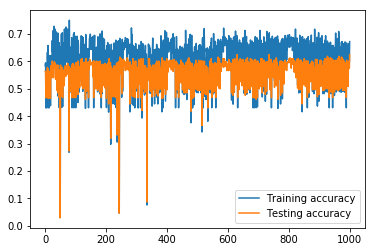

In [22]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

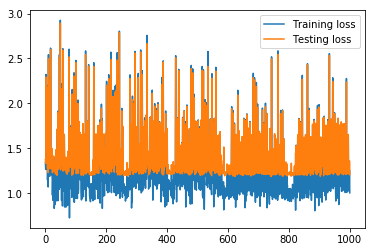

In [23]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()